In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import LeaveOneGroupOut
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GroupKFold
import itertools

In [19]:
def load_data(filepath):
    df = pd.read_csv(filepath, index_col=0)
    return df

In [20]:
SIGNAL_CATEGORIES = {
    'ECG': ['HR_mean', 'HR_std', 'NN50', 'pNN50', 'TINN', 'rmsHRV', 'LF', 'HF', 'LF_HF', 'sum_f', 'rel_f', 'LF_norm', 'HF_norm'],
    'PPG': ['PPG_HR_mean','PPG_HR_std','PPG_RMSSD','PPG_SDNN','PPG_LF','PPG_HF','PPG_LF_HF','PPG_num_beats','PPG_RiseTime','PPG_DecayTime','PPG_PAV_mean','PPG_PAV_std','PPG_RI'],
    'EDA': ['EDA_mean','EDA_std','EDA_min','EDA_max','EDA_range','EDA_slope','scl_mean','scl_std','scr_mean','scr_std','corr_scl_t','scr_count','scr_amp','scr_sum','scr_area'],
    'RESP': ['Resp_mean','Resp_std','Resp_I_mean','Resp_I_std','Resp_E_mean','Resp_E_std','Resp_IE_ratio','Resp_range','Resp_insp_vol','Resp_rate','Resp_duration'],
}
random = 13577

# Modelos que requieren normalización
MODELS_NEED_SCALING = ["KNN", "LDA"]

In [21]:
def calculate_metrics(y_true, y_pred, stage):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)

    metrics_table = pd.DataFrame({
        "Métrica": ["Accuracy", "Precision", "Recall", "F1 Score"],
        "Valor": [accuracy, precision, recall, f1],
        "Etapa": stage
    })
    
    print(f"{stage} Metrics")
    print(metrics_table)
    return metrics_table

In [22]:
def plot_confusion_matrix(y_true, y_pred, title):
    conf_mat = confusion_matrix(y_true, y_pred)
    print(f"{title} - Confusion Matrix")
    print(conf_mat)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, cmap="Greens", xticklabels=set(y_true), yticklabels=set(y_true), fmt='g')
    plt.xlabel("Etiquetas predichas")
    plt.ylabel("Etiquetas verdaderas")
    plt.title(f'Matriz de confusión - {title}')
    plt.show()

In [23]:
def train_and_evaluate(X, y, model, param_grid, model_name, signal_name):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random, stratify=y)
    
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=16, verbose=1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    metrics = calculate_metrics(y_test, y_pred, stage=f"{signal_name} - {model_name}")
    acc = metrics.loc[metrics["Métrica"] == "Accuracy", "Valor"].values[0]
    
    print(f'[{signal_name} - {model_name}] Best Params: {grid_search.best_params_}')
    print(f'[{signal_name} - {model_name}] Accuracy: {acc:.4f}')

    plot_confusion_matrix(y_test, y_pred, f'{signal_name} - {model_name}')

    print(classification_report(y_test, y_pred))

    return metrics


In [24]:
def train_and_evaluate_group(X, y, groups, model, param_grid, model_name, signal_name):
    group_kfold = GroupKFold(n_splits=5)

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=group_kfold,
        n_jobs=16,
        verbose=1
    )
    grid_search.fit(X, y, groups=groups)  # Aquí pasamos los grupos (sujetos)

    best_model = grid_search.best_estimator_

    y_true, y_pred = [], []
    for train_idx, test_idx in group_kfold.split(X, y, groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        best_model.fit(X_train, y_train)
        preds = best_model.predict(X_test)

        y_true.extend(y_test)
        y_pred.extend(preds)

    metrics = calculate_metrics(y_true, y_pred, stage=f"{signal_name} - {model_name}")
    acc = metrics.loc[metrics["Métrica"] == "Accuracy", "Valor"].values[0]

    print(f'[{signal_name} - {model_name}] Best Params: {grid_search.best_params_}')
    print(f'[{signal_name} - {model_name}] Accuracy: {acc:.4f}')

    plot_confusion_matrix(y_true, y_pred, f'{signal_name} - {model_name}')
    print(classification_report(y_true, y_pred))

    return metrics

In [ ]:
def train_and_evaluate_logo(X, y, groups, model, param_grid, model_name, signal_name):
    logo = LeaveOneGroupOut()

    n_splits = logo.get_n_splits(groups=groups)
    print(f"[{signal_name} - {model_name}] LOGO: {n_splits} folds (1 por sujeto)")

    scoring = {
    'accuracy': 'accuracy',
    'f1_weighted': 'f1_weighted',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted'
    }

    grid_search = GridSearchCV(
    model,
    param_grid,
    cv=logo.split(X, y, groups=groups),
    scoring=scoring,
    refit='f1_weighted',  # Prioriza F1 ponderado
    n_jobs=16,
    verbose=1
    )

    grid_search.fit(X, y)

    best_model = grid_search.best_estimator_
    y_pred = []
    y_true = []

    fold_accuracies = []
    subject_ids = []

    # Evaluamos con LOGO para obtener predicciones fuera de muestra
    for i, (train_idx, test_idx) in enumerate(logo.split(X, y, groups), 1):
        subject_tested = np.unique(groups[test_idx])[0]
        assert len(np.unique(groups[test_idx])) == 1, "Test set debe contener exactamente un sujeto"
        print(f"[{signal_name} - {model_name}] Fold {i}/{n_splits} (Subject: {subject_tested})")

        best_model.fit(X[train_idx], y[train_idx])
        preds = best_model.predict(X[test_idx])

        y_pred.extend(preds)
        y_true.extend(y[test_idx])

        acc_fold = accuracy_score(y[test_idx], preds)
        fold_accuracies.append(acc_fold)
        subject_ids.append(subject_tested)

    # Crear gráfico de accuracy por sujeto
    plt.figure(figsize=(10, 4))
    plt.plot(subject_ids, fold_accuracies, marker='o', linestyle='-')
    plt.xticks(subject_ids)
    plt.title(f'Accuracy por sujeto - {signal_name} - {model_name}')
    plt.xlabel('Sujeto')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

    metrics = calculate_metrics(y_true, y_pred, stage=f"{signal_name} - {model_name}")
    f1 = metrics.loc[metrics["Métrica"] == "F1 Score", "Valor"].values[0]

    print(f'[{signal_name} - {model_name}] Best Params: {grid_search.best_params_}')
    print(f'[{signal_name} - {model_name}] F1 Score (weighted): {f1:.4f}')

    plot_confusion_matrix(y_true, y_pred, f'{signal_name} - {model_name}')
    print(classification_report(y_true, y_pred))

    return metrics

In [26]:
models = {
    "DecisionTree": (
        DecisionTreeClassifier(class_weight='balanced', random_state=random),
        {"max_depth": [3, 5, 10, 15],
         "min_samples_split": [2, 5, 10], 
         "max_leaf_nodes": [10, 15, 20, 30, 40],
         "criterion": ["gini", "entropy"]}
    ),
    "RandomForest": (
        RandomForestClassifier(class_weight='balanced', random_state=random),
        {"n_estimators": [100, 200, 300],
         "max_depth": [5, 10, 20],
         "min_samples_split": [2, 5, 10, 20],
         "min_samples_leaf": [2, 4],
         "max_features": ['sqrt']}
    ),
    "AdaBoost": (
        AdaBoostClassifier(random_state=random),
        {"n_estimators": [50, 100, 200, 300], 
         "learning_rate": [0.01, 0.1, 0.5, 1], 
         "estimator": [
             DecisionTreeClassifier(max_depth=1, class_weight='balanced'),
             DecisionTreeClassifier(max_depth=3, class_weight='balanced')
         ]}
    ),
    "LDA": (
        LinearDiscriminantAnalysis(),
        {"solver": ["svd"]}
    ),
    "KNN": (
        KNeighborsClassifier(),
        {"n_neighbors": [3, 5, 7, 9], "weights": ["uniform", "distance"]}
    )
}

results = {}


all_signals = list(SIGNAL_CATEGORIES.keys())
combinations = []
for r in range(2, len(all_signals) + 1):
    combinations.extend(itertools.combinations(all_signals, r))

In [27]:
file = r'features_30_075\features.csv'

df = load_data(file)
df = df.fillna(0)

In [28]:
df.columns

Index(['HR_mean', 'HR_std', 'NN50', 'pNN50', 'TINN', 'rmsHRV', 'LF', 'HF',
       'LF_HF', 'sum_f', 'rel_f', 'LF_norm', 'HF_norm', 'PPG_HR_mean',
       'PPG_HR_std', 'PPG_RMSSD', 'PPG_SDNN', 'PPG_LF', 'PPG_HF', 'PPG_LF_HF',
       'PPG_num_beats', 'PPG_RiseTime', 'PPG_DecayTime', 'PPG_PAV_mean',
       'PPG_PAV_std', 'PPG_RI', 'EDA_mean', 'EDA_std', 'EDA_min', 'EDA_max',
       'EDA_range', 'EDA_slope', 'scl_mean', 'scl_std', 'scr_mean', 'scr_std',
       'corr_scl_t', 'scr_count', 'scr_amp', 'scr_sum', 'scr_area',
       'Resp_mean', 'Resp_std', 'Resp_I_mean', 'Resp_I_std', 'Resp_E_mean',
       'Resp_E_std', 'Resp_IE_ratio', 'Resp_range', 'Resp_insp_vol',
       'Resp_rate', 'Resp_duration', 'subject', 'label'],
      dtype='object')

In [29]:
print("Valores nulos por columna:\n", df.isna().sum())

Valores nulos por columna:
 HR_mean          0
HR_std           0
NN50             0
pNN50            0
TINN             0
rmsHRV           0
LF               0
HF               0
LF_HF            0
sum_f            0
rel_f            0
LF_norm          0
HF_norm          0
PPG_HR_mean      0
PPG_HR_std       0
PPG_RMSSD        0
PPG_SDNN         0
PPG_LF           0
PPG_HF           0
PPG_LF_HF        0
PPG_num_beats    0
PPG_RiseTime     0
PPG_DecayTime    0
PPG_PAV_mean     0
PPG_PAV_std      0
PPG_RI           0
EDA_mean         0
EDA_std          0
EDA_min          0
EDA_max          0
EDA_range        0
EDA_slope        0
scl_mean         0
scl_std          0
scr_mean         0
scr_std          0
corr_scl_t       0
scr_count        0
scr_amp          0
scr_sum          0
scr_area         0
Resp_mean        0
Resp_std         0
Resp_I_mean      0
Resp_I_std       0
Resp_E_mean      0
Resp_E_std       0
Resp_IE_ratio    0
Resp_range       0
Resp_insp_vol    0
Resp_rate        0
Res

In [30]:
for i in range(1, len(df['label'].unique())+1):
    mask = (df['label'] == i).sum()
    print(f'Label: {i} total: {mask}')

Label: 1 total: 51769
Label: 2 total: 21089
Label: 3 total: 53017
Label: 4 total: 32926


In [31]:
#Aplicar muestra binaria
df['label'] = df['label'].apply(lambda x: 1 if x in [1, 2] else 2)

In [32]:
for i in range(1, len(df['label'].unique())+1):
    mask = (df['label'] == i).sum()
    print(f'Label: {i} total: {mask}')

Label: 1 total: 72858
Label: 2 total: 85943


Training by signal:   0%|          | 0/4 [00:00<?, ?it/s]

Training DecisionTree model for ECG using LOGO...
[ECG - DecisionTree] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 120 candidates, totalling 3120 fits
[ECG - DecisionTree] Fold 1/26 (Subject: 4)
[ECG - DecisionTree] Fold 2/26 (Subject: 6)
[ECG - DecisionTree] Fold 3/26 (Subject: 7)
[ECG - DecisionTree] Fold 4/26 (Subject: 8)
[ECG - DecisionTree] Fold 5/26 (Subject: 9)
[ECG - DecisionTree] Fold 6/26 (Subject: 10)
[ECG - DecisionTree] Fold 7/26 (Subject: 11)
[ECG - DecisionTree] Fold 8/26 (Subject: 13)
[ECG - DecisionTree] Fold 9/26 (Subject: 14)
[ECG - DecisionTree] Fold 10/26 (Subject: 15)
[ECG - DecisionTree] Fold 11/26 (Subject: 18)
[ECG - DecisionTree] Fold 12/26 (Subject: 19)
[ECG - DecisionTree] Fold 13/26 (Subject: 20)
[ECG - DecisionTree] Fold 14/26 (Subject: 21)
[ECG - DecisionTree] Fold 15/26 (Subject: 22)
[ECG - DecisionTree] Fold 16/26 (Subject: 29)
[ECG - DecisionTree] Fold 17/26 (Subject: 30)
[ECG - DecisionTree] Fold 18/26 (Subject: 35)
[ECG - DecisionTree]

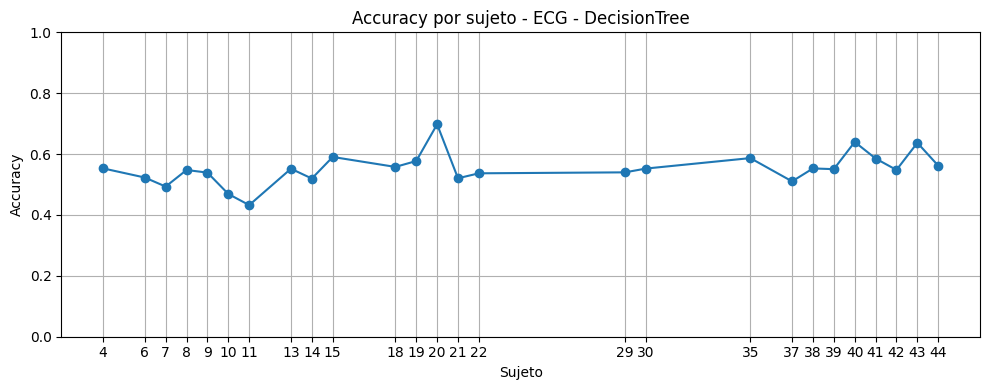

ECG - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.553479  ECG - DecisionTree
1  Precision  0.553305  ECG - DecisionTree
2     Recall  0.553479  ECG - DecisionTree
3   F1 Score  0.553389  ECG - DecisionTree
[ECG - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 15, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[ECG - DecisionTree] Accuracy: 0.5535
ECG - DecisionTree - Confusion Matrix
[[37217 35641]
 [35267 50676]]


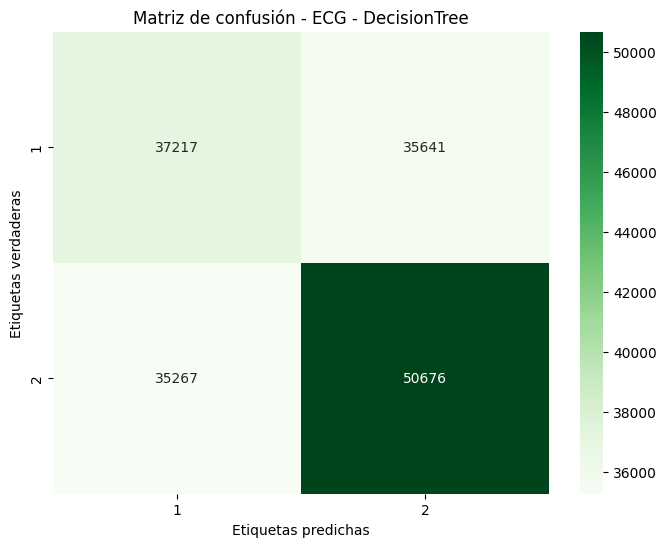

              precision    recall  f1-score   support

           1       0.51      0.51      0.51     72858
           2       0.59      0.59      0.59     85943

    accuracy                           0.55    158801
   macro avg       0.55      0.55      0.55    158801
weighted avg       0.55      0.55      0.55    158801

Training RandomForest model for ECG using LOGO...
[ECG - RandomForest] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 72 candidates, totalling 1872 fits
[ECG - RandomForest] Fold 1/26 (Subject: 4)
[ECG - RandomForest] Fold 2/26 (Subject: 6)
[ECG - RandomForest] Fold 3/26 (Subject: 7)
[ECG - RandomForest] Fold 4/26 (Subject: 8)
[ECG - RandomForest] Fold 5/26 (Subject: 9)
[ECG - RandomForest] Fold 6/26 (Subject: 10)
[ECG - RandomForest] Fold 7/26 (Subject: 11)
[ECG - RandomForest] Fold 8/26 (Subject: 13)
[ECG - RandomForest] Fold 9/26 (Subject: 14)
[ECG - RandomForest] Fold 10/26 (Subject: 15)
[ECG - RandomForest] Fold 11/26 (Subject: 18)
[ECG - RandomFor

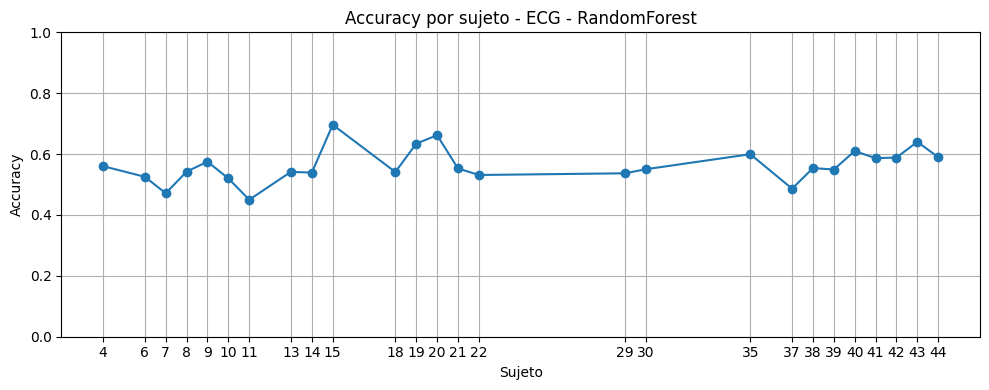

ECG - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.563535  ECG - RandomForest
1  Precision  0.563229  ECG - RandomForest
2     Recall  0.563535  ECG - RandomForest
3   F1 Score  0.563372  ECG - RandomForest
[ECG - RandomForest] Best Params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
[ECG - RandomForest] Accuracy: 0.5635
ECG - RandomForest - Confusion Matrix
[[37862 34996]
 [34315 51628]]


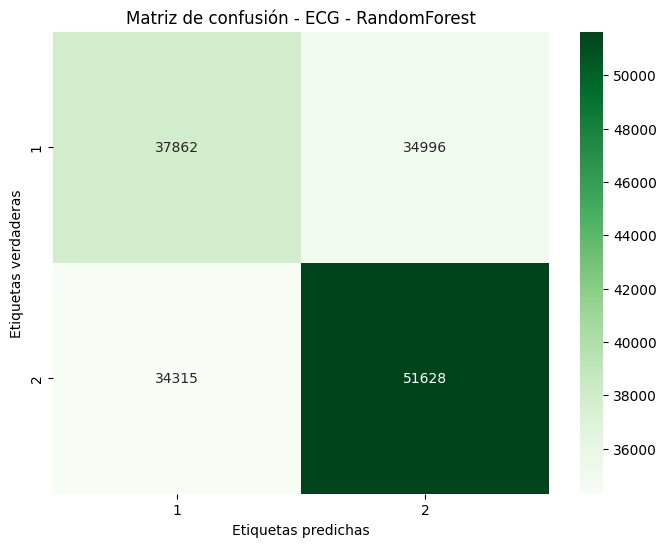

              precision    recall  f1-score   support

           1       0.52      0.52      0.52     72858
           2       0.60      0.60      0.60     85943

    accuracy                           0.56    158801
   macro avg       0.56      0.56      0.56    158801
weighted avg       0.56      0.56      0.56    158801

Training AdaBoost model for ECG using LOGO...
[ECG - AdaBoost] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 32 candidates, totalling 832 fits
[ECG - AdaBoost] Fold 1/26 (Subject: 4)
[ECG - AdaBoost] Fold 2/26 (Subject: 6)
[ECG - AdaBoost] Fold 3/26 (Subject: 7)
[ECG - AdaBoost] Fold 4/26 (Subject: 8)
[ECG - AdaBoost] Fold 5/26 (Subject: 9)
[ECG - AdaBoost] Fold 6/26 (Subject: 10)
[ECG - AdaBoost] Fold 7/26 (Subject: 11)
[ECG - AdaBoost] Fold 8/26 (Subject: 13)
[ECG - AdaBoost] Fold 9/26 (Subject: 14)
[ECG - AdaBoost] Fold 10/26 (Subject: 15)
[ECG - AdaBoost] Fold 11/26 (Subject: 18)
[ECG - AdaBoost] Fold 12/26 (Subject: 19)
[ECG - AdaBoost] Fold 13/26

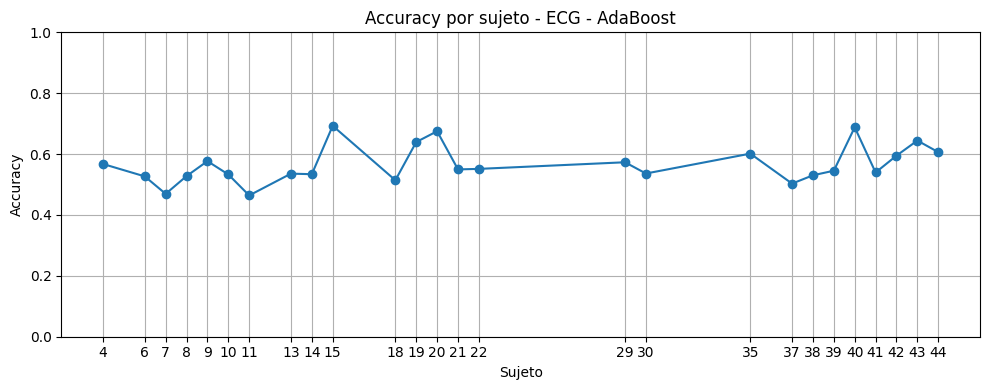

ECG - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.566810  ECG - AdaBoost
1  Precision  0.565891  ECG - AdaBoost
2     Recall  0.566810  ECG - AdaBoost
3   F1 Score  0.566249  ECG - AdaBoost
[ECG - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=1), 'learning_rate': 0.1, 'n_estimators': 100}
[ECG - AdaBoost] Accuracy: 0.5668
ECG - AdaBoost - Confusion Matrix
[[37399 35459]
 [33332 52611]]


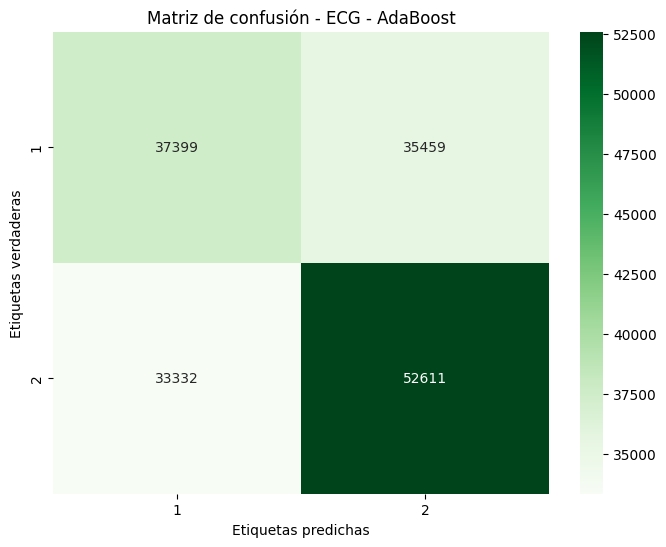

              precision    recall  f1-score   support

           1       0.53      0.51      0.52     72858
           2       0.60      0.61      0.60     85943

    accuracy                           0.57    158801
   macro avg       0.56      0.56      0.56    158801
weighted avg       0.57      0.57      0.57    158801

Training LDA model for ECG using LOGO...
[ECG - LDA] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 1 candidates, totalling 26 fits
[ECG - LDA] Fold 1/26 (Subject: 4)
[ECG - LDA] Fold 2/26 (Subject: 6)
[ECG - LDA] Fold 3/26 (Subject: 7)
[ECG - LDA] Fold 4/26 (Subject: 8)
[ECG - LDA] Fold 5/26 (Subject: 9)
[ECG - LDA] Fold 6/26 (Subject: 10)
[ECG - LDA] Fold 7/26 (Subject: 11)
[ECG - LDA] Fold 8/26 (Subject: 13)
[ECG - LDA] Fold 9/26 (Subject: 14)
[ECG - LDA] Fold 10/26 (Subject: 15)
[ECG - LDA] Fold 11/26 (Subject: 18)
[ECG - LDA] Fold 12/26 (Subject: 19)
[ECG - LDA] Fold 13/26 (Subject: 20)
[ECG - LDA] Fold 14/26 (Subject: 21)
[ECG - LDA] Fold 15/26 (S

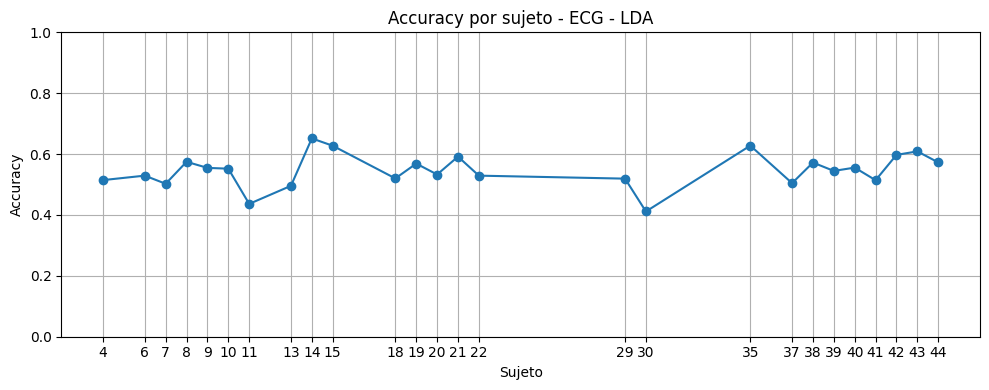

ECG - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.546741  ECG - LDA
1  Precision  0.539256  ECG - LDA
2     Recall  0.546741  ECG - LDA
3   F1 Score  0.533370  ECG - LDA
[ECG - LDA] Best Params: {'solver': 'svd'}
[ECG - LDA] Accuracy: 0.5467
ECG - LDA - Confusion Matrix
[[26423 46435]
 [25543 60400]]


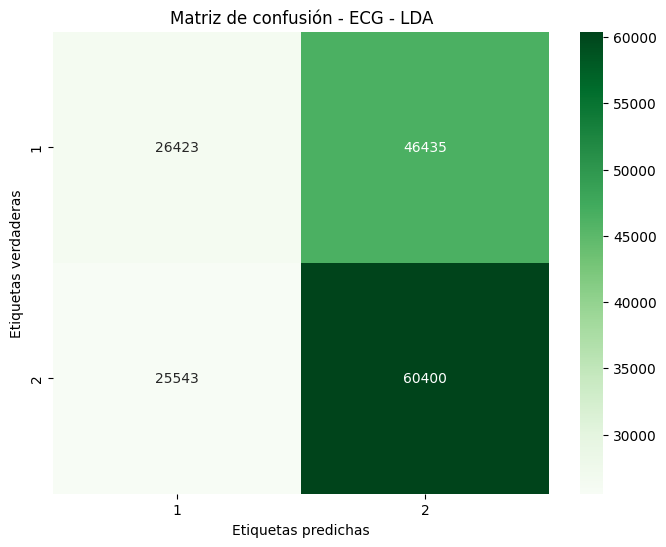

              precision    recall  f1-score   support

           1       0.51      0.36      0.42     72858
           2       0.57      0.70      0.63     85943

    accuracy                           0.55    158801
   macro avg       0.54      0.53      0.52    158801
weighted avg       0.54      0.55      0.53    158801

Training KNN model for ECG using LOGO...
[ECG - KNN] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 8 candidates, totalling 208 fits
[ECG - KNN] Fold 1/26 (Subject: 4)
[ECG - KNN] Fold 2/26 (Subject: 6)
[ECG - KNN] Fold 3/26 (Subject: 7)
[ECG - KNN] Fold 4/26 (Subject: 8)
[ECG - KNN] Fold 5/26 (Subject: 9)
[ECG - KNN] Fold 6/26 (Subject: 10)
[ECG - KNN] Fold 7/26 (Subject: 11)
[ECG - KNN] Fold 8/26 (Subject: 13)
[ECG - KNN] Fold 9/26 (Subject: 14)
[ECG - KNN] Fold 10/26 (Subject: 15)
[ECG - KNN] Fold 11/26 (Subject: 18)
[ECG - KNN] Fold 12/26 (Subject: 19)
[ECG - KNN] Fold 13/26 (Subject: 20)
[ECG - KNN] Fold 14/26 (Subject: 21)
[ECG - KNN] Fold 15/26 (

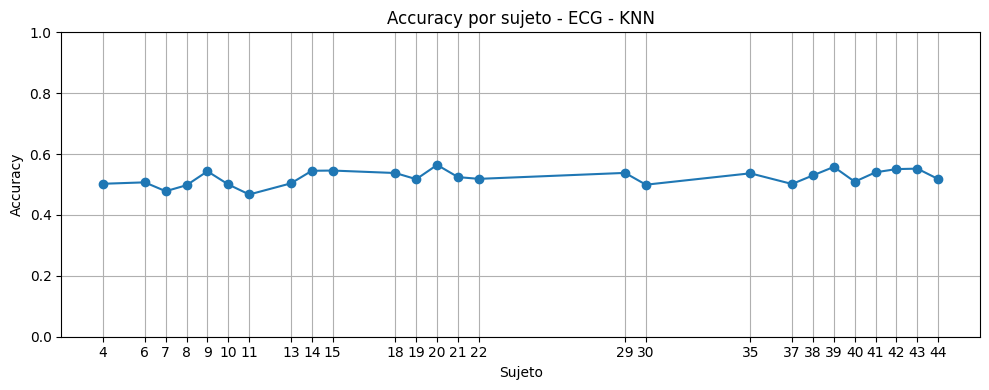

ECG - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.522786  ECG - KNN
1  Precision  0.518695  ECG - KNN
2     Recall  0.522786  ECG - KNN
3   F1 Score  0.519254  ECG - KNN
[ECG - KNN] Best Params: {'n_neighbors': 9, 'weights': 'uniform'}
[ECG - KNN] Accuracy: 0.5228
ECG - KNN - Confusion Matrix
[[30721 42137]
 [33645 52298]]


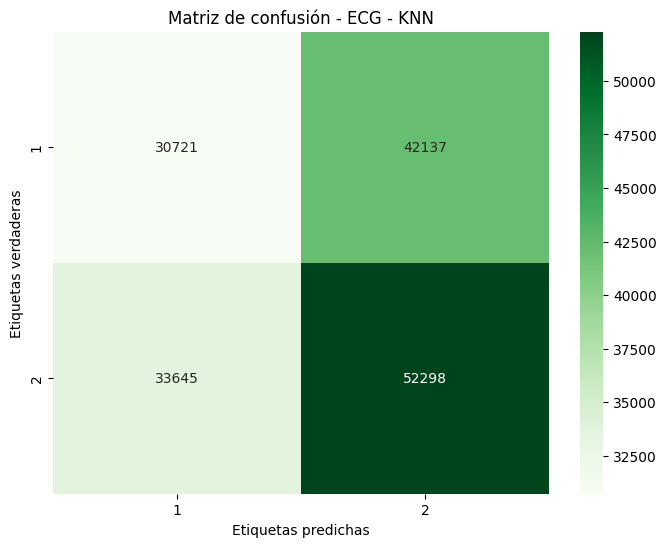

Training by signal:  25%|██▌       | 1/4 [12:56:41<38:50:03, 46601.10s/it]

              precision    recall  f1-score   support

           1       0.48      0.42      0.45     72858
           2       0.55      0.61      0.58     85943

    accuracy                           0.52    158801
   macro avg       0.52      0.52      0.51    158801
weighted avg       0.52      0.52      0.52    158801

Training DecisionTree model for PPG using LOGO...
[PPG - DecisionTree] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 120 candidates, totalling 3120 fits
[PPG - DecisionTree] Fold 1/26 (Subject: 4)
[PPG - DecisionTree] Fold 2/26 (Subject: 6)
[PPG - DecisionTree] Fold 3/26 (Subject: 7)
[PPG - DecisionTree] Fold 4/26 (Subject: 8)
[PPG - DecisionTree] Fold 5/26 (Subject: 9)
[PPG - DecisionTree] Fold 6/26 (Subject: 10)
[PPG - DecisionTree] Fold 7/26 (Subject: 11)
[PPG - DecisionTree] Fold 8/26 (Subject: 13)
[PPG - DecisionTree] Fold 9/26 (Subject: 14)
[PPG - DecisionTree] Fold 10/26 (Subject: 15)
[PPG - DecisionTree] Fold 11/26 (Subject: 18)
[PPG - Decision

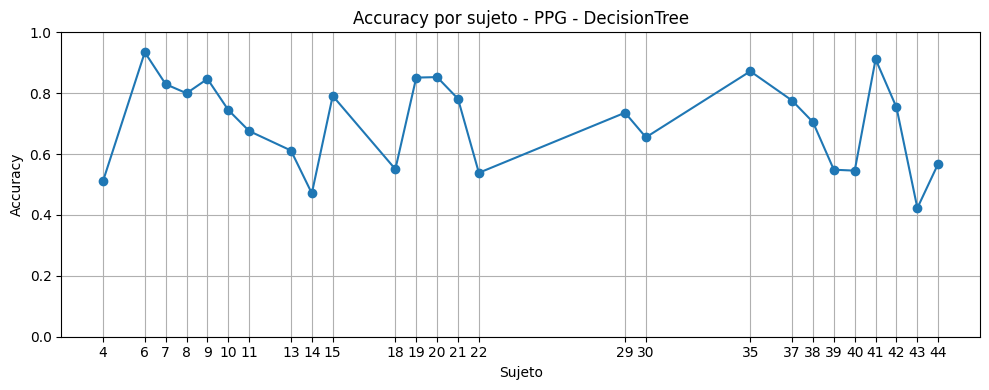

PPG - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.703975  PPG - DecisionTree
1  Precision  0.703384  PPG - DecisionTree
2     Recall  0.703975  PPG - DecisionTree
3   F1 Score  0.703487  PPG - DecisionTree
[PPG - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 10, 'min_samples_split': 2}
[PPG - DecisionTree] Accuracy: 0.7040
PPG - DecisionTree - Confusion Matrix
[[48041 24817]
 [22192 63751]]


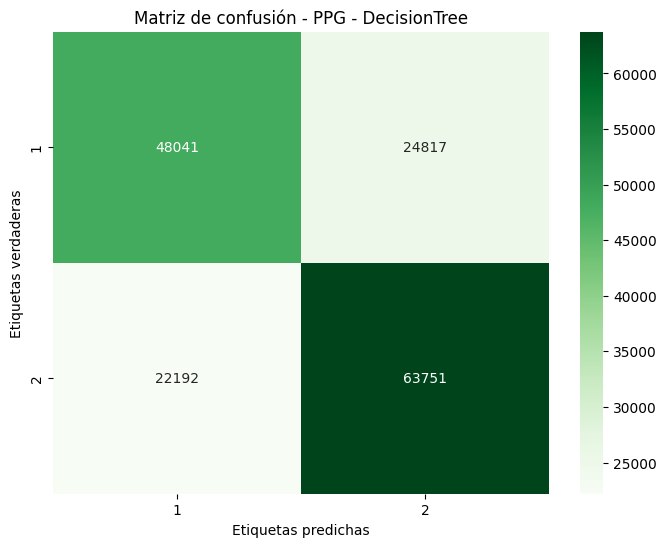

              precision    recall  f1-score   support

           1       0.68      0.66      0.67     72858
           2       0.72      0.74      0.73     85943

    accuracy                           0.70    158801
   macro avg       0.70      0.70      0.70    158801
weighted avg       0.70      0.70      0.70    158801

Training RandomForest model for PPG using LOGO...
[PPG - RandomForest] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 72 candidates, totalling 1872 fits
[PPG - RandomForest] Fold 1/26 (Subject: 4)
[PPG - RandomForest] Fold 2/26 (Subject: 6)
[PPG - RandomForest] Fold 3/26 (Subject: 7)
[PPG - RandomForest] Fold 4/26 (Subject: 8)
[PPG - RandomForest] Fold 5/26 (Subject: 9)
[PPG - RandomForest] Fold 6/26 (Subject: 10)
[PPG - RandomForest] Fold 7/26 (Subject: 11)
[PPG - RandomForest] Fold 8/26 (Subject: 13)
[PPG - RandomForest] Fold 9/26 (Subject: 14)
[PPG - RandomForest] Fold 10/26 (Subject: 15)
[PPG - RandomForest] Fold 11/26 (Subject: 18)
[PPG - RandomFor

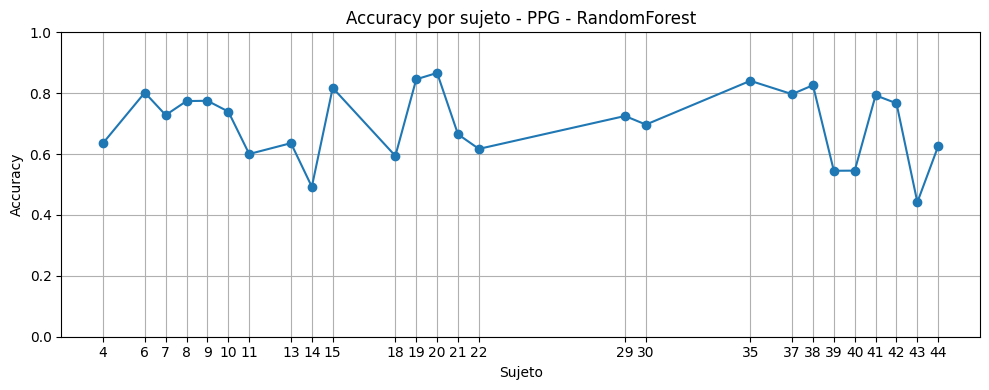

PPG - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.700871  PPG - RandomForest
1  Precision  0.700595  PPG - RandomForest
2     Recall  0.700871  PPG - RandomForest
3   F1 Score  0.700706  PPG - RandomForest
[PPG - RandomForest] Best Params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
[PPG - RandomForest] Accuracy: 0.7009
PPG - RandomForest - Confusion Matrix
[[48618 24240]
 [23262 62681]]


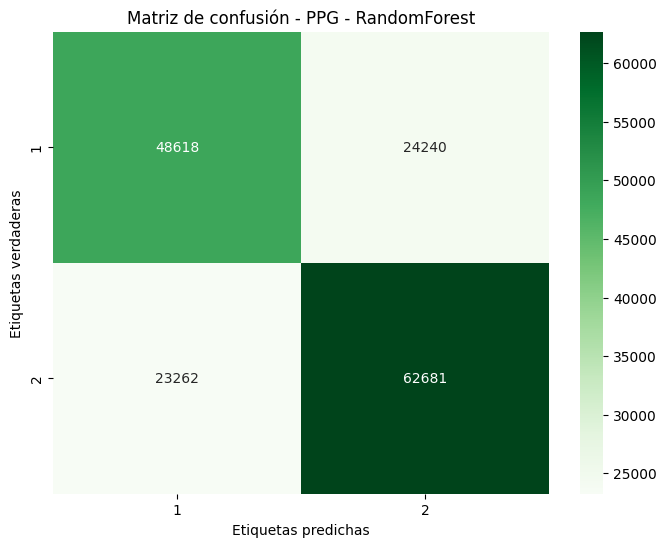

              precision    recall  f1-score   support

           1       0.68      0.67      0.67     72858
           2       0.72      0.73      0.73     85943

    accuracy                           0.70    158801
   macro avg       0.70      0.70      0.70    158801
weighted avg       0.70      0.70      0.70    158801

Training AdaBoost model for PPG using LOGO...
[PPG - AdaBoost] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 32 candidates, totalling 832 fits
[PPG - AdaBoost] Fold 1/26 (Subject: 4)
[PPG - AdaBoost] Fold 2/26 (Subject: 6)
[PPG - AdaBoost] Fold 3/26 (Subject: 7)
[PPG - AdaBoost] Fold 4/26 (Subject: 8)
[PPG - AdaBoost] Fold 5/26 (Subject: 9)
[PPG - AdaBoost] Fold 6/26 (Subject: 10)
[PPG - AdaBoost] Fold 7/26 (Subject: 11)
[PPG - AdaBoost] Fold 8/26 (Subject: 13)
[PPG - AdaBoost] Fold 9/26 (Subject: 14)
[PPG - AdaBoost] Fold 10/26 (Subject: 15)
[PPG - AdaBoost] Fold 11/26 (Subject: 18)
[PPG - AdaBoost] Fold 12/26 (Subject: 19)
[PPG - AdaBoost] Fold 13/26

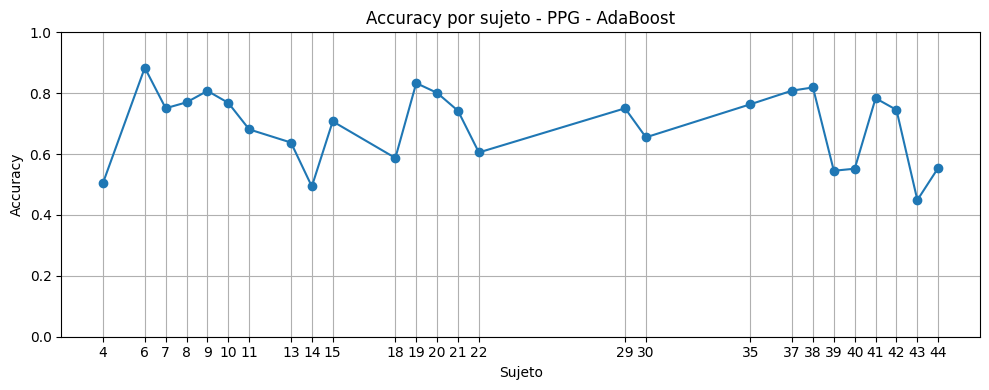

PPG - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.692892  PPG - AdaBoost
1  Precision  0.692372  PPG - AdaBoost
2     Recall  0.692892  PPG - AdaBoost
3   F1 Score  0.692522  PPG - AdaBoost
[PPG - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 0.01, 'n_estimators': 300}
[PPG - AdaBoost] Accuracy: 0.6929
PPG - AdaBoost - Confusion Matrix
[[47475 25383]
 [23386 62557]]


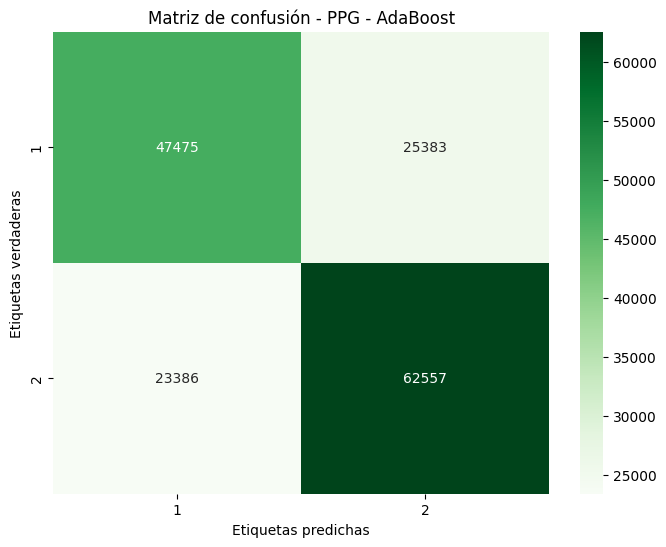

              precision    recall  f1-score   support

           1       0.67      0.65      0.66     72858
           2       0.71      0.73      0.72     85943

    accuracy                           0.69    158801
   macro avg       0.69      0.69      0.69    158801
weighted avg       0.69      0.69      0.69    158801

Training LDA model for PPG using LOGO...
[PPG - LDA] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 1 candidates, totalling 26 fits
[PPG - LDA] Fold 1/26 (Subject: 4)
[PPG - LDA] Fold 2/26 (Subject: 6)
[PPG - LDA] Fold 3/26 (Subject: 7)
[PPG - LDA] Fold 4/26 (Subject: 8)
[PPG - LDA] Fold 5/26 (Subject: 9)
[PPG - LDA] Fold 6/26 (Subject: 10)
[PPG - LDA] Fold 7/26 (Subject: 11)
[PPG - LDA] Fold 8/26 (Subject: 13)
[PPG - LDA] Fold 9/26 (Subject: 14)
[PPG - LDA] Fold 10/26 (Subject: 15)
[PPG - LDA] Fold 11/26 (Subject: 18)
[PPG - LDA] Fold 12/26 (Subject: 19)
[PPG - LDA] Fold 13/26 (Subject: 20)
[PPG - LDA] Fold 14/26 (Subject: 21)
[PPG - LDA] Fold 15/26 (S

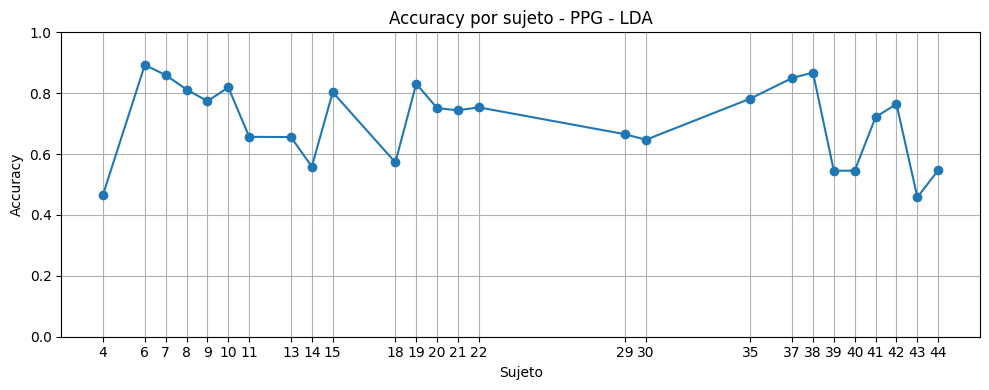

PPG - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.706028  PPG - LDA
1  Precision  0.707968  PPG - LDA
2     Recall  0.706028  PPG - LDA
3   F1 Score  0.701742  PPG - LDA
[PPG - LDA] Best Params: {'solver': 'svd'}
[PPG - LDA] Accuracy: 0.7060
PPG - LDA - Confusion Matrix
[[42785 30073]
 [16610 69333]]


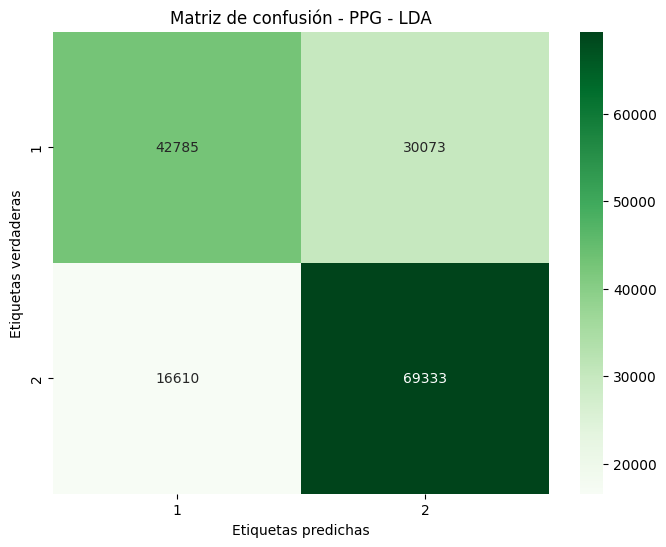

              precision    recall  f1-score   support

           1       0.72      0.59      0.65     72858
           2       0.70      0.81      0.75     85943

    accuracy                           0.71    158801
   macro avg       0.71      0.70      0.70    158801
weighted avg       0.71      0.71      0.70    158801

Training KNN model for PPG using LOGO...
[PPG - KNN] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 8 candidates, totalling 208 fits
[PPG - KNN] Fold 1/26 (Subject: 4)
[PPG - KNN] Fold 2/26 (Subject: 6)
[PPG - KNN] Fold 3/26 (Subject: 7)
[PPG - KNN] Fold 4/26 (Subject: 8)
[PPG - KNN] Fold 5/26 (Subject: 9)
[PPG - KNN] Fold 6/26 (Subject: 10)
[PPG - KNN] Fold 7/26 (Subject: 11)
[PPG - KNN] Fold 8/26 (Subject: 13)
[PPG - KNN] Fold 9/26 (Subject: 14)
[PPG - KNN] Fold 10/26 (Subject: 15)
[PPG - KNN] Fold 11/26 (Subject: 18)
[PPG - KNN] Fold 12/26 (Subject: 19)
[PPG - KNN] Fold 13/26 (Subject: 20)
[PPG - KNN] Fold 14/26 (Subject: 21)
[PPG - KNN] Fold 15/26 (

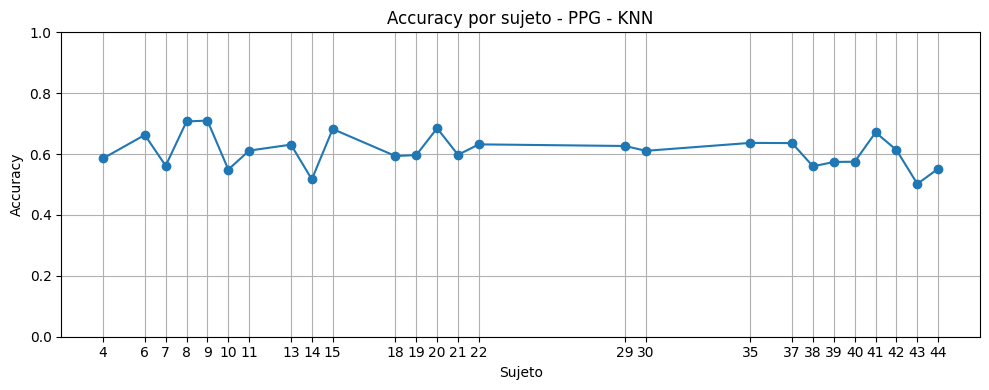

PPG - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.610947  PPG - KNN
1  Precision  0.608503  PPG - KNN
2     Recall  0.610947  PPG - KNN
3   F1 Score  0.606244  PPG - KNN
[PPG - KNN] Best Params: {'n_neighbors': 9, 'weights': 'distance'}
[PPG - KNN] Accuracy: 0.6109
PPG - KNN - Confusion Matrix
[[36017 36841]
 [24941 61002]]


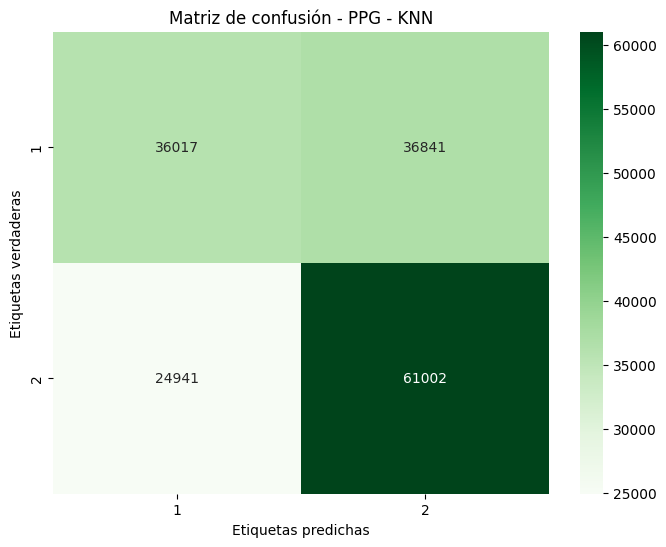

Training by signal:  50%|█████     | 2/4 [28:06:09<28:29:35, 51287.52s/it]

              precision    recall  f1-score   support

           1       0.59      0.49      0.54     72858
           2       0.62      0.71      0.66     85943

    accuracy                           0.61    158801
   macro avg       0.61      0.60      0.60    158801
weighted avg       0.61      0.61      0.61    158801

Training DecisionTree model for EDA using LOGO...
[EDA - DecisionTree] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 120 candidates, totalling 3120 fits
[EDA - DecisionTree] Fold 1/26 (Subject: 4)
[EDA - DecisionTree] Fold 2/26 (Subject: 6)
[EDA - DecisionTree] Fold 3/26 (Subject: 7)
[EDA - DecisionTree] Fold 4/26 (Subject: 8)
[EDA - DecisionTree] Fold 5/26 (Subject: 9)
[EDA - DecisionTree] Fold 6/26 (Subject: 10)
[EDA - DecisionTree] Fold 7/26 (Subject: 11)
[EDA - DecisionTree] Fold 8/26 (Subject: 13)
[EDA - DecisionTree] Fold 9/26 (Subject: 14)
[EDA - DecisionTree] Fold 10/26 (Subject: 15)
[EDA - DecisionTree] Fold 11/26 (Subject: 18)
[EDA - Decision

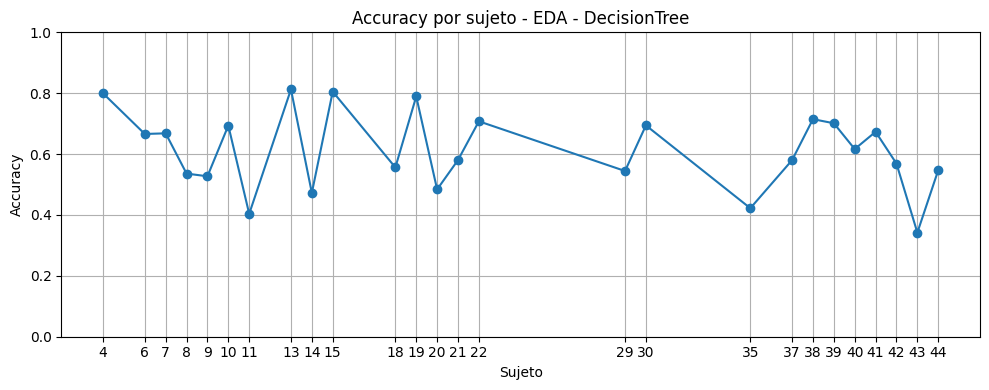

EDA - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.611602  EDA - DecisionTree
1  Precision  0.609925  EDA - DecisionTree
2     Recall  0.611602  EDA - DecisionTree
3   F1 Score  0.602631  EDA - DecisionTree
[EDA - DecisionTree] Best Params: {'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': 20, 'min_samples_split': 2}
[EDA - DecisionTree] Accuracy: 0.6116
EDA - DecisionTree - Confusion Matrix
[[33013 39845]
 [21833 64110]]


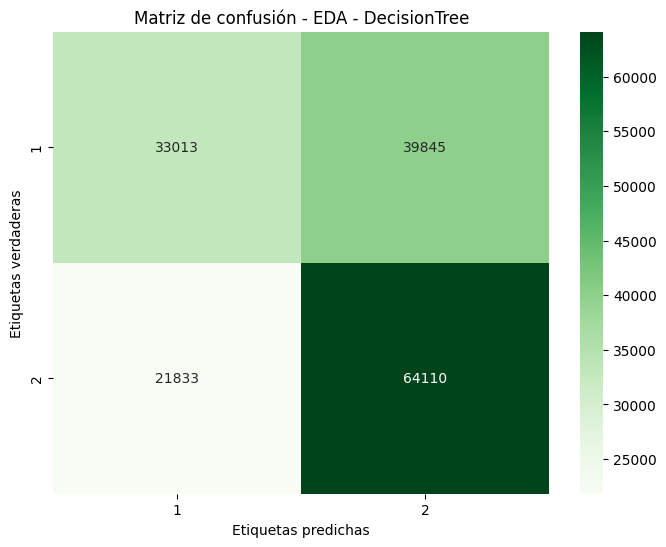

              precision    recall  f1-score   support

           1       0.60      0.45      0.52     72858
           2       0.62      0.75      0.68     85943

    accuracy                           0.61    158801
   macro avg       0.61      0.60      0.60    158801
weighted avg       0.61      0.61      0.60    158801

Training RandomForest model for EDA using LOGO...
[EDA - RandomForest] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 72 candidates, totalling 1872 fits
[EDA - RandomForest] Fold 1/26 (Subject: 4)
[EDA - RandomForest] Fold 2/26 (Subject: 6)
[EDA - RandomForest] Fold 3/26 (Subject: 7)
[EDA - RandomForest] Fold 4/26 (Subject: 8)
[EDA - RandomForest] Fold 5/26 (Subject: 9)
[EDA - RandomForest] Fold 6/26 (Subject: 10)
[EDA - RandomForest] Fold 7/26 (Subject: 11)
[EDA - RandomForest] Fold 8/26 (Subject: 13)
[EDA - RandomForest] Fold 9/26 (Subject: 14)
[EDA - RandomForest] Fold 10/26 (Subject: 15)
[EDA - RandomForest] Fold 11/26 (Subject: 18)
[EDA - RandomFor

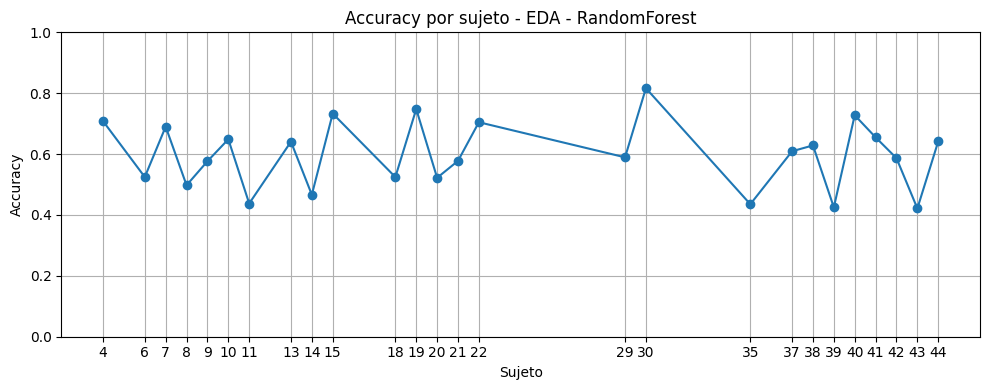

EDA - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.597465  EDA - RandomForest
1  Precision  0.597381  EDA - RandomForest
2     Recall  0.597465  EDA - RandomForest
3   F1 Score  0.597422  EDA - RandomForest
[EDA - RandomForest] Best Params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 100}
[EDA - RandomForest] Accuracy: 0.5975
EDA - RandomForest - Confusion Matrix
[[40796 32062]
 [31861 54082]]


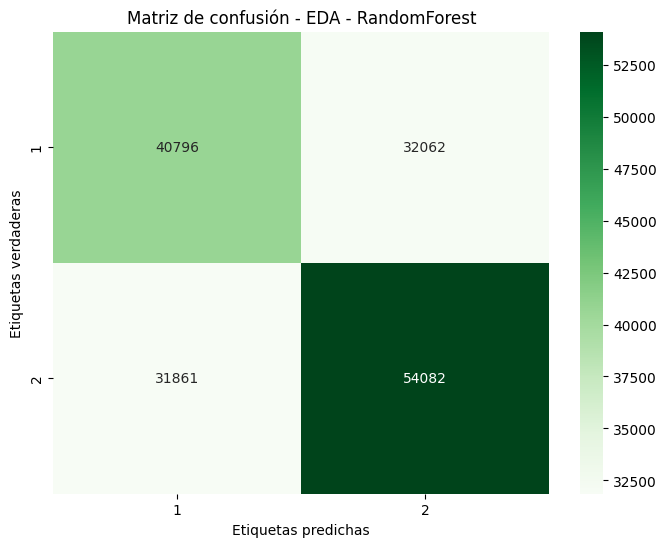

              precision    recall  f1-score   support

           1       0.56      0.56      0.56     72858
           2       0.63      0.63      0.63     85943

    accuracy                           0.60    158801
   macro avg       0.59      0.59      0.59    158801
weighted avg       0.60      0.60      0.60    158801

Training AdaBoost model for EDA using LOGO...
[EDA - AdaBoost] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 32 candidates, totalling 832 fits
[EDA - AdaBoost] Fold 1/26 (Subject: 4)
[EDA - AdaBoost] Fold 2/26 (Subject: 6)
[EDA - AdaBoost] Fold 3/26 (Subject: 7)
[EDA - AdaBoost] Fold 4/26 (Subject: 8)
[EDA - AdaBoost] Fold 5/26 (Subject: 9)
[EDA - AdaBoost] Fold 6/26 (Subject: 10)
[EDA - AdaBoost] Fold 7/26 (Subject: 11)
[EDA - AdaBoost] Fold 8/26 (Subject: 13)
[EDA - AdaBoost] Fold 9/26 (Subject: 14)
[EDA - AdaBoost] Fold 10/26 (Subject: 15)
[EDA - AdaBoost] Fold 11/26 (Subject: 18)
[EDA - AdaBoost] Fold 12/26 (Subject: 19)
[EDA - AdaBoost] Fold 13/26

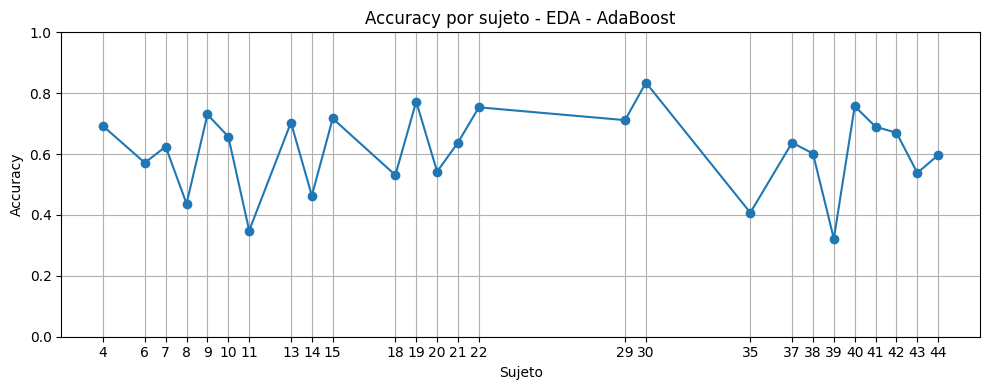

EDA - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.612887  EDA - AdaBoost
1  Precision  0.616383  EDA - AdaBoost
2     Recall  0.612887  EDA - AdaBoost
3   F1 Score  0.613544  EDA - AdaBoost
[EDA - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=1), 'learning_rate': 0.5, 'n_estimators': 300}
[EDA - AdaBoost] Accuracy: 0.6129
EDA - AdaBoost - Confusion Matrix
[[45472 27386]
 [34088 51855]]


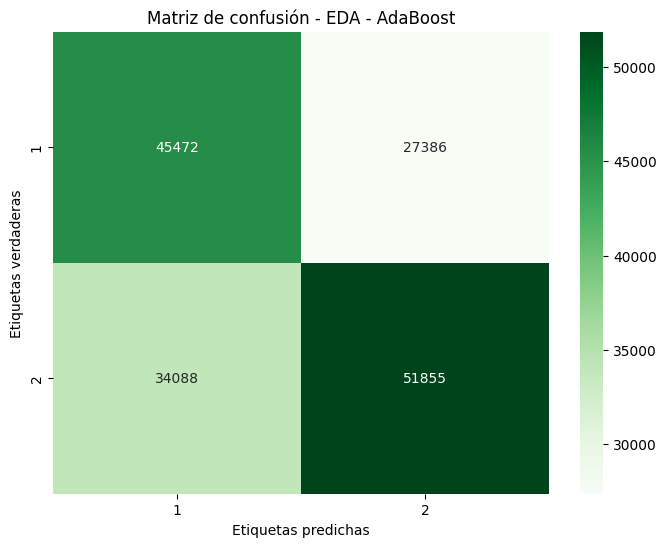

              precision    recall  f1-score   support

           1       0.57      0.62      0.60     72858
           2       0.65      0.60      0.63     85943

    accuracy                           0.61    158801
   macro avg       0.61      0.61      0.61    158801
weighted avg       0.62      0.61      0.61    158801

Training LDA model for EDA using LOGO...
[EDA - LDA] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 1 candidates, totalling 26 fits
[EDA - LDA] Fold 1/26 (Subject: 4)
[EDA - LDA] Fold 2/26 (Subject: 6)
[EDA - LDA] Fold 3/26 (Subject: 7)
[EDA - LDA] Fold 4/26 (Subject: 8)
[EDA - LDA] Fold 5/26 (Subject: 9)
[EDA - LDA] Fold 6/26 (Subject: 10)
[EDA - LDA] Fold 7/26 (Subject: 11)
[EDA - LDA] Fold 8/26 (Subject: 13)
[EDA - LDA] Fold 9/26 (Subject: 14)
[EDA - LDA] Fold 10/26 (Subject: 15)
[EDA - LDA] Fold 11/26 (Subject: 18)
[EDA - LDA] Fold 12/26 (Subject: 19)
[EDA - LDA] Fold 13/26 (Subject: 20)
[EDA - LDA] Fold 14/26 (Subject: 21)
[EDA - LDA] Fold 15/26 (S

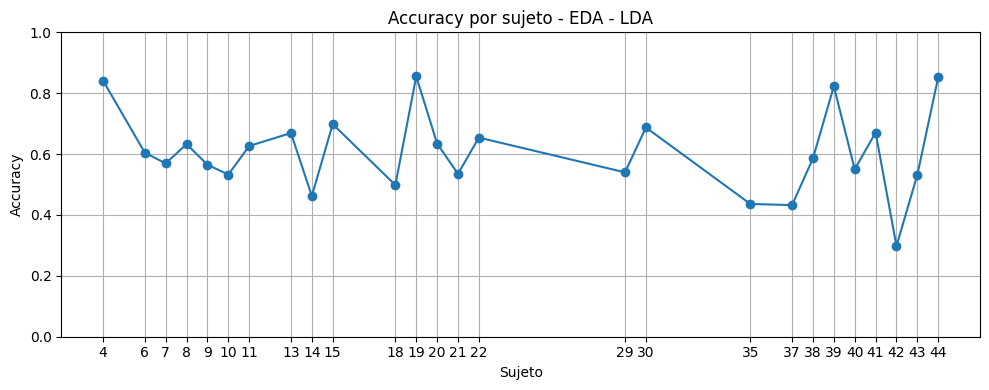

EDA - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.607458  EDA - LDA
1  Precision  0.606667  EDA - LDA
2     Recall  0.607458  EDA - LDA
3   F1 Score  0.606956  EDA - LDA
[EDA - LDA] Best Params: {'solver': 'svd'}
[EDA - LDA] Accuracy: 0.6075
EDA - LDA - Confusion Matrix
[[40637 32221]
 [30115 55828]]


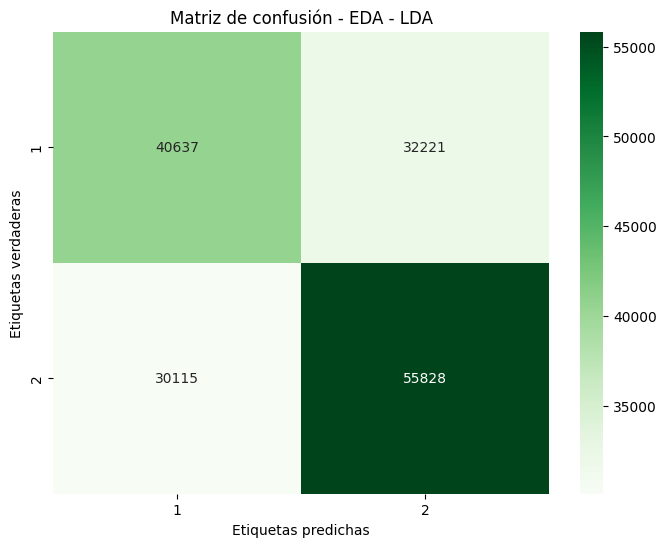

              precision    recall  f1-score   support

           1       0.57      0.56      0.57     72858
           2       0.63      0.65      0.64     85943

    accuracy                           0.61    158801
   macro avg       0.60      0.60      0.60    158801
weighted avg       0.61      0.61      0.61    158801

Training KNN model for EDA using LOGO...
[EDA - KNN] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 8 candidates, totalling 208 fits
[EDA - KNN] Fold 1/26 (Subject: 4)
[EDA - KNN] Fold 2/26 (Subject: 6)
[EDA - KNN] Fold 3/26 (Subject: 7)
[EDA - KNN] Fold 4/26 (Subject: 8)
[EDA - KNN] Fold 5/26 (Subject: 9)
[EDA - KNN] Fold 6/26 (Subject: 10)
[EDA - KNN] Fold 7/26 (Subject: 11)
[EDA - KNN] Fold 8/26 (Subject: 13)
[EDA - KNN] Fold 9/26 (Subject: 14)
[EDA - KNN] Fold 10/26 (Subject: 15)
[EDA - KNN] Fold 11/26 (Subject: 18)
[EDA - KNN] Fold 12/26 (Subject: 19)
[EDA - KNN] Fold 13/26 (Subject: 20)
[EDA - KNN] Fold 14/26 (Subject: 21)
[EDA - KNN] Fold 15/26 (

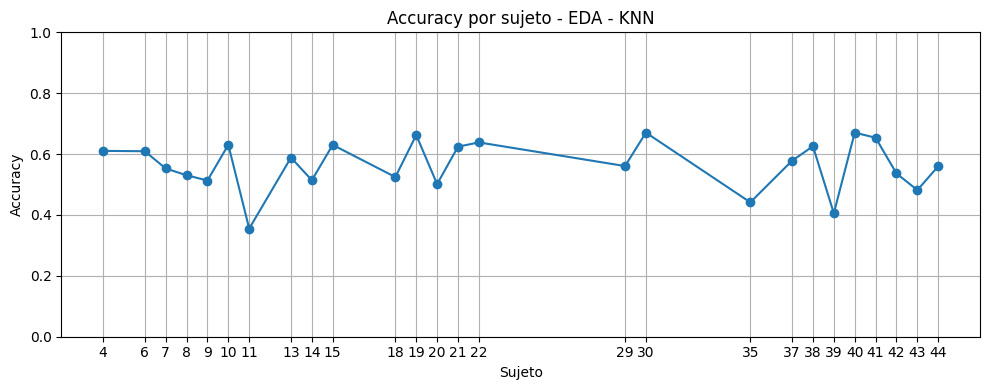

EDA - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.564058  EDA - KNN
1  Precision  0.565276  EDA - KNN
2     Recall  0.564058  EDA - KNN
3   F1 Score  0.564523  EDA - KNN
[EDA - KNN] Best Params: {'n_neighbors': 9, 'weights': 'uniform'}
[EDA - KNN] Accuracy: 0.5641
EDA - KNN - Confusion Matrix
[[39514 33344]
 [35884 50059]]


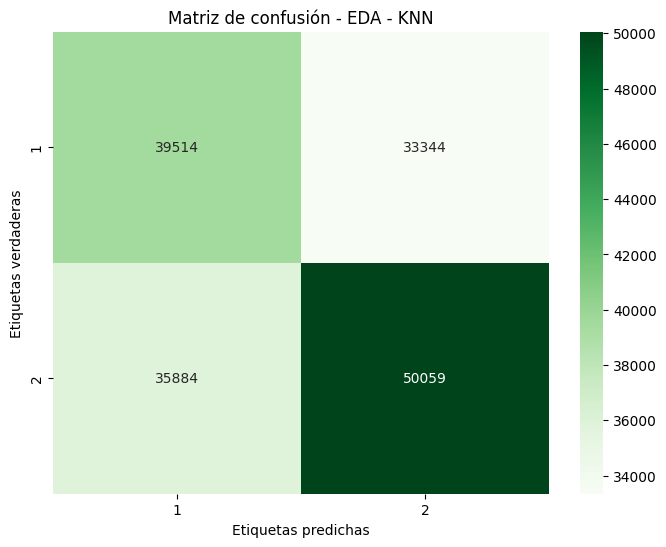

Training by signal:  75%|███████▌  | 3/4 [37:48:37<12:10:26, 43826.73s/it]

              precision    recall  f1-score   support

           1       0.52      0.54      0.53     72858
           2       0.60      0.58      0.59     85943

    accuracy                           0.56    158801
   macro avg       0.56      0.56      0.56    158801
weighted avg       0.57      0.56      0.56    158801

Training DecisionTree model for RESP using LOGO...
[RESP - DecisionTree] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 120 candidates, totalling 3120 fits
[RESP - DecisionTree] Fold 1/26 (Subject: 4)
[RESP - DecisionTree] Fold 2/26 (Subject: 6)
[RESP - DecisionTree] Fold 3/26 (Subject: 7)
[RESP - DecisionTree] Fold 4/26 (Subject: 8)
[RESP - DecisionTree] Fold 5/26 (Subject: 9)
[RESP - DecisionTree] Fold 6/26 (Subject: 10)
[RESP - DecisionTree] Fold 7/26 (Subject: 11)
[RESP - DecisionTree] Fold 8/26 (Subject: 13)
[RESP - DecisionTree] Fold 9/26 (Subject: 14)
[RESP - DecisionTree] Fold 10/26 (Subject: 15)
[RESP - DecisionTree] Fold 11/26 (Subject: 18)
[R

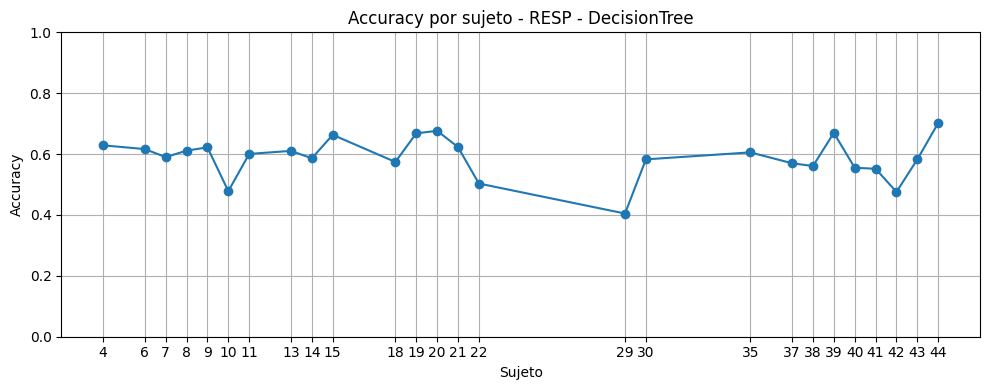

RESP - DecisionTree Metrics
     Métrica     Valor                Etapa
0   Accuracy  0.589335  RESP - DecisionTree
1  Precision  0.587382  RESP - DecisionTree
2     Recall  0.589335  RESP - DecisionTree
3   F1 Score  0.587658  RESP - DecisionTree
[RESP - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 30, 'min_samples_split': 2}
[RESP - DecisionTree] Accuracy: 0.5893
RESP - DecisionTree - Confusion Matrix
[[37514 35344]
 [29870 56073]]


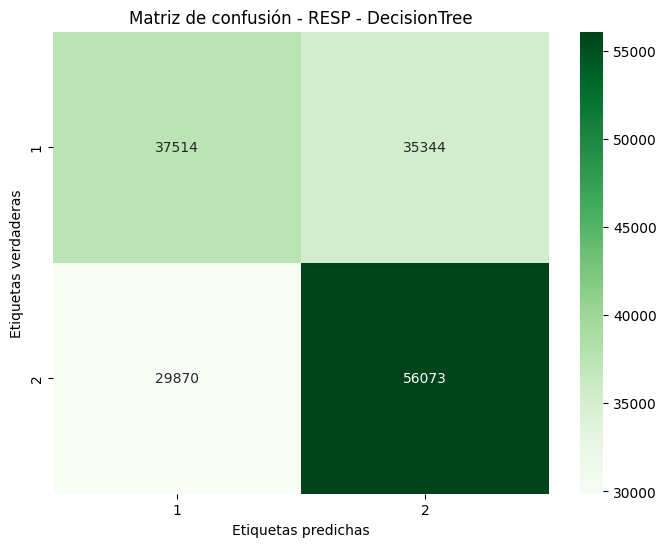

              precision    recall  f1-score   support

           1       0.56      0.51      0.53     72858
           2       0.61      0.65      0.63     85943

    accuracy                           0.59    158801
   macro avg       0.59      0.58      0.58    158801
weighted avg       0.59      0.59      0.59    158801

Training RandomForest model for RESP using LOGO...
[RESP - RandomForest] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 72 candidates, totalling 1872 fits
[RESP - RandomForest] Fold 1/26 (Subject: 4)
[RESP - RandomForest] Fold 2/26 (Subject: 6)
[RESP - RandomForest] Fold 3/26 (Subject: 7)
[RESP - RandomForest] Fold 4/26 (Subject: 8)
[RESP - RandomForest] Fold 5/26 (Subject: 9)
[RESP - RandomForest] Fold 6/26 (Subject: 10)
[RESP - RandomForest] Fold 7/26 (Subject: 11)
[RESP - RandomForest] Fold 8/26 (Subject: 13)
[RESP - RandomForest] Fold 9/26 (Subject: 14)
[RESP - RandomForest] Fold 10/26 (Subject: 15)
[RESP - RandomForest] Fold 11/26 (Subject: 18)
[RE

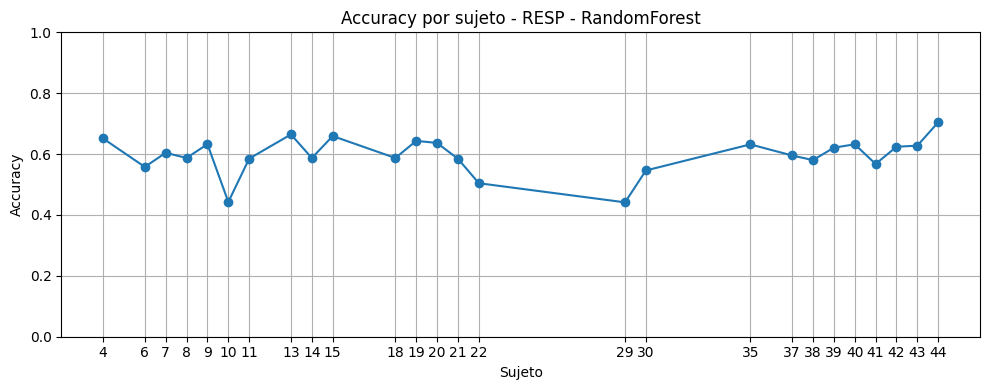

RESP - RandomForest Metrics
     Métrica     Valor                Etapa
0   Accuracy  0.596514  RESP - RandomForest
1  Precision  0.599445  RESP - RandomForest
2     Recall  0.596514  RESP - RandomForest
3   F1 Score  0.597191  RESP - RandomForest
[RESP - RandomForest] Best Params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
[RESP - RandomForest] Accuracy: 0.5965
RESP - RandomForest - Confusion Matrix
[[43710 29148]
 [34926 51017]]


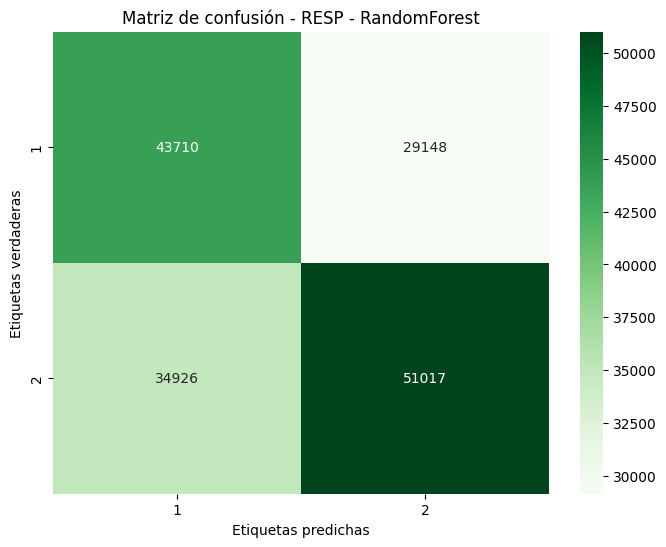

              precision    recall  f1-score   support

           1       0.56      0.60      0.58     72858
           2       0.64      0.59      0.61     85943

    accuracy                           0.60    158801
   macro avg       0.60      0.60      0.60    158801
weighted avg       0.60      0.60      0.60    158801

Training AdaBoost model for RESP using LOGO...
[RESP - AdaBoost] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 32 candidates, totalling 832 fits
[RESP - AdaBoost] Fold 1/26 (Subject: 4)
[RESP - AdaBoost] Fold 2/26 (Subject: 6)
[RESP - AdaBoost] Fold 3/26 (Subject: 7)
[RESP - AdaBoost] Fold 4/26 (Subject: 8)
[RESP - AdaBoost] Fold 5/26 (Subject: 9)
[RESP - AdaBoost] Fold 6/26 (Subject: 10)
[RESP - AdaBoost] Fold 7/26 (Subject: 11)
[RESP - AdaBoost] Fold 8/26 (Subject: 13)
[RESP - AdaBoost] Fold 9/26 (Subject: 14)
[RESP - AdaBoost] Fold 10/26 (Subject: 15)
[RESP - AdaBoost] Fold 11/26 (Subject: 18)
[RESP - AdaBoost] Fold 12/26 (Subject: 19)
[RESP - AdaBo

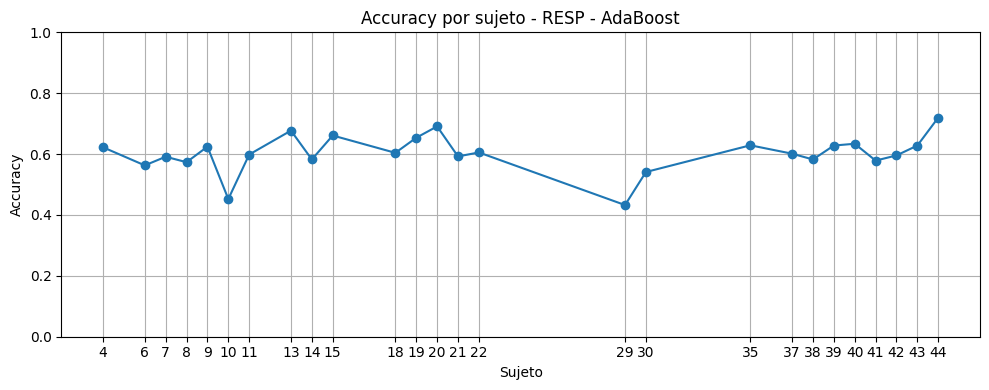

RESP - AdaBoost Metrics
     Métrica     Valor            Etapa
0   Accuracy  0.602830  RESP - AdaBoost
1  Precision  0.606403  RESP - AdaBoost
2     Recall  0.602830  RESP - AdaBoost
3   F1 Score  0.603504  RESP - AdaBoost
[RESP - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=1), 'learning_rate': 0.1, 'n_estimators': 50}
[RESP - AdaBoost] Accuracy: 0.6028
RESP - AdaBoost - Confusion Matrix
[[44735 28123]
 [34948 50995]]


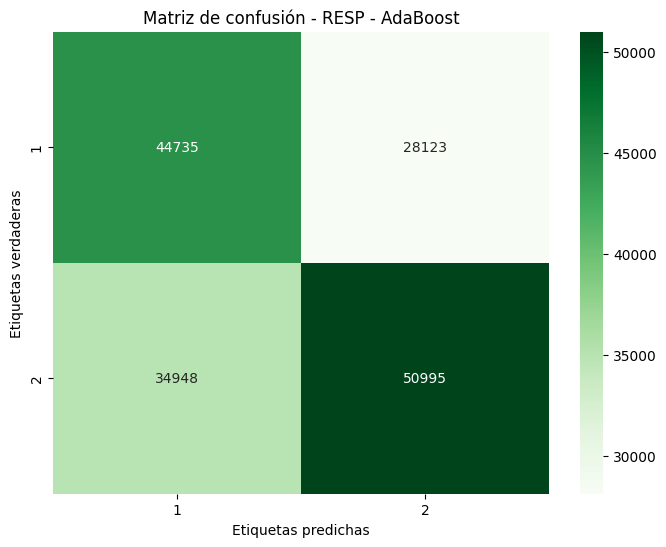

              precision    recall  f1-score   support

           1       0.56      0.61      0.59     72858
           2       0.64      0.59      0.62     85943

    accuracy                           0.60    158801
   macro avg       0.60      0.60      0.60    158801
weighted avg       0.61      0.60      0.60    158801

Training LDA model for RESP using LOGO...
[RESP - LDA] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 1 candidates, totalling 26 fits
[RESP - LDA] Fold 1/26 (Subject: 4)
[RESP - LDA] Fold 2/26 (Subject: 6)
[RESP - LDA] Fold 3/26 (Subject: 7)
[RESP - LDA] Fold 4/26 (Subject: 8)
[RESP - LDA] Fold 5/26 (Subject: 9)
[RESP - LDA] Fold 6/26 (Subject: 10)
[RESP - LDA] Fold 7/26 (Subject: 11)
[RESP - LDA] Fold 8/26 (Subject: 13)
[RESP - LDA] Fold 9/26 (Subject: 14)
[RESP - LDA] Fold 10/26 (Subject: 15)
[RESP - LDA] Fold 11/26 (Subject: 18)
[RESP - LDA] Fold 12/26 (Subject: 19)
[RESP - LDA] Fold 13/26 (Subject: 20)
[RESP - LDA] Fold 14/26 (Subject: 21)
[RESP - L

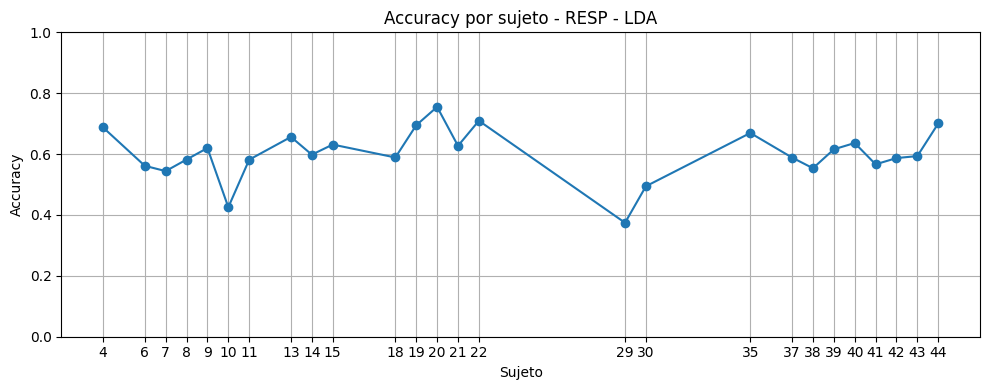

RESP - LDA Metrics
     Métrica     Valor       Etapa
0   Accuracy  0.602194  RESP - LDA
1  Precision  0.599905  RESP - LDA
2     Recall  0.602194  RESP - LDA
3   F1 Score  0.599631  RESP - LDA
[RESP - LDA] Best Params: {'solver': 'svd'}
[RESP - LDA] Accuracy: 0.6022
RESP - LDA - Confusion Matrix
[[37428 35430]
 [27742 58201]]


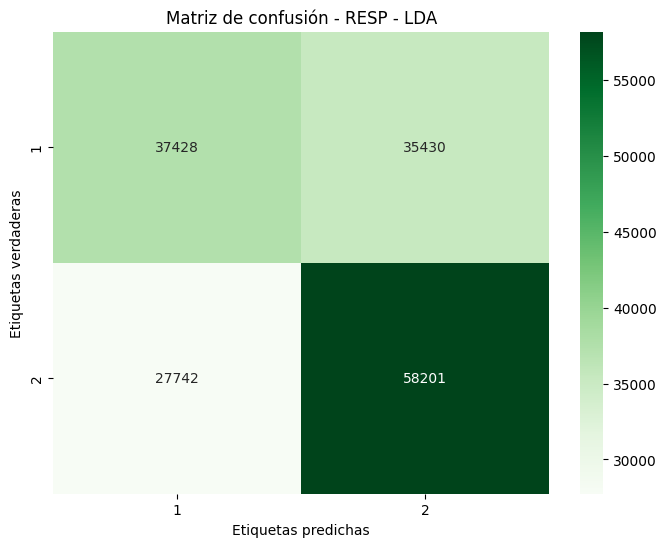

              precision    recall  f1-score   support

           1       0.57      0.51      0.54     72858
           2       0.62      0.68      0.65     85943

    accuracy                           0.60    158801
   macro avg       0.60      0.60      0.60    158801
weighted avg       0.60      0.60      0.60    158801

Training KNN model for RESP using LOGO...
[RESP - KNN] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 8 candidates, totalling 208 fits
[RESP - KNN] Fold 1/26 (Subject: 4)
[RESP - KNN] Fold 2/26 (Subject: 6)
[RESP - KNN] Fold 3/26 (Subject: 7)
[RESP - KNN] Fold 4/26 (Subject: 8)
[RESP - KNN] Fold 5/26 (Subject: 9)
[RESP - KNN] Fold 6/26 (Subject: 10)
[RESP - KNN] Fold 7/26 (Subject: 11)
[RESP - KNN] Fold 8/26 (Subject: 13)
[RESP - KNN] Fold 9/26 (Subject: 14)
[RESP - KNN] Fold 10/26 (Subject: 15)
[RESP - KNN] Fold 11/26 (Subject: 18)
[RESP - KNN] Fold 12/26 (Subject: 19)
[RESP - KNN] Fold 13/26 (Subject: 20)
[RESP - KNN] Fold 14/26 (Subject: 21)
[RESP - 

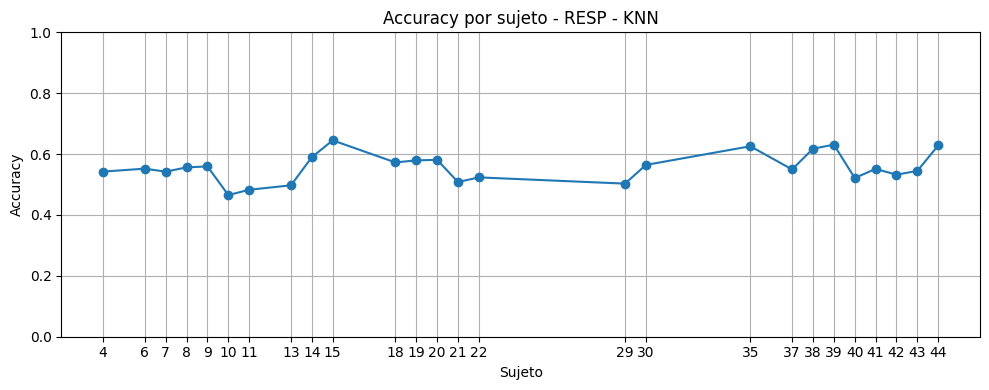

RESP - KNN Metrics
     Métrica     Valor       Etapa
0   Accuracy  0.556911  RESP - KNN
1  Precision  0.554357  RESP - KNN
2     Recall  0.556911  RESP - KNN
3   F1 Score  0.554799  RESP - KNN
[RESP - KNN] Best Params: {'n_neighbors': 9, 'weights': 'uniform'}
[RESP - KNN] Accuracy: 0.5569
RESP - KNN - Confusion Matrix
[[34599 38259]
 [32104 53839]]


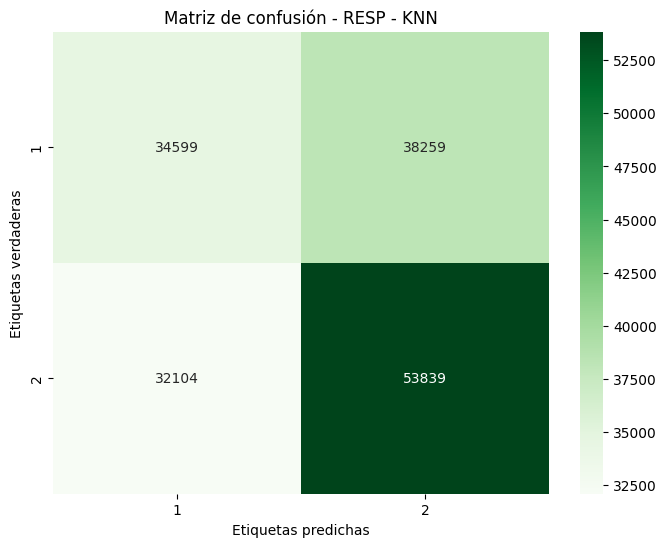

Training by signal: 100%|██████████| 4/4 [46:19:25<00:00, 41691.45s/it]   


              precision    recall  f1-score   support

           1       0.52      0.47      0.50     72858
           2       0.58      0.63      0.60     85943

    accuracy                           0.56    158801
   macro avg       0.55      0.55      0.55    158801
weighted avg       0.55      0.56      0.55    158801



Training with ALL signals:   0%|          | 0/5 [00:00<?, ?it/s]

Training DecisionTree model for ALL signals using LOGO...
[ALL - DecisionTree] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 120 candidates, totalling 3120 fits
[ALL - DecisionTree] Fold 1/26 (Subject: 4)
[ALL - DecisionTree] Fold 2/26 (Subject: 6)
[ALL - DecisionTree] Fold 3/26 (Subject: 7)
[ALL - DecisionTree] Fold 4/26 (Subject: 8)
[ALL - DecisionTree] Fold 5/26 (Subject: 9)
[ALL - DecisionTree] Fold 6/26 (Subject: 10)
[ALL - DecisionTree] Fold 7/26 (Subject: 11)
[ALL - DecisionTree] Fold 8/26 (Subject: 13)
[ALL - DecisionTree] Fold 9/26 (Subject: 14)
[ALL - DecisionTree] Fold 10/26 (Subject: 15)
[ALL - DecisionTree] Fold 11/26 (Subject: 18)
[ALL - DecisionTree] Fold 12/26 (Subject: 19)
[ALL - DecisionTree] Fold 13/26 (Subject: 20)
[ALL - DecisionTree] Fold 14/26 (Subject: 21)
[ALL - DecisionTree] Fold 15/26 (Subject: 22)
[ALL - DecisionTree] Fold 16/26 (Subject: 29)
[ALL - DecisionTree] Fold 17/26 (Subject: 30)
[ALL - DecisionTree] Fold 18/26 (Subject: 35)
[ALL - Decis

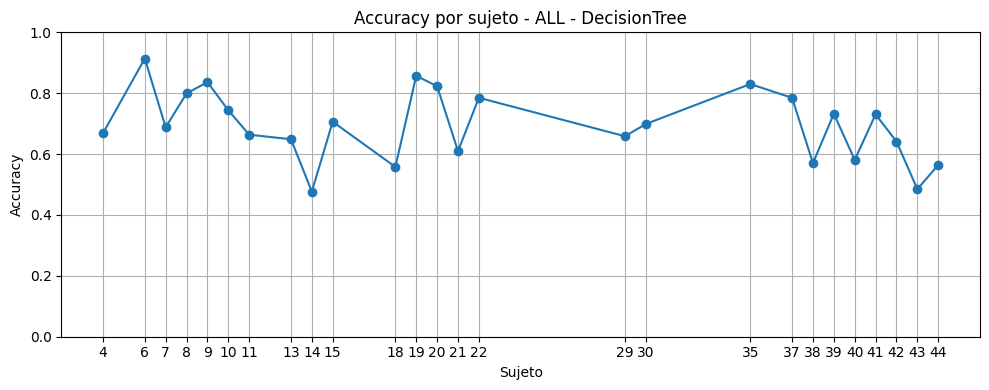

ALL - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.694492  ALL - DecisionTree
1  Precision  0.695506  ALL - DecisionTree
2     Recall  0.694492  ALL - DecisionTree
3   F1 Score  0.694819  ALL - DecisionTree
[ALL - DecisionTree] Best Params: {'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': 30, 'min_samples_split': 2}
[ALL - DecisionTree] Accuracy: 0.6945
ALL - DecisionTree - Confusion Matrix
[[49878 22980]
 [25535 60408]]


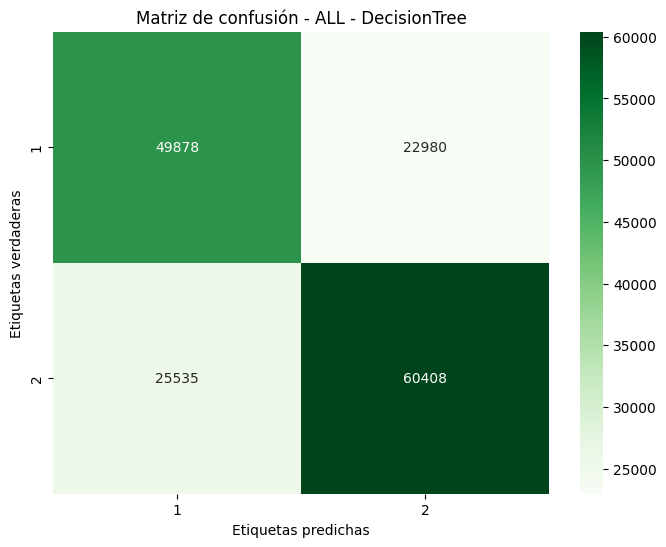

Training with ALL signals:  20%|██        | 1/5 [1:25:12<5:40:48, 5112.07s/it]

              precision    recall  f1-score   support

           1       0.66      0.68      0.67     72858
           2       0.72      0.70      0.71     85943

    accuracy                           0.69    158801
   macro avg       0.69      0.69      0.69    158801
weighted avg       0.70      0.69      0.69    158801

Training RandomForest model for ALL signals using LOGO...
[ALL - RandomForest] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 72 candidates, totalling 1872 fits
[ALL - RandomForest] Fold 1/26 (Subject: 4)
[ALL - RandomForest] Fold 2/26 (Subject: 6)
[ALL - RandomForest] Fold 3/26 (Subject: 7)
[ALL - RandomForest] Fold 4/26 (Subject: 8)
[ALL - RandomForest] Fold 5/26 (Subject: 9)
[ALL - RandomForest] Fold 6/26 (Subject: 10)
[ALL - RandomForest] Fold 7/26 (Subject: 11)
[ALL - RandomForest] Fold 8/26 (Subject: 13)
[ALL - RandomForest] Fold 9/26 (Subject: 14)
[ALL - RandomForest] Fold 10/26 (Subject: 15)
[ALL - RandomForest] Fold 11/26 (Subject: 18)
[ALL - R

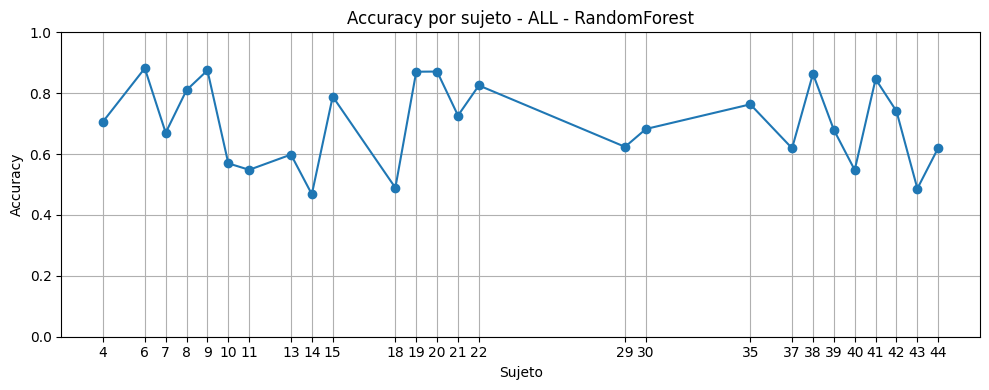

ALL - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.699756  ALL - RandomForest
1  Precision  0.699066  ALL - RandomForest
2     Recall  0.699756  ALL - RandomForest
3   F1 Score  0.698170  ALL - RandomForest
[ALL - RandomForest] Best Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
[ALL - RandomForest] Accuracy: 0.6998
ALL - RandomForest - Confusion Matrix
[[45695 27163]
 [20516 65427]]


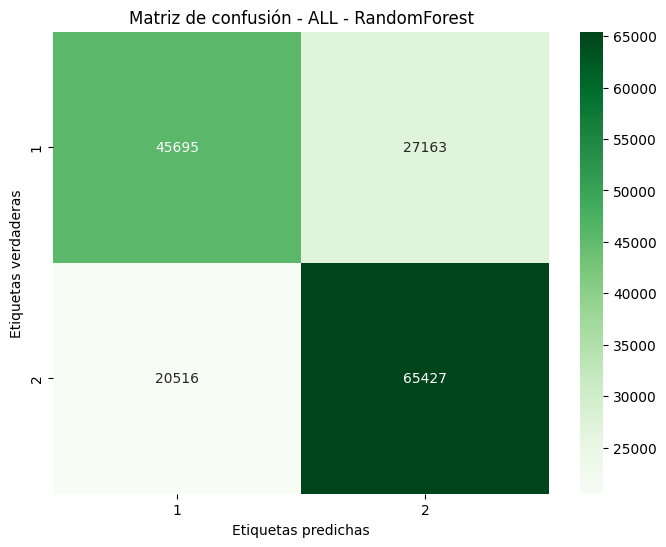

Training with ALL signals:  40%|████      | 2/5 [17:03:27<29:21:00, 35220.11s/it]

              precision    recall  f1-score   support

           1       0.69      0.63      0.66     72858
           2       0.71      0.76      0.73     85943

    accuracy                           0.70    158801
   macro avg       0.70      0.69      0.70    158801
weighted avg       0.70      0.70      0.70    158801

Training AdaBoost model for ALL signals using LOGO...
[ALL - AdaBoost] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 32 candidates, totalling 832 fits
[ALL - AdaBoost] Fold 1/26 (Subject: 4)
[ALL - AdaBoost] Fold 2/26 (Subject: 6)
[ALL - AdaBoost] Fold 3/26 (Subject: 7)
[ALL - AdaBoost] Fold 4/26 (Subject: 8)
[ALL - AdaBoost] Fold 5/26 (Subject: 9)
[ALL - AdaBoost] Fold 6/26 (Subject: 10)
[ALL - AdaBoost] Fold 7/26 (Subject: 11)
[ALL - AdaBoost] Fold 8/26 (Subject: 13)
[ALL - AdaBoost] Fold 9/26 (Subject: 14)
[ALL - AdaBoost] Fold 10/26 (Subject: 15)
[ALL - AdaBoost] Fold 11/26 (Subject: 18)
[ALL - AdaBoost] Fold 12/26 (Subject: 19)
[ALL - AdaBoost] Fo

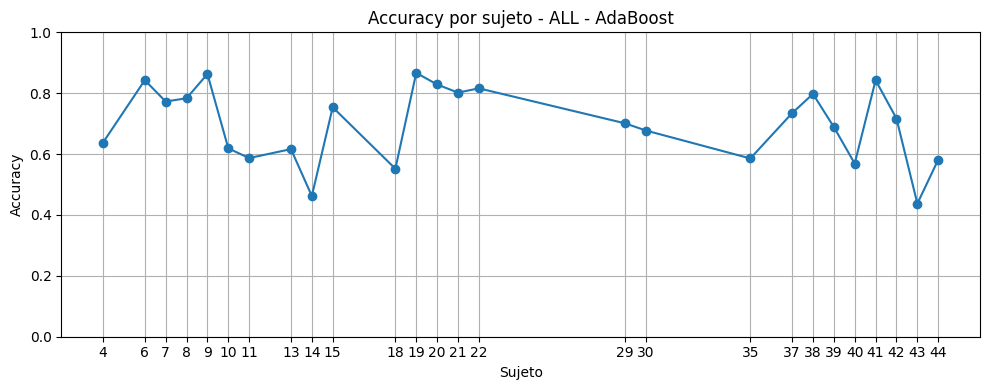

ALL - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.697685  ALL - AdaBoost
1  Precision  0.696957  ALL - AdaBoost
2     Recall  0.697685  ALL - AdaBoost
3   F1 Score  0.696977  ALL - AdaBoost
[ALL - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 0.01, 'n_estimators': 300}
[ALL - AdaBoost] Accuracy: 0.6977
ALL - AdaBoost - Confusion Matrix
[[47096 25762]
 [22246 63697]]


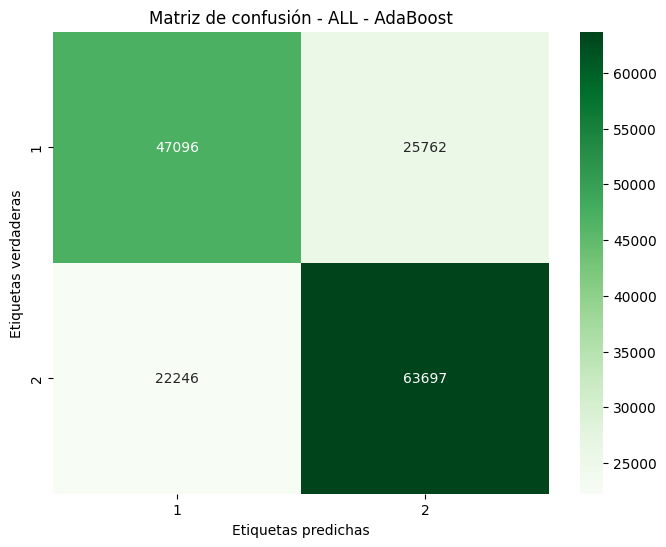

Training with ALL signals:  60%|██████    | 3/5 [38:39:32<30:21:33, 54646.98s/it]

              precision    recall  f1-score   support

           1       0.68      0.65      0.66     72858
           2       0.71      0.74      0.73     85943

    accuracy                           0.70    158801
   macro avg       0.70      0.69      0.69    158801
weighted avg       0.70      0.70      0.70    158801

Training LDA model for ALL signals using LOGO...
[ALL - LDA] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 1 candidates, totalling 26 fits
[ALL - LDA] Fold 1/26 (Subject: 4)
[ALL - LDA] Fold 2/26 (Subject: 6)
[ALL - LDA] Fold 3/26 (Subject: 7)
[ALL - LDA] Fold 4/26 (Subject: 8)
[ALL - LDA] Fold 5/26 (Subject: 9)
[ALL - LDA] Fold 6/26 (Subject: 10)
[ALL - LDA] Fold 7/26 (Subject: 11)
[ALL - LDA] Fold 8/26 (Subject: 13)
[ALL - LDA] Fold 9/26 (Subject: 14)
[ALL - LDA] Fold 10/26 (Subject: 15)
[ALL - LDA] Fold 11/26 (Subject: 18)
[ALL - LDA] Fold 12/26 (Subject: 19)
[ALL - LDA] Fold 13/26 (Subject: 20)
[ALL - LDA] Fold 14/26 (Subject: 21)
[ALL - LDA] Fold 

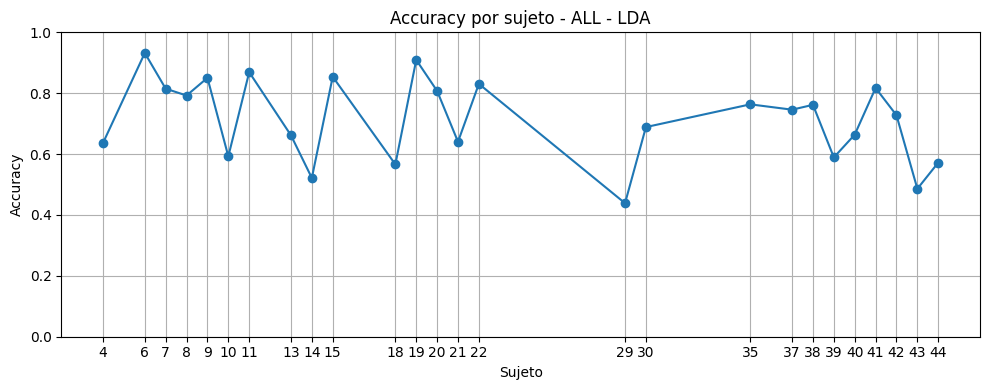

ALL - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.713604  ALL - LDA
1  Precision  0.715523  ALL - LDA
2     Recall  0.713604  ALL - LDA
3   F1 Score  0.709692  ALL - LDA
[ALL - LDA] Best Params: {'solver': 'svd'}
[ALL - LDA] Accuracy: 0.7136
ALL - LDA - Confusion Matrix
[[43668 29190]
 [16290 69653]]


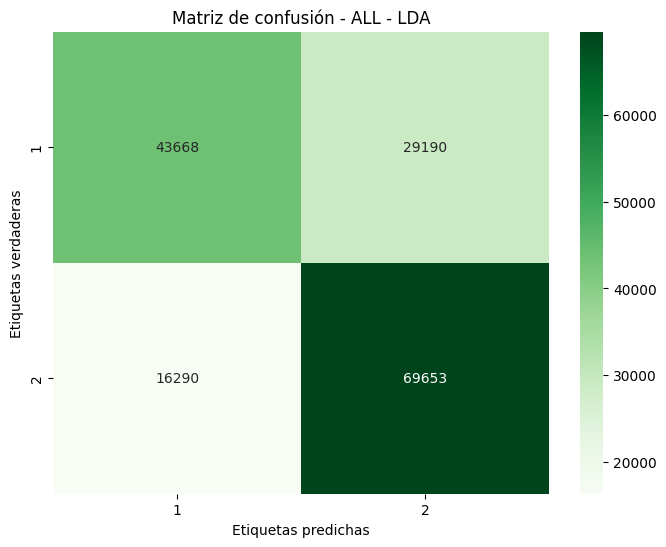

Training with ALL signals:  80%|████████  | 4/5 [38:40:02<9:11:24, 33084.72s/it] 

              precision    recall  f1-score   support

           1       0.73      0.60      0.66     72858
           2       0.70      0.81      0.75     85943

    accuracy                           0.71    158801
   macro avg       0.72      0.70      0.71    158801
weighted avg       0.72      0.71      0.71    158801

Training KNN model for ALL signals using LOGO...
[ALL - KNN] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 8 candidates, totalling 208 fits
[ALL - KNN] Fold 1/26 (Subject: 4)
[ALL - KNN] Fold 2/26 (Subject: 6)
[ALL - KNN] Fold 3/26 (Subject: 7)
[ALL - KNN] Fold 4/26 (Subject: 8)
[ALL - KNN] Fold 5/26 (Subject: 9)
[ALL - KNN] Fold 6/26 (Subject: 10)
[ALL - KNN] Fold 7/26 (Subject: 11)
[ALL - KNN] Fold 8/26 (Subject: 13)
[ALL - KNN] Fold 9/26 (Subject: 14)
[ALL - KNN] Fold 10/26 (Subject: 15)
[ALL - KNN] Fold 11/26 (Subject: 18)
[ALL - KNN] Fold 12/26 (Subject: 19)
[ALL - KNN] Fold 13/26 (Subject: 20)
[ALL - KNN] Fold 14/26 (Subject: 21)
[ALL - KNN] Fold

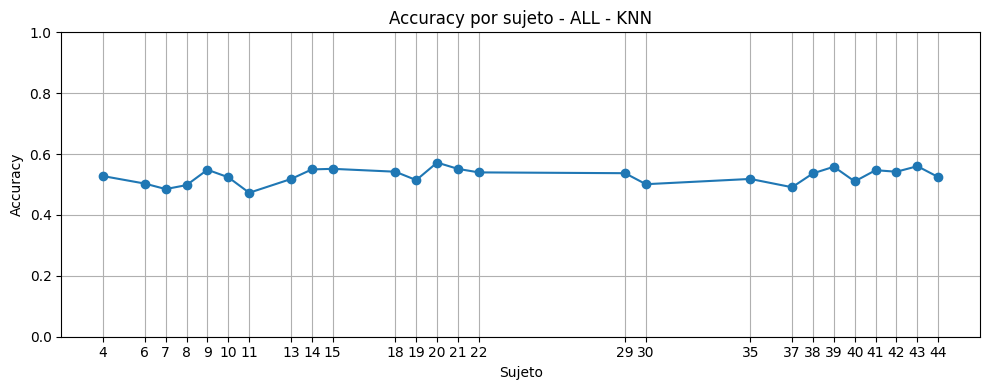

ALL - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.527969  ALL - KNN
1  Precision  0.524473  ALL - KNN
2     Recall  0.527969  ALL - KNN
3   F1 Score  0.525077  ALL - KNN
[ALL - KNN] Best Params: {'n_neighbors': 9, 'weights': 'uniform'}
[ALL - KNN] Accuracy: 0.5280
ALL - KNN - Confusion Matrix
[[31672 41186]
 [33773 52170]]


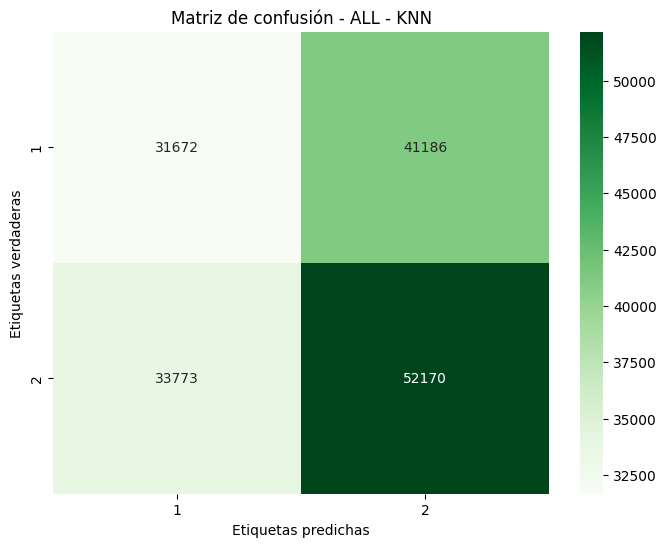

Training with ALL signals: 100%|██████████| 5/5 [38:42:13<00:00, 27866.74s/it]  

              precision    recall  f1-score   support

           1       0.48      0.43      0.46     72858
           2       0.56      0.61      0.58     85943

    accuracy                           0.53    158801
   macro avg       0.52      0.52      0.52    158801
weighted avg       0.52      0.53      0.53    158801


Final Comparison:
ECG - DecisionTree:
     Métrica     Valor               Etapa
0   Accuracy  0.553479  ECG - DecisionTree
1  Precision  0.553305  ECG - DecisionTree
2     Recall  0.553479  ECG - DecisionTree
3   F1 Score  0.553389  ECG - DecisionTree
ECG - RandomForest:
     Métrica     Valor               Etapa
0   Accuracy  0.563535  ECG - RandomForest
1  Precision  0.563229  ECG - RandomForest
2     Recall  0.563535  ECG - RandomForest
3   F1 Score  0.563372  ECG - RandomForest
ECG - AdaBoost:
     Métrica     Valor           Etapa
0   Accuracy  0.566810  ECG - AdaBoost
1  Precision  0.565891  ECG - AdaBoost
2     Recall  0.566810  ECG - AdaBoost
3   F1 Score

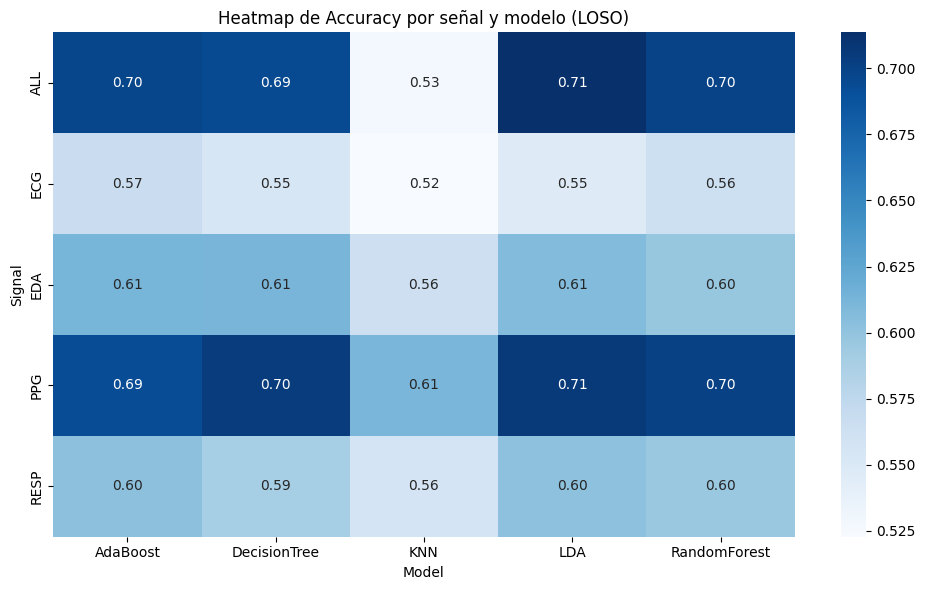

c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  func(*plot_args, **plot_kwargs)
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  func(*plot_args, **plot_kwargs)
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  func(*plot_args, **plot_kwargs)
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  func(*plot_args, **plot_kwargs)
C:\Users\Gustavo\AppData\Local\Temp\ipykernel_21548\1711118399.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xti

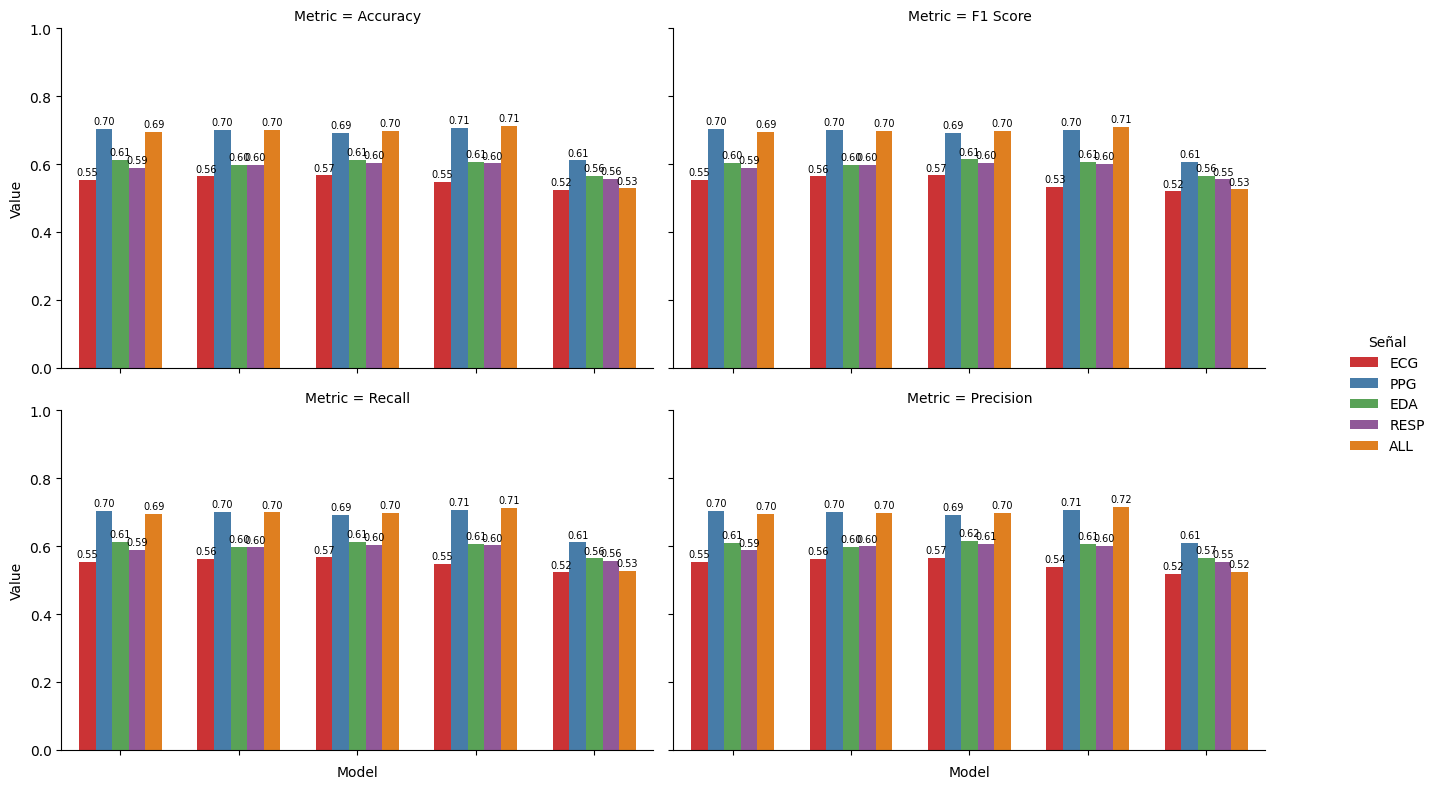

In [ ]:
for signal, features in tqdm(SIGNAL_CATEGORIES.items(), desc="Training by signal"):
    if all(f in df.columns for f in features):  # Verificar que todas las columnas existen
        X = df[features].values  # Convertimos a array
        y = df['label'].values
        subjects = df['subject'].values  # Identificador de sujetos

        for model_name, (model, param_grid) in models.items():
            print(f'Training {model_name} model for {signal} using LOGO...')
            metrics = train_and_evaluate_logo(X, y, subjects, model, param_grid, model_name, signal)
            results[(signal, model_name)] = metrics.copy()

# Entrenamiento con todas las señales combinadas usando LOGO
X_all = df.drop(columns=['label', 'subject']).values
y_all = df['label'].values
subjects_all = df['subject'].values

for model_name, (model, param_grid) in tqdm(models.items(), desc="Training with ALL signals"):
    print(f'Training {model_name} model for ALL signals using LOGO...')
    metrics = train_and_evaluate_logo(X_all, y_all, subjects_all, model, param_grid, model_name, "ALL")
    results[("ALL", model_name)] = metrics.copy()

# Mostrar resultados finales
print("\nFinal Comparison:")
for (signal, model_name), acc in results.items():
    print(f'{signal} - {model_name}:')
    print(acc)

# Crear heatmap
rows = []
for (signal, model), df_metrics in results.items():
    metric_values = df_metrics.set_index('Métrica')['Valor']
    
    row = {
        'Signal': signal,
        'Model': model,
        'Accuracy': metric_values.get('Accuracy', None),
        'F1': metric_values.get('F1 Score', None),
        'Precision': metric_values.get('Precision', None),
        'Recall': metric_values.get('Recall', None)
    }
    rows.append(row)

metrics_df = pd.DataFrame(rows)

pivot_df = metrics_df.pivot(index='Signal', columns='Model', values='Accuracy')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, cmap="Blues", fmt=".2f")
plt.title('Heatmap de Accuracy por señal y modelo (LOSO)')
plt.tight_layout()
plt.show()


data = []
metrics = ["Accuracy", "F1 Score", "Recall", "Precision"]

for (signal, model), df in results.items():
    for metric in metrics:
        row = df[df["Métrica"] == metric]
        if not row.empty:
            value = row["Valor"].values[0]
            data.append((signal, model, metric, value))

df_all = pd.DataFrame(data, columns=["Signal", "Model", "Metric", "Value"])

# Paleta bonita
palette = sns.color_palette("Set1")

# Hacer el FacetGrid
g = sns.FacetGrid(df_all, col="Metric", sharey=True, col_wrap=2, height=4, aspect=1.5)
g.map_dataframe(sns.barplot, x="Model", y="Value", hue="Signal", palette=palette, width=0.7, dodge=True)  # <-- aquí el width más pequeño

# Ajustes para la leyenda
g.add_legend(title="Señal", bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0)

# Añadir etiquetas de valores
for ax in g.axes.flatten():
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=7, padding=2)
    ax.set_ylim(0, 1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

Training by signal combinations:   0%|          | 0/11 [00:00<?, ?it/s]

Training DecisionTree model for ('ECG', 'PPG') using LOSO...
[('ECG', 'PPG') - DecisionTree] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 120 candidates, totalling 3120 fits
[('ECG', 'PPG') - DecisionTree] Fold 1/26 (Subject: 4)
[('ECG', 'PPG') - DecisionTree] Fold 2/26 (Subject: 6)
[('ECG', 'PPG') - DecisionTree] Fold 3/26 (Subject: 7)
[('ECG', 'PPG') - DecisionTree] Fold 4/26 (Subject: 8)
[('ECG', 'PPG') - DecisionTree] Fold 5/26 (Subject: 9)
[('ECG', 'PPG') - DecisionTree] Fold 6/26 (Subject: 10)
[('ECG', 'PPG') - DecisionTree] Fold 7/26 (Subject: 11)
[('ECG', 'PPG') - DecisionTree] Fold 8/26 (Subject: 13)
[('ECG', 'PPG') - DecisionTree] Fold 9/26 (Subject: 14)
[('ECG', 'PPG') - DecisionTree] Fold 10/26 (Subject: 15)
[('ECG', 'PPG') - DecisionTree] Fold 11/26 (Subject: 18)
[('ECG', 'PPG') - DecisionTree] Fold 12/26 (Subject: 19)
[('ECG', 'PPG') - DecisionTree] Fold 13/26 (Subject: 20)
[('ECG', 'PPG') - DecisionTree] Fold 14/26 (Subject: 21)
[('ECG', 'PPG') - DecisionTr

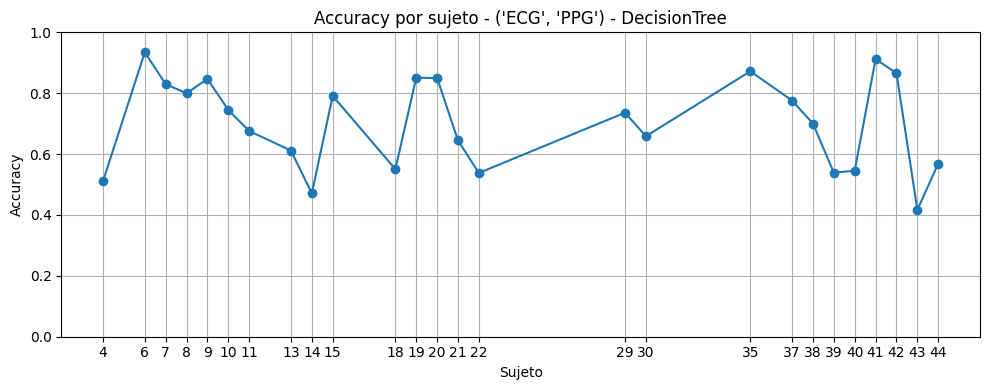

('ECG', 'PPG') - DecisionTree Metrics
     Métrica     Valor                          Etapa
0   Accuracy  0.702256  ('ECG', 'PPG') - DecisionTree
1  Precision  0.701612  ('ECG', 'PPG') - DecisionTree
2     Recall  0.702256  ('ECG', 'PPG') - DecisionTree
3   F1 Score  0.701687  ('ECG', 'PPG') - DecisionTree
[('ECG', 'PPG') - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 10, 'min_samples_split': 2}
[('ECG', 'PPG') - DecisionTree] Accuracy: 0.7023
('ECG', 'PPG') - DecisionTree - Confusion Matrix
[[47731 25127]
 [22155 63788]]


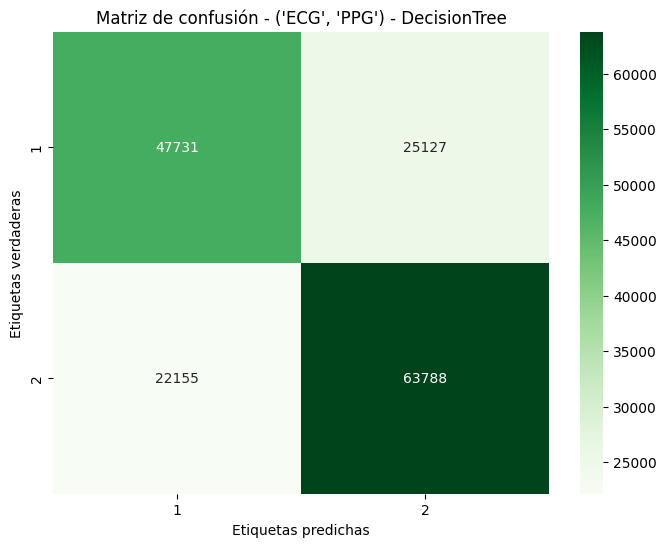

              precision    recall  f1-score   support

           1       0.68      0.66      0.67     72858
           2       0.72      0.74      0.73     85943

    accuracy                           0.70    158801
   macro avg       0.70      0.70      0.70    158801
weighted avg       0.70      0.70      0.70    158801

Training RandomForest model for ('ECG', 'PPG') using LOSO...
[('ECG', 'PPG') - RandomForest] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 72 candidates, totalling 1872 fits
[('ECG', 'PPG') - RandomForest] Fold 1/26 (Subject: 4)
[('ECG', 'PPG') - RandomForest] Fold 2/26 (Subject: 6)
[('ECG', 'PPG') - RandomForest] Fold 3/26 (Subject: 7)
[('ECG', 'PPG') - RandomForest] Fold 4/26 (Subject: 8)
[('ECG', 'PPG') - RandomForest] Fold 5/26 (Subject: 9)
[('ECG', 'PPG') - RandomForest] Fold 6/26 (Subject: 10)
[('ECG', 'PPG') - RandomForest] Fold 7/26 (Subject: 11)
[('ECG', 'PPG') - RandomForest] Fold 8/26 (Subject: 13)
[('ECG', 'PPG') - RandomForest] Fold 9/26 (

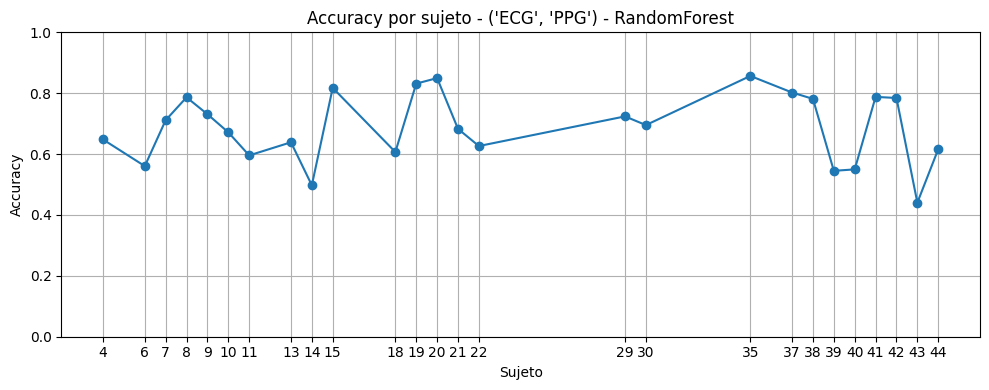

('ECG', 'PPG') - RandomForest Metrics
     Métrica     Valor                          Etapa
0   Accuracy  0.687445  ('ECG', 'PPG') - RandomForest
1  Precision  0.686745  ('ECG', 'PPG') - RandomForest
2     Recall  0.687445  ('ECG', 'PPG') - RandomForest
3   F1 Score  0.686865  ('ECG', 'PPG') - RandomForest
[('ECG', 'PPG') - RandomForest] Best Params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
[('ECG', 'PPG') - RandomForest] Accuracy: 0.6874
('ECG', 'PPG') - RandomForest - Confusion Matrix
[[46591 26267]
 [23367 62576]]


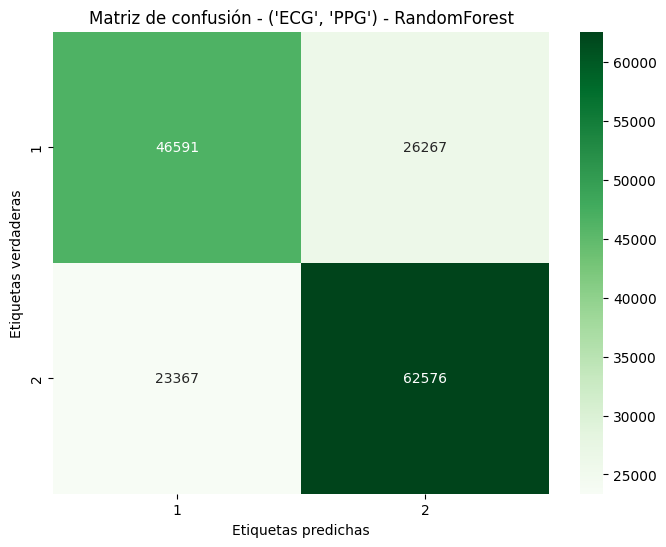

              precision    recall  f1-score   support

           1       0.67      0.64      0.65     72858
           2       0.70      0.73      0.72     85943

    accuracy                           0.69    158801
   macro avg       0.69      0.68      0.68    158801
weighted avg       0.69      0.69      0.69    158801

Training AdaBoost model for ('ECG', 'PPG') using LOSO...
[('ECG', 'PPG') - AdaBoost] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 32 candidates, totalling 832 fits
[('ECG', 'PPG') - AdaBoost] Fold 1/26 (Subject: 4)
[('ECG', 'PPG') - AdaBoost] Fold 2/26 (Subject: 6)
[('ECG', 'PPG') - AdaBoost] Fold 3/26 (Subject: 7)
[('ECG', 'PPG') - AdaBoost] Fold 4/26 (Subject: 8)
[('ECG', 'PPG') - AdaBoost] Fold 5/26 (Subject: 9)
[('ECG', 'PPG') - AdaBoost] Fold 6/26 (Subject: 10)
[('ECG', 'PPG') - AdaBoost] Fold 7/26 (Subject: 11)
[('ECG', 'PPG') - AdaBoost] Fold 8/26 (Subject: 13)
[('ECG', 'PPG') - AdaBoost] Fold 9/26 (Subject: 14)
[('ECG', 'PPG') - AdaBoost] Fold

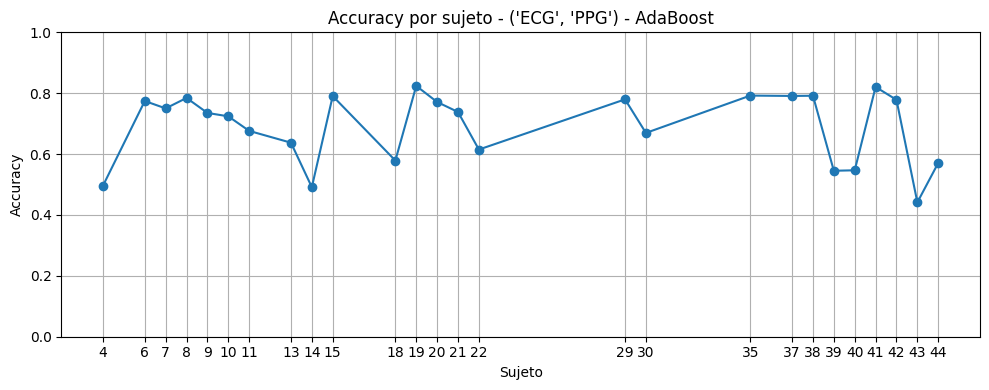

('ECG', 'PPG') - AdaBoost Metrics
     Métrica     Valor                      Etapa
0   Accuracy  0.689907  ('ECG', 'PPG') - AdaBoost
1  Precision  0.689076  ('ECG', 'PPG') - AdaBoost
2     Recall  0.689907  ('ECG', 'PPG') - AdaBoost
3   F1 Score  0.689020  ('ECG', 'PPG') - AdaBoost
[('ECG', 'PPG') - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 0.01, 'n_estimators': 200}
[('ECG', 'PPG') - AdaBoost] Accuracy: 0.6899
('ECG', 'PPG') - AdaBoost - Confusion Matrix
[[46166 26692]
 [22551 63392]]


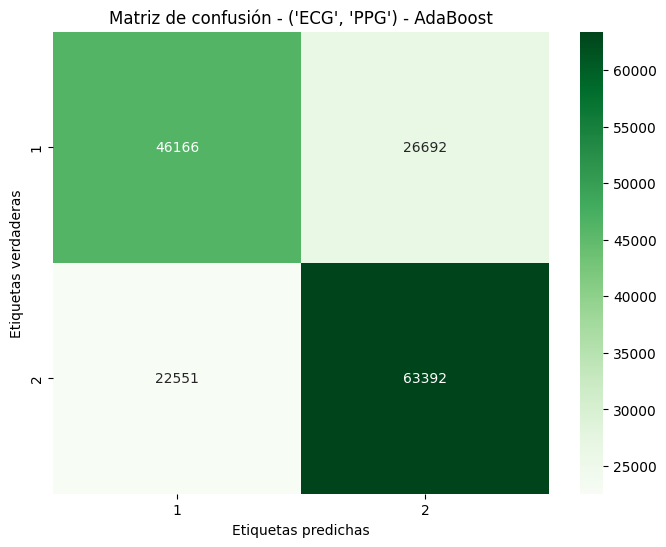

              precision    recall  f1-score   support

           1       0.67      0.63      0.65     72858
           2       0.70      0.74      0.72     85943

    accuracy                           0.69    158801
   macro avg       0.69      0.69      0.69    158801
weighted avg       0.69      0.69      0.69    158801

Training LDA model for ('ECG', 'PPG') using LOSO...
[('ECG', 'PPG') - LDA] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 1 candidates, totalling 26 fits
[('ECG', 'PPG') - LDA] Fold 1/26 (Subject: 4)
[('ECG', 'PPG') - LDA] Fold 2/26 (Subject: 6)
[('ECG', 'PPG') - LDA] Fold 3/26 (Subject: 7)
[('ECG', 'PPG') - LDA] Fold 4/26 (Subject: 8)
[('ECG', 'PPG') - LDA] Fold 5/26 (Subject: 9)
[('ECG', 'PPG') - LDA] Fold 6/26 (Subject: 10)
[('ECG', 'PPG') - LDA] Fold 7/26 (Subject: 11)
[('ECG', 'PPG') - LDA] Fold 8/26 (Subject: 13)
[('ECG', 'PPG') - LDA] Fold 9/26 (Subject: 14)
[('ECG', 'PPG') - LDA] Fold 10/26 (Subject: 15)
[('ECG', 'PPG') - LDA] Fold 11/26 (Subjec

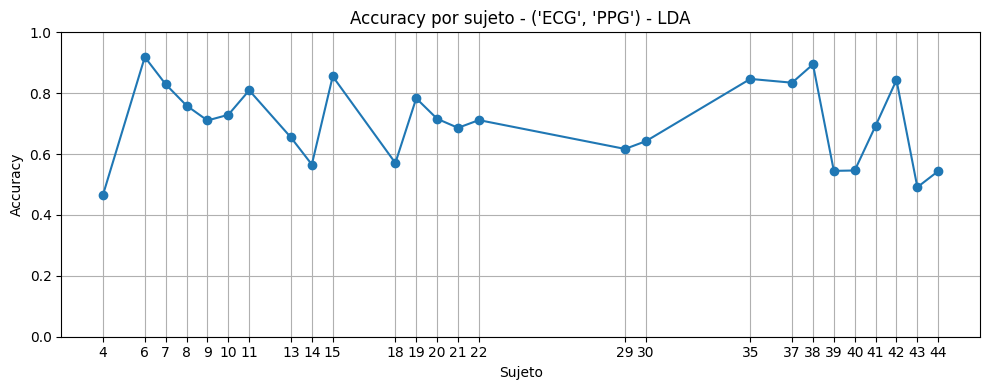

('ECG', 'PPG') - LDA Metrics
     Métrica     Valor                 Etapa
0   Accuracy  0.703484  ('ECG', 'PPG') - LDA
1  Precision  0.705321  ('ECG', 'PPG') - LDA
2     Recall  0.703484  ('ECG', 'PPG') - LDA
3   F1 Score  0.699150  ('ECG', 'PPG') - LDA
[('ECG', 'PPG') - LDA] Best Params: {'solver': 'svd'}
[('ECG', 'PPG') - LDA] Accuracy: 0.7035
('ECG', 'PPG') - LDA - Confusion Matrix
[[42572 30286]
 [16801 69142]]


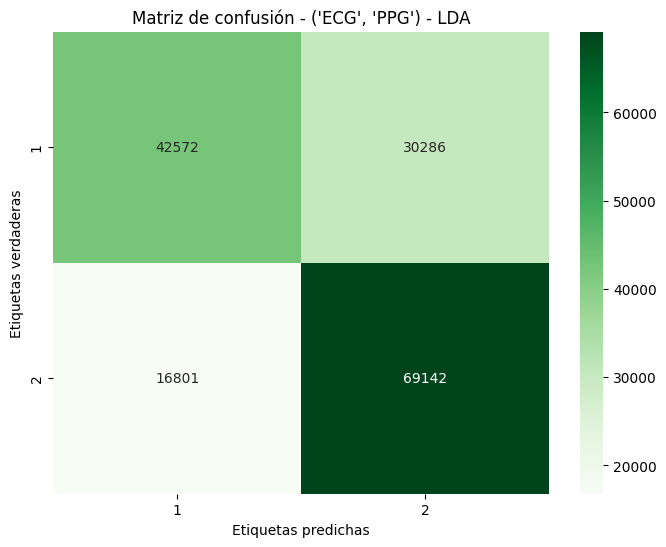

              precision    recall  f1-score   support

           1       0.72      0.58      0.64     72858
           2       0.70      0.80      0.75     85943

    accuracy                           0.70    158801
   macro avg       0.71      0.69      0.69    158801
weighted avg       0.71      0.70      0.70    158801

Training KNN model for ('ECG', 'PPG') using LOSO...
[('ECG', 'PPG') - KNN] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 8 candidates, totalling 208 fits
[('ECG', 'PPG') - KNN] Fold 1/26 (Subject: 4)
[('ECG', 'PPG') - KNN] Fold 2/26 (Subject: 6)
[('ECG', 'PPG') - KNN] Fold 3/26 (Subject: 7)
[('ECG', 'PPG') - KNN] Fold 4/26 (Subject: 8)
[('ECG', 'PPG') - KNN] Fold 5/26 (Subject: 9)
[('ECG', 'PPG') - KNN] Fold 6/26 (Subject: 10)
[('ECG', 'PPG') - KNN] Fold 7/26 (Subject: 11)
[('ECG', 'PPG') - KNN] Fold 8/26 (Subject: 13)
[('ECG', 'PPG') - KNN] Fold 9/26 (Subject: 14)
[('ECG', 'PPG') - KNN] Fold 10/26 (Subject: 15)
[('ECG', 'PPG') - KNN] Fold 11/26 (Subje

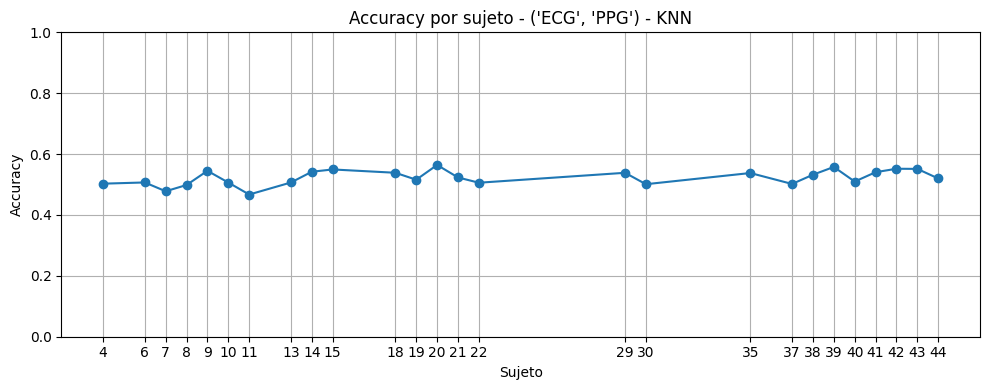

('ECG', 'PPG') - KNN Metrics
     Métrica     Valor                 Etapa
0   Accuracy  0.522975  ('ECG', 'PPG') - KNN
1  Precision  0.519267  ('ECG', 'PPG') - KNN
2     Recall  0.522975  ('ECG', 'PPG') - KNN
3   F1 Score  0.519903  ('ECG', 'PPG') - KNN
[('ECG', 'PPG') - KNN] Best Params: {'n_neighbors': 9, 'weights': 'uniform'}
[('ECG', 'PPG') - KNN] Accuracy: 0.5230
('ECG', 'PPG') - KNN - Confusion Matrix
[[31139 41719]
 [34033 51910]]


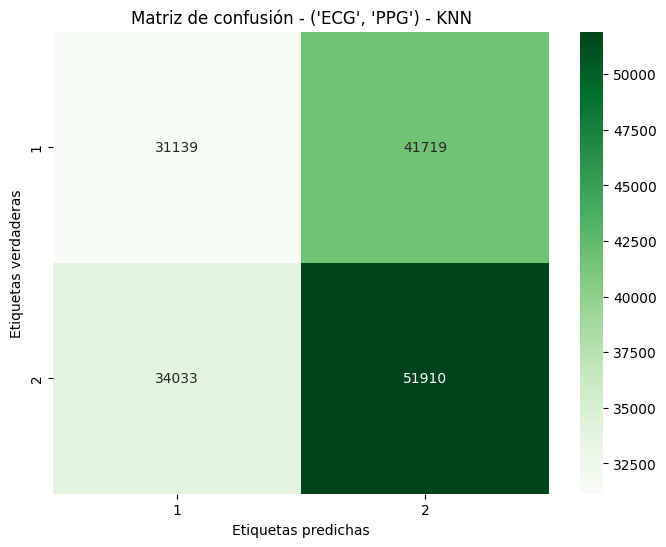

Training by signal combinations:   9%|▉         | 1/11 [23:38:53<236:28:55, 85133.60s/it]

              precision    recall  f1-score   support

           1       0.48      0.43      0.45     72858
           2       0.55      0.60      0.58     85943

    accuracy                           0.52    158801
   macro avg       0.52      0.52      0.51    158801
weighted avg       0.52      0.52      0.52    158801

Training DecisionTree model for ('ECG', 'EDA') using LOSO...
[('ECG', 'EDA') - DecisionTree] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 120 candidates, totalling 3120 fits
[('ECG', 'EDA') - DecisionTree] Fold 1/26 (Subject: 4)
[('ECG', 'EDA') - DecisionTree] Fold 2/26 (Subject: 6)
[('ECG', 'EDA') - DecisionTree] Fold 3/26 (Subject: 7)
[('ECG', 'EDA') - DecisionTree] Fold 4/26 (Subject: 8)
[('ECG', 'EDA') - DecisionTree] Fold 5/26 (Subject: 9)
[('ECG', 'EDA') - DecisionTree] Fold 6/26 (Subject: 10)
[('ECG', 'EDA') - DecisionTree] Fold 7/26 (Subject: 11)
[('ECG', 'EDA') - DecisionTree] Fold 8/26 (Subject: 13)
[('ECG', 'EDA') - DecisionTree] Fold 9/26 

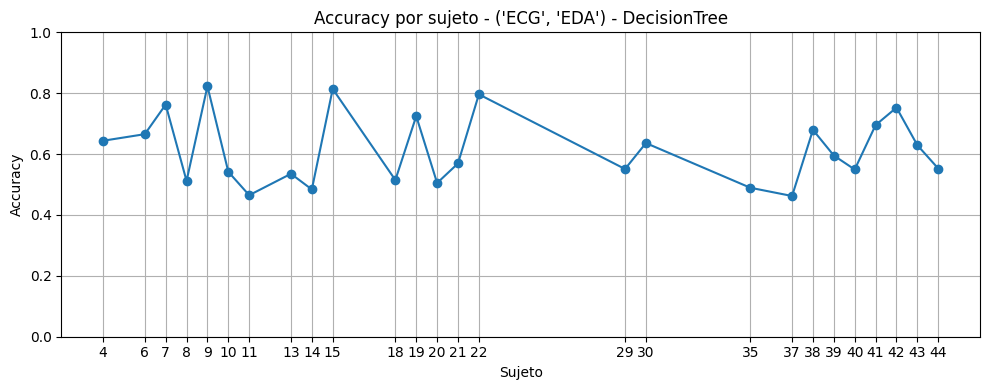

('ECG', 'EDA') - DecisionTree Metrics
     Métrica     Valor                          Etapa
0   Accuracy  0.612975  ('ECG', 'EDA') - DecisionTree
1  Precision  0.620051  ('ECG', 'EDA') - DecisionTree
2     Recall  0.612975  ('ECG', 'EDA') - DecisionTree
3   F1 Score  0.613243  ('ECG', 'EDA') - DecisionTree
[('ECG', 'EDA') - DecisionTree] Best Params: {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 20, 'min_samples_split': 2}
[('ECG', 'EDA') - DecisionTree] Accuracy: 0.6130
('ECG', 'EDA') - DecisionTree - Confusion Matrix
[[47914 24944]
 [36516 49427]]


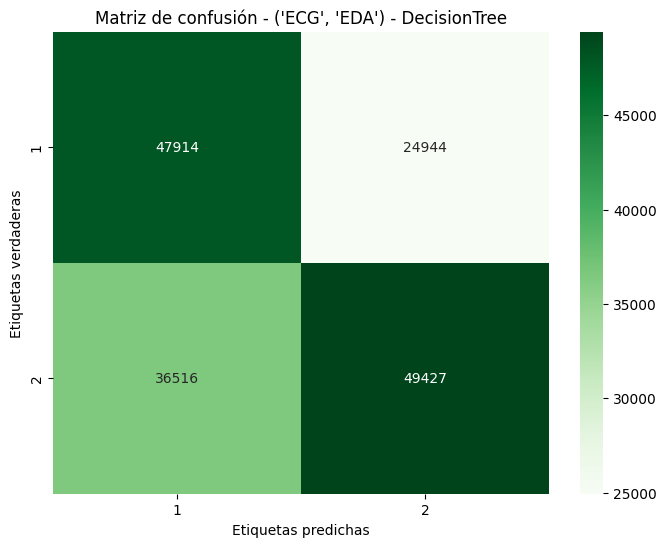

              precision    recall  f1-score   support

           1       0.57      0.66      0.61     72858
           2       0.66      0.58      0.62     85943

    accuracy                           0.61    158801
   macro avg       0.62      0.62      0.61    158801
weighted avg       0.62      0.61      0.61    158801

Training RandomForest model for ('ECG', 'EDA') using LOSO...
[('ECG', 'EDA') - RandomForest] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 72 candidates, totalling 1872 fits
[('ECG', 'EDA') - RandomForest] Fold 1/26 (Subject: 4)
[('ECG', 'EDA') - RandomForest] Fold 2/26 (Subject: 6)
[('ECG', 'EDA') - RandomForest] Fold 3/26 (Subject: 7)
[('ECG', 'EDA') - RandomForest] Fold 4/26 (Subject: 8)
[('ECG', 'EDA') - RandomForest] Fold 5/26 (Subject: 9)
[('ECG', 'EDA') - RandomForest] Fold 6/26 (Subject: 10)
[('ECG', 'EDA') - RandomForest] Fold 7/26 (Subject: 11)
[('ECG', 'EDA') - RandomForest] Fold 8/26 (Subject: 13)
[('ECG', 'EDA') - RandomForest] Fold 9/26 (

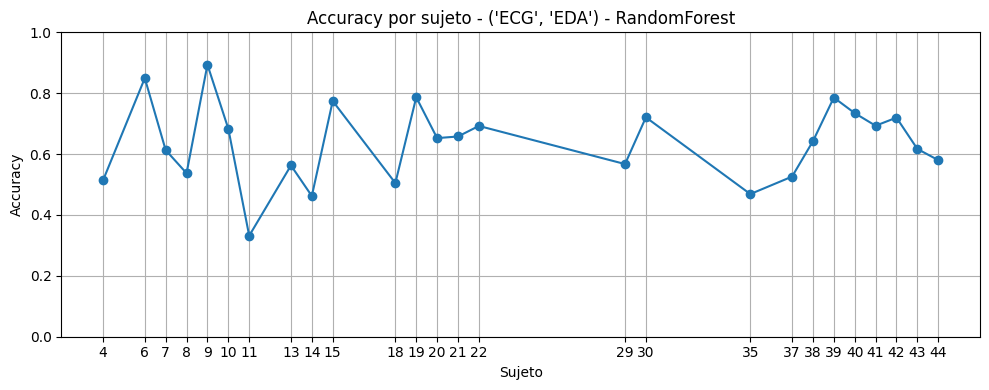

('ECG', 'EDA') - RandomForest Metrics
     Métrica     Valor                          Etapa
0   Accuracy  0.636658  ('ECG', 'EDA') - RandomForest
1  Precision  0.638907  ('ECG', 'EDA') - RandomForest
2     Recall  0.636658  ('ECG', 'EDA') - RandomForest
3   F1 Score  0.637227  ('ECG', 'EDA') - RandomForest
[('ECG', 'EDA') - RandomForest] Best Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 20, 'n_estimators': 100}
[('ECG', 'EDA') - RandomForest] Accuracy: 0.6367
('ECG', 'EDA') - RandomForest - Confusion Matrix
[[46355 26503]
 [31196 54747]]


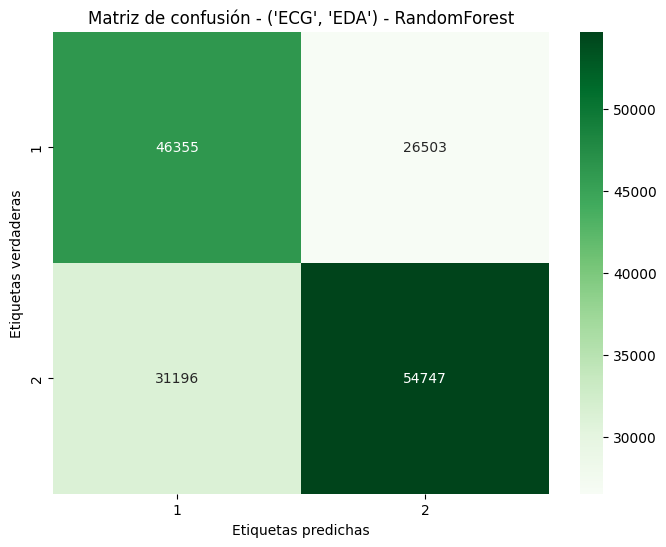

              precision    recall  f1-score   support

           1       0.60      0.64      0.62     72858
           2       0.67      0.64      0.65     85943

    accuracy                           0.64    158801
   macro avg       0.64      0.64      0.64    158801
weighted avg       0.64      0.64      0.64    158801

Training AdaBoost model for ('ECG', 'EDA') using LOSO...
[('ECG', 'EDA') - AdaBoost] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 32 candidates, totalling 832 fits
[('ECG', 'EDA') - AdaBoost] Fold 1/26 (Subject: 4)
[('ECG', 'EDA') - AdaBoost] Fold 2/26 (Subject: 6)
[('ECG', 'EDA') - AdaBoost] Fold 3/26 (Subject: 7)
[('ECG', 'EDA') - AdaBoost] Fold 4/26 (Subject: 8)
[('ECG', 'EDA') - AdaBoost] Fold 5/26 (Subject: 9)
[('ECG', 'EDA') - AdaBoost] Fold 6/26 (Subject: 10)
[('ECG', 'EDA') - AdaBoost] Fold 7/26 (Subject: 11)
[('ECG', 'EDA') - AdaBoost] Fold 8/26 (Subject: 13)
[('ECG', 'EDA') - AdaBoost] Fold 9/26 (Subject: 14)
[('ECG', 'EDA') - AdaBoost] Fold

Training by signal combinations:   9%|▉         | 1/11 [45:45:28<457:34:47, 164728.71s/it]


KeyboardInterrupt: 

In [33]:
for combo in tqdm(combinations, desc="Training by signal combinations"):
    features = sum([SIGNAL_CATEGORIES[signal] for signal in combo], [])
    if all(f in df.columns for f in features):# Verificar que todas las columnas existen
        X = df[features].values
        y = df['label'].values
        subjects = df['subject'].values # Se agrega el identificador de sujetos para LOSO

        for model_name, (model, param_grid) in models.items():
            print(f'Training {model_name} model for {combo} using LOSO...')
            metrics = train_and_evaluate_logo(X, y, subjects, model, param_grid, model_name, combo)
        
            # Convertir diccionario de métricas a DataFrame con mismo formato que antes
            results[(combo, model_name)] = metrics.copy()

# Mostrar resultados finales
print("\nFinal Comparison:")
for (combo, model_name), acc in results.items():
    print(f'{combo} - {model_name}:')
    print(acc)

# Crear heatmap
rows = []
for (combo, model), df_metrics in results.items():
    metric_values = df_metrics.set_index('Métrica')['Valor']

    row = {
    'Signal': combo,
    'Model': model,
    'Accuracy': metric_values.get('Accuracy', None),
    'F1': metric_values.get('F1 Score', None),
    'Precision': metric_values.get('Precision', None),
    'Recall': metric_values.get('Recall', None)
    }
    rows.append(row)

metrics_df = pd.DataFrame(rows)

pivot_df = metrics_df.pivot(index='Signal', columns='Model', values='Accuracy')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, cmap="Blues", fmt=".2f")
plt.title('Heatmap de Accuracy por combinación de señales y modelo (LOSO)')
plt.tight_layout()
plt.show()

data = []
metrics = ["Accuracy", "F1 Score", "Recall", "Precision"]

for (combo, model), df in results.items():
    for metric in metrics:
        row = df[df["Métrica"] == metric]
        if not row.empty:
            value = row["Valor"].values[0]
            data.append((combo, model, metric, value))

df_all = pd.DataFrame(data, columns=["Signal", "Model", "Metric", "Value"])

# Paleta bonita
palette = sns.color_palette("Set1")

# Hacer el FacetGrid
g = sns.FacetGrid(df_all, col="Metric", sharey=True, col_wrap=2, height=4, aspect=1.5)
g.map_dataframe(sns.barplot, x="Model", y="Value", hue="Signal", palette=palette, width=0.7, dodge=True)

# Ajustes para la leyenda
g.add_legend(title="Señal", bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0)

# Añadir etiquetas de valores
for ax in g.axes.flatten():
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=7, padding=2)
    ax.set_ylim(0, 1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

4-CLASIFICATION

In [ ]:
file = r'features_30_075\features.csv'

df = load_data(file)
df = df.fillna(0)

In [ ]:
for i in range(1, len(df['label'].unique())+1):
    mask = (df['label'] == i).sum()
    print(f'Label: {i} total: {mask}')

Label: 1 total: 51769
Label: 2 total: 21089
Label: 3 total: 53017
Label: 4 total: 32926


Training by signal:   0%|          | 0/4 [00:00<?, ?it/s]

Training DecisionTree model for ECG using LOGO...
[ECG - DecisionTree] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 120 candidates, totalling 3120 fits
[ECG - DecisionTree] Fold 1/26 (Subject: 4)
[ECG - DecisionTree] Fold 2/26 (Subject: 6)
[ECG - DecisionTree] Fold 3/26 (Subject: 7)
[ECG - DecisionTree] Fold 4/26 (Subject: 8)
[ECG - DecisionTree] Fold 5/26 (Subject: 9)
[ECG - DecisionTree] Fold 6/26 (Subject: 10)
[ECG - DecisionTree] Fold 7/26 (Subject: 11)
[ECG - DecisionTree] Fold 8/26 (Subject: 13)
[ECG - DecisionTree] Fold 9/26 (Subject: 14)
[ECG - DecisionTree] Fold 10/26 (Subject: 15)
[ECG - DecisionTree] Fold 11/26 (Subject: 18)
[ECG - DecisionTree] Fold 12/26 (Subject: 19)
[ECG - DecisionTree] Fold 13/26 (Subject: 20)
[ECG - DecisionTree] Fold 14/26 (Subject: 21)
[ECG - DecisionTree] Fold 15/26 (Subject: 22)
[ECG - DecisionTree] Fold 16/26 (Subject: 29)
[ECG - DecisionTree] Fold 17/26 (Subject: 30)
[ECG - DecisionTree] Fold 18/26 (Subject: 35)
[ECG - DecisionTree]

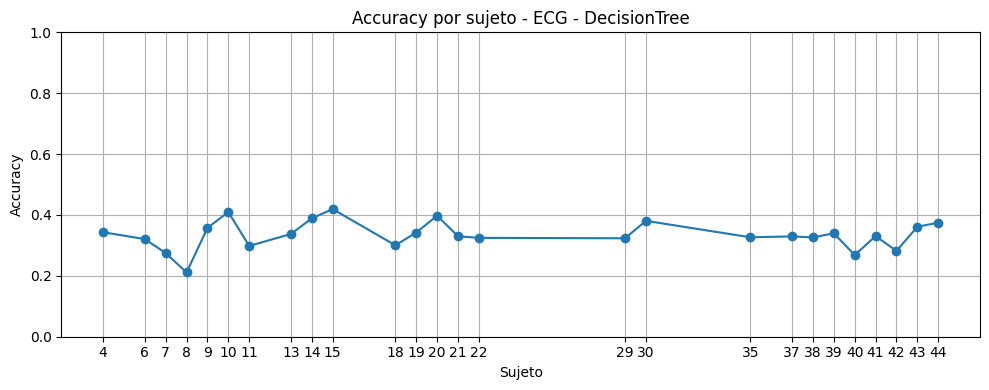

ECG - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.334784  ECG - DecisionTree
1  Precision  0.314505  ECG - DecisionTree
2     Recall  0.334784  ECG - DecisionTree
3   F1 Score  0.315631  ECG - DecisionTree
[ECG - DecisionTree] Best Params: {'criterion': 'entropy', 'max_depth': 3, 'max_leaf_nodes': 10, 'min_samples_split': 2}
[ECG - DecisionTree] Accuracy: 0.3348
ECG - DecisionTree - Confusion Matrix
[[25154  3045 15022  8548]
 [ 9506  1199  6538  3846]
 [21448  1249 21317  9003]
 [15945   696 10791  5494]]


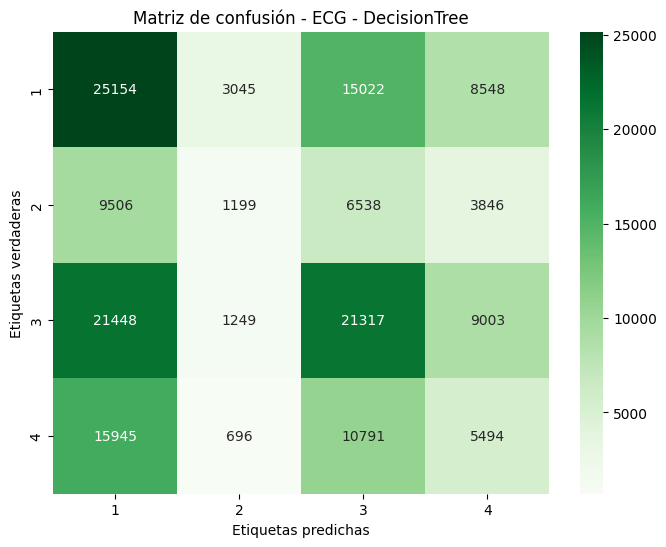

              precision    recall  f1-score   support

           1       0.35      0.49      0.41     51769
           2       0.19      0.06      0.09     21089
           3       0.40      0.40      0.40     53017
           4       0.20      0.17      0.18     32926

    accuracy                           0.33    158801
   macro avg       0.29      0.28      0.27    158801
weighted avg       0.31      0.33      0.32    158801

Training RandomForest model for ECG using LOGO...
[ECG - RandomForest] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 72 candidates, totalling 1872 fits
[ECG - RandomForest] Fold 1/26 (Subject: 4)
[ECG - RandomForest] Fold 2/26 (Subject: 6)
[ECG - RandomForest] Fold 3/26 (Subject: 7)
[ECG - RandomForest] Fold 4/26 (Subject: 8)
[ECG - RandomForest] Fold 5/26 (Subject: 9)
[ECG - RandomForest] Fold 6/26 (Subject: 10)
[ECG - RandomForest] Fold 7/26 (Subject: 11)
[ECG - RandomForest] Fold 8/26 (Subject: 13)
[ECG - RandomForest] Fold 9/26 (Subject: 14)


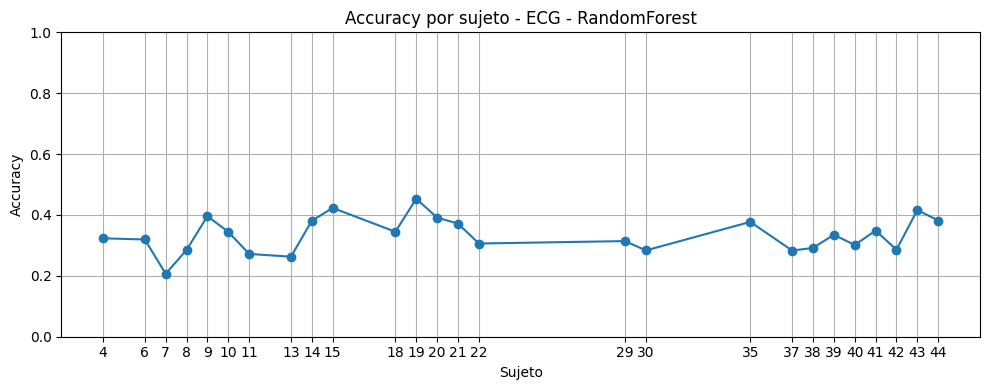

ECG - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.334960  ECG - RandomForest
1  Precision  0.340365  ECG - RandomForest
2     Recall  0.334960  ECG - RandomForest
3   F1 Score  0.336932  ECG - RandomForest
[ECG - RandomForest] Best Params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 20, 'n_estimators': 300}
[ECG - RandomForest] Accuracy: 0.3350
ECG - RandomForest - Confusion Matrix
[[18323  7894 14630 10922]
 [ 6503  4016  6349  4221]
 [11663  8214 23701  9439]
 [ 9537  5644 10593  7152]]


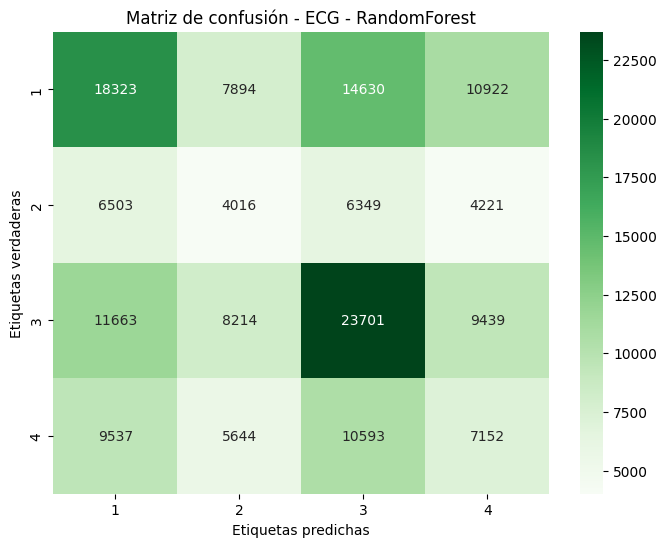

              precision    recall  f1-score   support

           1       0.40      0.35      0.37     51769
           2       0.16      0.19      0.17     21089
           3       0.43      0.45      0.44     53017
           4       0.23      0.22      0.22     32926

    accuracy                           0.33    158801
   macro avg       0.30      0.30      0.30    158801
weighted avg       0.34      0.33      0.34    158801

Training AdaBoost model for ECG using LOGO...
[ECG - AdaBoost] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 32 candidates, totalling 832 fits
[ECG - AdaBoost] Fold 1/26 (Subject: 4)
[ECG - AdaBoost] Fold 2/26 (Subject: 6)
[ECG - AdaBoost] Fold 3/26 (Subject: 7)
[ECG - AdaBoost] Fold 4/26 (Subject: 8)
[ECG - AdaBoost] Fold 5/26 (Subject: 9)
[ECG - AdaBoost] Fold 6/26 (Subject: 10)
[ECG - AdaBoost] Fold 7/26 (Subject: 11)
[ECG - AdaBoost] Fold 8/26 (Subject: 13)
[ECG - AdaBoost] Fold 9/26 (Subject: 14)
[ECG - AdaBoost] Fold 10/26 (Subject: 15)
[EC

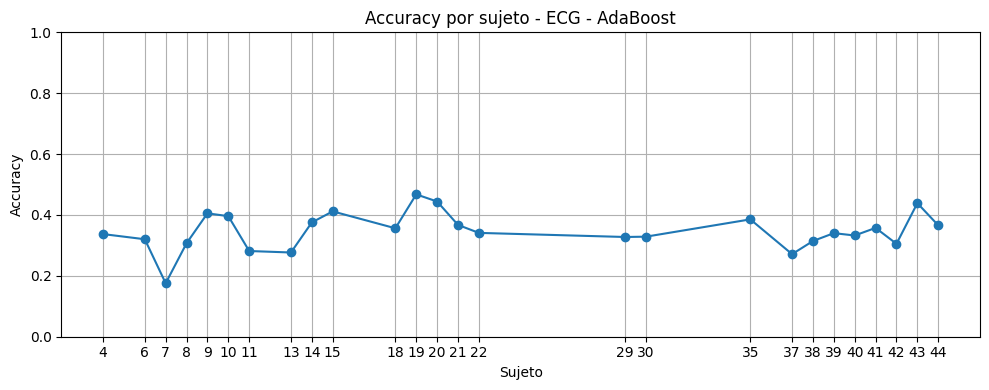

ECG - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.347794  ECG - AdaBoost
1  Precision  0.344940  ECG - AdaBoost
2     Recall  0.347794  ECG - AdaBoost
3   F1 Score  0.343895  ECG - AdaBoost
[ECG - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=1), 'learning_rate': 0.5, 'n_estimators': 50}
[ECG - AdaBoost] Accuracy: 0.3478
ECG - AdaBoost - Confusion Matrix
[[19415  8688 16402  7264]
 [ 6742  4347  6969  3031]
 [12274  7711 25784  7248]
 [ 9896  5582 11764  5684]]


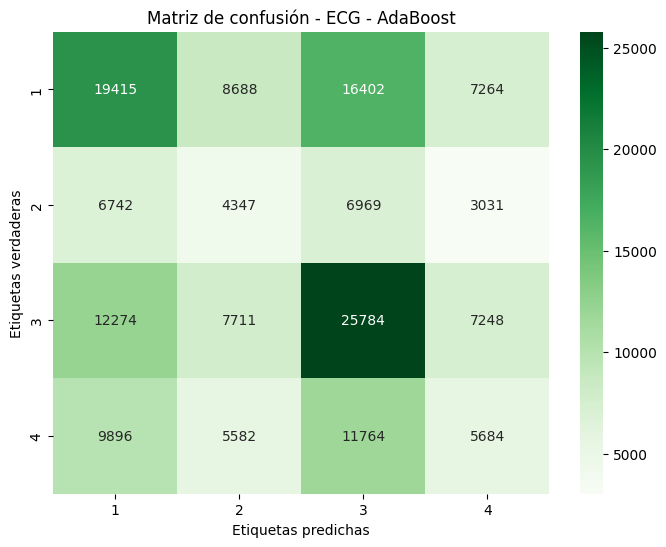

              precision    recall  f1-score   support

           1       0.40      0.38      0.39     51769
           2       0.17      0.21      0.18     21089
           3       0.42      0.49      0.45     53017
           4       0.24      0.17      0.20     32926

    accuracy                           0.35    158801
   macro avg       0.31      0.31      0.31    158801
weighted avg       0.34      0.35      0.34    158801

Training LDA model for ECG using LOGO...
[ECG - LDA] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 1 candidates, totalling 26 fits
[ECG - LDA] Fold 1/26 (Subject: 4)
[ECG - LDA] Fold 2/26 (Subject: 6)
[ECG - LDA] Fold 3/26 (Subject: 7)
[ECG - LDA] Fold 4/26 (Subject: 8)
[ECG - LDA] Fold 5/26 (Subject: 9)
[ECG - LDA] Fold 6/26 (Subject: 10)
[ECG - LDA] Fold 7/26 (Subject: 11)
[ECG - LDA] Fold 8/26 (Subject: 13)
[ECG - LDA] Fold 9/26 (Subject: 14)
[ECG - LDA] Fold 10/26 (Subject: 15)
[ECG - LDA] Fold 11/26 (Subject: 18)
[ECG - LDA] Fold 12/26 (Subj

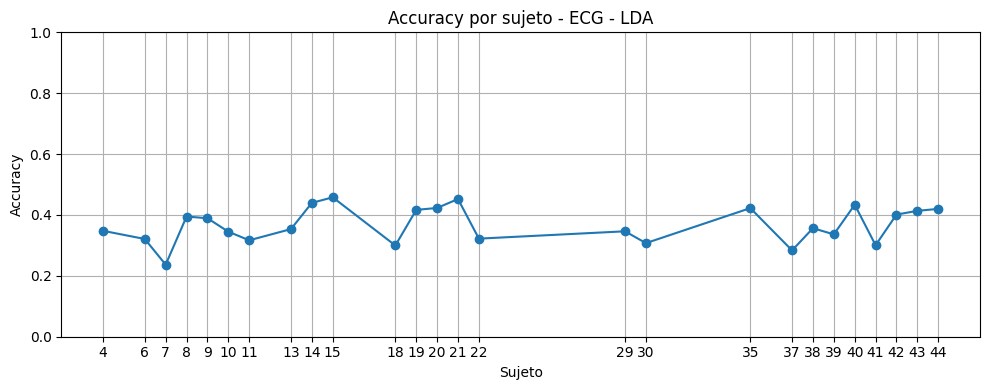

ECG - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.367353  ECG - LDA
1  Precision  0.321949  ECG - LDA
2     Recall  0.367353  ECG - LDA
3   F1 Score  0.311969  ECG - LDA
[ECG - LDA] Best Params: {'solver': 'svd'}
[ECG - LDA] Accuracy: 0.3674
ECG - LDA - Confusion Matrix
[[28644    60 21129  1936]
 [11256    19  9010   804]
 [22806    42 27531  2638]
 [17010    27 13747  2142]]


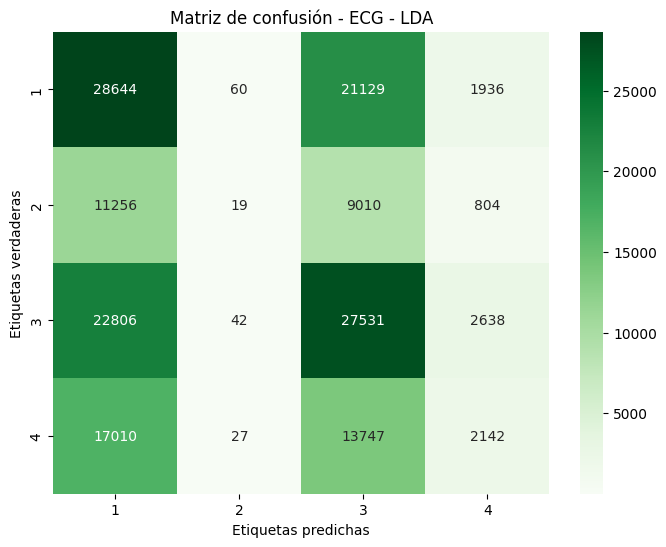

              precision    recall  f1-score   support

           1       0.36      0.55      0.44     51769
           2       0.13      0.00      0.00     21089
           3       0.39      0.52      0.44     53017
           4       0.28      0.07      0.11     32926

    accuracy                           0.37    158801
   macro avg       0.29      0.28      0.25    158801
weighted avg       0.32      0.37      0.31    158801

Training KNN model for ECG using LOGO...
[ECG - KNN] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 8 candidates, totalling 208 fits
[ECG - KNN] Fold 1/26 (Subject: 4)
[ECG - KNN] Fold 2/26 (Subject: 6)
[ECG - KNN] Fold 3/26 (Subject: 7)
[ECG - KNN] Fold 4/26 (Subject: 8)
[ECG - KNN] Fold 5/26 (Subject: 9)
[ECG - KNN] Fold 6/26 (Subject: 10)
[ECG - KNN] Fold 7/26 (Subject: 11)
[ECG - KNN] Fold 8/26 (Subject: 13)
[ECG - KNN] Fold 9/26 (Subject: 14)
[ECG - KNN] Fold 10/26 (Subject: 15)
[ECG - KNN] Fold 11/26 (Subject: 18)
[ECG - KNN] Fold 12/26 (Sub

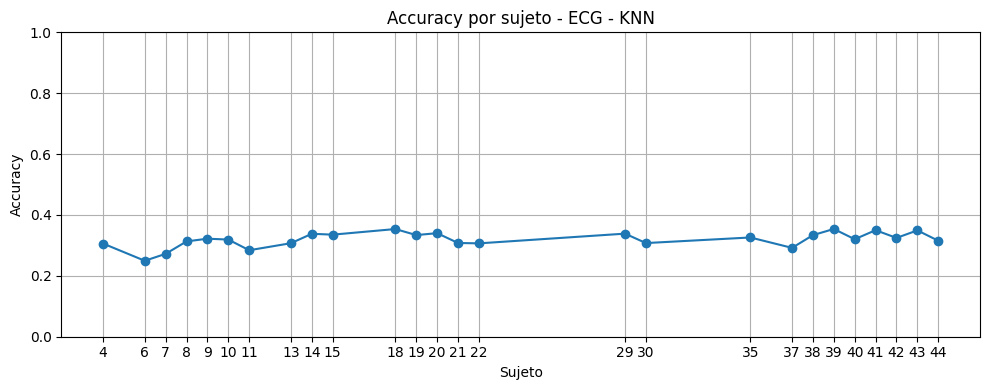

ECG - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.319488  ECG - KNN
1  Precision  0.299047  ECG - KNN
2     Recall  0.319488  ECG - KNN
3   F1 Score  0.305230  ECG - KNN
[ECG - KNN] Best Params: {'n_neighbors': 9, 'weights': 'uniform'}
[ECG - KNN] Accuracy: 0.3195
ECG - KNN - Confusion Matrix
[[21499  4229 18425  7616]
 [ 8545  1753  7651  3140]
 [19440  4048 22614  6915]
 [13700  2600 11757  4869]]


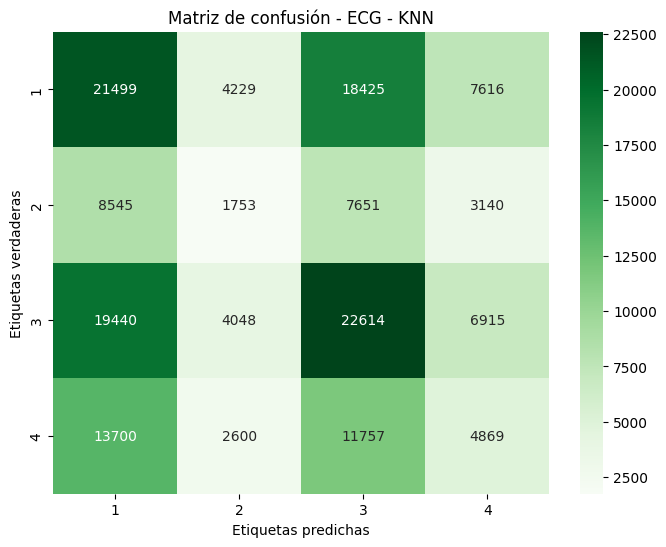

Training by signal:  25%|██▌       | 1/4 [12:08:01<36:24:03, 43681.29s/it]

              precision    recall  f1-score   support

           1       0.34      0.42      0.37     51769
           2       0.14      0.08      0.10     21089
           3       0.37      0.43      0.40     53017
           4       0.22      0.15      0.18     32926

    accuracy                           0.32    158801
   macro avg       0.27      0.27      0.26    158801
weighted avg       0.30      0.32      0.31    158801

Training DecisionTree model for PPG using LOGO...
[PPG - DecisionTree] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 120 candidates, totalling 3120 fits
[PPG - DecisionTree] Fold 1/26 (Subject: 4)
[PPG - DecisionTree] Fold 2/26 (Subject: 6)
[PPG - DecisionTree] Fold 3/26 (Subject: 7)
[PPG - DecisionTree] Fold 4/26 (Subject: 8)
[PPG - DecisionTree] Fold 5/26 (Subject: 9)
[PPG - DecisionTree] Fold 6/26 (Subject: 10)
[PPG - DecisionTree] Fold 7/26 (Subject: 11)
[PPG - DecisionTree] Fold 8/26 (Subject: 13)
[PPG - DecisionTree] Fold 9/26 (Subject: 14)

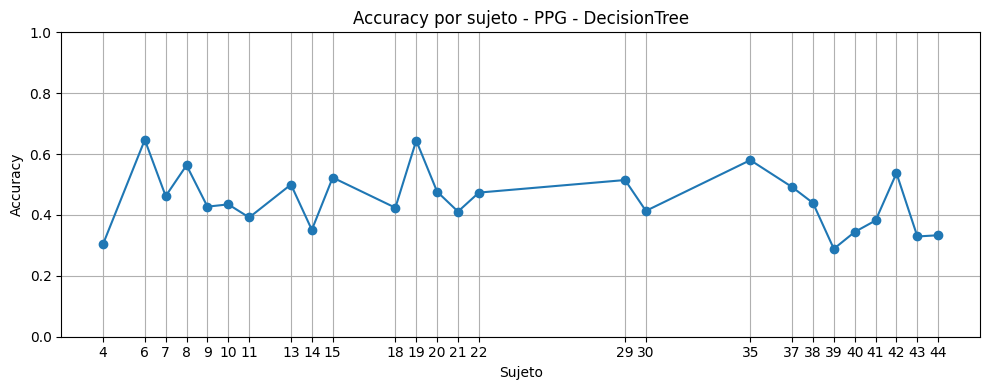

PPG - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.449978  PPG - DecisionTree
1  Precision  0.434719  PPG - DecisionTree
2     Recall  0.449978  PPG - DecisionTree
3   F1 Score  0.436848  PPG - DecisionTree
[PPG - DecisionTree] Best Params: {'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': 10, 'min_samples_split': 2}
[PPG - DecisionTree] Accuracy: 0.4500
PPG - DecisionTree - Confusion Matrix
[[32640  9002  6811  3316]
 [ 8066  4224  6346  2453]
 [ 9680  6654 29905  6778]
 [ 8813  6067 13358  4688]]


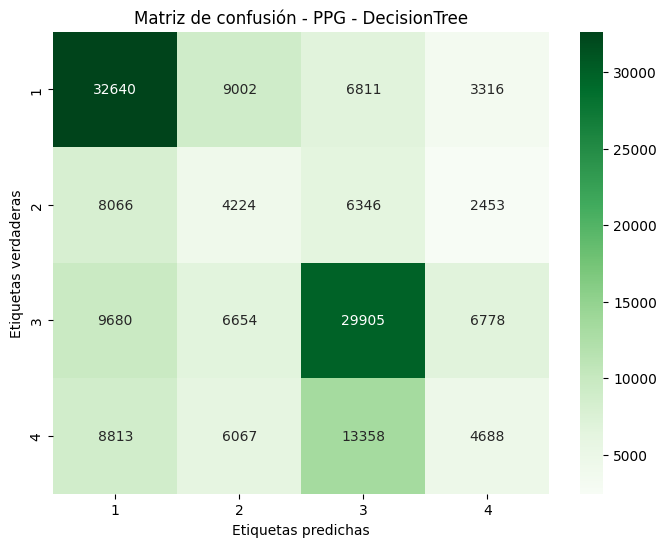

              precision    recall  f1-score   support

           1       0.55      0.63      0.59     51769
           2       0.16      0.20      0.18     21089
           3       0.53      0.56      0.55     53017
           4       0.27      0.14      0.19     32926

    accuracy                           0.45    158801
   macro avg       0.38      0.38      0.38    158801
weighted avg       0.43      0.45      0.44    158801

Training RandomForest model for PPG using LOGO...
[PPG - RandomForest] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 72 candidates, totalling 1872 fits
[PPG - RandomForest] Fold 1/26 (Subject: 4)
[PPG - RandomForest] Fold 2/26 (Subject: 6)
[PPG - RandomForest] Fold 3/26 (Subject: 7)
[PPG - RandomForest] Fold 4/26 (Subject: 8)
[PPG - RandomForest] Fold 5/26 (Subject: 9)
[PPG - RandomForest] Fold 6/26 (Subject: 10)
[PPG - RandomForest] Fold 7/26 (Subject: 11)
[PPG - RandomForest] Fold 8/26 (Subject: 13)
[PPG - RandomForest] Fold 9/26 (Subject: 14)


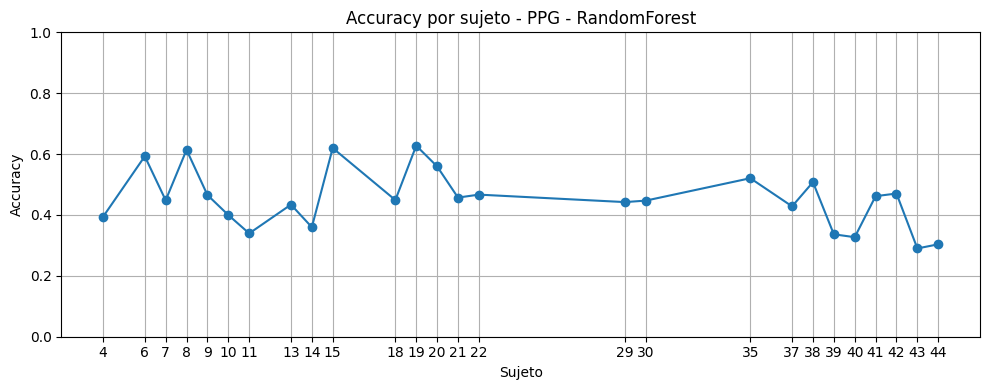

PPG - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.453202  PPG - RandomForest
1  Precision  0.441540  PPG - RandomForest
2     Recall  0.453202  PPG - RandomForest
3   F1 Score  0.446378  PPG - RandomForest
[PPG - RandomForest] Best Params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
[PPG - RandomForest] Accuracy: 0.4532
PPG - RandomForest - Confusion Matrix
[[32555  6643  6160  6411]
 [ 8147  2532  5550  4860]
 [ 8777  4161 28752 11327]
 [ 9294  4782 10720  8130]]


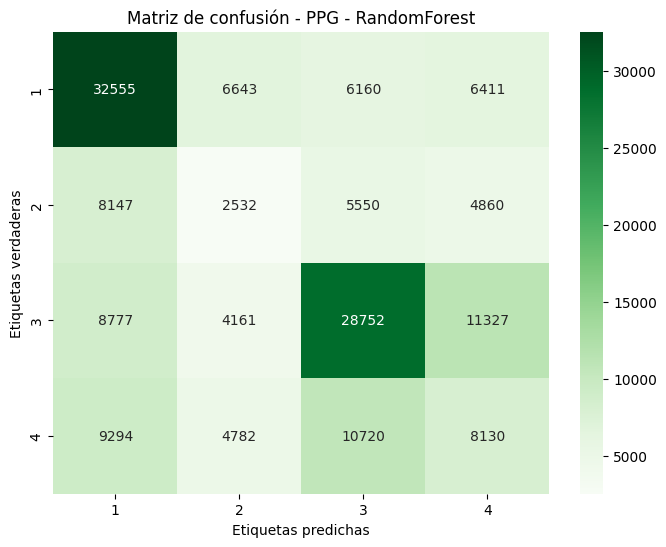

              precision    recall  f1-score   support

           1       0.55      0.63      0.59     51769
           2       0.14      0.12      0.13     21089
           3       0.56      0.54      0.55     53017
           4       0.26      0.25      0.26     32926

    accuracy                           0.45    158801
   macro avg       0.38      0.38      0.38    158801
weighted avg       0.44      0.45      0.45    158801

Training AdaBoost model for PPG using LOGO...
[PPG - AdaBoost] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 32 candidates, totalling 832 fits
[PPG - AdaBoost] Fold 1/26 (Subject: 4)
[PPG - AdaBoost] Fold 2/26 (Subject: 6)
[PPG - AdaBoost] Fold 3/26 (Subject: 7)
[PPG - AdaBoost] Fold 4/26 (Subject: 8)
[PPG - AdaBoost] Fold 5/26 (Subject: 9)
[PPG - AdaBoost] Fold 6/26 (Subject: 10)
[PPG - AdaBoost] Fold 7/26 (Subject: 11)
[PPG - AdaBoost] Fold 8/26 (Subject: 13)
[PPG - AdaBoost] Fold 9/26 (Subject: 14)
[PPG - AdaBoost] Fold 10/26 (Subject: 15)
[PP

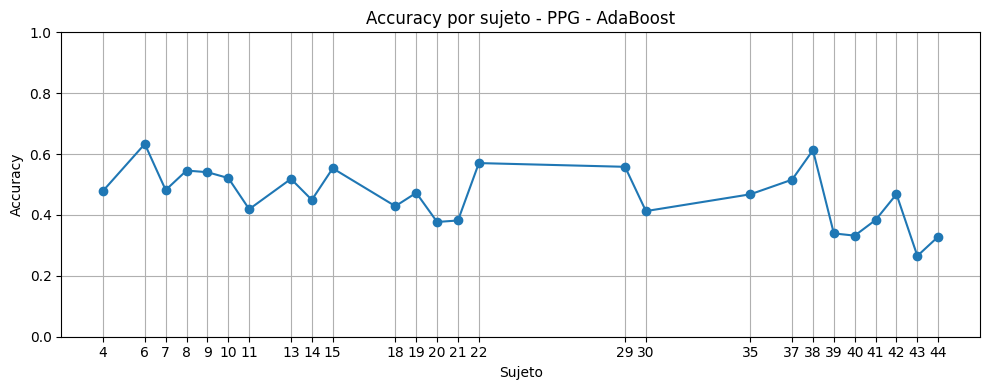

PPG - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.463580  PPG - AdaBoost
1  Precision  0.370385  PPG - AdaBoost
2     Recall  0.463580  PPG - AdaBoost
3   F1 Score  0.386746  PPG - AdaBoost
[PPG - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=1), 'learning_rate': 0.01, 'n_estimators': 50}
[PPG - AdaBoost] Accuracy: 0.4636
PPG - AdaBoost - Confusion Matrix
[[32061  1970 16432  1306]
 [ 9042   640 11067   340]
 [ 9968  1673 40425   951]
 [10761  1029 20645   491]]


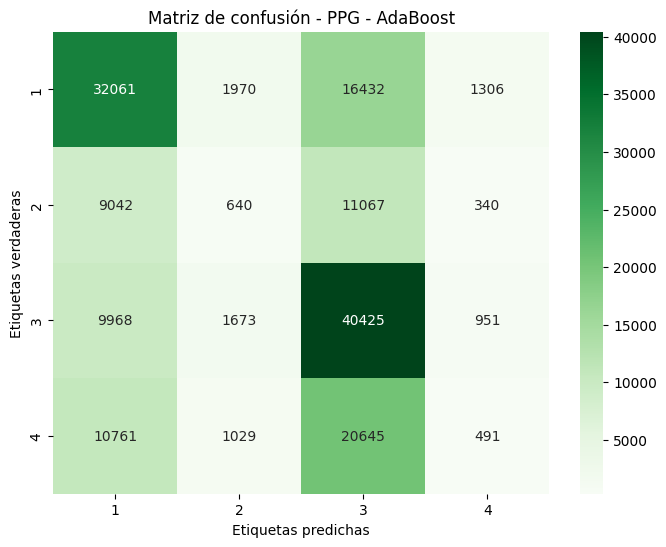

              precision    recall  f1-score   support

           1       0.52      0.62      0.56     51769
           2       0.12      0.03      0.05     21089
           3       0.46      0.76      0.57     53017
           4       0.16      0.01      0.03     32926

    accuracy                           0.46    158801
   macro avg       0.31      0.36      0.30    158801
weighted avg       0.37      0.46      0.39    158801

Training LDA model for PPG using LOGO...
[PPG - LDA] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 1 candidates, totalling 26 fits
[PPG - LDA] Fold 1/26 (Subject: 4)
[PPG - LDA] Fold 2/26 (Subject: 6)
[PPG - LDA] Fold 3/26 (Subject: 7)
[PPG - LDA] Fold 4/26 (Subject: 8)
[PPG - LDA] Fold 5/26 (Subject: 9)
[PPG - LDA] Fold 6/26 (Subject: 10)
[PPG - LDA] Fold 7/26 (Subject: 11)
[PPG - LDA] Fold 8/26 (Subject: 13)
[PPG - LDA] Fold 9/26 (Subject: 14)
[PPG - LDA] Fold 10/26 (Subject: 15)
[PPG - LDA] Fold 11/26 (Subject: 18)
[PPG - LDA] Fold 12/26 (Subj

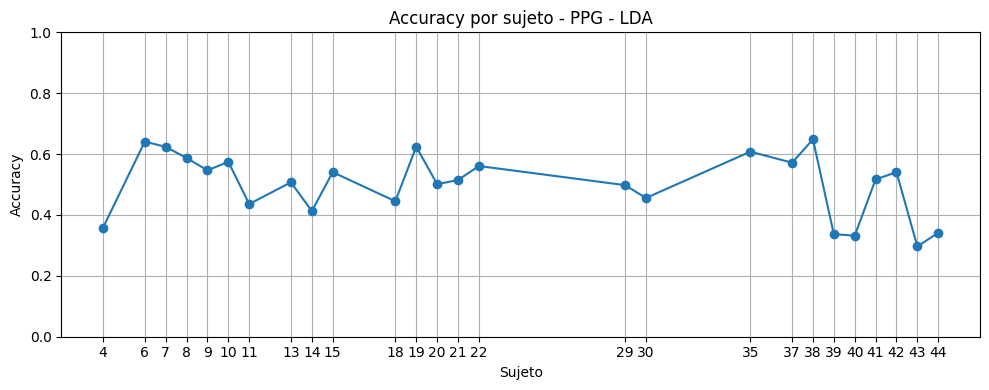

PPG - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.501048  PPG - LDA
1  Precision  0.436349  PPG - LDA
2     Recall  0.501048  PPG - LDA
3   F1 Score  0.424859  PPG - LDA
[PPG - LDA] Best Params: {'solver': 'svd'}
[PPG - LDA] Accuracy: 0.5010
PPG - LDA - Confusion Matrix
[[36304     6 13887  1572]
 [ 8553    10 10605  1921]
 [ 8556    18 40991  3452]
 [ 9255     0 21409  2262]]


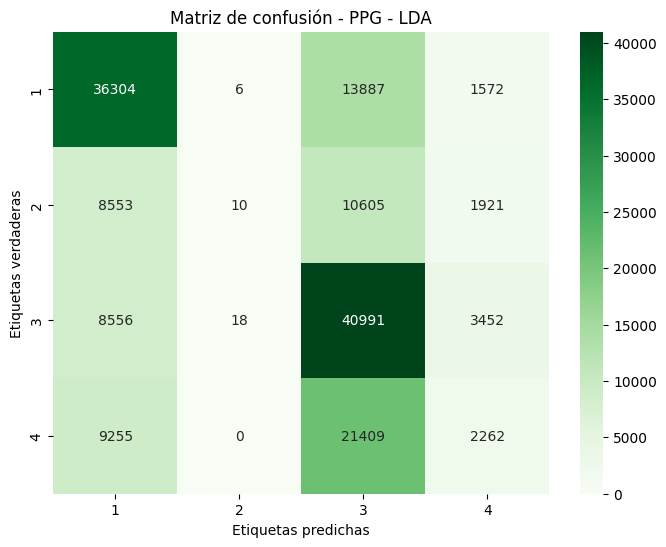

              precision    recall  f1-score   support

           1       0.58      0.70      0.63     51769
           2       0.29      0.00      0.00     21089
           3       0.47      0.77      0.59     53017
           4       0.25      0.07      0.11     32926

    accuracy                           0.50    158801
   macro avg       0.40      0.39      0.33    158801
weighted avg       0.44      0.50      0.42    158801

Training KNN model for PPG using LOGO...
[PPG - KNN] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 8 candidates, totalling 208 fits
[PPG - KNN] Fold 1/26 (Subject: 4)
[PPG - KNN] Fold 2/26 (Subject: 6)
[PPG - KNN] Fold 3/26 (Subject: 7)
[PPG - KNN] Fold 4/26 (Subject: 8)
[PPG - KNN] Fold 5/26 (Subject: 9)
[PPG - KNN] Fold 6/26 (Subject: 10)
[PPG - KNN] Fold 7/26 (Subject: 11)
[PPG - KNN] Fold 8/26 (Subject: 13)
[PPG - KNN] Fold 9/26 (Subject: 14)
[PPG - KNN] Fold 10/26 (Subject: 15)
[PPG - KNN] Fold 11/26 (Subject: 18)
[PPG - KNN] Fold 12/26 (Sub

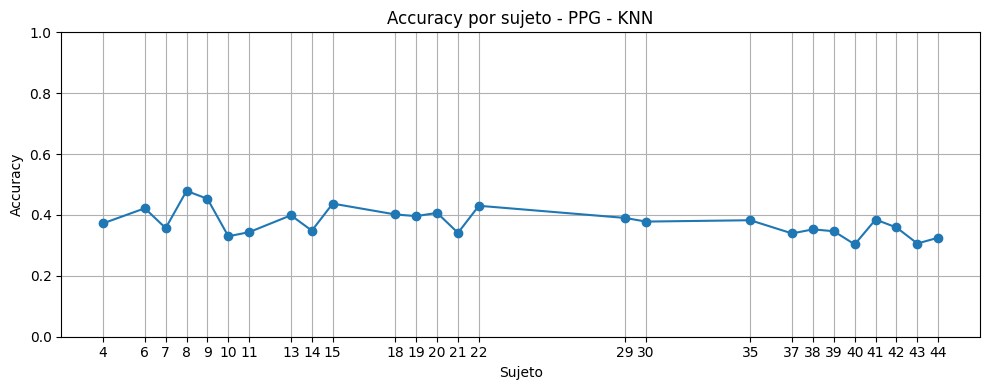

PPG - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.376339  PPG - KNN
1  Precision  0.355739  PPG - KNN
2     Recall  0.376339  PPG - KNN
3   F1 Score  0.363026  PPG - KNN
[PPG - KNN] Best Params: {'n_neighbors': 9, 'weights': 'uniform'}
[PPG - KNN] Accuracy: 0.3763
PPG - KNN - Confusion Matrix
[[23743  5327 14569  8130]
 [ 7127  2023  8284  3655]
 [10781  4622 28623  8991]
 [ 9350  3107 15095  5374]]


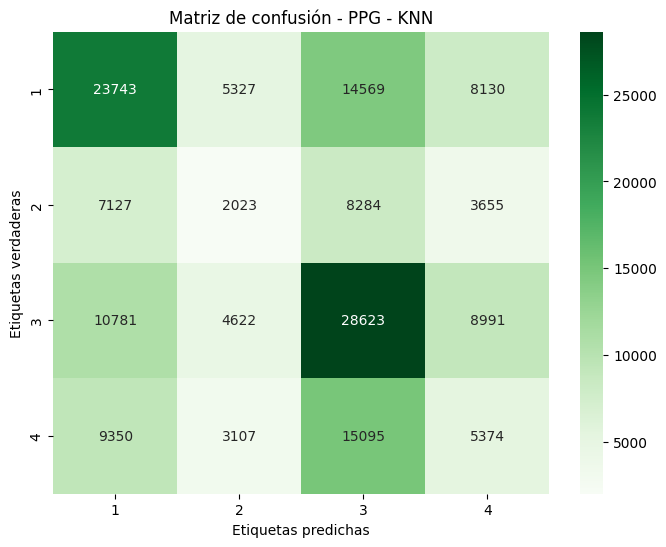

Training by signal:  50%|█████     | 2/4 [24:08:22<24:07:01, 43410.91s/it]

              precision    recall  f1-score   support

           1       0.47      0.46      0.46     51769
           2       0.13      0.10      0.11     21089
           3       0.43      0.54      0.48     53017
           4       0.21      0.16      0.18     32926

    accuracy                           0.38    158801
   macro avg       0.31      0.31      0.31    158801
weighted avg       0.36      0.38      0.36    158801

Training DecisionTree model for EDA using LOGO...
[EDA - DecisionTree] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 120 candidates, totalling 3120 fits
[EDA - DecisionTree] Fold 1/26 (Subject: 4)
[EDA - DecisionTree] Fold 2/26 (Subject: 6)
[EDA - DecisionTree] Fold 3/26 (Subject: 7)
[EDA - DecisionTree] Fold 4/26 (Subject: 8)
[EDA - DecisionTree] Fold 5/26 (Subject: 9)
[EDA - DecisionTree] Fold 6/26 (Subject: 10)
[EDA - DecisionTree] Fold 7/26 (Subject: 11)
[EDA - DecisionTree] Fold 8/26 (Subject: 13)
[EDA - DecisionTree] Fold 9/26 (Subject: 14)

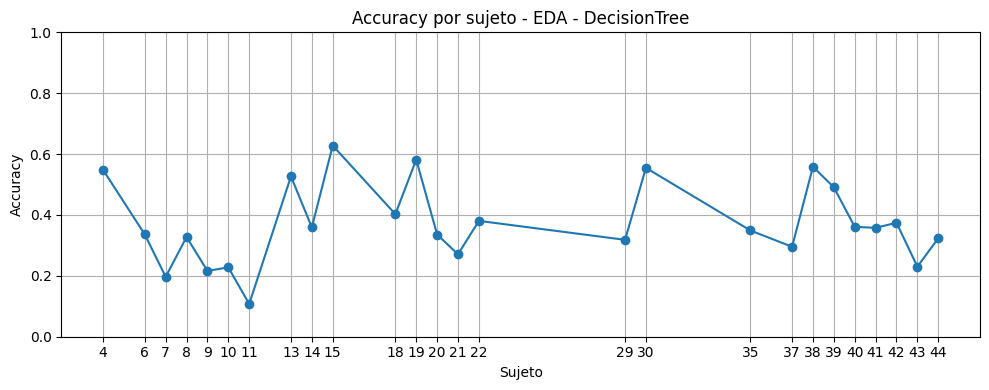

EDA - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.372655  EDA - DecisionTree
1  Precision  0.357700  EDA - DecisionTree
2     Recall  0.372655  EDA - DecisionTree
3   F1 Score  0.359058  EDA - DecisionTree
[EDA - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 5, 'max_leaf_nodes': 10, 'min_samples_split': 2}
[EDA - DecisionTree] Accuracy: 0.3727
EDA - DecisionTree - Confusion Matrix
[[21461  1873 22965  5470]
 [ 5314   578 10341  4856]
 [10194  4183 26723 11917]
 [ 6078  2522 13910 10416]]


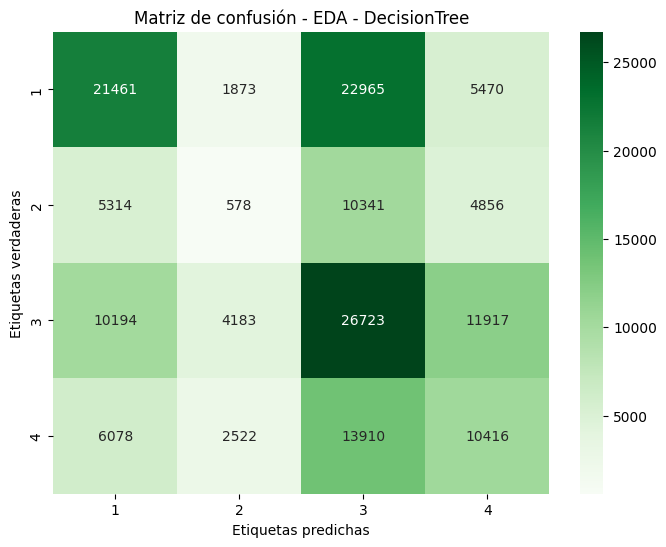

              precision    recall  f1-score   support

           1       0.50      0.41      0.45     51769
           2       0.06      0.03      0.04     21089
           3       0.36      0.50      0.42     53017
           4       0.32      0.32      0.32     32926

    accuracy                           0.37    158801
   macro avg       0.31      0.32      0.31    158801
weighted avg       0.36      0.37      0.36    158801

Training RandomForest model for EDA using LOGO...
[EDA - RandomForest] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 72 candidates, totalling 1872 fits
[EDA - RandomForest] Fold 1/26 (Subject: 4)
[EDA - RandomForest] Fold 2/26 (Subject: 6)
[EDA - RandomForest] Fold 3/26 (Subject: 7)
[EDA - RandomForest] Fold 4/26 (Subject: 8)
[EDA - RandomForest] Fold 5/26 (Subject: 9)
[EDA - RandomForest] Fold 6/26 (Subject: 10)
[EDA - RandomForest] Fold 7/26 (Subject: 11)
[EDA - RandomForest] Fold 8/26 (Subject: 13)
[EDA - RandomForest] Fold 9/26 (Subject: 14)


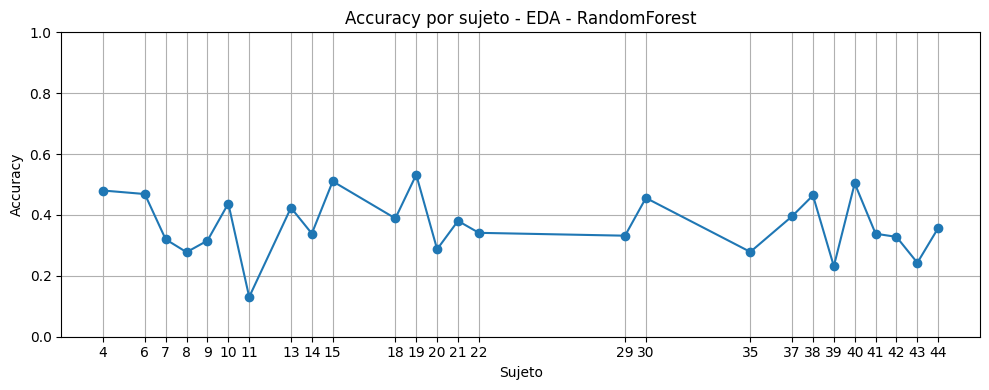

EDA - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.367838  EDA - RandomForest
1  Precision  0.345037  EDA - RandomForest
2     Recall  0.367838  EDA - RandomForest
3   F1 Score  0.352941  EDA - RandomForest
[EDA - RandomForest] Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
[EDA - RandomForest] Accuracy: 0.3678
EDA - RandomForest - Confusion Matrix
[[27908  4424 13680  5757]
 [ 8299  1499  8304  2987]
 [16711  5247 22392  8667]
 [10160  2778 13374  6614]]


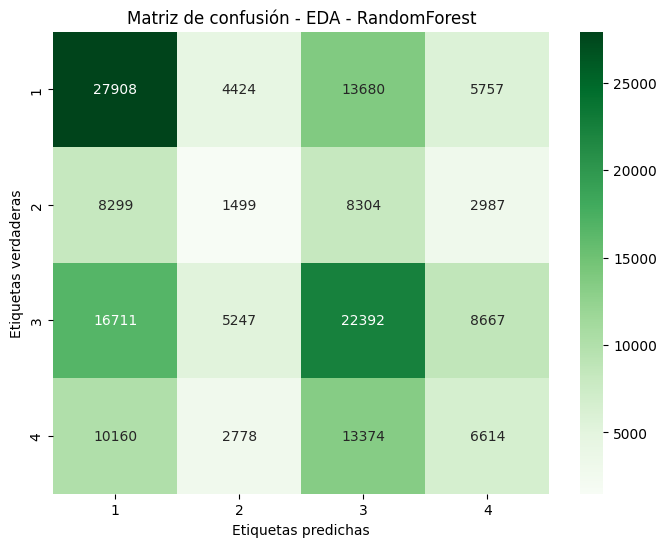

              precision    recall  f1-score   support

           1       0.44      0.54      0.49     51769
           2       0.11      0.07      0.09     21089
           3       0.39      0.42      0.40     53017
           4       0.28      0.20      0.23     32926

    accuracy                           0.37    158801
   macro avg       0.30      0.31      0.30    158801
weighted avg       0.35      0.37      0.35    158801

Training AdaBoost model for EDA using LOGO...
[EDA - AdaBoost] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 32 candidates, totalling 832 fits
[EDA - AdaBoost] Fold 1/26 (Subject: 4)
[EDA - AdaBoost] Fold 2/26 (Subject: 6)
[EDA - AdaBoost] Fold 3/26 (Subject: 7)
[EDA - AdaBoost] Fold 4/26 (Subject: 8)
[EDA - AdaBoost] Fold 5/26 (Subject: 9)
[EDA - AdaBoost] Fold 6/26 (Subject: 10)
[EDA - AdaBoost] Fold 7/26 (Subject: 11)
[EDA - AdaBoost] Fold 8/26 (Subject: 13)
[EDA - AdaBoost] Fold 9/26 (Subject: 14)
[EDA - AdaBoost] Fold 10/26 (Subject: 15)
[ED

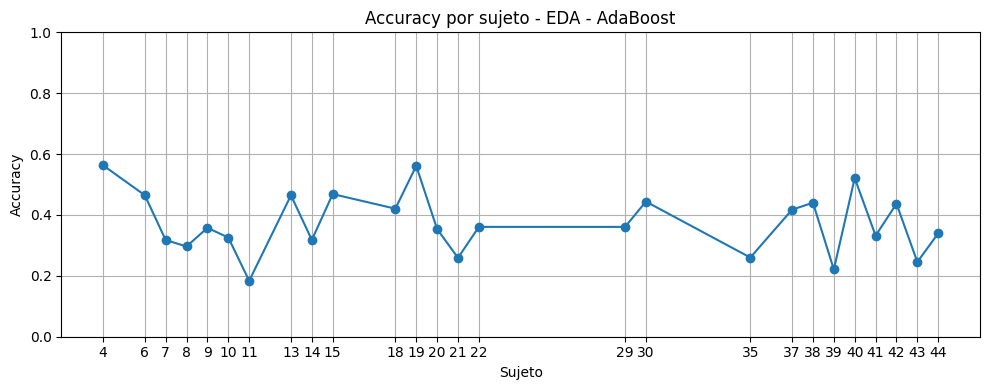

EDA - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.374563  EDA - AdaBoost
1  Precision  0.386016  EDA - AdaBoost
2     Recall  0.374563  EDA - AdaBoost
3   F1 Score  0.376863  EDA - AdaBoost
[EDA - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=1), 'learning_rate': 0.5, 'n_estimators': 300}
[EDA - AdaBoost] Accuracy: 0.3746
EDA - AdaBoost - Confusion Matrix
[[27358  9005  8705  6701]
 [ 7186  3783  6230  3890]
 [12797 10129 16609 13482]
 [ 8731  4620  7844 11731]]


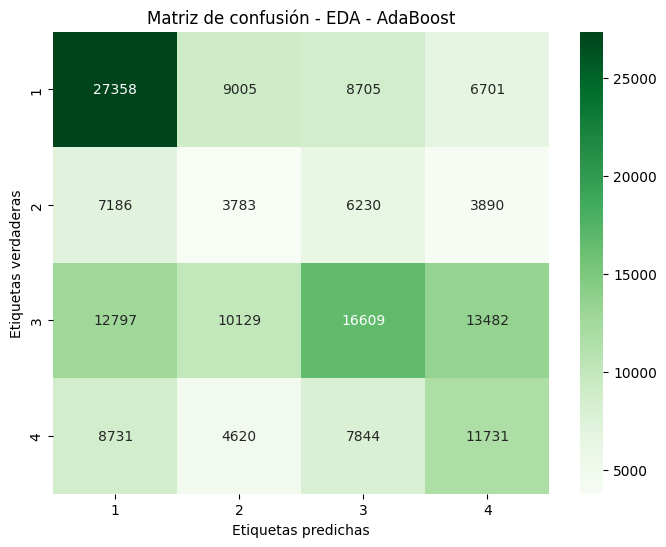

              precision    recall  f1-score   support

           1       0.49      0.53      0.51     51769
           2       0.14      0.18      0.16     21089
           3       0.42      0.31      0.36     53017
           4       0.33      0.36      0.34     32926

    accuracy                           0.37    158801
   macro avg       0.34      0.34      0.34    158801
weighted avg       0.39      0.37      0.38    158801

Training LDA model for EDA using LOGO...
[EDA - LDA] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 1 candidates, totalling 26 fits
[EDA - LDA] Fold 1/26 (Subject: 4)
[EDA - LDA] Fold 2/26 (Subject: 6)
[EDA - LDA] Fold 3/26 (Subject: 7)
[EDA - LDA] Fold 4/26 (Subject: 8)
[EDA - LDA] Fold 5/26 (Subject: 9)
[EDA - LDA] Fold 6/26 (Subject: 10)
[EDA - LDA] Fold 7/26 (Subject: 11)
[EDA - LDA] Fold 8/26 (Subject: 13)
[EDA - LDA] Fold 9/26 (Subject: 14)
[EDA - LDA] Fold 10/26 (Subject: 15)
[EDA - LDA] Fold 11/26 (Subject: 18)
[EDA - LDA] Fold 12/26 (Subj

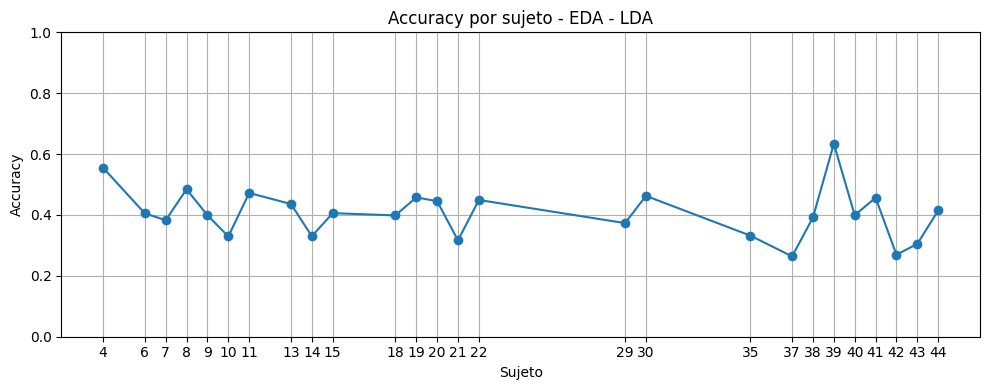

EDA - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.406641  EDA - LDA
1  Precision  0.335006  EDA - LDA
2     Recall  0.406641  EDA - LDA
3   F1 Score  0.331458  EDA - LDA
[EDA - LDA] Best Params: {'solver': 'svd'}
[EDA - LDA] Accuracy: 0.4066
EDA - LDA - Confusion Matrix
[[34396     5 16578   790]
 [10877     1  9781   430]
 [22656     7 29392   962]
 [15205     0 16935   786]]


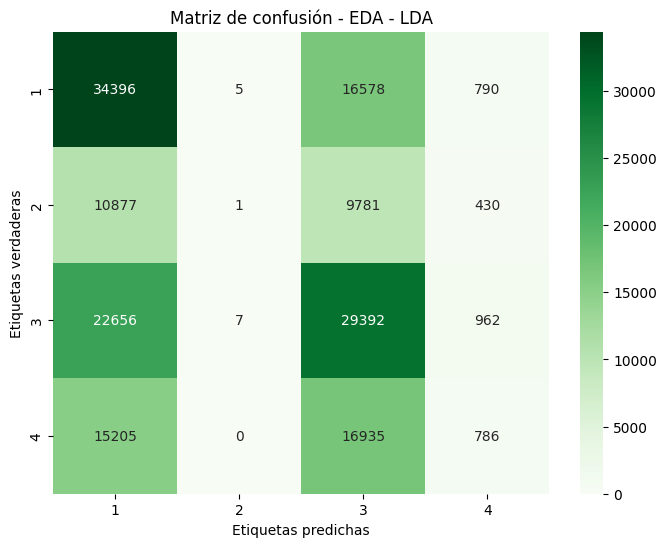

              precision    recall  f1-score   support

           1       0.41      0.66      0.51     51769
           2       0.08      0.00      0.00     21089
           3       0.40      0.55      0.47     53017
           4       0.26      0.02      0.04     32926

    accuracy                           0.41    158801
   macro avg       0.29      0.31      0.26    158801
weighted avg       0.34      0.41      0.33    158801

Training KNN model for EDA using LOGO...
[EDA - KNN] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 8 candidates, totalling 208 fits
[EDA - KNN] Fold 1/26 (Subject: 4)
[EDA - KNN] Fold 2/26 (Subject: 6)
[EDA - KNN] Fold 3/26 (Subject: 7)
[EDA - KNN] Fold 4/26 (Subject: 8)
[EDA - KNN] Fold 5/26 (Subject: 9)
[EDA - KNN] Fold 6/26 (Subject: 10)
[EDA - KNN] Fold 7/26 (Subject: 11)
[EDA - KNN] Fold 8/26 (Subject: 13)
[EDA - KNN] Fold 9/26 (Subject: 14)
[EDA - KNN] Fold 10/26 (Subject: 15)
[EDA - KNN] Fold 11/26 (Subject: 18)
[EDA - KNN] Fold 12/26 (Sub

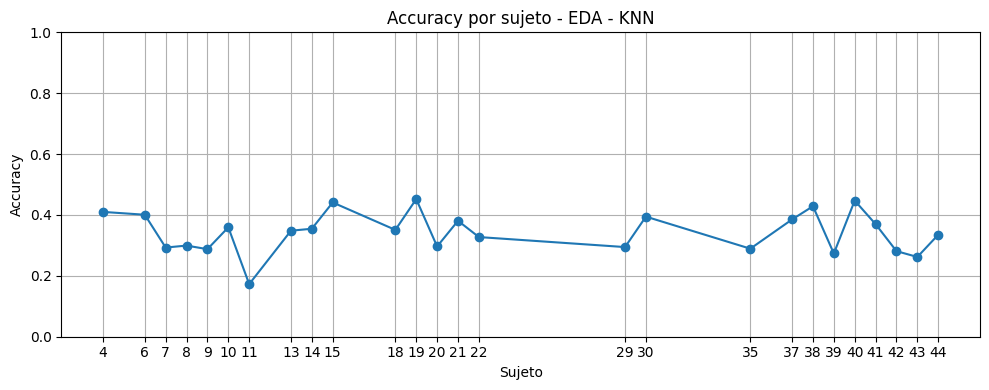

EDA - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.343864  EDA - KNN
1  Precision  0.333581  EDA - KNN
2     Recall  0.343864  EDA - KNN
3   F1 Score  0.337581  EDA - KNN
[EDA - KNN] Best Params: {'n_neighbors': 9, 'weights': 'uniform'}
[EDA - KNN] Accuracy: 0.3439
EDA - KNN - Confusion Matrix
[[25404  5717 13554  7094]
 [ 7384  2278  7381  4046]
 [17050  6446 19574  9947]
 [10043  3809 11724  7350]]


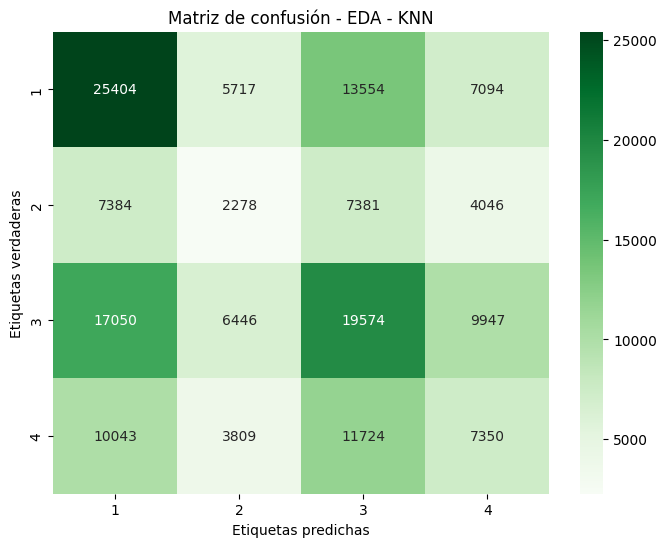

Training by signal:  75%|███████▌  | 3/4 [35:23:42<11:41:30, 42090.81s/it]

              precision    recall  f1-score   support

           1       0.42      0.49      0.46     51769
           2       0.12      0.11      0.12     21089
           3       0.37      0.37      0.37     53017
           4       0.26      0.22      0.24     32926

    accuracy                           0.34    158801
   macro avg       0.30      0.30      0.30    158801
weighted avg       0.33      0.34      0.34    158801

Training DecisionTree model for RESP using LOGO...
[RESP - DecisionTree] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 120 candidates, totalling 3120 fits
[RESP - DecisionTree] Fold 1/26 (Subject: 4)
[RESP - DecisionTree] Fold 2/26 (Subject: 6)
[RESP - DecisionTree] Fold 3/26 (Subject: 7)
[RESP - DecisionTree] Fold 4/26 (Subject: 8)
[RESP - DecisionTree] Fold 5/26 (Subject: 9)
[RESP - DecisionTree] Fold 6/26 (Subject: 10)
[RESP - DecisionTree] Fold 7/26 (Subject: 11)
[RESP - DecisionTree] Fold 8/26 (Subject: 13)
[RESP - DecisionTree] Fold 9/26 (S

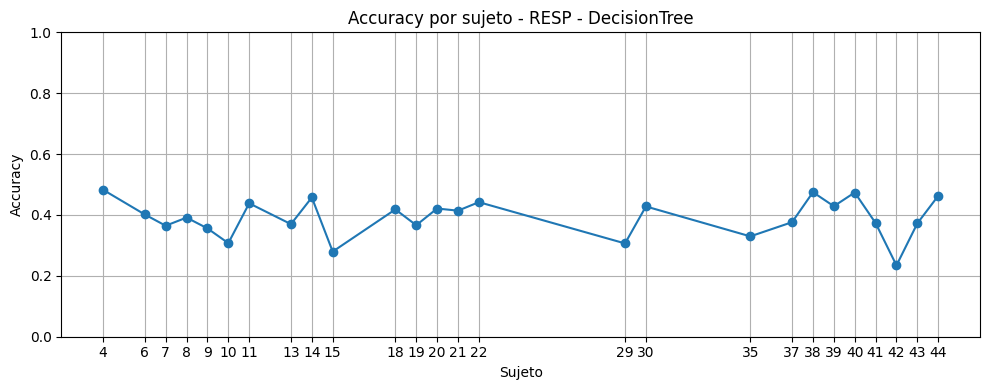

RESP - DecisionTree Metrics
     Métrica     Valor                Etapa
0   Accuracy  0.391219  RESP - DecisionTree
1  Precision  0.341249  RESP - DecisionTree
2     Recall  0.391219  RESP - DecisionTree
3   F1 Score  0.352964  RESP - DecisionTree
[RESP - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 3, 'max_leaf_nodes': 10, 'min_samples_split': 2}
[RESP - DecisionTree] Accuracy: 0.3912
RESP - DecisionTree - Confusion Matrix
[[26126  2166 17112  6365]
 [ 9283   897  8347  2562]
 [14990  1134 31873  5020]
 [14168  1312 14216  3230]]


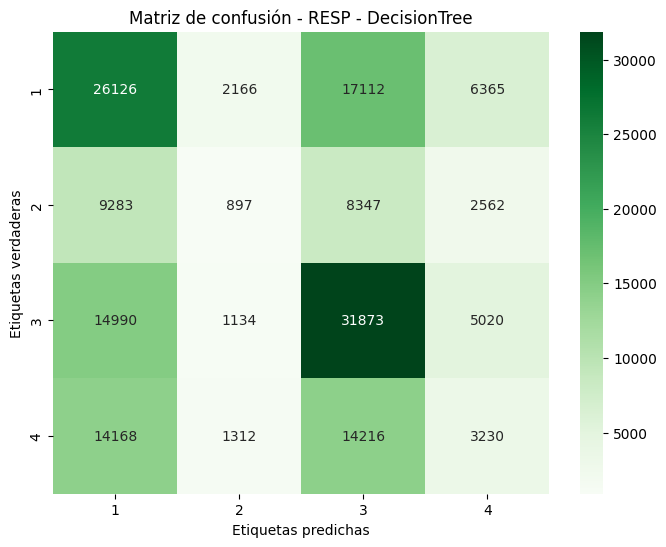

              precision    recall  f1-score   support

           1       0.40      0.50      0.45     51769
           2       0.16      0.04      0.07     21089
           3       0.45      0.60      0.51     53017
           4       0.19      0.10      0.13     32926

    accuracy                           0.39    158801
   macro avg       0.30      0.31      0.29    158801
weighted avg       0.34      0.39      0.35    158801

Training RandomForest model for RESP using LOGO...
[RESP - RandomForest] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 72 candidates, totalling 1872 fits
[RESP - RandomForest] Fold 1/26 (Subject: 4)
[RESP - RandomForest] Fold 2/26 (Subject: 6)
[RESP - RandomForest] Fold 3/26 (Subject: 7)
[RESP - RandomForest] Fold 4/26 (Subject: 8)
[RESP - RandomForest] Fold 5/26 (Subject: 9)
[RESP - RandomForest] Fold 6/26 (Subject: 10)
[RESP - RandomForest] Fold 7/26 (Subject: 11)
[RESP - RandomForest] Fold 8/26 (Subject: 13)
[RESP - RandomForest] Fold 9/26 (Su

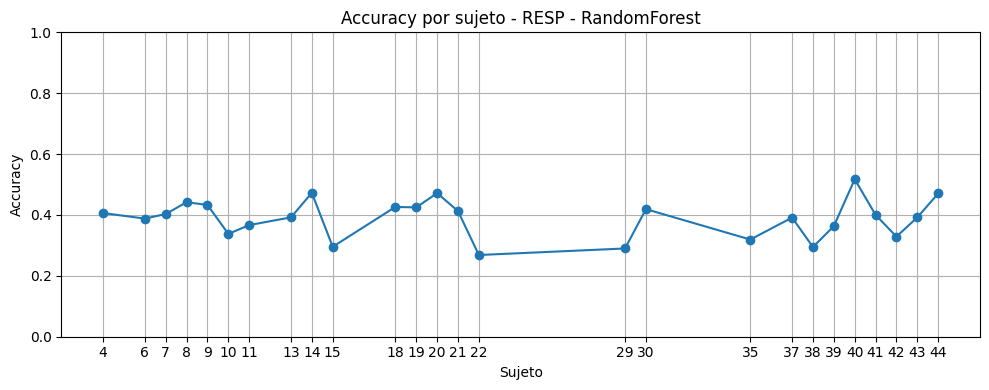

RESP - RandomForest Metrics
     Métrica     Valor                Etapa
0   Accuracy  0.389273  RESP - RandomForest
1  Precision  0.349812  RESP - RandomForest
2     Recall  0.389273  RESP - RandomForest
3   F1 Score  0.361147  RESP - RandomForest
[RESP - RandomForest] Best Params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
[RESP - RandomForest] Accuracy: 0.3893
RESP - RandomForest - Confusion Matrix
[[26803  2929 14848  7189]
 [ 9657  1514  6809  3109]
 [15595  1885 29652  5885]
 [13891  2413 12774  3848]]


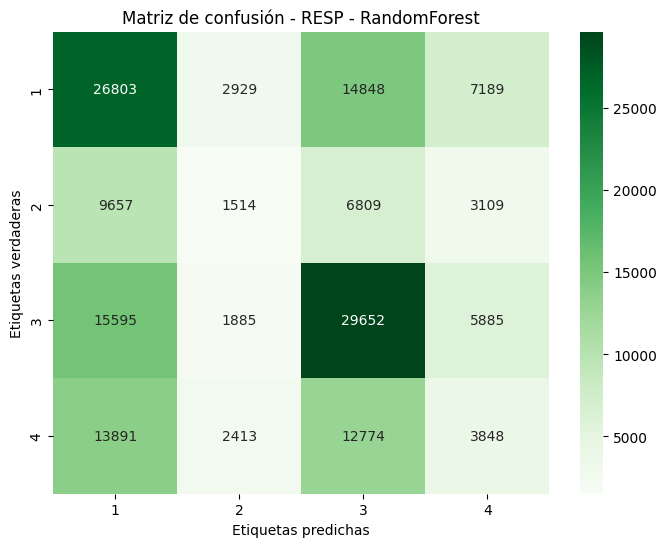

              precision    recall  f1-score   support

           1       0.41      0.52      0.46     51769
           2       0.17      0.07      0.10     21089
           3       0.46      0.56      0.51     53017
           4       0.19      0.12      0.15     32926

    accuracy                           0.39    158801
   macro avg       0.31      0.32      0.30    158801
weighted avg       0.35      0.39      0.36    158801

Training AdaBoost model for RESP using LOGO...
[RESP - AdaBoost] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 32 candidates, totalling 832 fits
[RESP - AdaBoost] Fold 1/26 (Subject: 4)
[RESP - AdaBoost] Fold 2/26 (Subject: 6)
[RESP - AdaBoost] Fold 3/26 (Subject: 7)
[RESP - AdaBoost] Fold 4/26 (Subject: 8)
[RESP - AdaBoost] Fold 5/26 (Subject: 9)
[RESP - AdaBoost] Fold 6/26 (Subject: 10)
[RESP - AdaBoost] Fold 7/26 (Subject: 11)
[RESP - AdaBoost] Fold 8/26 (Subject: 13)
[RESP - AdaBoost] Fold 9/26 (Subject: 14)
[RESP - AdaBoost] Fold 10/26 (Subj

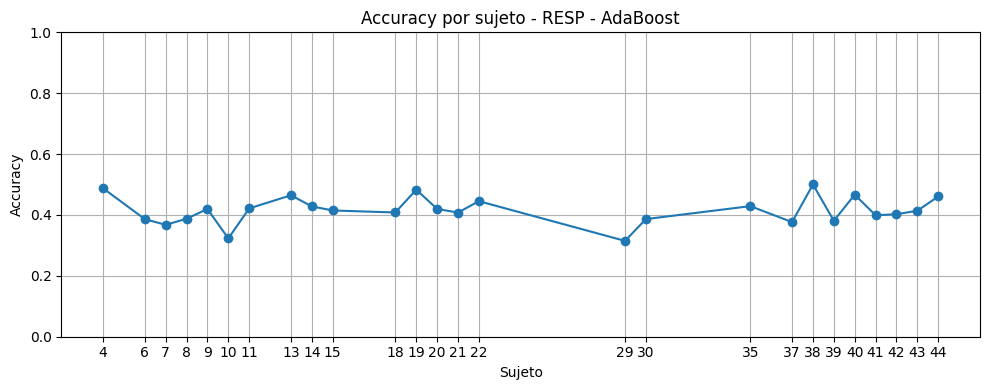

RESP - AdaBoost Metrics
     Métrica     Valor            Etapa
0   Accuracy  0.415570  RESP - AdaBoost
1  Precision  0.333873  RESP - AdaBoost
2     Recall  0.415570  RESP - AdaBoost
3   F1 Score  0.339653  RESP - AdaBoost
[RESP - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=1), 'learning_rate': 0.01, 'n_estimators': 50}
[RESP - AdaBoost] Accuracy: 0.4156
RESP - AdaBoost - Confusion Matrix
[[32943   387 17477   962]
 [12504   182  8055   348]
 [19355   353 32453   856]
 [18226   242 14043   415]]


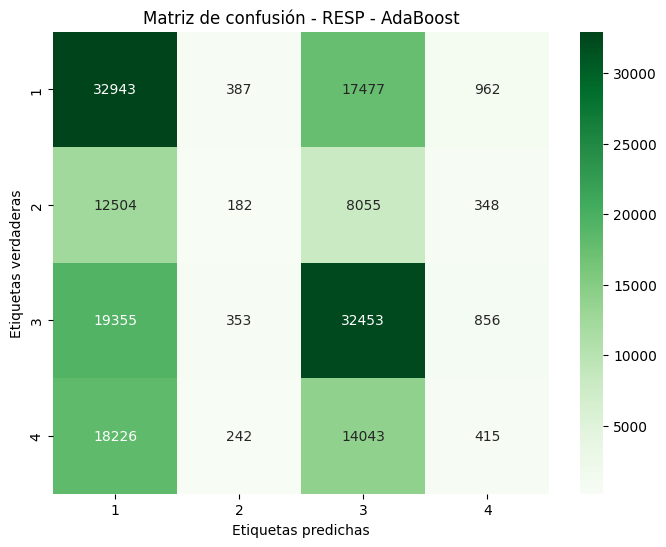

              precision    recall  f1-score   support

           1       0.40      0.64      0.49     51769
           2       0.16      0.01      0.02     21089
           3       0.45      0.61      0.52     53017
           4       0.16      0.01      0.02     32926

    accuracy                           0.42    158801
   macro avg       0.29      0.32      0.26    158801
weighted avg       0.33      0.42      0.34    158801

Training LDA model for RESP using LOGO...
[RESP - LDA] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 1 candidates, totalling 26 fits
[RESP - LDA] Fold 1/26 (Subject: 4)
[RESP - LDA] Fold 2/26 (Subject: 6)
[RESP - LDA] Fold 3/26 (Subject: 7)
[RESP - LDA] Fold 4/26 (Subject: 8)
[RESP - LDA] Fold 5/26 (Subject: 9)
[RESP - LDA] Fold 6/26 (Subject: 10)
[RESP - LDA] Fold 7/26 (Subject: 11)
[RESP - LDA] Fold 8/26 (Subject: 13)
[RESP - LDA] Fold 9/26 (Subject: 14)
[RESP - LDA] Fold 10/26 (Subject: 15)
[RESP - LDA] Fold 11/26 (Subject: 18)
[RESP - LDA] Fo

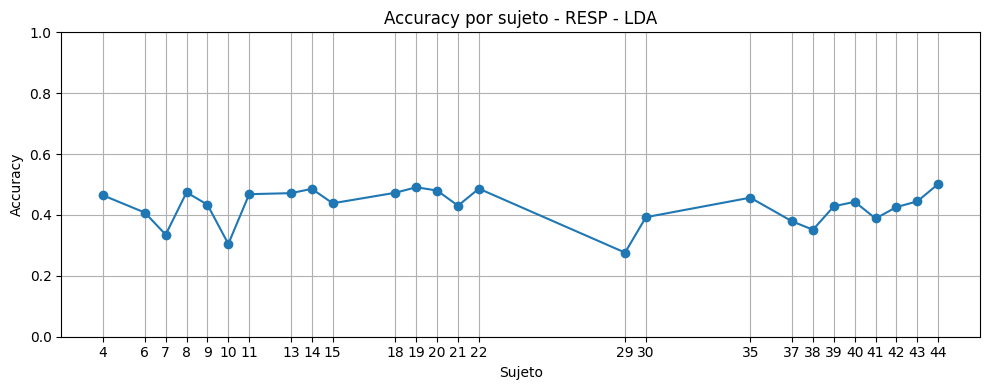

RESP - LDA Metrics
     Métrica     Valor       Etapa
0   Accuracy  0.428442  RESP - LDA
1  Precision  0.417551  RESP - LDA
2     Recall  0.428442  RESP - LDA
3   F1 Score  0.548584  RESP - LDA
[RESP - LDA] Best Params: {'solver': 'svd'}
[RESP - LDA] Accuracy: 0.4284
RESP - LDA - Confusion Matrix
[[34851     0 16916     2]
 [13092     0  7997     0]
 [19795     0 33186    36]
 [18899     0 14027     0]]


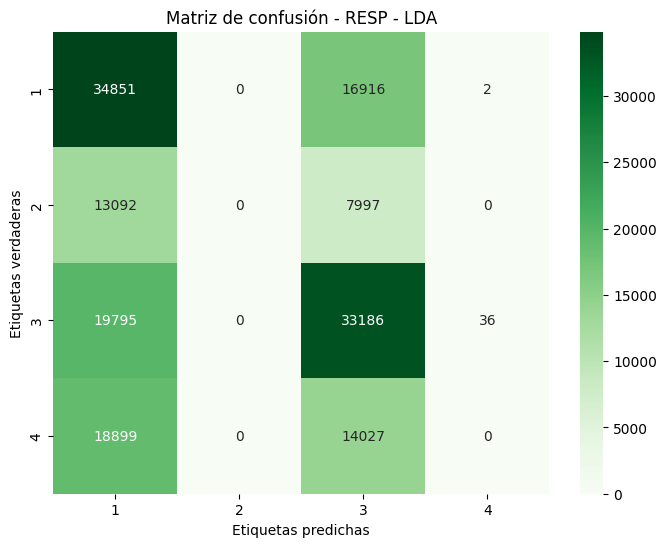

c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.40      0.67      0.50     51769
           2       0.00      0.00      0.00     21089
           3       0.46      0.63      0.53     53017
           4       0.00      0.00      0.00     32926

    accuracy                           0.43    158801
   macro avg       0.22      0.32      0.26    158801
weighted avg       0.28      0.43      0.34    158801

Training KNN model for RESP using LOGO...
[RESP - KNN] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 8 candidates, totalling 208 fits
[RESP - KNN] Fold 1/26 (Subject: 4)
[RESP - KNN] Fold 2/26 (Subject: 6)
[RESP - KNN] Fold 3/26 (Subject: 7)
[RESP - KNN] Fold 4/26 (Subject: 8)
[RESP - KNN] Fold 5/26 (Subject: 9)
[RESP - KNN] Fold 6/26 (Subject: 10)
[RESP - KNN] Fold 7/26 (Subject: 11)
[RESP - KNN] Fold 8/26 (Subject: 13)
[RESP - KNN] Fold 9/26 (Subject: 14)
[RESP - KNN] Fold 10/26 (Subject: 15)
[RESP - KNN] Fold 11/26 (Subject: 18)
[RESP - KNN] F

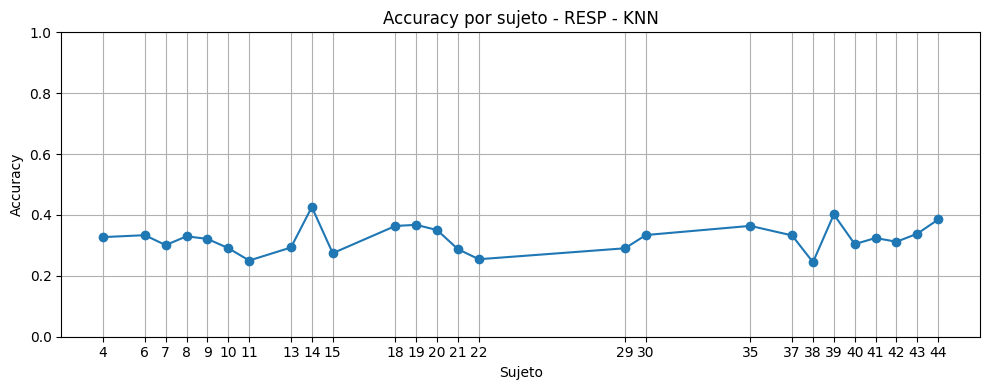

RESP - KNN Metrics
     Métrica     Valor       Etapa
0   Accuracy  0.323115  RESP - KNN
1  Precision  0.318162  RESP - KNN
2     Recall  0.323115  RESP - KNN
3   F1 Score  0.320175  RESP - KNN
[RESP - KNN] Best Params: {'n_neighbors': 9, 'weights': 'uniform'}
[RESP - KNN] Accuracy: 0.3231
RESP - KNN - Confusion Matrix
[[19168  6685 16496  9420]
 [ 6880  2862  6378  4969]
 [13968  5599 23076 10374]
 [ 9704  4360 12657  6205]]


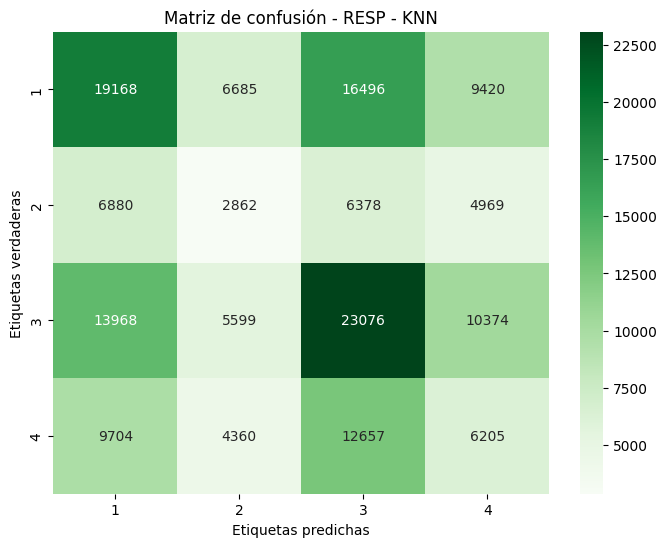

Training by signal: 100%|██████████| 4/4 [43:53:29<00:00, 39502.44s/it]   


              precision    recall  f1-score   support

           1       0.39      0.37      0.38     51769
           2       0.15      0.14      0.14     21089
           3       0.39      0.44      0.41     53017
           4       0.20      0.19      0.19     32926

    accuracy                           0.32    158801
   macro avg       0.28      0.28      0.28    158801
weighted avg       0.32      0.32      0.32    158801



Training with ALL signals:   0%|          | 0/5 [00:00<?, ?it/s]

Training DecisionTree model for ALL signals using LOGO...
[ALL - DecisionTree] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 120 candidates, totalling 3120 fits
[ALL - DecisionTree] Fold 1/26 (Subject: 4)
[ALL - DecisionTree] Fold 2/26 (Subject: 6)
[ALL - DecisionTree] Fold 3/26 (Subject: 7)
[ALL - DecisionTree] Fold 4/26 (Subject: 8)
[ALL - DecisionTree] Fold 5/26 (Subject: 9)
[ALL - DecisionTree] Fold 6/26 (Subject: 10)
[ALL - DecisionTree] Fold 7/26 (Subject: 11)
[ALL - DecisionTree] Fold 8/26 (Subject: 13)
[ALL - DecisionTree] Fold 9/26 (Subject: 14)
[ALL - DecisionTree] Fold 10/26 (Subject: 15)
[ALL - DecisionTree] Fold 11/26 (Subject: 18)
[ALL - DecisionTree] Fold 12/26 (Subject: 19)
[ALL - DecisionTree] Fold 13/26 (Subject: 20)
[ALL - DecisionTree] Fold 14/26 (Subject: 21)
[ALL - DecisionTree] Fold 15/26 (Subject: 22)
[ALL - DecisionTree] Fold 16/26 (Subject: 29)
[ALL - DecisionTree] Fold 17/26 (Subject: 30)
[ALL - DecisionTree] Fold 18/26 (Subject: 35)
[ALL - Decis

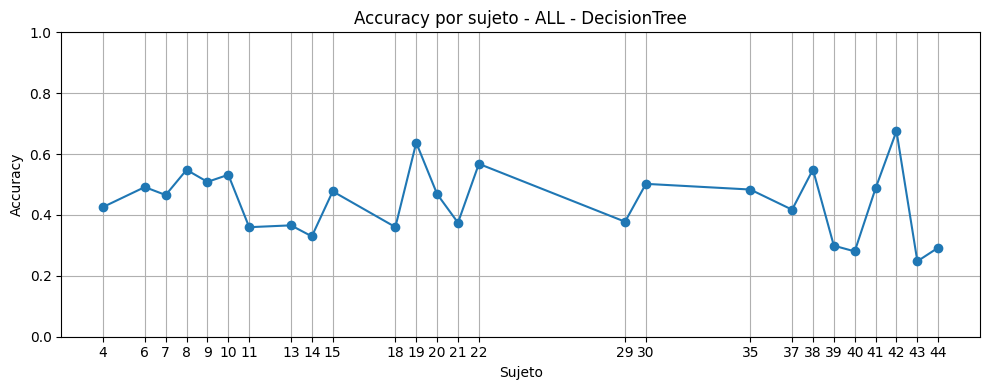

ALL - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.443675  ALL - DecisionTree
1  Precision  0.414091  ALL - DecisionTree
2     Recall  0.443675  ALL - DecisionTree
3   F1 Score  0.418539  ALL - DecisionTree
[ALL - DecisionTree] Best Params: {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 10, 'min_samples_split': 2}
[ALL - DecisionTree] Accuracy: 0.4437
ALL - DecisionTree - Confusion Matrix
[[37373  3019  5770  5607]
 [10318  2236  5786  2749]
 [14718  7228 25576  5495]
 [12368  3857 11430  5271]]


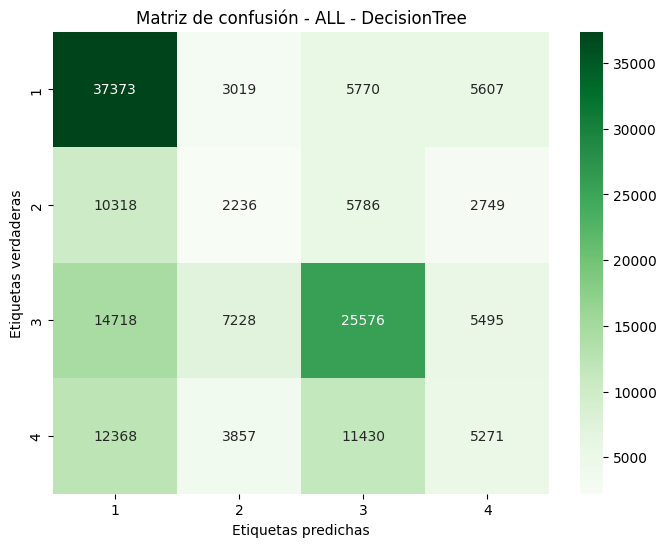

Training with ALL signals:  20%|██        | 1/5 [48:24<3:13:37, 2904.42s/it]

              precision    recall  f1-score   support

           1       0.50      0.72      0.59     51769
           2       0.14      0.11      0.12     21089
           3       0.53      0.48      0.50     53017
           4       0.28      0.16      0.20     32926

    accuracy                           0.44    158801
   macro avg       0.36      0.37      0.35    158801
weighted avg       0.41      0.44      0.42    158801

Training RandomForest model for ALL signals using LOGO...
[ALL - RandomForest] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 72 candidates, totalling 1872 fits
[ALL - RandomForest] Fold 1/26 (Subject: 4)
[ALL - RandomForest] Fold 2/26 (Subject: 6)
[ALL - RandomForest] Fold 3/26 (Subject: 7)
[ALL - RandomForest] Fold 4/26 (Subject: 8)
[ALL - RandomForest] Fold 5/26 (Subject: 9)
[ALL - RandomForest] Fold 6/26 (Subject: 10)
[ALL - RandomForest] Fold 7/26 (Subject: 11)
[ALL - RandomForest] Fold 8/26 (Subject: 13)
[ALL - RandomForest] Fold 9/26 (Subje

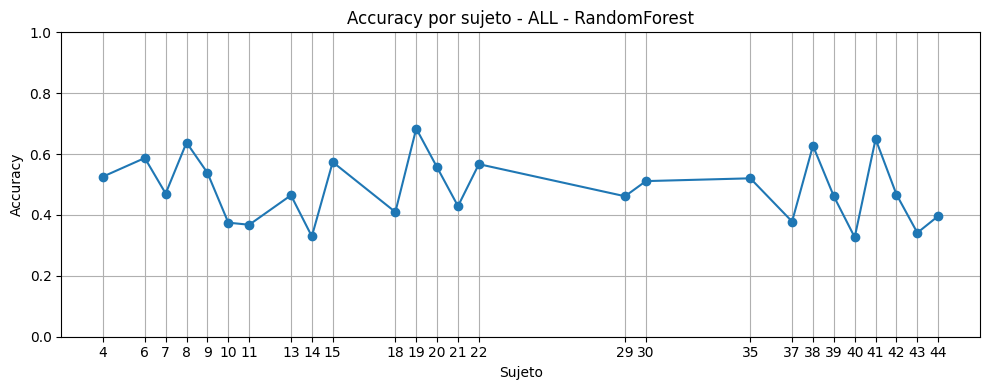

ALL - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.487497  ALL - RandomForest
1  Precision  0.453415  ALL - RandomForest
2     Recall  0.487497  ALL - RandomForest
3   F1 Score  0.462689  ALL - RandomForest
[ALL - RandomForest] Best Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 300}
[ALL - RandomForest] Accuracy: 0.4875
ALL - RandomForest - Confusion Matrix
[[33624  3703 10138  4304]
 [ 7030  2063  8324  3672]
 [ 9527  2830 34199  6461]
 [ 7652  2426 15319  7529]]


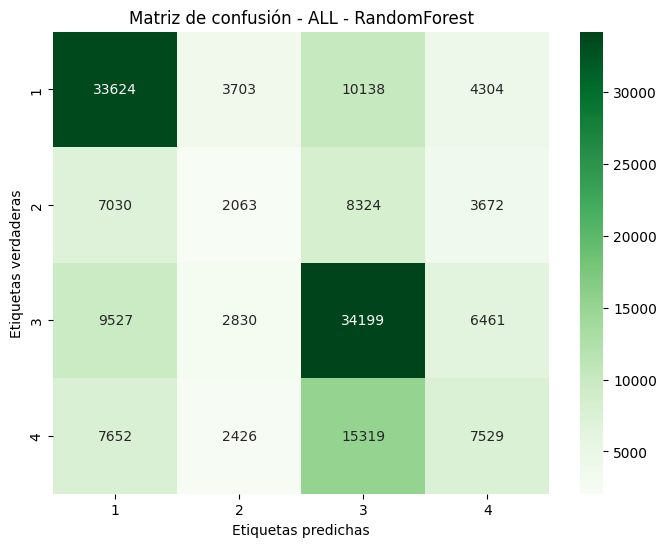

Training with ALL signals:  40%|████      | 2/5 [17:50:38<31:03:43, 37274.53s/it]

              precision    recall  f1-score   support

           1       0.58      0.65      0.61     51769
           2       0.19      0.10      0.13     21089
           3       0.50      0.65      0.57     53017
           4       0.34      0.23      0.27     32926

    accuracy                           0.49    158801
   macro avg       0.40      0.41      0.40    158801
weighted avg       0.45      0.49      0.46    158801

Training AdaBoost model for ALL signals using LOGO...
[ALL - AdaBoost] LOGO: 26 folds (1 por sujeto)
Fitting 26 folds for each of 32 candidates, totalling 832 fits


In [ ]:
"""for signal, features in tqdm(SIGNAL_CATEGORIES.items(), desc="Training by signal"):
    if all(f in df.columns for f in features):  # Verificar que todas las columnas existen
        X = df[features].values  # Convertimos a array
        y = df['label'].values
        subjects = df['subject'].values  # Identificador de sujetos

        for model_name, (model, param_grid) in models.items():
            print(f'Training {model_name} model for {signal} using LOGO...')
            metrics = train_and_evaluate_logo(X, y, subjects, model, param_grid, model_name, signal)
            results[(signal, model_name)] = metrics.copy()

# Entrenamiento con todas las señales combinadas usando LOGO
X_all = df.drop(columns=['label', 'subject']).values
y_all = df['label'].values
subjects_all = df['subject'].values

for model_name, (model, param_grid) in tqdm(models.items(), desc="Training with ALL signals"):
    print(f'Training {model_name} model for ALL signals using LOGO...')
    metrics = train_and_evaluate_logo(X_all, y_all, subjects_all, model, param_grid, model_name, "ALL")
    results[("ALL", model_name)] = metrics.copy()

# Mostrar resultados finales
print("\nFinal Comparison:")
for (signal, model_name), acc in results.items():
    print(f'{signal} - {model_name}:')
    print(acc)

# Crear heatmap
rows = []
for (signal, model), df_metrics in results.items():
    metric_values = df_metrics.set_index('Métrica')['Valor']
    
    row = {
        'Signal': signal,
        'Model': model,
        'Accuracy': metric_values.get('Accuracy', None),
        'F1': metric_values.get('F1 Score', None),
        'Precision': metric_values.get('Precision', None),
        'Recall': metric_values.get('Recall', None)
    }
    rows.append(row)

metrics_df = pd.DataFrame(rows)

pivot_df = metrics_df.pivot(index='Signal', columns='Model', values='Accuracy')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, cmap="Blues", fmt=".2f")
plt.title('Heatmap de Accuracy por señal y modelo (LOSO)')
plt.tight_layout()
plt.show()


data = []
metrics = ["Accuracy", "F1 Score", "Recall", "Precision"]

for (signal, model), df in results.items():
    for metric in metrics:
        row = df[df["Métrica"] == metric]
        if not row.empty:
            value = row["Valor"].values[0]
            data.append((signal, model, metric, value))

df_all = pd.DataFrame(data, columns=["Signal", "Model", "Metric", "Value"])

# Paleta bonita
palette = sns.color_palette("Set1")

# Hacer el FacetGrid
g = sns.FacetGrid(df_all, col="Metric", sharey=True, col_wrap=2, height=4, aspect=1.5)
g.map_dataframe(sns.barplot, x="Model", y="Value", hue="Signal", palette=palette, width=0.7, dodge=True)  # <-- aquí el width más pequeño

# Ajustes para la leyenda
g.add_legend(title="Señal", bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0)

# Añadir etiquetas de valores
for ax in g.axes.flatten():
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=7, padding=2)
    ax.set_ylim(0, 1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()"""

Training by signal combinations:   0%|          | 0/11 [00:00<?, ?it/s]

Training DecisionTree model for ('ECG', 'PPG') using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
('ECG', 'PPG') - DecisionTree Metrics
     Métrica     Valor                          Etapa
0   Accuracy  0.588985  ('ECG', 'PPG') - DecisionTree
1  Precision  0.670306  ('ECG', 'PPG') - DecisionTree
2     Recall  0.588985  ('ECG', 'PPG') - DecisionTree
3   F1 Score  0.612152  ('ECG', 'PPG') - DecisionTree
[('ECG', 'PPG') - DecisionTree] Best Params: {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[('ECG', 'PPG') - DecisionTree] Accuracy: 0.5890
('ECG', 'PPG') - DecisionTree - Confusion Matrix
[[3012  901   97  379]
 [ 389 1120  169  116]
 [ 147 1085 2685  471]
 [ 117 1123  491 1043]]


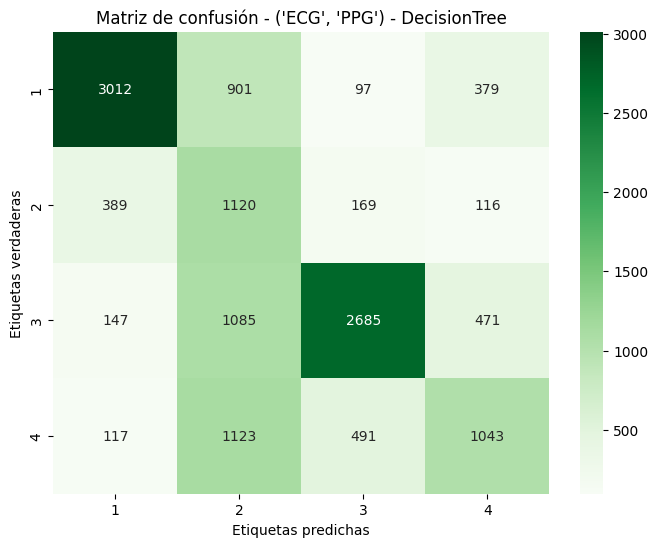

              precision    recall  f1-score   support

           1       0.82      0.69      0.75      4389
           2       0.26      0.62      0.37      1794
           3       0.78      0.61      0.69      4388
           4       0.52      0.38      0.44      2774

    accuracy                           0.59     13345
   macro avg       0.60      0.57      0.56     13345
weighted avg       0.67      0.59      0.61     13345

Training RandomForest model for ('ECG', 'PPG') using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
('ECG', 'PPG') - RandomForest Metrics
     Métrica     Valor                          Etapa
0   Accuracy  0.990259  ('ECG', 'PPG') - RandomForest
1  Precision  0.990265  ('ECG', 'PPG') - RandomForest
2     Recall  0.990259  ('ECG', 'PPG') - RandomForest
3   F1 Score  0.990246  ('ECG', 'PPG') - RandomForest
[('ECG', 'PPG') - RandomForest] Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2,

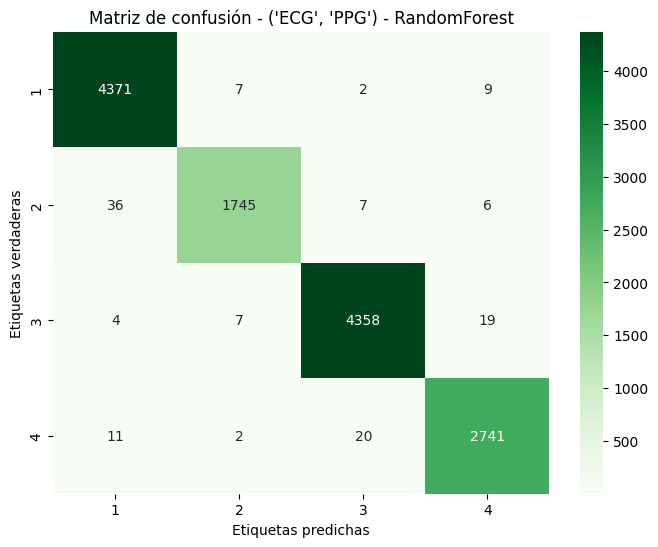

              precision    recall  f1-score   support

           1       0.99      1.00      0.99      4389
           2       0.99      0.97      0.98      1794
           3       0.99      0.99      0.99      4388
           4       0.99      0.99      0.99      2774

    accuracy                           0.99     13345
   macro avg       0.99      0.99      0.99     13345
weighted avg       0.99      0.99      0.99     13345

Training AdaBoost model for ('ECG', 'PPG') using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
('ECG', 'PPG') - AdaBoost Metrics
     Métrica     Valor                      Etapa
0   Accuracy  0.774747  ('ECG', 'PPG') - AdaBoost
1  Precision  0.776981  ('ECG', 'PPG') - AdaBoost
2     Recall  0.774747  ('ECG', 'PPG') - AdaBoost
3   F1 Score  0.775731  ('ECG', 'PPG') - AdaBoost
[('ECG', 'PPG') - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 0.5, 'n_estimators': 300}
[(

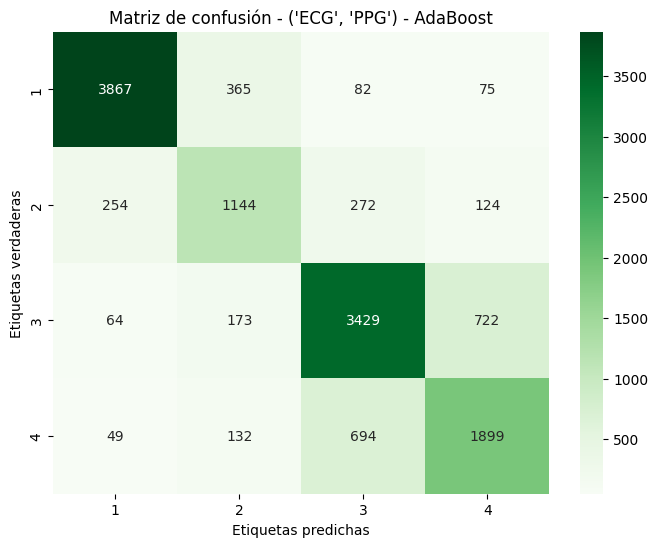

              precision    recall  f1-score   support

           1       0.91      0.88      0.90      4389
           2       0.63      0.64      0.63      1794
           3       0.77      0.78      0.77      4388
           4       0.67      0.68      0.68      2774

    accuracy                           0.77     13345
   macro avg       0.75      0.75      0.75     13345
weighted avg       0.78      0.77      0.78     13345

Training LDA model for ('ECG', 'PPG') using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
('ECG', 'PPG') - LDA Metrics
     Métrica     Valor                 Etapa
0   Accuracy  0.573248  ('ECG', 'PPG') - LDA
1  Precision  0.526458  ('ECG', 'PPG') - LDA
2     Recall  0.573248  ('ECG', 'PPG') - LDA
3   F1 Score  0.528031  ('ECG', 'PPG') - LDA
[('ECG', 'PPG') - LDA] Best Params: {'solver': 'svd'}
[('ECG', 'PPG') - LDA] Accuracy: 0.5732
('ECG', 'PPG') - LDA - Confusion Matrix
[[3436   55  549  349]
 [ 757   51  692  294]
 [ 383   35 3327  64

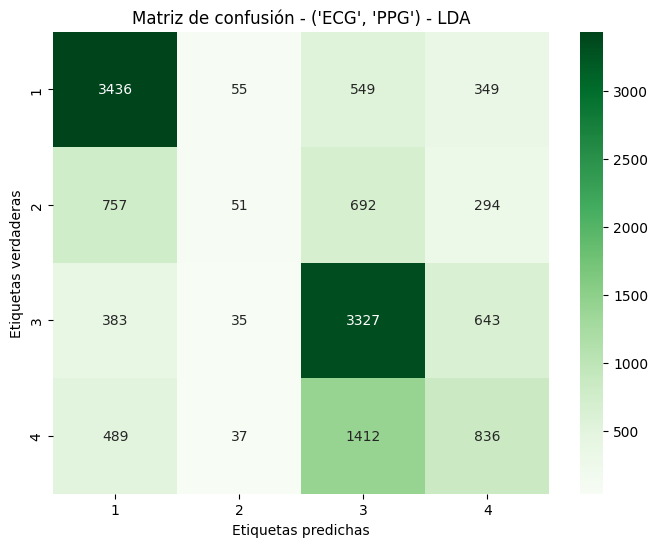

              precision    recall  f1-score   support

           1       0.68      0.78      0.73      4389
           2       0.29      0.03      0.05      1794
           3       0.56      0.76      0.64      4388
           4       0.39      0.30      0.34      2774

    accuracy                           0.57     13345
   macro avg       0.48      0.47      0.44     13345
weighted avg       0.53      0.57      0.53     13345

Training KNN model for ('ECG', 'PPG') using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
('ECG', 'PPG') - KNN Metrics
     Métrica     Valor                 Etapa
0   Accuracy  0.562383  ('ECG', 'PPG') - KNN
1  Precision  0.558856  ('ECG', 'PPG') - KNN
2     Recall  0.562383  ('ECG', 'PPG') - KNN
3   F1 Score  0.559740  ('ECG', 'PPG') - KNN
[('ECG', 'PPG') - KNN] Best Params: {'n_neighbors': 5, 'weights': 'distance'}
[('ECG', 'PPG') - KNN] Accuracy: 0.5624
('ECG', 'PPG') - KNN - Confusion Matrix
[[2837  337  760  455]
 [ 491  714  358  

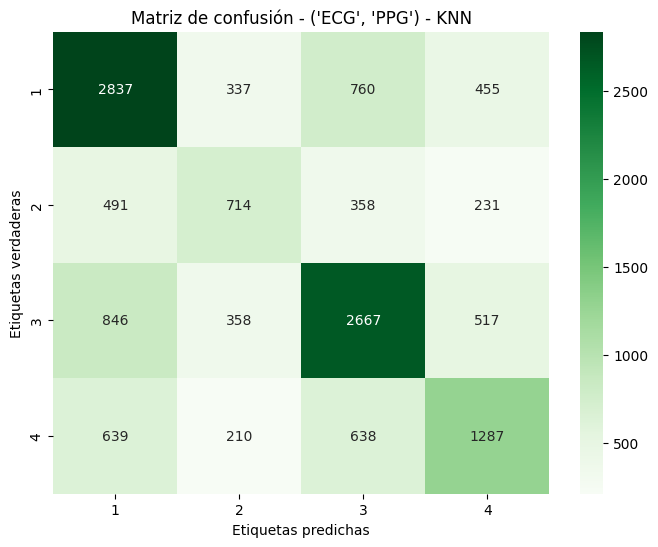

Training by signal combinations:   9%|▉         | 1/11 [1:46:10<17:41:40, 6370.09s/it]

              precision    recall  f1-score   support

           1       0.59      0.65      0.62      4389
           2       0.44      0.40      0.42      1794
           3       0.60      0.61      0.61      4388
           4       0.52      0.46      0.49      2774

    accuracy                           0.56     13345
   macro avg       0.54      0.53      0.53     13345
weighted avg       0.56      0.56      0.56     13345

Training DecisionTree model for ('ECG', 'EDA') using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
('ECG', 'EDA') - DecisionTree Metrics
     Métrica     Valor                          Etapa
0   Accuracy  0.586587  ('ECG', 'EDA') - DecisionTree
1  Precision  0.635387  ('ECG', 'EDA') - DecisionTree
2     Recall  0.586587  ('ECG', 'EDA') - DecisionTree
3   F1 Score  0.597006  ('ECG', 'EDA') - DecisionTree
[('ECG', 'EDA') - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 15, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[('

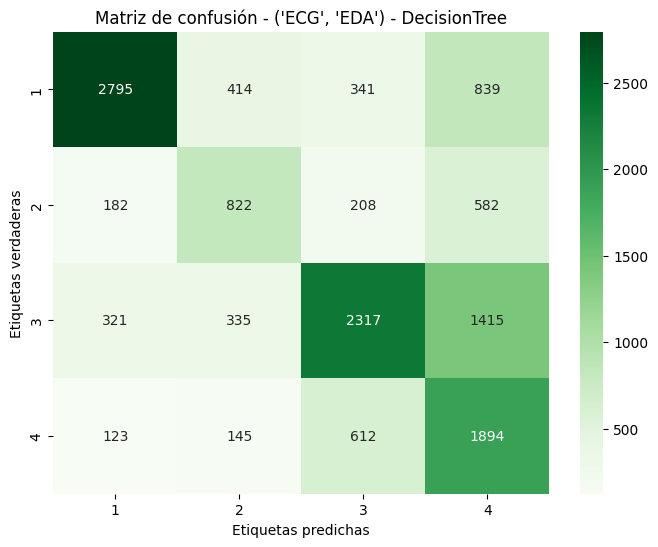

              precision    recall  f1-score   support

           1       0.82      0.64      0.72      4389
           2       0.48      0.46      0.47      1794
           3       0.67      0.53      0.59      4388
           4       0.40      0.68      0.50      2774

    accuracy                           0.59     13345
   macro avg       0.59      0.58      0.57     13345
weighted avg       0.64      0.59      0.60     13345

Training RandomForest model for ('ECG', 'EDA') using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
('ECG', 'EDA') - RandomForest Metrics
     Métrica     Valor                          Etapa
0   Accuracy  0.991682  ('ECG', 'EDA') - RandomForest
1  Precision  0.991689  ('ECG', 'EDA') - RandomForest
2     Recall  0.991682  ('ECG', 'EDA') - RandomForest
3   F1 Score  0.991683  ('ECG', 'EDA') - RandomForest
[('ECG', 'EDA') - RandomForest] Best Params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2,

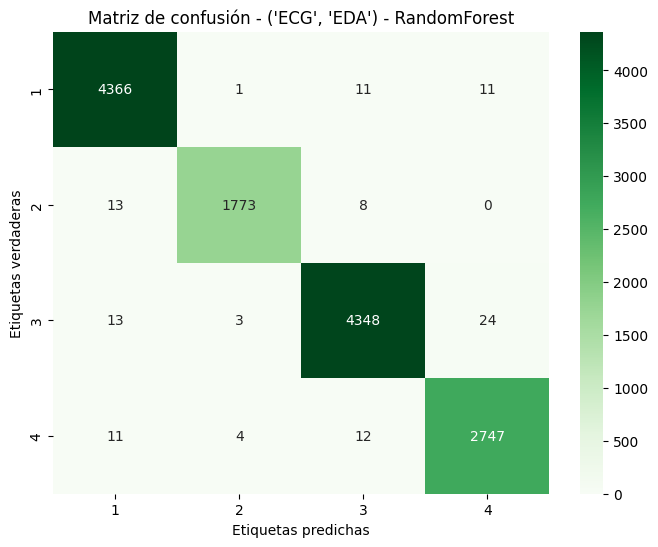

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      4389
           2       1.00      0.99      0.99      1794
           3       0.99      0.99      0.99      4388
           4       0.99      0.99      0.99      2774

    accuracy                           0.99     13345
   macro avg       0.99      0.99      0.99     13345
weighted avg       0.99      0.99      0.99     13345

Training AdaBoost model for ('ECG', 'EDA') using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
('ECG', 'EDA') - AdaBoost Metrics
     Métrica     Valor                      Etapa
0   Accuracy  0.755789  ('ECG', 'EDA') - AdaBoost
1  Precision  0.764421  ('ECG', 'EDA') - AdaBoost
2     Recall  0.755789  ('ECG', 'EDA') - AdaBoost
3   F1 Score  0.758228  ('ECG', 'EDA') - AdaBoost
[('ECG', 'EDA') - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 1, 'n_estimators': 300}
[('E

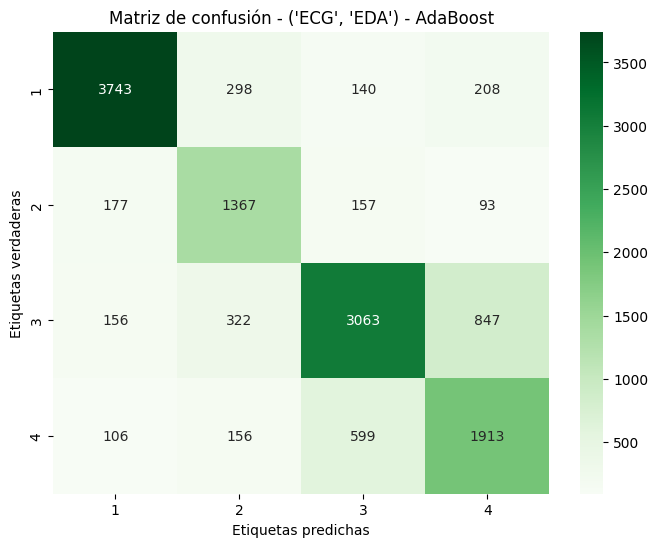

              precision    recall  f1-score   support

           1       0.90      0.85      0.87      4389
           2       0.64      0.76      0.69      1794
           3       0.77      0.70      0.73      4388
           4       0.62      0.69      0.66      2774

    accuracy                           0.76     13345
   macro avg       0.73      0.75      0.74     13345
weighted avg       0.76      0.76      0.76     13345

Training LDA model for ('ECG', 'EDA') using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
('ECG', 'EDA') - LDA Metrics
     Métrica     Valor                 Etapa
0   Accuracy  0.483102  ('ECG', 'EDA') - LDA
1  Precision  0.457868  ('ECG', 'EDA') - LDA
2     Recall  0.483102  ('ECG', 'EDA') - LDA
3   F1 Score  0.428094  ('ECG', 'EDA') - LDA
[('ECG', 'EDA') - LDA] Best Params: {'solver': 'svd'}
[('ECG', 'EDA') - LDA] Accuracy: 0.4831
('ECG', 'EDA') - LDA - Confusion Matrix
[[3412   10  675  292]
 [ 919   13  758  104]
 [1458    6 2480  44

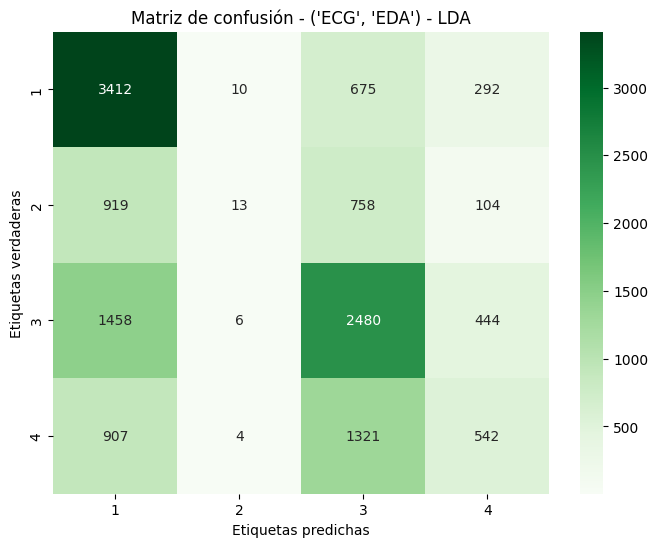

              precision    recall  f1-score   support

           1       0.51      0.78      0.62      4389
           2       0.39      0.01      0.01      1794
           3       0.47      0.57      0.52      4388
           4       0.39      0.20      0.26      2774

    accuracy                           0.48     13345
   macro avg       0.44      0.39      0.35     13345
weighted avg       0.46      0.48      0.43     13345

Training KNN model for ('ECG', 'EDA') using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
('ECG', 'EDA') - KNN Metrics
     Métrica     Valor                 Etapa
0   Accuracy  0.583589  ('ECG', 'EDA') - KNN
1  Precision  0.579558  ('ECG', 'EDA') - KNN
2     Recall  0.583589  ('ECG', 'EDA') - KNN
3   F1 Score  0.580668  ('ECG', 'EDA') - KNN
[('ECG', 'EDA') - KNN] Best Params: {'n_neighbors': 5, 'weights': 'distance'}
[('ECG', 'EDA') - KNN] Accuracy: 0.5836
('ECG', 'EDA') - KNN - Confusion Matrix
[[2964  311  708  406]
 [ 459  733  368  

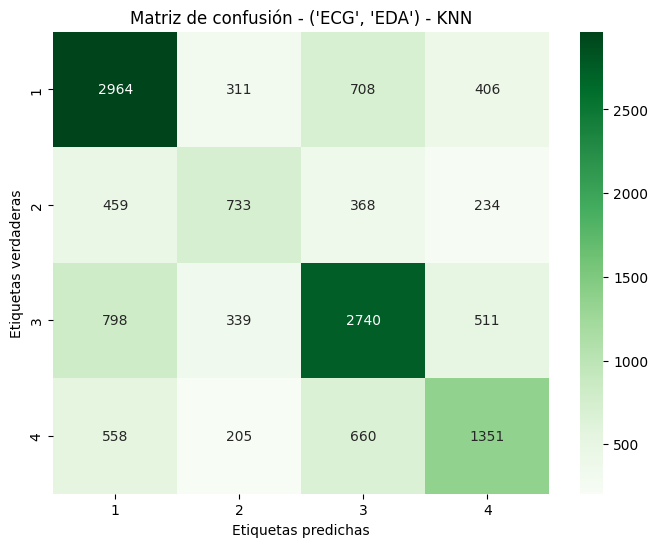

Training by signal combinations:  18%|█▊        | 2/11 [3:20:09<14:51:02, 5940.25s/it]

              precision    recall  f1-score   support

           1       0.62      0.68      0.65      4389
           2       0.46      0.41      0.43      1794
           3       0.61      0.62      0.62      4388
           4       0.54      0.49      0.51      2774

    accuracy                           0.58     13345
   macro avg       0.56      0.55      0.55     13345
weighted avg       0.58      0.58      0.58     13345

Training DecisionTree model for ('ECG', 'RESP') using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
('ECG', 'RESP') - DecisionTree Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.536980  ('ECG', 'RESP') - DecisionTree
1  Precision  0.540172  ('ECG', 'RESP') - DecisionTree
2     Recall  0.536980  ('ECG', 'RESP') - DecisionTree
3   F1 Score  0.530303  ('ECG', 'RESP') - DecisionTree
[('ECG', 'RESP') - DecisionTree] Best Params: {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 40, 'min_samples_spl

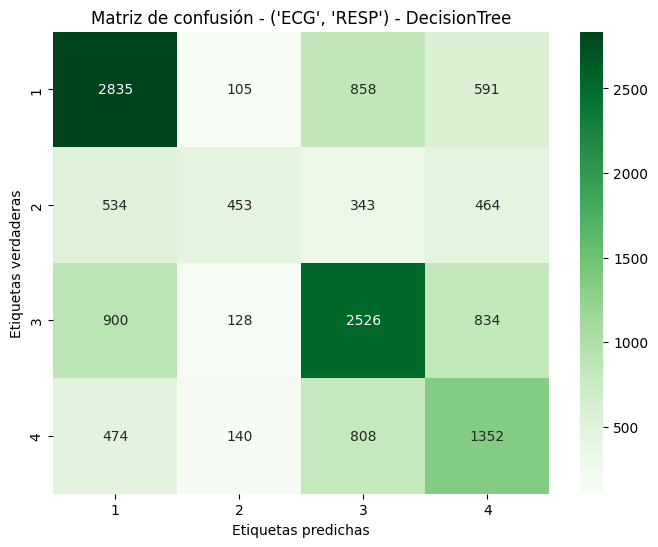

              precision    recall  f1-score   support

           1       0.60      0.65      0.62      4389
           2       0.55      0.25      0.35      1794
           3       0.56      0.58      0.57      4388
           4       0.42      0.49      0.45      2774

    accuracy                           0.54     13345
   macro avg       0.53      0.49      0.50     13345
weighted avg       0.54      0.54      0.53     13345

Training RandomForest model for ('ECG', 'RESP') using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
('ECG', 'RESP') - RandomForest Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.989959  ('ECG', 'RESP') - RandomForest
1  Precision  0.990071  ('ECG', 'RESP') - RandomForest
2     Recall  0.989959  ('ECG', 'RESP') - RandomForest
3   F1 Score  0.989966  ('ECG', 'RESP') - RandomForest
[('ECG', 'RESP') - RandomForest] Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_sp

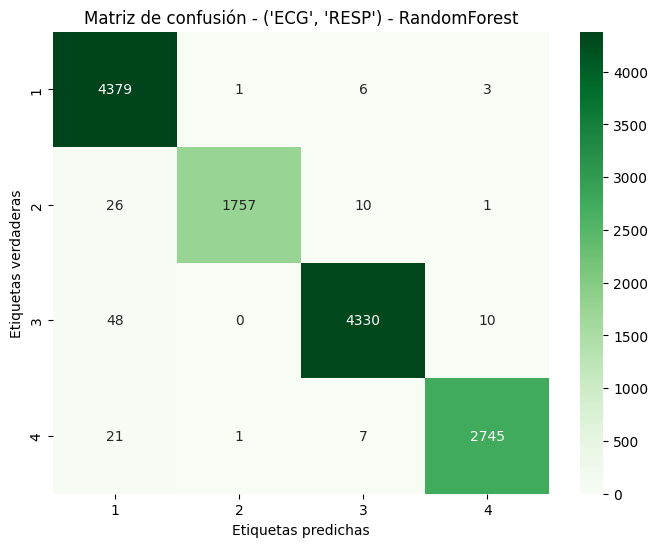

              precision    recall  f1-score   support

           1       0.98      1.00      0.99      4389
           2       1.00      0.98      0.99      1794
           3       0.99      0.99      0.99      4388
           4       0.99      0.99      0.99      2774

    accuracy                           0.99     13345
   macro avg       0.99      0.99      0.99     13345
weighted avg       0.99      0.99      0.99     13345

Training AdaBoost model for ('ECG', 'RESP') using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
('ECG', 'RESP') - AdaBoost Metrics
     Métrica     Valor                       Etapa
0   Accuracy  0.762458  ('ECG', 'RESP') - AdaBoost
1  Precision  0.763191  ('ECG', 'RESP') - AdaBoost
2     Recall  0.762458  ('ECG', 'RESP') - AdaBoost
3   F1 Score  0.762439  ('ECG', 'RESP') - AdaBoost
[('ECG', 'RESP') - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 0.5, 'n_estimators':

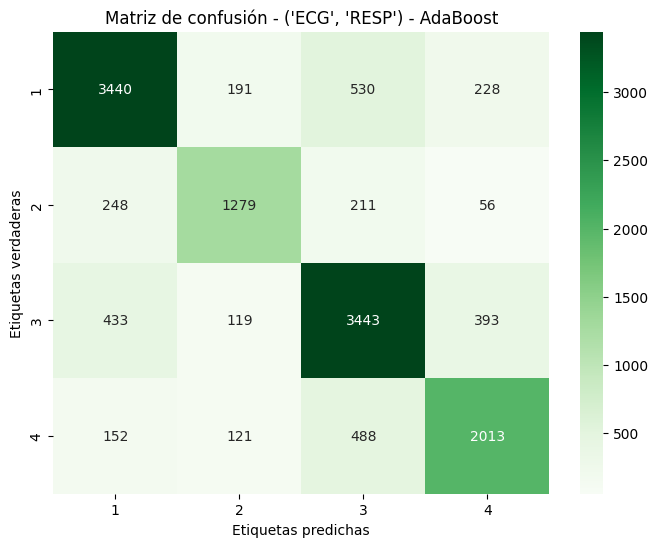

              precision    recall  f1-score   support

           1       0.81      0.78      0.79      4389
           2       0.75      0.71      0.73      1794
           3       0.74      0.78      0.76      4388
           4       0.75      0.73      0.74      2774

    accuracy                           0.76     13345
   macro avg       0.76      0.75      0.76     13345
weighted avg       0.76      0.76      0.76     13345

Training LDA model for ('ECG', 'RESP') using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
('ECG', 'RESP') - LDA Metrics
     Métrica     Valor                  Etapa
0   Accuracy  0.477557  ('ECG', 'RESP') - LDA
1  Precision  0.444864  ('ECG', 'RESP') - LDA
2     Recall  0.477557  ('ECG', 'RESP') - LDA
3   F1 Score  0.424103  ('ECG', 'RESP') - LDA
[('ECG', 'RESP') - LDA] Best Params: {'solver': 'svd'}
[('ECG', 'RESP') - LDA] Accuracy: 0.4776
('ECG', 'RESP') - LDA - Confusion Matrix
[[3113    8  986  282]
 [1103   10  536  145]
 [1292   1

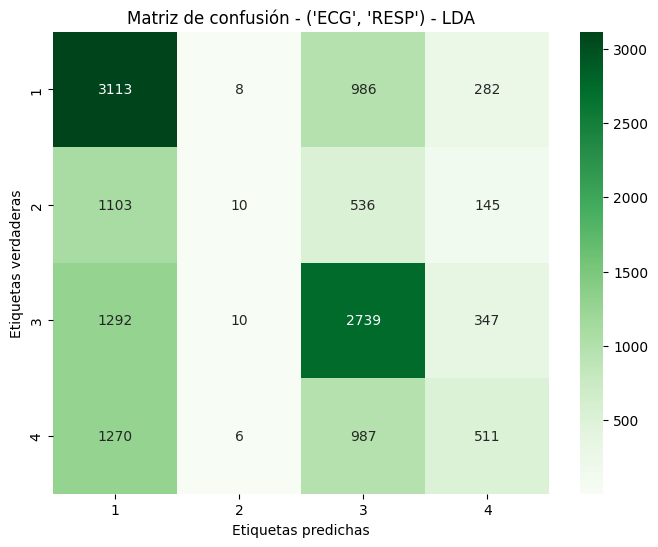

              precision    recall  f1-score   support

           1       0.46      0.71      0.56      4389
           2       0.29      0.01      0.01      1794
           3       0.52      0.62      0.57      4388
           4       0.40      0.18      0.25      2774

    accuracy                           0.48     13345
   macro avg       0.42      0.38      0.35     13345
weighted avg       0.44      0.48      0.42     13345

Training KNN model for ('ECG', 'RESP') using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
('ECG', 'RESP') - KNN Metrics
     Métrica     Valor                  Etapa
0   Accuracy  0.559910  ('ECG', 'RESP') - KNN
1  Precision  0.556165  ('ECG', 'RESP') - KNN
2     Recall  0.559910  ('ECG', 'RESP') - KNN
3   F1 Score  0.557183  ('ECG', 'RESP') - KNN
[('ECG', 'RESP') - KNN] Best Params: {'n_neighbors': 5, 'weights': 'distance'}
[('ECG', 'RESP') - KNN] Accuracy: 0.5599
('ECG', 'RESP') - KNN - Confusion Matrix
[[2826  332  771  460]
 [ 487  

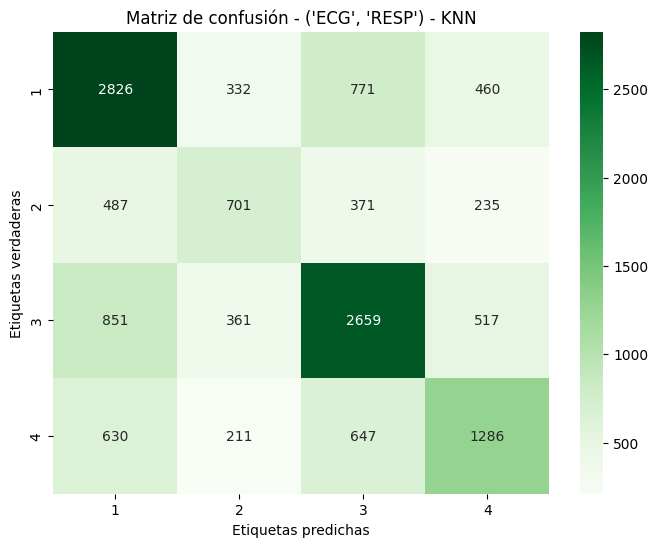

Training by signal combinations:  27%|██▋       | 3/11 [5:33:54<15:18:57, 6892.20s/it]

              precision    recall  f1-score   support

           1       0.59      0.64      0.62      4389
           2       0.44      0.39      0.41      1794
           3       0.60      0.61      0.60      4388
           4       0.51      0.46      0.49      2774

    accuracy                           0.56     13345
   macro avg       0.53      0.53      0.53     13345
weighted avg       0.56      0.56      0.56     13345

Training DecisionTree model for ('PPG', 'EDA') using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
('PPG', 'EDA') - DecisionTree Metrics
     Métrica     Valor                          Etapa
0   Accuracy  0.641289  ('PPG', 'EDA') - DecisionTree
1  Precision  0.698084  ('PPG', 'EDA') - DecisionTree
2     Recall  0.641289  ('PPG', 'EDA') - DecisionTree
3   F1 Score  0.649495  ('PPG', 'EDA') - DecisionTree
[('PPG', 'EDA') - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[('

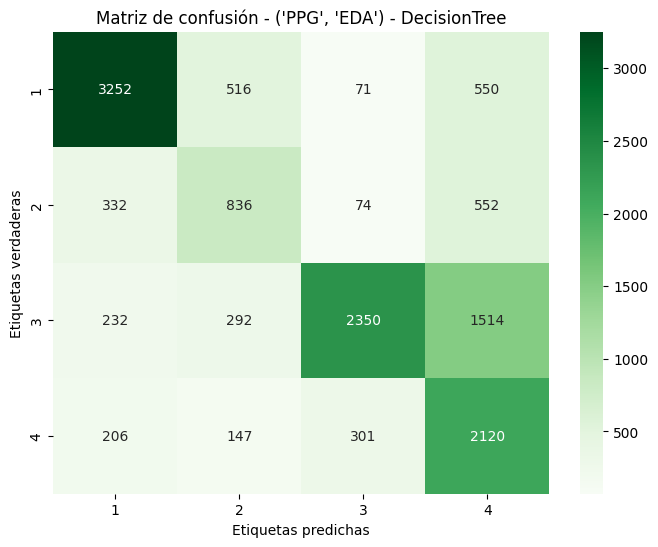

              precision    recall  f1-score   support

           1       0.81      0.74      0.77      4389
           2       0.47      0.47      0.47      1794
           3       0.84      0.54      0.65      4388
           4       0.45      0.76      0.56      2774

    accuracy                           0.64     13345
   macro avg       0.64      0.63      0.61     13345
weighted avg       0.70      0.64      0.65     13345

Training RandomForest model for ('PPG', 'EDA') using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
('PPG', 'EDA') - RandomForest Metrics
     Métrica     Valor                          Etapa
0   Accuracy  0.998127  ('PPG', 'EDA') - RandomForest
1  Precision  0.998127  ('PPG', 'EDA') - RandomForest
2     Recall  0.998127  ('PPG', 'EDA') - RandomForest
3   F1 Score  0.998126  ('PPG', 'EDA') - RandomForest
[('PPG', 'EDA') - RandomForest] Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5,

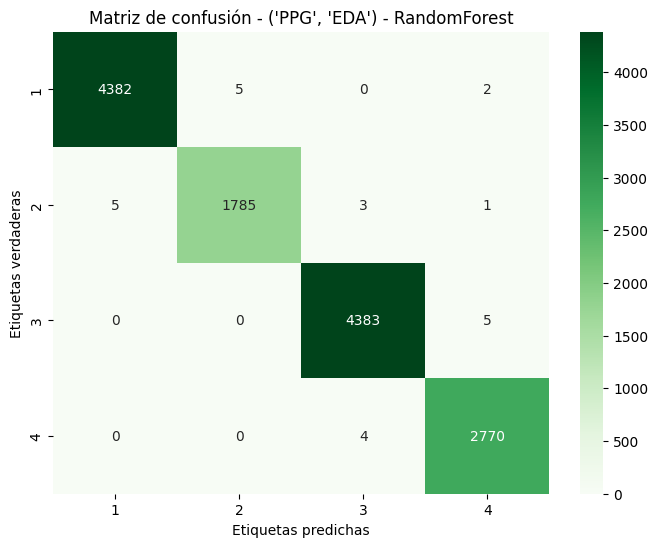

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4389
           2       1.00      0.99      1.00      1794
           3       1.00      1.00      1.00      4388
           4       1.00      1.00      1.00      2774

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training AdaBoost model for ('PPG', 'EDA') using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
('PPG', 'EDA') - AdaBoost Metrics
     Métrica     Valor                      Etapa
0   Accuracy  0.786062  ('PPG', 'EDA') - AdaBoost
1  Precision  0.802826  ('PPG', 'EDA') - AdaBoost
2     Recall  0.786062  ('PPG', 'EDA') - AdaBoost
3   F1 Score  0.790292  ('PPG', 'EDA') - AdaBoost
[('PPG', 'EDA') - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 0.1, 'n_estimators': 300}
[(

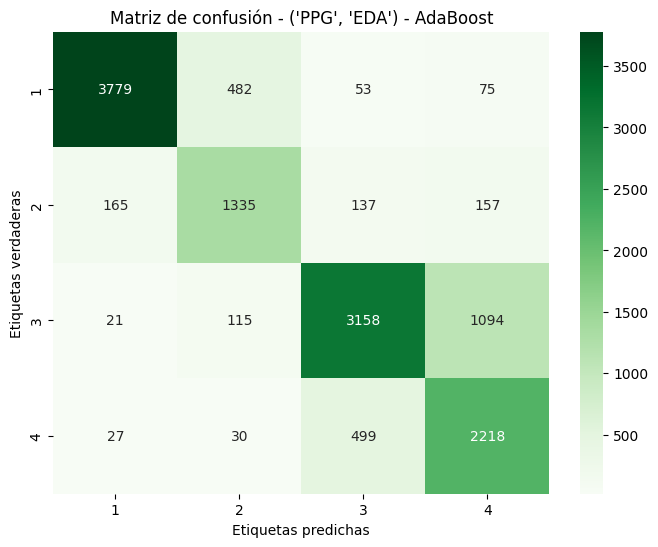

              precision    recall  f1-score   support

           1       0.95      0.86      0.90      4389
           2       0.68      0.74      0.71      1794
           3       0.82      0.72      0.77      4388
           4       0.63      0.80      0.70      2774

    accuracy                           0.79     13345
   macro avg       0.77      0.78      0.77     13345
weighted avg       0.80      0.79      0.79     13345

Training LDA model for ('PPG', 'EDA') using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
('PPG', 'EDA') - LDA Metrics
     Métrica     Valor                 Etapa
0   Accuracy  0.586137  ('PPG', 'EDA') - LDA
1  Precision  0.554150  ('PPG', 'EDA') - LDA
2     Recall  0.586137  ('PPG', 'EDA') - LDA
3   F1 Score  0.541348  ('PPG', 'EDA') - LDA
[('PPG', 'EDA') - LDA] Best Params: {'solver': 'svd'}
[('PPG', 'EDA') - LDA] Accuracy: 0.5861
('PPG', 'EDA') - LDA - Confusion Matrix
[[3552   56  485  296]
 [ 710   97  708  279]
 [ 439   29 3368  55

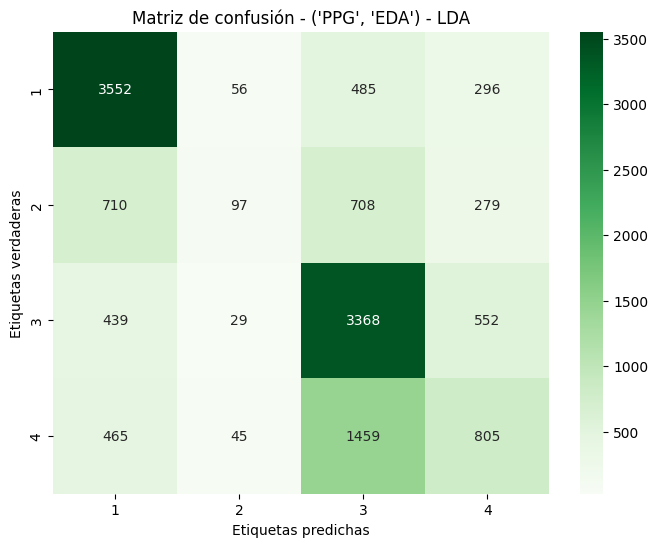

              precision    recall  f1-score   support

           1       0.69      0.81      0.74      4389
           2       0.43      0.05      0.10      1794
           3       0.56      0.77      0.65      4388
           4       0.42      0.29      0.34      2774

    accuracy                           0.59     13345
   macro avg       0.52      0.48      0.46     13345
weighted avg       0.55      0.59      0.54     13345

Training KNN model for ('PPG', 'EDA') using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
('PPG', 'EDA') - KNN Metrics
     Métrica     Valor                 Etapa
0   Accuracy  0.972724  ('PPG', 'EDA') - KNN
1  Precision  0.972689  ('PPG', 'EDA') - KNN
2     Recall  0.972724  ('PPG', 'EDA') - KNN
3   F1 Score  0.972701  ('PPG', 'EDA') - KNN
[('PPG', 'EDA') - KNN] Best Params: {'n_neighbors': 3, 'weights': 'distance'}
[('PPG', 'EDA') - KNN] Accuracy: 0.9727
('PPG', 'EDA') - KNN - Confusion Matrix
[[4321   38   13   17]
 [  46 1697   19  

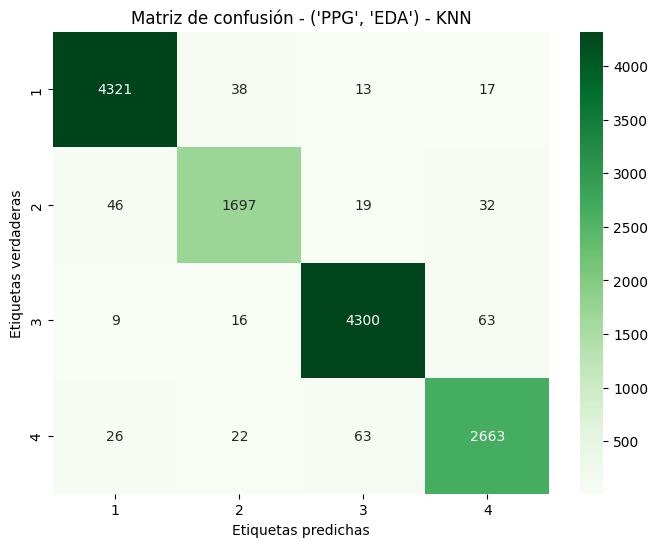

Training by signal combinations:  36%|███▋      | 4/11 [7:09:32<12:30:55, 6436.45s/it]

              precision    recall  f1-score   support

           1       0.98      0.98      0.98      4389
           2       0.96      0.95      0.95      1794
           3       0.98      0.98      0.98      4388
           4       0.96      0.96      0.96      2774

    accuracy                           0.97     13345
   macro avg       0.97      0.97      0.97     13345
weighted avg       0.97      0.97      0.97     13345

Training DecisionTree model for ('PPG', 'RESP') using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
('PPG', 'RESP') - DecisionTree Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.612514  ('PPG', 'RESP') - DecisionTree
1  Precision  0.646169  ('PPG', 'RESP') - DecisionTree
2     Recall  0.612514  ('PPG', 'RESP') - DecisionTree
3   F1 Score  0.622116  ('PPG', 'RESP') - DecisionTree
[('PPG', 'RESP') - DecisionTree] Best Params: {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 40, 'min_samples_spl

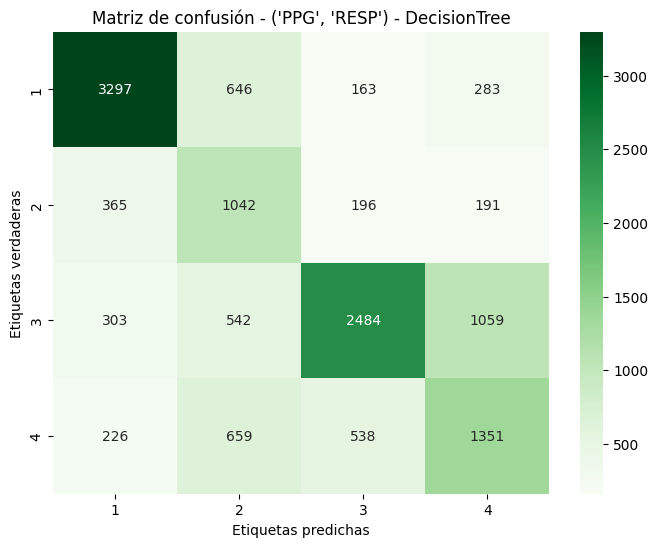

              precision    recall  f1-score   support

           1       0.79      0.75      0.77      4389
           2       0.36      0.58      0.45      1794
           3       0.73      0.57      0.64      4388
           4       0.47      0.49      0.48      2774

    accuracy                           0.61     13345
   macro avg       0.59      0.60      0.58     13345
weighted avg       0.65      0.61      0.62     13345

Training RandomForest model for ('PPG', 'RESP') using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
('PPG', 'RESP') - RandomForest Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.997302  ('PPG', 'RESP') - RandomForest
1  Precision  0.997304  ('PPG', 'RESP') - RandomForest
2     Recall  0.997302  ('PPG', 'RESP') - RandomForest
3   F1 Score  0.997301  ('PPG', 'RESP') - RandomForest
[('PPG', 'RESP') - RandomForest] Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_sp

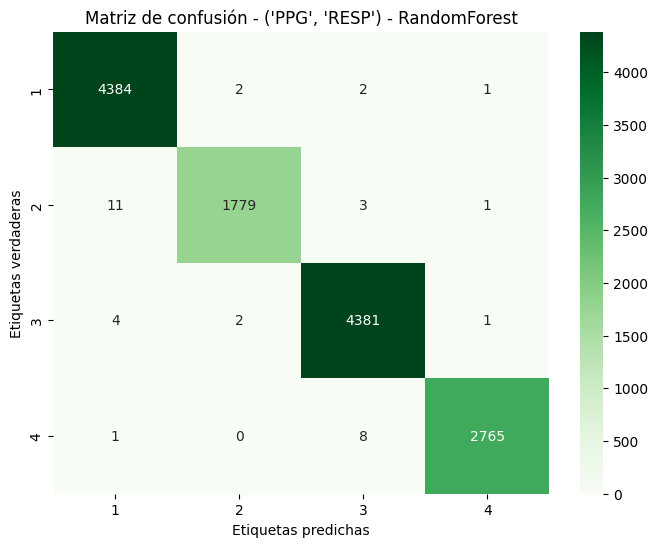

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4389
           2       1.00      0.99      0.99      1794
           3       1.00      1.00      1.00      4388
           4       1.00      1.00      1.00      2774

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training AdaBoost model for ('PPG', 'RESP') using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
('PPG', 'RESP') - AdaBoost Metrics
     Métrica     Valor                       Etapa
0   Accuracy  0.820082  ('PPG', 'RESP') - AdaBoost
1  Precision  0.825798  ('PPG', 'RESP') - AdaBoost
2     Recall  0.820082  ('PPG', 'RESP') - AdaBoost
3   F1 Score  0.821955  ('PPG', 'RESP') - AdaBoost
[('PPG', 'RESP') - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 0.5, 'n_estimators':

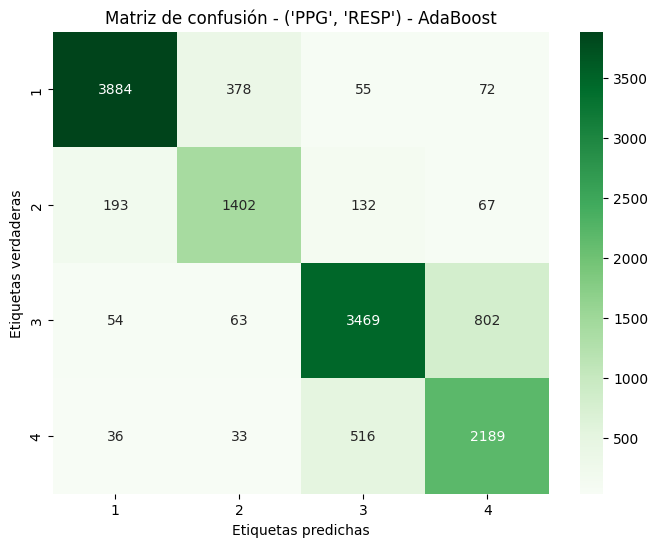

              precision    recall  f1-score   support

           1       0.93      0.88      0.91      4389
           2       0.75      0.78      0.76      1794
           3       0.83      0.79      0.81      4388
           4       0.70      0.79      0.74      2774

    accuracy                           0.82     13345
   macro avg       0.80      0.81      0.81     13345
weighted avg       0.83      0.82      0.82     13345

Training LDA model for ('PPG', 'RESP') using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
('PPG', 'RESP') - LDA Metrics
     Métrica     Valor                  Etapa
0   Accuracy  0.593631  ('PPG', 'RESP') - LDA
1  Precision  0.560919  ('PPG', 'RESP') - LDA
2     Recall  0.593631  ('PPG', 'RESP') - LDA
3   F1 Score  0.557622  ('PPG', 'RESP') - LDA
[('PPG', 'RESP') - LDA] Best Params: {'solver': 'svd'}
[('PPG', 'RESP') - LDA] Accuracy: 0.5936
('PPG', 'RESP') - LDA - Confusion Matrix
[[3489   79  237  584]
 [ 771   90  443  490]
 [ 319   3

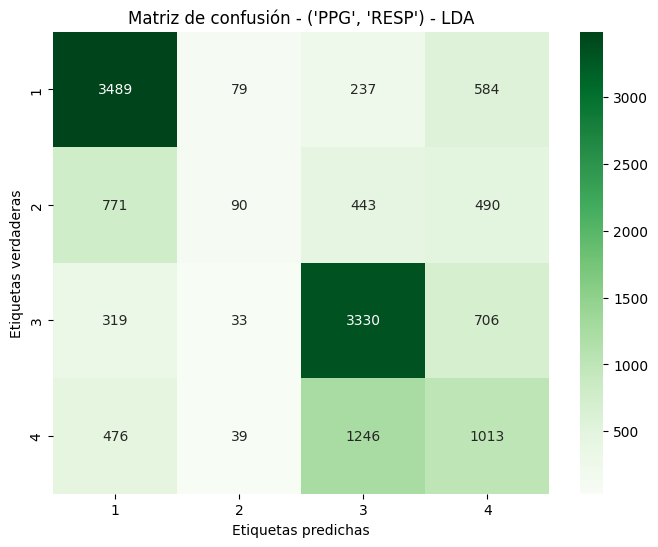

              precision    recall  f1-score   support

           1       0.69      0.79      0.74      4389
           2       0.37      0.05      0.09      1794
           3       0.63      0.76      0.69      4388
           4       0.36      0.37      0.36      2774

    accuracy                           0.59     13345
   macro avg       0.51      0.49      0.47     13345
weighted avg       0.56      0.59      0.56     13345

Training KNN model for ('PPG', 'RESP') using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
('PPG', 'RESP') - KNN Metrics
     Métrica     Valor                  Etapa
0   Accuracy  0.982615  ('PPG', 'RESP') - KNN
1  Precision  0.982634  ('PPG', 'RESP') - KNN
2     Recall  0.982615  ('PPG', 'RESP') - KNN
3   F1 Score  0.982621  ('PPG', 'RESP') - KNN
[('PPG', 'RESP') - KNN] Best Params: {'n_neighbors': 3, 'weights': 'distance'}
[('PPG', 'RESP') - KNN] Accuracy: 0.9826
('PPG', 'RESP') - KNN - Confusion Matrix
[[4334   25   10   20]
 [  23 1

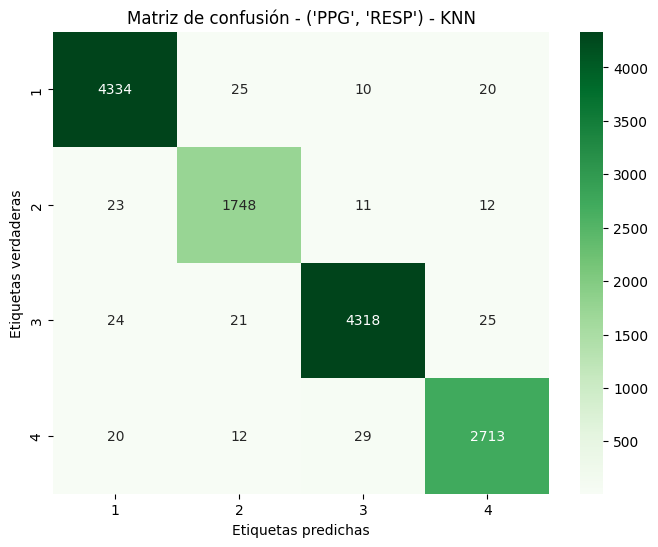

Training by signal combinations:  45%|████▌     | 5/11 [8:35:54<9:58:25, 5984.28s/it] 

              precision    recall  f1-score   support

           1       0.98      0.99      0.99      4389
           2       0.97      0.97      0.97      1794
           3       0.99      0.98      0.99      4388
           4       0.98      0.98      0.98      2774

    accuracy                           0.98     13345
   macro avg       0.98      0.98      0.98     13345
weighted avg       0.98      0.98      0.98     13345

Training DecisionTree model for ('EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
('EDA', 'RESP') - DecisionTree Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.573923  ('EDA', 'RESP') - DecisionTree
1  Precision  0.603988  ('EDA', 'RESP') - DecisionTree
2     Recall  0.573923  ('EDA', 'RESP') - DecisionTree
3   F1 Score  0.580648  ('EDA', 'RESP') - DecisionTree
[('EDA', 'RESP') - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 40, 'min_samples_split'

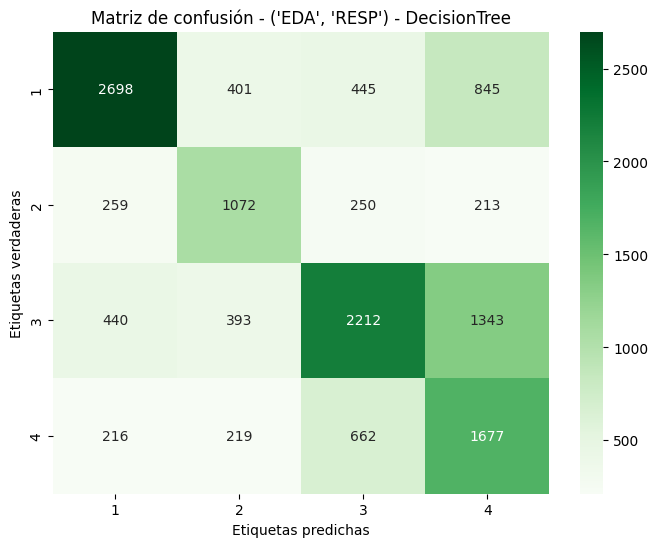

              precision    recall  f1-score   support

           1       0.75      0.61      0.67      4389
           2       0.51      0.60      0.55      1794
           3       0.62      0.50      0.56      4388
           4       0.41      0.60      0.49      2774

    accuracy                           0.57     13345
   macro avg       0.57      0.58      0.57     13345
weighted avg       0.60      0.57      0.58     13345

Training RandomForest model for ('EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
('EDA', 'RESP') - RandomForest Metrics
     Métrica     Valor                           Etapa
0   Accuracy  0.997377  ('EDA', 'RESP') - RandomForest
1  Precision  0.997379  ('EDA', 'RESP') - RandomForest
2     Recall  0.997377  ('EDA', 'RESP') - RandomForest
3   F1 Score  0.997377  ('EDA', 'RESP') - RandomForest
[('EDA', 'RESP') - RandomForest] Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_sp

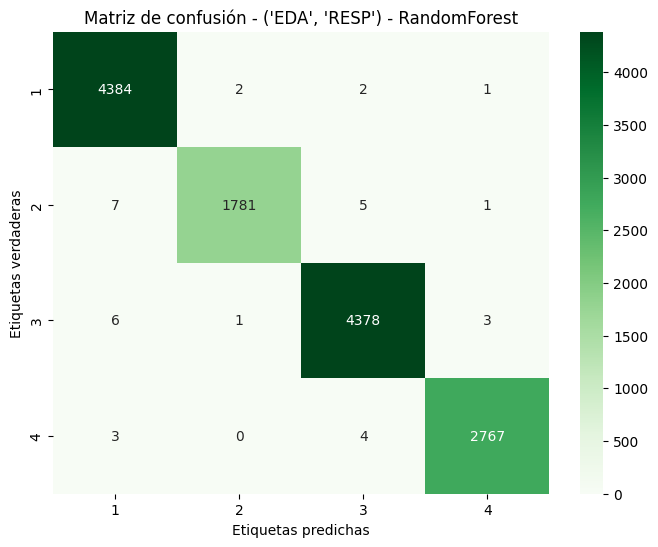

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4389
           2       1.00      0.99      1.00      1794
           3       1.00      1.00      1.00      4388
           4       1.00      1.00      1.00      2774

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training AdaBoost model for ('EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
('EDA', 'RESP') - AdaBoost Metrics
     Métrica     Valor                       Etapa
0   Accuracy  0.750918  ('EDA', 'RESP') - AdaBoost
1  Precision  0.755062  ('EDA', 'RESP') - AdaBoost
2     Recall  0.750918  ('EDA', 'RESP') - AdaBoost
3   F1 Score  0.751350  ('EDA', 'RESP') - AdaBoost
[('EDA', 'RESP') - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 0.5, 'n_estimators':

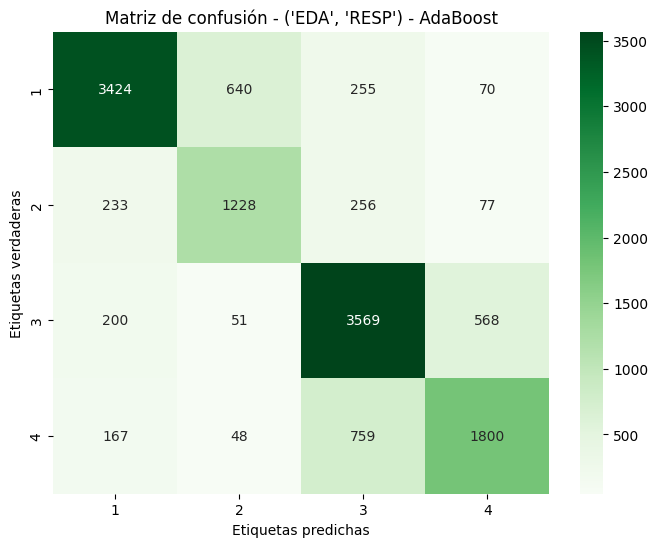

              precision    recall  f1-score   support

           1       0.85      0.78      0.81      4389
           2       0.62      0.68      0.65      1794
           3       0.74      0.81      0.77      4388
           4       0.72      0.65      0.68      2774

    accuracy                           0.75     13345
   macro avg       0.73      0.73      0.73     13345
weighted avg       0.76      0.75      0.75     13345

Training LDA model for ('EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
('EDA', 'RESP') - LDA Metrics
     Métrica     Valor                  Etapa
0   Accuracy  0.502885  ('EDA', 'RESP') - LDA
1  Precision  0.496892  ('EDA', 'RESP') - LDA
2     Recall  0.502885  ('EDA', 'RESP') - LDA
3   F1 Score  0.456152  ('EDA', 'RESP') - LDA
[('EDA', 'RESP') - LDA] Best Params: {'solver': 'svd'}
[('EDA', 'RESP') - LDA] Accuracy: 0.5029
('EDA', 'RESP') - LDA - Confusion Matrix
[[3126    7  895  361]
 [ 930   33  602  229]
 [1134    

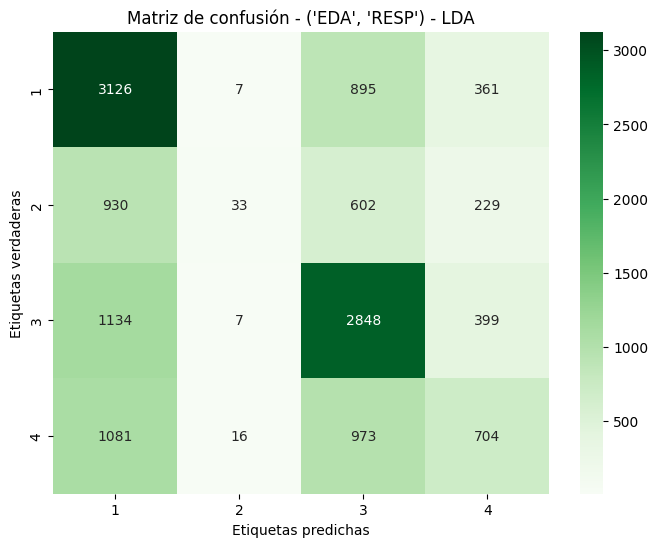

              precision    recall  f1-score   support

           1       0.50      0.71      0.59      4389
           2       0.52      0.02      0.04      1794
           3       0.54      0.65      0.59      4388
           4       0.42      0.25      0.32      2774

    accuracy                           0.50     13345
   macro avg       0.49      0.41      0.38     13345
weighted avg       0.50      0.50      0.46     13345

Training KNN model for ('EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
('EDA', 'RESP') - KNN Metrics
     Métrica     Valor                  Etapa
0   Accuracy  0.974372  ('EDA', 'RESP') - KNN
1  Precision  0.974361  ('EDA', 'RESP') - KNN
2     Recall  0.974372  ('EDA', 'RESP') - KNN
3   F1 Score  0.974360  ('EDA', 'RESP') - KNN
[('EDA', 'RESP') - KNN] Best Params: {'n_neighbors': 3, 'weights': 'distance'}
[('EDA', 'RESP') - KNN] Accuracy: 0.9744
('EDA', 'RESP') - KNN - Confusion Matrix
[[4323   23   18   25]
 [  32 1

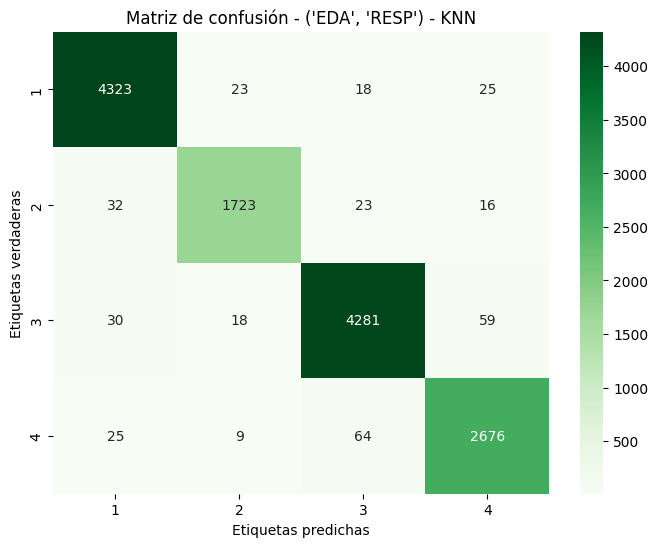

Training by signal combinations:  55%|█████▍    | 6/11 [9:56:21<7:45:54, 5590.84s/it]

              precision    recall  f1-score   support

           1       0.98      0.98      0.98      4389
           2       0.97      0.96      0.97      1794
           3       0.98      0.98      0.98      4388
           4       0.96      0.96      0.96      2774

    accuracy                           0.97     13345
   macro avg       0.97      0.97      0.97     13345
weighted avg       0.97      0.97      0.97     13345

Training DecisionTree model for ('ECG', 'PPG', 'EDA') using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
('ECG', 'PPG', 'EDA') - DecisionTree Metrics
     Métrica     Valor                                 Etapa
0   Accuracy  0.666842  ('ECG', 'PPG', 'EDA') - DecisionTree
1  Precision  0.700028  ('ECG', 'PPG', 'EDA') - DecisionTree
2     Recall  0.666842  ('ECG', 'PPG', 'EDA') - DecisionTree
3   F1 Score  0.669417  ('ECG', 'PPG', 'EDA') - DecisionTree
[('ECG', 'PPG', 'EDA') - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth

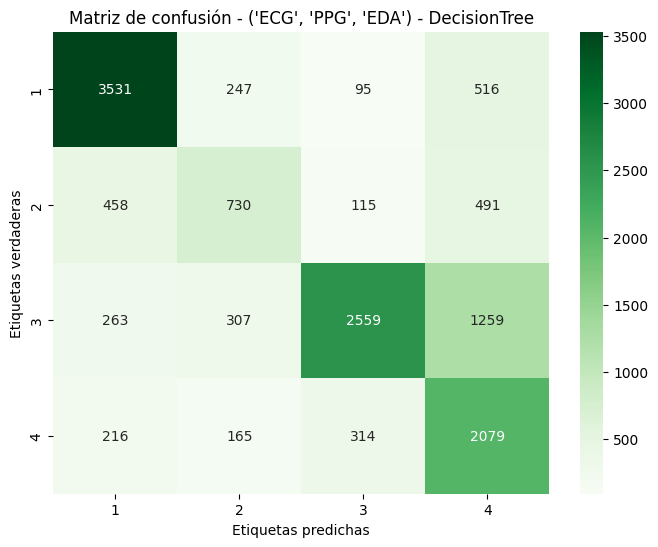

              precision    recall  f1-score   support

           1       0.79      0.80      0.80      4389
           2       0.50      0.41      0.45      1794
           3       0.83      0.58      0.69      4388
           4       0.48      0.75      0.58      2774

    accuracy                           0.67     13345
   macro avg       0.65      0.64      0.63     13345
weighted avg       0.70      0.67      0.67     13345

Training RandomForest model for ('ECG', 'PPG', 'EDA') using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
('ECG', 'PPG', 'EDA') - RandomForest Metrics
     Métrica     Valor                                 Etapa
0   Accuracy  0.998127  ('ECG', 'PPG', 'EDA') - RandomForest
1  Precision  0.998128  ('ECG', 'PPG', 'EDA') - RandomForest
2     Recall  0.998127  ('ECG', 'PPG', 'EDA') - RandomForest
3   F1 Score  0.998126  ('ECG', 'PPG', 'EDA') - RandomForest
[('ECG', 'PPG', 'EDA') - RandomForest] Best Params: {'max_depth': 20, 'max_features'

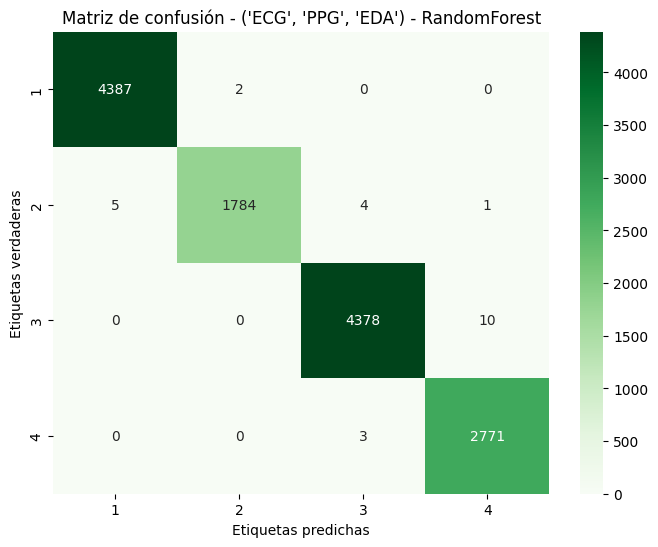

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4389
           2       1.00      0.99      1.00      1794
           3       1.00      1.00      1.00      4388
           4       1.00      1.00      1.00      2774

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training AdaBoost model for ('ECG', 'PPG', 'EDA') using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
('ECG', 'PPG', 'EDA') - AdaBoost Metrics
     Métrica     Valor                             Etapa
0   Accuracy  0.811540  ('ECG', 'PPG', 'EDA') - AdaBoost
1  Precision  0.813371  ('ECG', 'PPG', 'EDA') - AdaBoost
2     Recall  0.811540  ('ECG', 'PPG', 'EDA') - AdaBoost
3   F1 Score  0.812254  ('ECG', 'PPG', 'EDA') - AdaBoost
[('ECG', 'PPG', 'EDA') - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanced', max

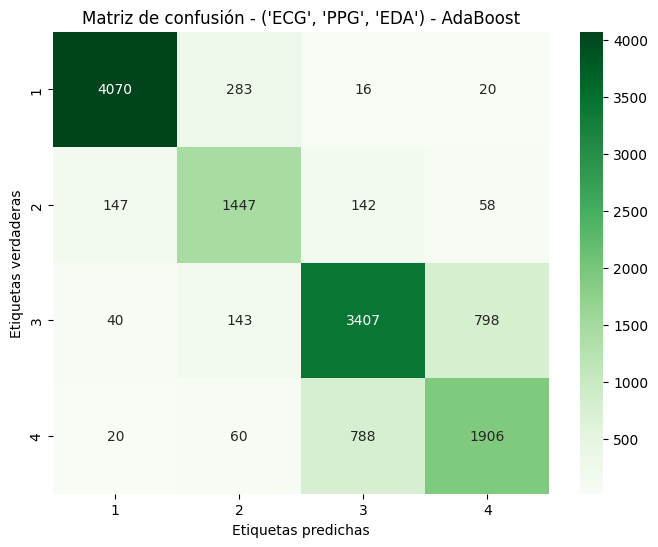

              precision    recall  f1-score   support

           1       0.95      0.93      0.94      4389
           2       0.75      0.81      0.78      1794
           3       0.78      0.78      0.78      4388
           4       0.69      0.69      0.69      2774

    accuracy                           0.81     13345
   macro avg       0.79      0.80      0.80     13345
weighted avg       0.81      0.81      0.81     13345

Training LDA model for ('ECG', 'PPG', 'EDA') using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
('ECG', 'PPG', 'EDA') - LDA Metrics
     Métrica     Valor                        Etapa
0   Accuracy  0.595354  ('ECG', 'PPG', 'EDA') - LDA
1  Precision  0.568066  ('ECG', 'PPG', 'EDA') - LDA
2     Recall  0.595354  ('ECG', 'PPG', 'EDA') - LDA
3   F1 Score  0.560287  ('ECG', 'PPG', 'EDA') - LDA
[('ECG', 'PPG', 'EDA') - LDA] Best Params: {'solver': 'svd'}
[('ECG', 'PPG', 'EDA') - LDA] Accuracy: 0.5954
('ECG', 'PPG', 'EDA') - LDA - Confusion Mat

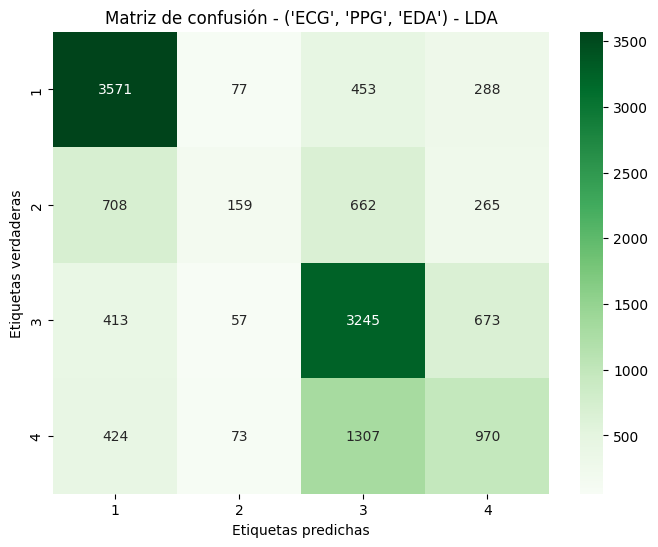

              precision    recall  f1-score   support

           1       0.70      0.81      0.75      4389
           2       0.43      0.09      0.15      1794
           3       0.57      0.74      0.65      4388
           4       0.44      0.35      0.39      2774

    accuracy                           0.60     13345
   macro avg       0.54      0.50      0.48     13345
weighted avg       0.57      0.60      0.56     13345

Training KNN model for ('ECG', 'PPG', 'EDA') using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
('ECG', 'PPG', 'EDA') - KNN Metrics
     Métrica     Valor                        Etapa
0   Accuracy  0.586737  ('ECG', 'PPG', 'EDA') - KNN
1  Precision  0.582813  ('ECG', 'PPG', 'EDA') - KNN
2     Recall  0.586737  ('ECG', 'PPG', 'EDA') - KNN
3   F1 Score  0.583828  ('ECG', 'PPG', 'EDA') - KNN
[('ECG', 'PPG', 'EDA') - KNN] Best Params: {'n_neighbors': 5, 'weights': 'distance'}
[('ECG', 'PPG', 'EDA') - KNN] Accuracy: 0.5867
('ECG', 'PPG', 'ED

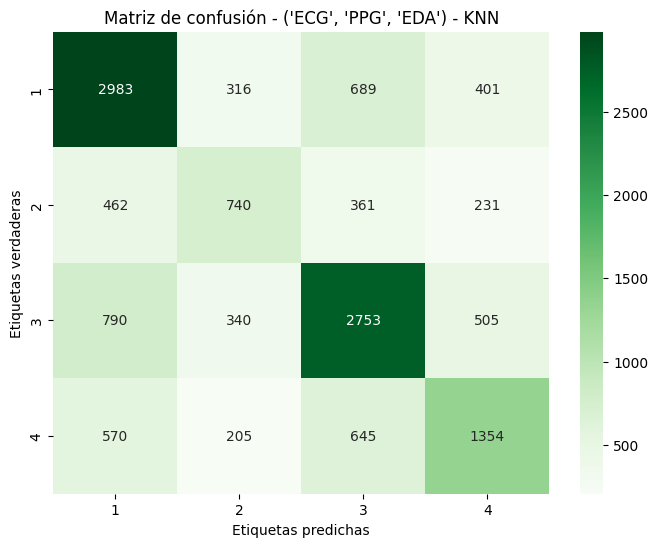

Training by signal combinations:  64%|██████▎   | 7/11 [12:02:30<6:55:49, 6237.44s/it]

              precision    recall  f1-score   support

           1       0.62      0.68      0.65      4389
           2       0.46      0.41      0.44      1794
           3       0.62      0.63      0.62      4388
           4       0.54      0.49      0.51      2774

    accuracy                           0.59     13345
   macro avg       0.56      0.55      0.56     13345
weighted avg       0.58      0.59      0.58     13345

Training DecisionTree model for ('ECG', 'PPG', 'RESP') using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
('ECG', 'PPG', 'RESP') - DecisionTree Metrics
     Métrica     Valor                                  Etapa
0   Accuracy  0.629149  ('ECG', 'PPG', 'RESP') - DecisionTree
1  Precision  0.678811  ('ECG', 'PPG', 'RESP') - DecisionTree
2     Recall  0.629149  ('ECG', 'PPG', 'RESP') - DecisionTree
3   F1 Score  0.643898  ('ECG', 'PPG', 'RESP') - DecisionTree
[('ECG', 'PPG', 'RESP') - DecisionTree] Best Params: {'criterion': 'gini', 'm

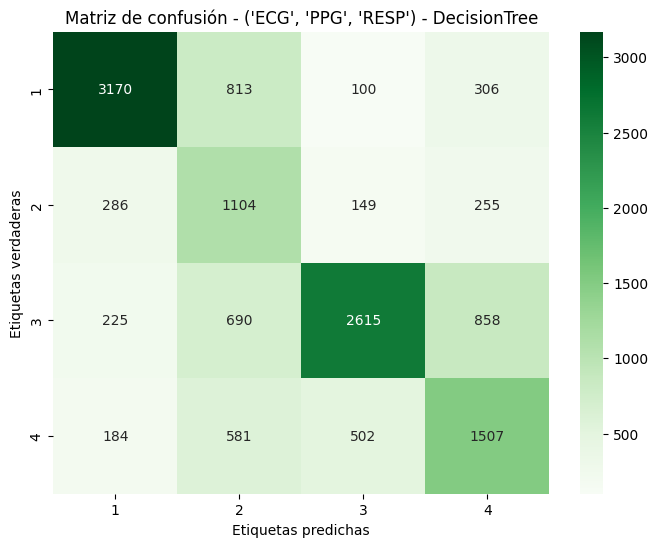

              precision    recall  f1-score   support

           1       0.82      0.72      0.77      4389
           2       0.35      0.62      0.44      1794
           3       0.78      0.60      0.67      4388
           4       0.52      0.54      0.53      2774

    accuracy                           0.63     13345
   macro avg       0.61      0.62      0.60     13345
weighted avg       0.68      0.63      0.64     13345

Training RandomForest model for ('ECG', 'PPG', 'RESP') using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
('ECG', 'PPG', 'RESP') - RandomForest Metrics
     Métrica     Valor                                  Etapa
0   Accuracy  0.997152  ('ECG', 'PPG', 'RESP') - RandomForest
1  Precision  0.997153  ('ECG', 'PPG', 'RESP') - RandomForest
2     Recall  0.997152  ('ECG', 'PPG', 'RESP') - RandomForest
3   F1 Score  0.997150  ('ECG', 'PPG', 'RESP') - RandomForest
[('ECG', 'PPG', 'RESP') - RandomForest] Best Params: {'max_depth': 20, 'max_f

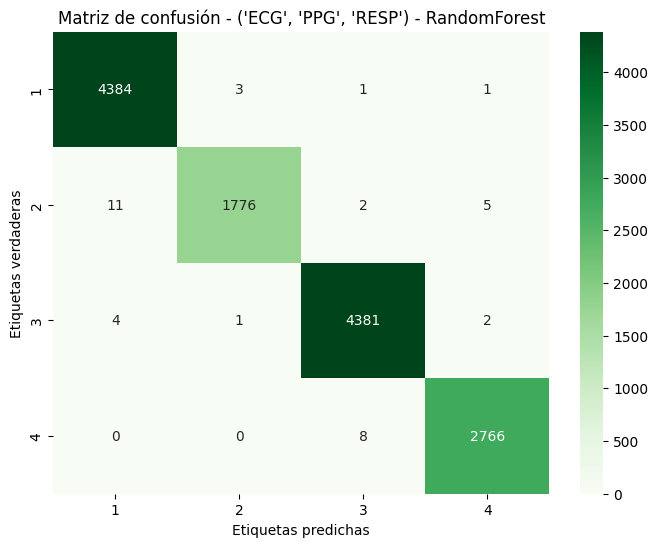

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4389
           2       1.00      0.99      0.99      1794
           3       1.00      1.00      1.00      4388
           4       1.00      1.00      1.00      2774

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training AdaBoost model for ('ECG', 'PPG', 'RESP') using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
('ECG', 'PPG', 'RESP') - AdaBoost Metrics
     Métrica     Valor                              Etapa
0   Accuracy  0.828400  ('ECG', 'PPG', 'RESP') - AdaBoost
1  Precision  0.832348  ('ECG', 'PPG', 'RESP') - AdaBoost
2     Recall  0.828400  ('ECG', 'PPG', 'RESP') - AdaBoost
3   F1 Score  0.829874  ('ECG', 'PPG', 'RESP') - AdaBoost
[('ECG', 'PPG', 'RESP') - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanc

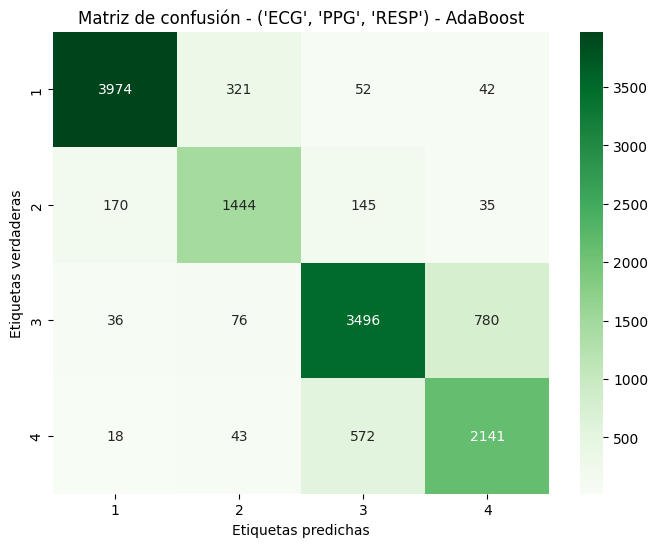

              precision    recall  f1-score   support

           1       0.95      0.91      0.93      4389
           2       0.77      0.80      0.79      1794
           3       0.82      0.80      0.81      4388
           4       0.71      0.77      0.74      2774

    accuracy                           0.83     13345
   macro avg       0.81      0.82      0.82     13345
weighted avg       0.83      0.83      0.83     13345

Training LDA model for ('ECG', 'PPG', 'RESP') using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
('ECG', 'PPG', 'RESP') - LDA Metrics
     Métrica     Valor                         Etapa
0   Accuracy  0.605245  ('ECG', 'PPG', 'RESP') - LDA
1  Precision  0.575750  ('ECG', 'PPG', 'RESP') - LDA
2     Recall  0.605245  ('ECG', 'PPG', 'RESP') - LDA
3   F1 Score  0.575536  ('ECG', 'PPG', 'RESP') - LDA
[('ECG', 'PPG', 'RESP') - LDA] Best Params: {'solver': 'svd'}
[('ECG', 'PPG', 'RESP') - LDA] Accuracy: 0.6052
('ECG', 'PPG', 'RESP') - LDA - Con

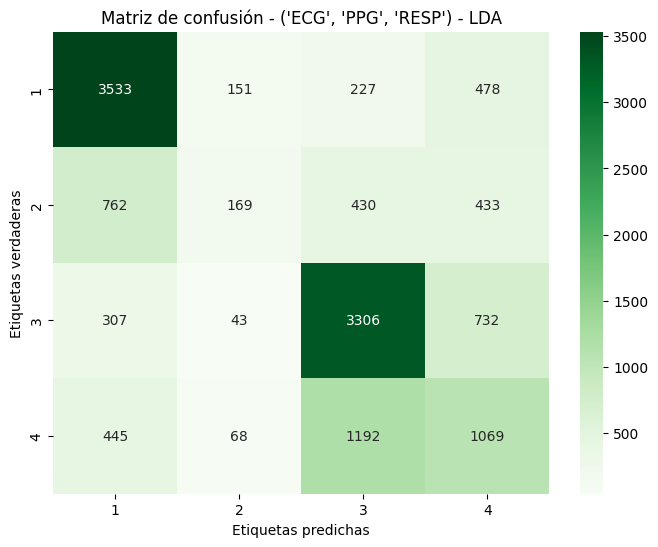

              precision    recall  f1-score   support

           1       0.70      0.80      0.75      4389
           2       0.39      0.09      0.15      1794
           3       0.64      0.75      0.69      4388
           4       0.39      0.39      0.39      2774

    accuracy                           0.61     13345
   macro avg       0.53      0.51      0.50     13345
weighted avg       0.58      0.61      0.58     13345

Training KNN model for ('ECG', 'PPG', 'RESP') using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
('ECG', 'PPG', 'RESP') - KNN Metrics
     Métrica     Valor                         Etapa
0   Accuracy  0.565081  ('ECG', 'PPG', 'RESP') - KNN
1  Precision  0.561556  ('ECG', 'PPG', 'RESP') - KNN
2     Recall  0.565081  ('ECG', 'PPG', 'RESP') - KNN
3   F1 Score  0.562416  ('ECG', 'PPG', 'RESP') - KNN
[('ECG', 'PPG', 'RESP') - KNN] Best Params: {'n_neighbors': 5, 'weights': 'distance'}
[('ECG', 'PPG', 'RESP') - KNN] Accuracy: 0.5651
('ECG', '

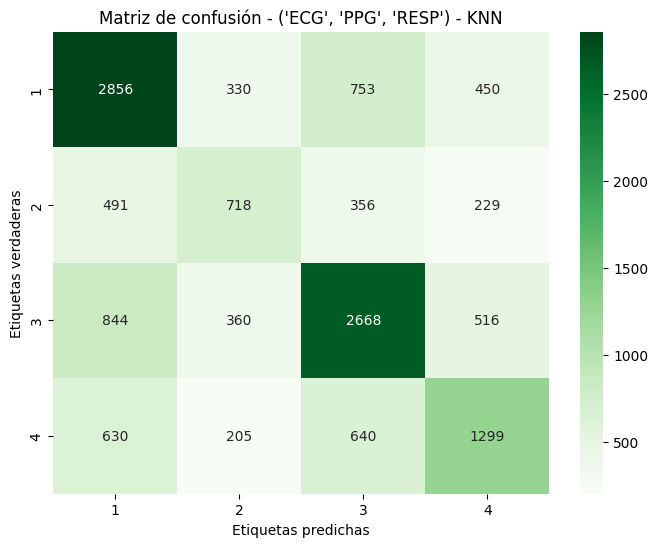

Training by signal combinations:  73%|███████▎  | 8/11 [14:07:01<5:31:30, 6630.10s/it]

              precision    recall  f1-score   support

           1       0.59      0.65      0.62      4389
           2       0.45      0.40      0.42      1794
           3       0.60      0.61      0.61      4388
           4       0.52      0.47      0.49      2774

    accuracy                           0.57     13345
   macro avg       0.54      0.53      0.54     13345
weighted avg       0.56      0.57      0.56     13345

Training DecisionTree model for ('ECG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
('ECG', 'EDA', 'RESP') - DecisionTree Metrics
     Métrica     Valor                                  Etapa
0   Accuracy  0.614612  ('ECG', 'EDA', 'RESP') - DecisionTree
1  Precision  0.631464  ('ECG', 'EDA', 'RESP') - DecisionTree
2     Recall  0.614612  ('ECG', 'EDA', 'RESP') - DecisionTree
3   F1 Score  0.617542  ('ECG', 'EDA', 'RESP') - DecisionTree
[('ECG', 'EDA', 'RESP') - DecisionTree] Best Params: {'criterion': 'gini', 'm

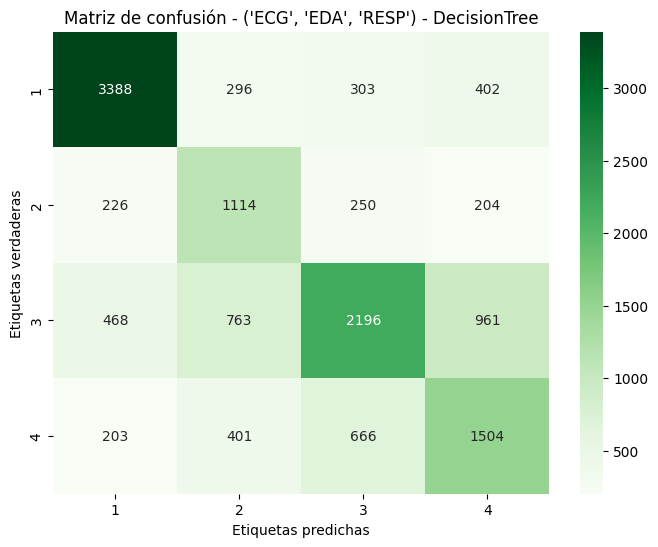

              precision    recall  f1-score   support

           1       0.79      0.77      0.78      4389
           2       0.43      0.62      0.51      1794
           3       0.64      0.50      0.56      4388
           4       0.49      0.54      0.51      2774

    accuracy                           0.61     13345
   macro avg       0.59      0.61      0.59     13345
weighted avg       0.63      0.61      0.62     13345

Training RandomForest model for ('ECG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
('ECG', 'EDA', 'RESP') - RandomForest Metrics
     Métrica     Valor                                  Etapa
0   Accuracy  0.998501  ('ECG', 'EDA', 'RESP') - RandomForest
1  Precision  0.998502  ('ECG', 'EDA', 'RESP') - RandomForest
2     Recall  0.998501  ('ECG', 'EDA', 'RESP') - RandomForest
3   F1 Score  0.998501  ('ECG', 'EDA', 'RESP') - RandomForest
[('ECG', 'EDA', 'RESP') - RandomForest] Best Params: {'max_depth': 20, 'max_f

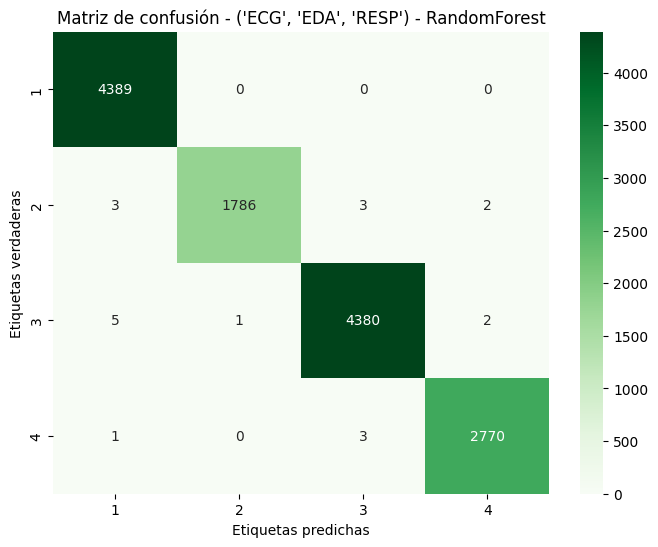

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4389
           2       1.00      1.00      1.00      1794
           3       1.00      1.00      1.00      4388
           4       1.00      1.00      1.00      2774

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training AdaBoost model for ('ECG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
('ECG', 'EDA', 'RESP') - AdaBoost Metrics
     Métrica     Valor                              Etapa
0   Accuracy  0.811465  ('ECG', 'EDA', 'RESP') - AdaBoost
1  Precision  0.816758  ('ECG', 'EDA', 'RESP') - AdaBoost
2     Recall  0.811465  ('ECG', 'EDA', 'RESP') - AdaBoost
3   F1 Score  0.813311  ('ECG', 'EDA', 'RESP') - AdaBoost
[('ECG', 'EDA', 'RESP') - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanc

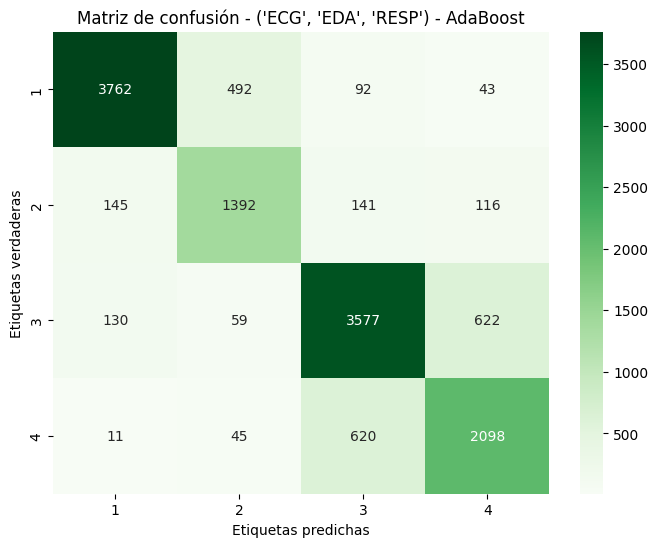

              precision    recall  f1-score   support

           1       0.93      0.86      0.89      4389
           2       0.70      0.78      0.74      1794
           3       0.81      0.82      0.81      4388
           4       0.73      0.76      0.74      2774

    accuracy                           0.81     13345
   macro avg       0.79      0.80      0.80     13345
weighted avg       0.82      0.81      0.81     13345

Training LDA model for ('ECG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
('ECG', 'EDA', 'RESP') - LDA Metrics
     Métrica     Valor                         Etapa
0   Accuracy  0.531660  ('ECG', 'EDA', 'RESP') - LDA
1  Precision  0.509843  ('ECG', 'EDA', 'RESP') - LDA
2     Recall  0.531660  ('ECG', 'EDA', 'RESP') - LDA
3   F1 Score  0.490538  ('ECG', 'EDA', 'RESP') - LDA
[('ECG', 'EDA', 'RESP') - LDA] Best Params: {'solver': 'svd'}
[('ECG', 'EDA', 'RESP') - LDA] Accuracy: 0.5317
('ECG', 'EDA', 'RESP') - LDA - Con

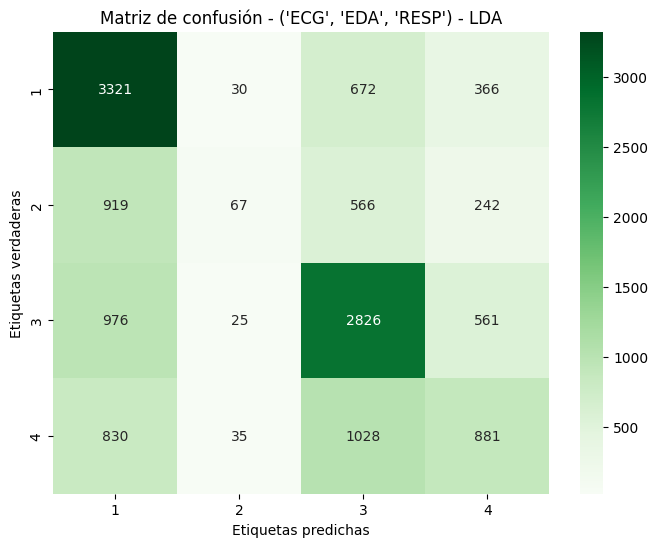

              precision    recall  f1-score   support

           1       0.55      0.76      0.64      4389
           2       0.43      0.04      0.07      1794
           3       0.55      0.64      0.60      4388
           4       0.43      0.32      0.37      2774

    accuracy                           0.53     13345
   macro avg       0.49      0.44      0.42     13345
weighted avg       0.51      0.53      0.49     13345

Training KNN model for ('ECG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
('ECG', 'EDA', 'RESP') - KNN Metrics
     Métrica     Valor                         Etapa
0   Accuracy  0.586212  ('ECG', 'EDA', 'RESP') - KNN
1  Precision  0.582349  ('ECG', 'EDA', 'RESP') - KNN
2     Recall  0.586212  ('ECG', 'EDA', 'RESP') - KNN
3   F1 Score  0.583383  ('ECG', 'EDA', 'RESP') - KNN
[('ECG', 'EDA', 'RESP') - KNN] Best Params: {'n_neighbors': 5, 'weights': 'distance'}
[('ECG', 'EDA', 'RESP') - KNN] Accuracy: 0.5862
('ECG', '

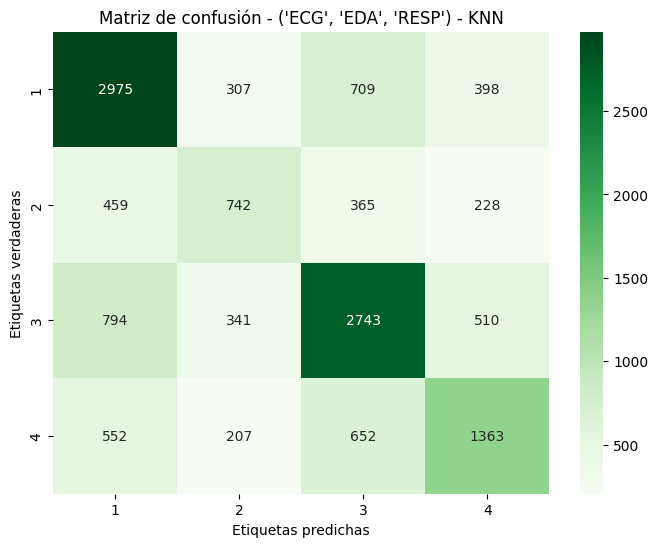

Training by signal combinations:  82%|████████▏ | 9/11 [16:00:31<3:42:52, 6686.42s/it]

              precision    recall  f1-score   support

           1       0.62      0.68      0.65      4389
           2       0.46      0.41      0.44      1794
           3       0.61      0.63      0.62      4388
           4       0.55      0.49      0.52      2774

    accuracy                           0.59     13345
   macro avg       0.56      0.55      0.56     13345
weighted avg       0.58      0.59      0.58     13345

Training DecisionTree model for ('PPG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
('PPG', 'EDA', 'RESP') - DecisionTree Metrics
     Métrica     Valor                                  Etapa
0   Accuracy  0.649532  ('PPG', 'EDA', 'RESP') - DecisionTree
1  Precision  0.700319  ('PPG', 'EDA', 'RESP') - DecisionTree
2     Recall  0.649532  ('PPG', 'EDA', 'RESP') - DecisionTree
3   F1 Score  0.656334  ('PPG', 'EDA', 'RESP') - DecisionTree
[('PPG', 'EDA', 'RESP') - DecisionTree] Best Params: {'criterion': 'entropy',

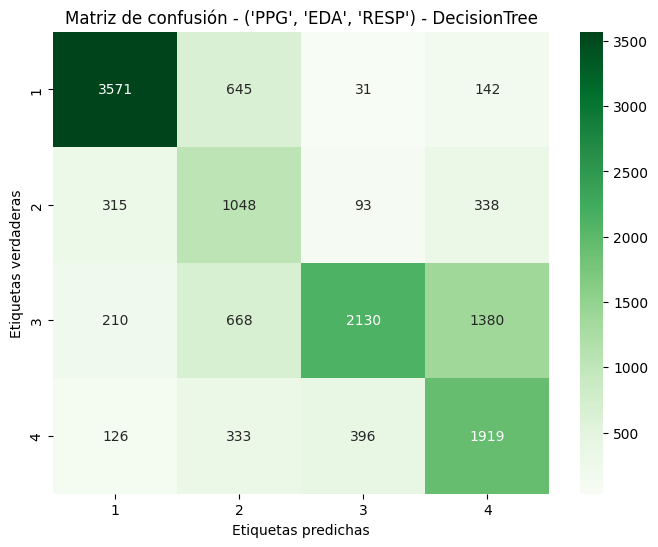

              precision    recall  f1-score   support

           1       0.85      0.81      0.83      4389
           2       0.39      0.58      0.47      1794
           3       0.80      0.49      0.61      4388
           4       0.51      0.69      0.59      2774

    accuracy                           0.65     13345
   macro avg       0.64      0.64      0.62     13345
weighted avg       0.70      0.65      0.66     13345

Training RandomForest model for ('PPG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
('PPG', 'EDA', 'RESP') - RandomForest Metrics
     Métrica     Valor                                  Etapa
0   Accuracy  0.999101  ('PPG', 'EDA', 'RESP') - RandomForest
1  Precision  0.999101  ('PPG', 'EDA', 'RESP') - RandomForest
2     Recall  0.999101  ('PPG', 'EDA', 'RESP') - RandomForest
3   F1 Score  0.999101  ('PPG', 'EDA', 'RESP') - RandomForest
[('PPG', 'EDA', 'RESP') - RandomForest] Best Params: {'max_depth': 20, 'max_f

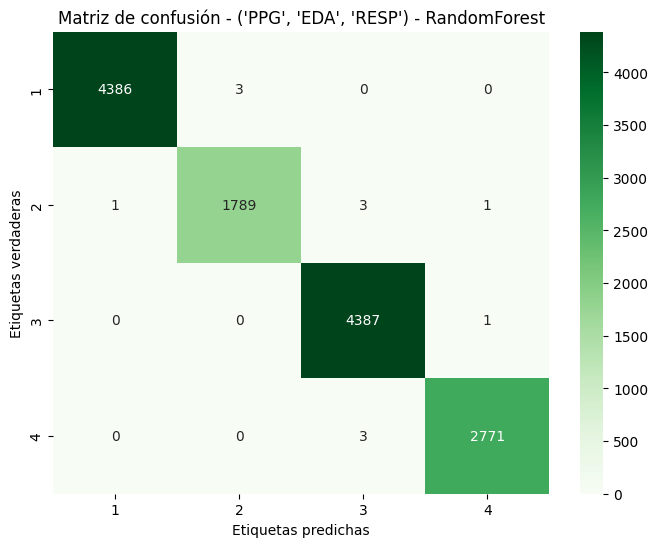

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4389
           2       1.00      1.00      1.00      1794
           3       1.00      1.00      1.00      4388
           4       1.00      1.00      1.00      2774

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training AdaBoost model for ('PPG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
('PPG', 'EDA', 'RESP') - AdaBoost Metrics
     Métrica     Valor                              Etapa
0   Accuracy  0.826227  ('PPG', 'EDA', 'RESP') - AdaBoost
1  Precision  0.834079  ('PPG', 'EDA', 'RESP') - AdaBoost
2     Recall  0.826227  ('PPG', 'EDA', 'RESP') - AdaBoost
3   F1 Score  0.828747  ('PPG', 'EDA', 'RESP') - AdaBoost
[('PPG', 'EDA', 'RESP') - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(class_weight='balanc

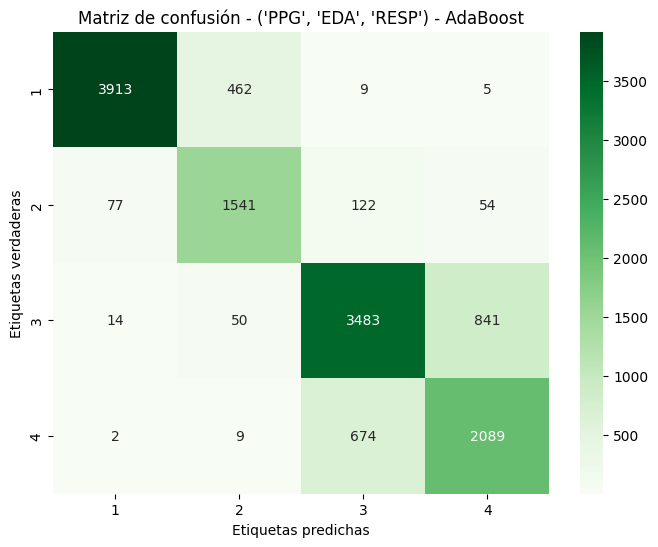

              precision    recall  f1-score   support

           1       0.98      0.89      0.93      4389
           2       0.75      0.86      0.80      1794
           3       0.81      0.79      0.80      4388
           4       0.70      0.75      0.72      2774

    accuracy                           0.83     13345
   macro avg       0.81      0.82      0.81     13345
weighted avg       0.83      0.83      0.83     13345

Training LDA model for ('PPG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
('PPG', 'EDA', 'RESP') - LDA Metrics
     Métrica     Valor                         Etapa
0   Accuracy  0.617685  ('PPG', 'EDA', 'RESP') - LDA
1  Precision  0.595606  ('PPG', 'EDA', 'RESP') - LDA
2     Recall  0.617685  ('PPG', 'EDA', 'RESP') - LDA
3   F1 Score  0.587590  ('PPG', 'EDA', 'RESP') - LDA
[('PPG', 'EDA', 'RESP') - LDA] Best Params: {'solver': 'svd'}
[('PPG', 'EDA', 'RESP') - LDA] Accuracy: 0.6177
('PPG', 'EDA', 'RESP') - LDA - Con

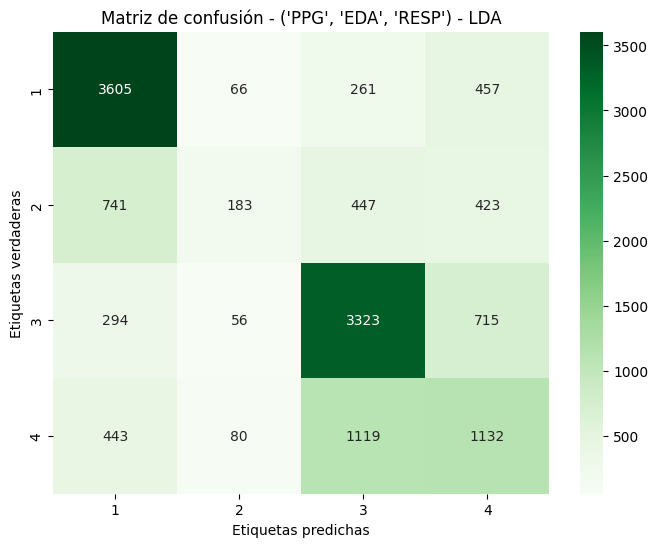

              precision    recall  f1-score   support

           1       0.71      0.82      0.76      4389
           2       0.48      0.10      0.17      1794
           3       0.65      0.76      0.70      4388
           4       0.42      0.41      0.41      2774

    accuracy                           0.62     13345
   macro avg       0.56      0.52      0.51     13345
weighted avg       0.60      0.62      0.59     13345

Training KNN model for ('PPG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
('PPG', 'EDA', 'RESP') - KNN Metrics
     Métrica     Valor                         Etapa
0   Accuracy  0.990408  ('PPG', 'EDA', 'RESP') - KNN
1  Precision  0.990407  ('PPG', 'EDA', 'RESP') - KNN
2     Recall  0.990408  ('PPG', 'EDA', 'RESP') - KNN
3   F1 Score  0.990408  ('PPG', 'EDA', 'RESP') - KNN
[('PPG', 'EDA', 'RESP') - KNN] Best Params: {'n_neighbors': 3, 'weights': 'distance'}
[('PPG', 'EDA', 'RESP') - KNN] Accuracy: 0.9904
('PPG', '

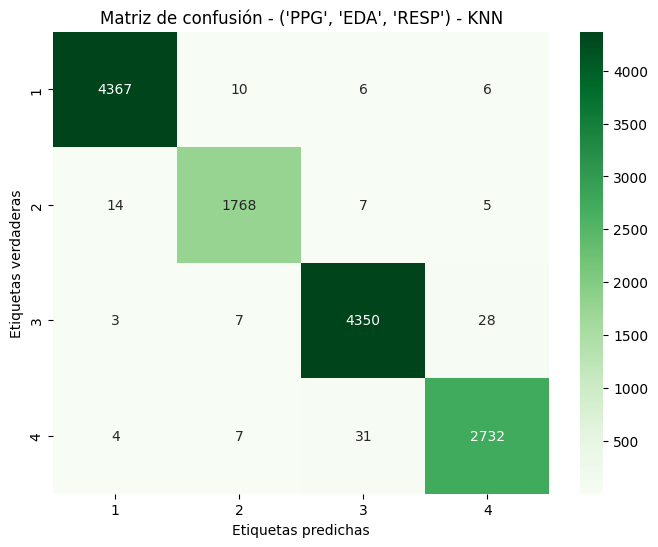

Training by signal combinations:  91%|█████████ | 10/11 [17:55:09<1:52:25, 6745.36s/it]

              precision    recall  f1-score   support

           1       1.00      0.99      1.00      4389
           2       0.99      0.99      0.99      1794
           3       0.99      0.99      0.99      4388
           4       0.99      0.98      0.99      2774

    accuracy                           0.99     13345
   macro avg       0.99      0.99      0.99     13345
weighted avg       0.99      0.99      0.99     13345

Training DecisionTree model for ('ECG', 'PPG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
('ECG', 'PPG', 'EDA', 'RESP') - DecisionTree Metrics
     Métrica     Valor                                         Etapa
0   Accuracy  0.662121  ('ECG', 'PPG', 'EDA', 'RESP') - DecisionTree
1  Precision  0.701403  ('ECG', 'PPG', 'EDA', 'RESP') - DecisionTree
2     Recall  0.662121  ('ECG', 'PPG', 'EDA', 'RESP') - DecisionTree
3   F1 Score  0.668136  ('ECG', 'PPG', 'EDA', 'RESP') - DecisionTree
[('ECG', 'PPG', 'EDA', 'RESP

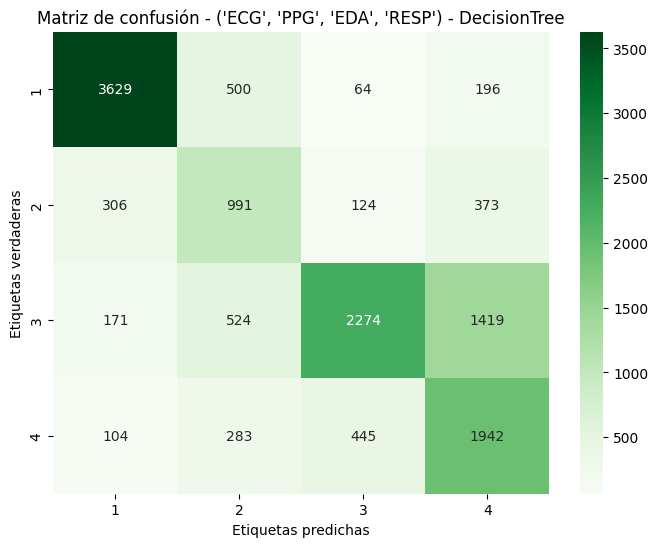

              precision    recall  f1-score   support

           1       0.86      0.83      0.84      4389
           2       0.43      0.55      0.48      1794
           3       0.78      0.52      0.62      4388
           4       0.49      0.70      0.58      2774

    accuracy                           0.66     13345
   macro avg       0.64      0.65      0.63     13345
weighted avg       0.70      0.66      0.67     13345

Training RandomForest model for ('ECG', 'PPG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
('ECG', 'PPG', 'EDA', 'RESP') - RandomForest Metrics
     Métrica     Valor                                         Etapa
0   Accuracy  0.999026  ('ECG', 'PPG', 'EDA', 'RESP') - RandomForest
1  Precision  0.999026  ('ECG', 'PPG', 'EDA', 'RESP') - RandomForest
2     Recall  0.999026  ('ECG', 'PPG', 'EDA', 'RESP') - RandomForest
3   F1 Score  0.999026  ('ECG', 'PPG', 'EDA', 'RESP') - RandomForest
[('ECG', 'PPG', 'EDA', 'RESP

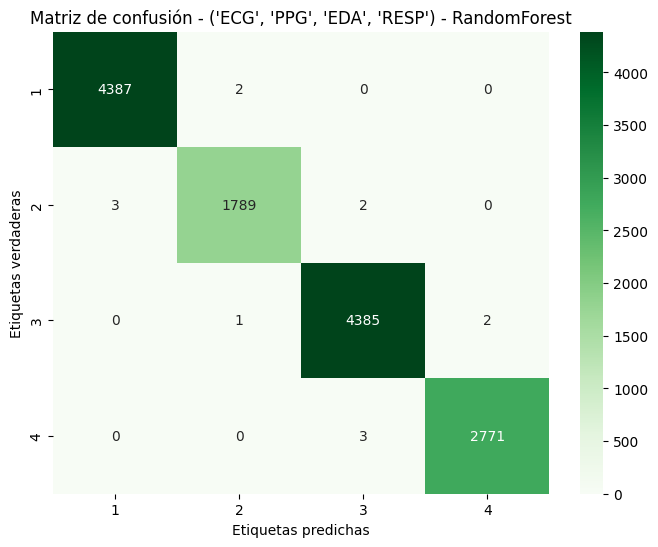

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4389
           2       1.00      1.00      1.00      1794
           3       1.00      1.00      1.00      4388
           4       1.00      1.00      1.00      2774

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345

Training AdaBoost model for ('ECG', 'PPG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
('ECG', 'PPG', 'EDA', 'RESP') - AdaBoost Metrics
     Métrica     Valor                                     Etapa
0   Accuracy  0.830199  ('ECG', 'PPG', 'EDA', 'RESP') - AdaBoost
1  Precision  0.832783  ('ECG', 'PPG', 'EDA', 'RESP') - AdaBoost
2     Recall  0.830199  ('ECG', 'PPG', 'EDA', 'RESP') - AdaBoost
3   F1 Score  0.830476  ('ECG', 'PPG', 'EDA', 'RESP') - AdaBoost
[('ECG', 'PPG', 'EDA', 'RESP') - AdaBoost] Best Params: {

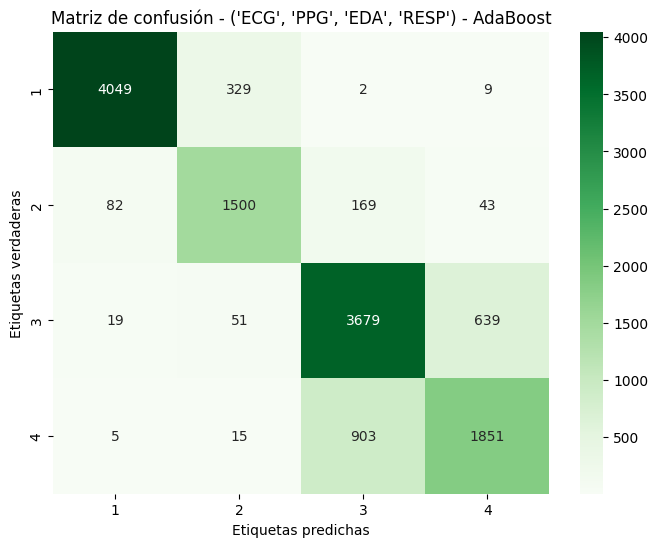

              precision    recall  f1-score   support

           1       0.97      0.92      0.95      4389
           2       0.79      0.84      0.81      1794
           3       0.77      0.84      0.80      4388
           4       0.73      0.67      0.70      2774

    accuracy                           0.83     13345
   macro avg       0.82      0.82      0.82     13345
weighted avg       0.83      0.83      0.83     13345

Training LDA model for ('ECG', 'PPG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
('ECG', 'PPG', 'EDA', 'RESP') - LDA Metrics
     Métrica     Valor                                Etapa
0   Accuracy  0.629449  ('ECG', 'PPG', 'EDA', 'RESP') - LDA
1  Precision  0.610578  ('ECG', 'PPG', 'EDA', 'RESP') - LDA
2     Recall  0.629449  ('ECG', 'PPG', 'EDA', 'RESP') - LDA
3   F1 Score  0.604154  ('ECG', 'PPG', 'EDA', 'RESP') - LDA
[('ECG', 'PPG', 'EDA', 'RESP') - LDA] Best Params: {'solver': 'svd'}
[('ECG', 'PPG', 'EDA', 'RE

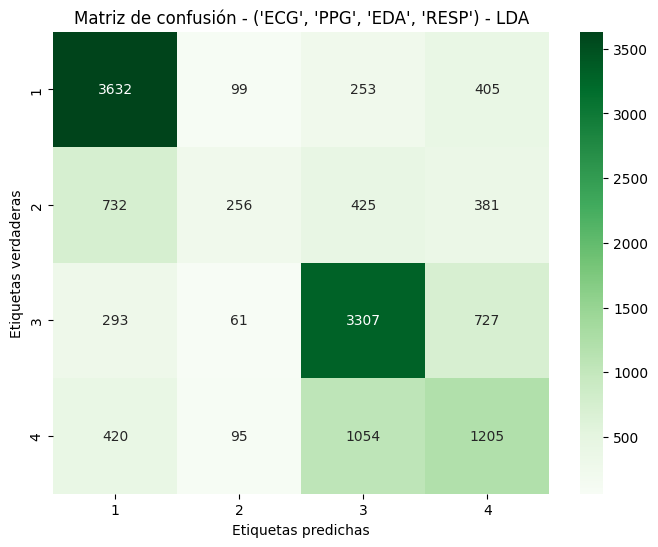

              precision    recall  f1-score   support

           1       0.72      0.83      0.77      4389
           2       0.50      0.14      0.22      1794
           3       0.66      0.75      0.70      4388
           4       0.44      0.43      0.44      2774

    accuracy                           0.63     13345
   macro avg       0.58      0.54      0.53     13345
weighted avg       0.61      0.63      0.60     13345

Training KNN model for ('ECG', 'PPG', 'EDA', 'RESP') using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
('ECG', 'PPG', 'EDA', 'RESP') - KNN Metrics
     Métrica     Valor                                Etapa
0   Accuracy  0.589809  ('ECG', 'PPG', 'EDA', 'RESP') - KNN
1  Precision  0.586069  ('ECG', 'PPG', 'EDA', 'RESP') - KNN
2     Recall  0.589809  ('ECG', 'PPG', 'EDA', 'RESP') - KNN
3   F1 Score  0.587023  ('ECG', 'PPG', 'EDA', 'RESP') - KNN
[('ECG', 'PPG', 'EDA', 'RESP') - KNN] Best Params: {'n_neighbors': 5, 'weights': 'distance'}
[

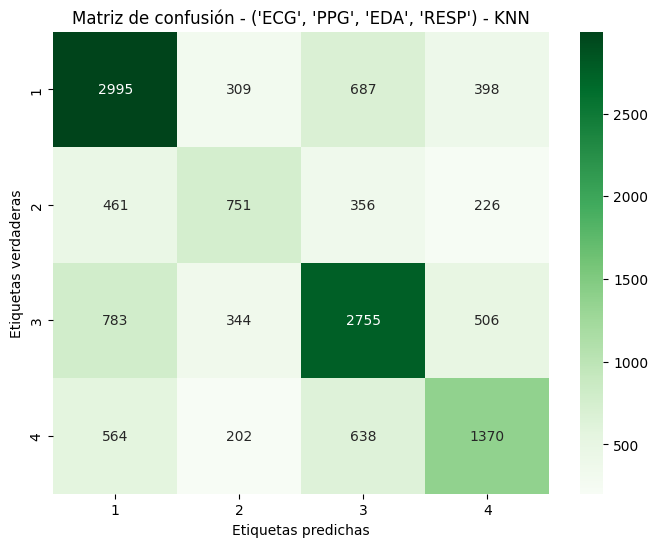

Training by signal combinations: 100%|██████████| 11/11 [20:14:17<00:00, 6623.37s/it]  

              precision    recall  f1-score   support

           1       0.62      0.68      0.65      4389
           2       0.47      0.42      0.44      1794
           3       0.62      0.63      0.62      4388
           4       0.55      0.49      0.52      2774

    accuracy                           0.59     13345
   macro avg       0.57      0.56      0.56     13345
weighted avg       0.59      0.59      0.59     13345


Final Comparison:
('ECG', 'PPG') - DecisionTree:
     Métrica     Valor                          Etapa
0   Accuracy  0.588985  ('ECG', 'PPG') - DecisionTree
1  Precision  0.670306  ('ECG', 'PPG') - DecisionTree
2     Recall  0.588985  ('ECG', 'PPG') - DecisionTree
3   F1 Score  0.612152  ('ECG', 'PPG') - DecisionTree
('ECG', 'PPG') - RandomForest:
     Métrica     Valor                          Etapa
0   Accuracy  0.990259  ('ECG', 'PPG') - RandomForest
1  Precision  0.990265  ('ECG', 'PPG') - RandomForest
2     Recall  0.990259  ('ECG', 'PPG') - RandomFores

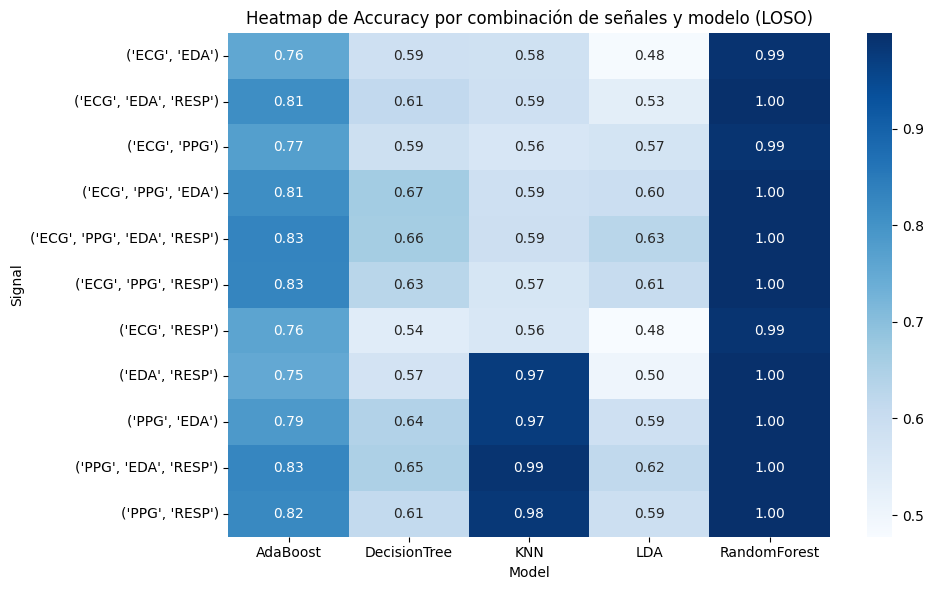

c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: 
The palette list has fewer values (9) than needed (11) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: 
The palette list has fewer values (9) than needed (11) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: 
The palette list has fewer values (9) than needed (11) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: 
The palette list has fewer values (9) than needed (11) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
C:\Users\Gustavo\AppData\Local\Temp\ipyk

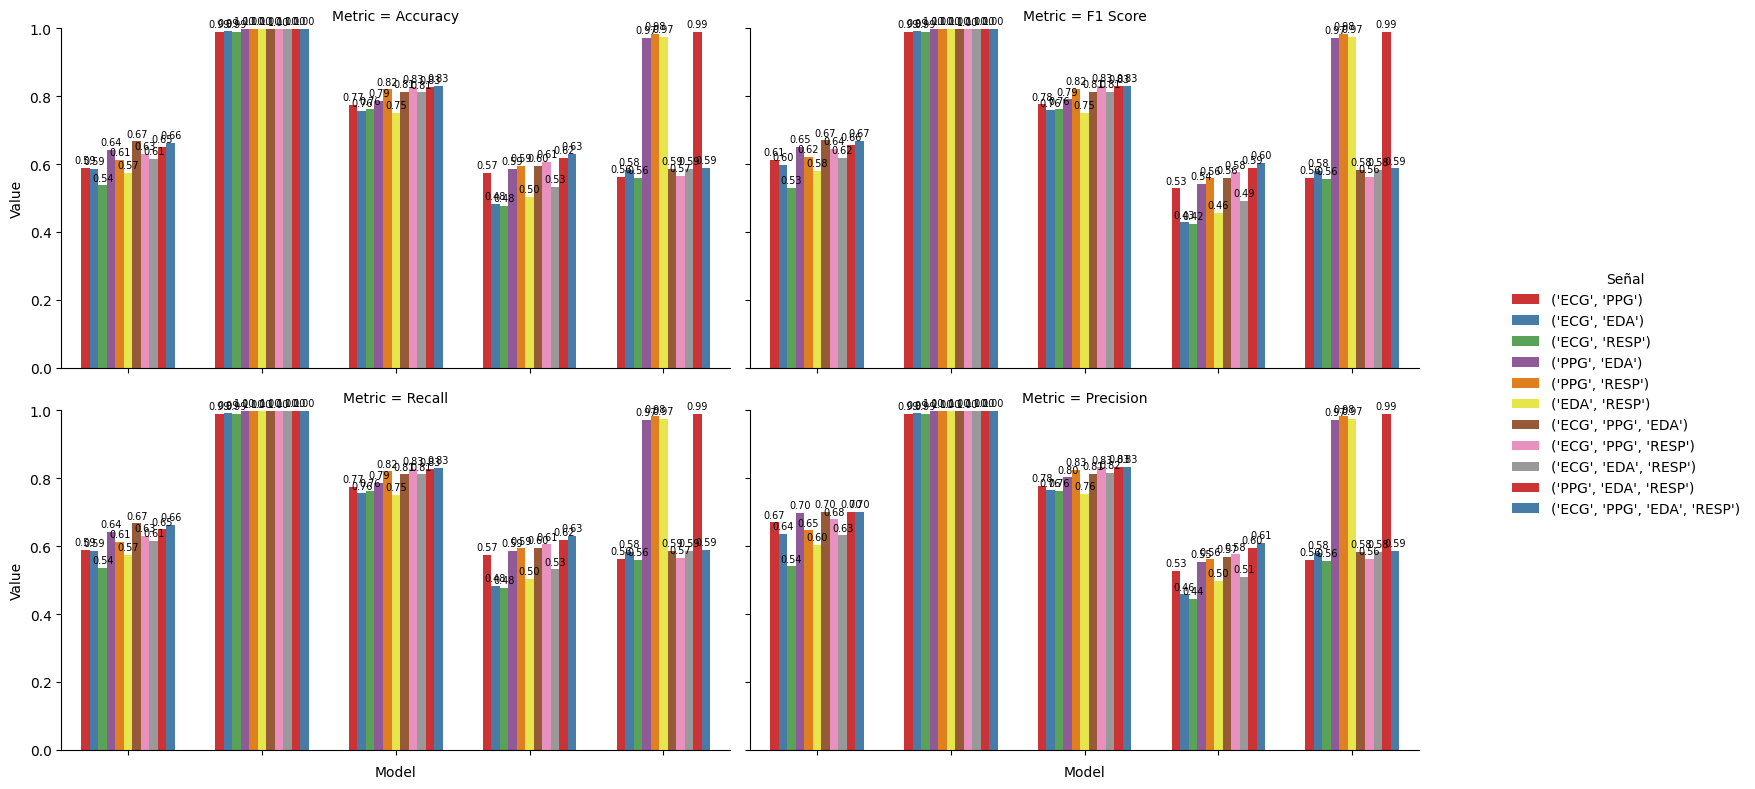

In [ ]:
for combo in tqdm(combinations, desc="Training by signal combinations"):
    features = sum([SIGNAL_CATEGORIES[signal] for signal in combo], [])
    if all(f in df.columns for f in features):# Verificar que todas las columnas existen
        X = df[features].values
        y = df['label'].values
        subjects = df['subject'].values # Se agrega el identificador de sujetos para LOSO

        for model_name, (model, param_grid) in models.items():
            print(f'Training {model_name} model for {combo} using LOSO...')
            metrics = train_and_evaluate_logo(X, y, subjects, model, param_grid, model_name, combo)
        
            # Convertir diccionario de métricas a DataFrame con mismo formato que antes
            results[(combo, model_name)] = metrics.copy()

# Mostrar resultados finales
print("\nFinal Comparison:")
for (combo, model_name), acc in results.items():
    print(f'{combo} - {model_name}:')
    print(acc)

# Crear heatmap
rows = []
for (combo, model), df_metrics in results.items():
    metric_values = df_metrics.set_index('Métrica')['Valor']

    row = {
    'Signal': combo,
    'Model': model,
    'Accuracy': metric_values.get('Accuracy', None),
    'F1': metric_values.get('F1 Score', None),
    'Precision': metric_values.get('Precision', None),
    'Recall': metric_values.get('Recall', None)
    }
    rows.append(row)

metrics_df = pd.DataFrame(rows)

pivot_df = metrics_df.pivot(index='Signal', columns='Model', values='Accuracy')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, cmap="Blues", fmt=".2f")
plt.title('Heatmap de Accuracy por combinación de señales y modelo (LOSO)')
plt.tight_layout()
plt.show()

data = []
metrics = ["Accuracy", "F1 Score", "Recall", "Precision"]

for (combo, model), df in results.items():
    for metric in metrics:
        row = df[df["Métrica"] == metric]
        if not row.empty:
            value = row["Valor"].values[0]
            data.append((combo, model, metric, value))

df_all = pd.DataFrame(data, columns=["Signal", "Model", "Metric", "Value"])

# Paleta bonita
palette = sns.color_palette("Set1")

# Hacer el FacetGrid
g = sns.FacetGrid(df_all, col="Metric", sharey=True, col_wrap=2, height=4, aspect=1.5)
g.map_dataframe(sns.barplot, x="Model", y="Value", hue="Signal", palette=palette, width=0.7, dodge=True)

# Ajustes para la leyenda
g.add_legend(title="Señal", bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0)

# Añadir etiquetas de valores
for ax in g.axes.flatten():
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=7, padding=2)
    ax.set_ylim(0, 1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

In [ ]:
print(wa)

NameError: name 'wa' is not defined

Training by signal:   0%|          | 0/4 [00:00<?, ?it/s]

Training DecisionTree model for ECG...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
ECG - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.426637  ECG - DecisionTree
1  Precision  0.524099  ECG - DecisionTree
2     Recall  0.426637  ECG - DecisionTree
3   F1 Score  0.356113  ECG - DecisionTree
[ECG - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 10, 'min_samples_split': 2}
[ECG - DecisionTree] Accuracy: 0.4266
ECG - DecisionTree - Confusion Matrix
[[6270   15  231   67]
 [2297  230  114   51]
 [4466  228 1473  415]
 [3266   78  249  567]]


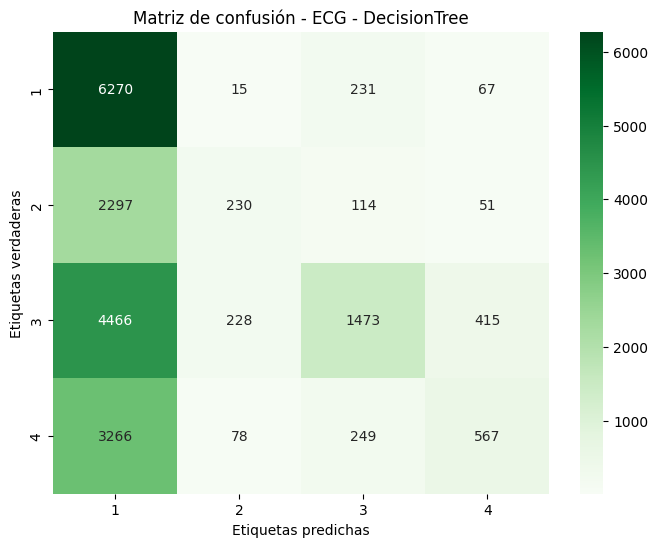

              precision    recall  f1-score   support

           1       0.38      0.95      0.55      6583
           2       0.42      0.09      0.14      2692
           3       0.71      0.22      0.34      6582
           4       0.52      0.14      0.22      4160

    accuracy                           0.43     20017
   macro avg       0.51      0.35      0.31     20017
weighted avg       0.52      0.43      0.36     20017

Training RandomForest model for ECG...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
ECG - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.942499  ECG - RandomForest
1  Precision  0.943431  ECG - RandomForest
2     Recall  0.942499  ECG - RandomForest
3   F1 Score  0.942231  ECG - RandomForest
[ECG - RandomForest] Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
[ECG - RandomForest] Accuracy: 0.9425
ECG - RandomForest - Confusion Matrix
[[6393   21  114   55]
 [ 203 2322  127   40]
 

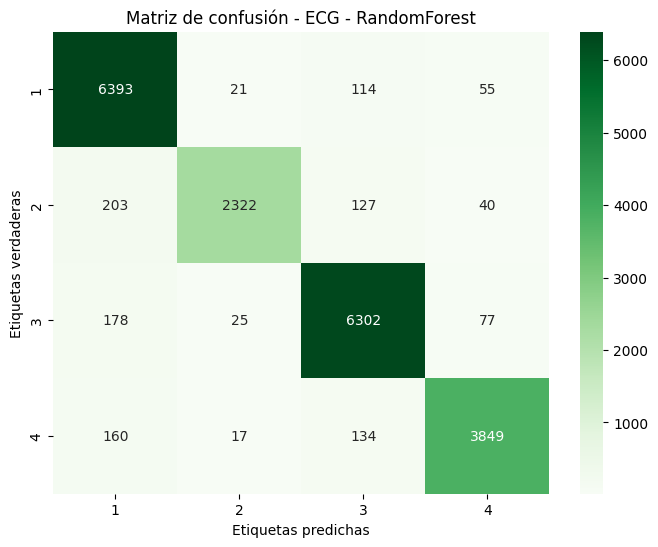

              precision    recall  f1-score   support

           1       0.92      0.97      0.95      6583
           2       0.97      0.86      0.91      2692
           3       0.94      0.96      0.95      6582
           4       0.96      0.93      0.94      4160

    accuracy                           0.94     20017
   macro avg       0.95      0.93      0.94     20017
weighted avg       0.94      0.94      0.94     20017

Training AdaBoost model for ECG...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
ECG - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.586152  ECG - AdaBoost
1  Precision  0.581555  ECG - AdaBoost
2     Recall  0.586152  ECG - AdaBoost
3   F1 Score  0.580388  ECG - AdaBoost
[ECG - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.5, 'n_estimators': 300}
[ECG - AdaBoost] Accuracy: 0.5862
ECG - AdaBoost - Confusion Matrix
[[4478  615  995  495]
 [ 947  885  631  229]
 [1388  285 

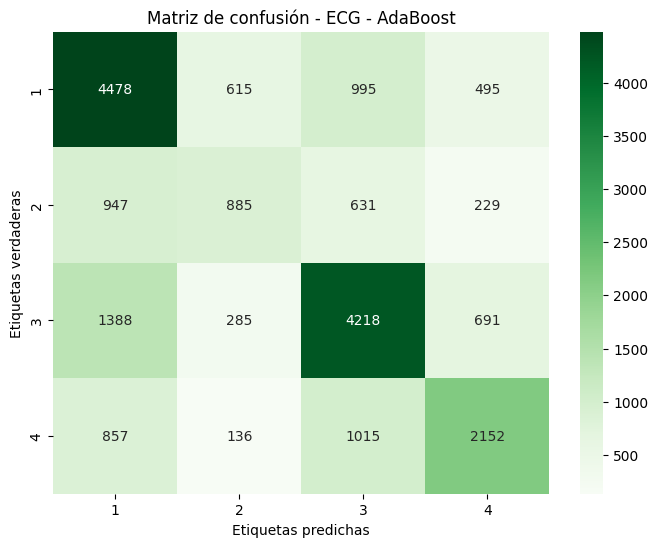

              precision    recall  f1-score   support

           1       0.58      0.68      0.63      6583
           2       0.46      0.33      0.38      2692
           3       0.61      0.64      0.63      6582
           4       0.60      0.52      0.56      4160

    accuracy                           0.59     20017
   macro avg       0.57      0.54      0.55     20017
weighted avg       0.58      0.59      0.58     20017

Training LDA model for ECG...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
ECG - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.415197  ECG - LDA
1  Precision  0.417248  ECG - LDA
2     Recall  0.415197  ECG - LDA
3   F1 Score  0.358256  ECG - LDA
[ECG - LDA] Best Params: {'solver': 'svd'}
[ECG - LDA] Accuracy: 0.4152
ECG - LDA - Confusion Matrix
[[4671    8 1578  326]
 [1610   11  925  146]
 [2983    3 3145  451]
 [2123    0 1553  484]]


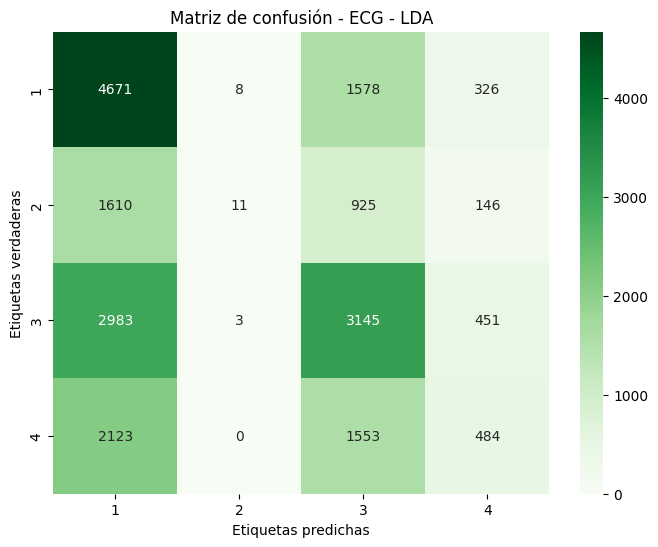

              precision    recall  f1-score   support

           1       0.41      0.71      0.52      6583
           2       0.50      0.00      0.01      2692
           3       0.44      0.48      0.46      6582
           4       0.34      0.12      0.17      4160

    accuracy                           0.42     20017
   macro avg       0.42      0.33      0.29     20017
weighted avg       0.42      0.42      0.36     20017

Training KNN model for ECG...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
ECG - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.657541  ECG - KNN
1  Precision  0.655851  ECG - KNN
2     Recall  0.657541  ECG - KNN
3   F1 Score  0.655284  ECG - KNN
[ECG - KNN] Best Params: {'n_neighbors': 7, 'weights': 'distance'}
[ECG - KNN] Accuracy: 0.6575
ECG - KNN - Confusion Matrix
[[4809  326  942  506]
 [ 567 1394  507  224]
 [1073  323 4556  630]
 [ 774  224  759 2403]]


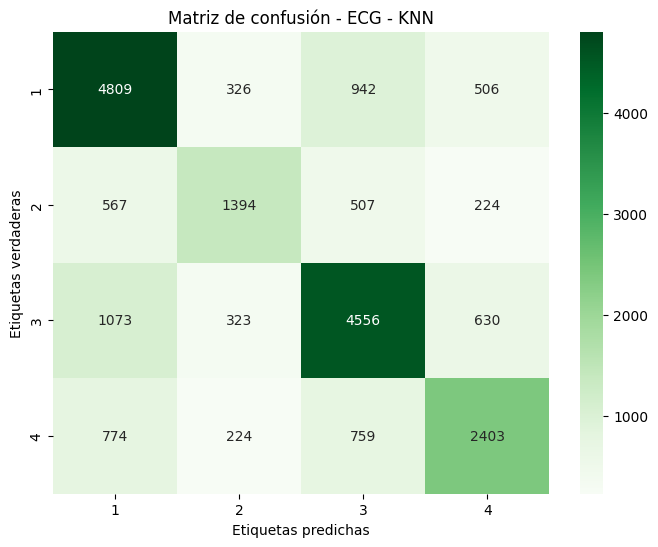

Training by signal:  25%|██▌       | 1/4 [44:06<2:12:20, 2646.71s/it]

              precision    recall  f1-score   support

           1       0.67      0.73      0.70      6583
           2       0.61      0.52      0.56      2692
           3       0.67      0.69      0.68      6582
           4       0.64      0.58      0.61      4160

    accuracy                           0.66     20017
   macro avg       0.65      0.63      0.64     20017
weighted avg       0.66      0.66      0.66     20017

Training DecisionTree model for PPG...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
PPG - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.589749  PPG - DecisionTree
1  Precision  0.657386  PPG - DecisionTree
2     Recall  0.589749  PPG - DecisionTree
3   F1 Score  0.611145  PPG - DecisionTree
[PPG - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[PPG - DecisionTree] Accuracy: 0.5897
PPG - DecisionTree - Confusion Matrix
[[4480 1182  122  799]
 [ 6

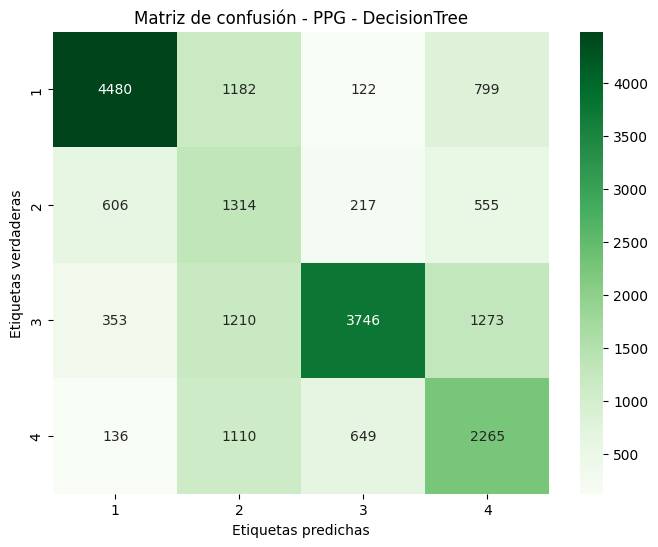

              precision    recall  f1-score   support

           1       0.80      0.68      0.74      6583
           2       0.27      0.49      0.35      2692
           3       0.79      0.57      0.66      6582
           4       0.46      0.54      0.50      4160

    accuracy                           0.59     20017
   macro avg       0.58      0.57      0.56     20017
weighted avg       0.66      0.59      0.61     20017

Training RandomForest model for PPG...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
PPG - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.995204  PPG - RandomForest
1  Precision  0.995213  PPG - RandomForest
2     Recall  0.995204  PPG - RandomForest
3   F1 Score  0.995199  PPG - RandomForest
[PPG - RandomForest] Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
[PPG - RandomForest] Accuracy: 0.9952
PPG - RandomForest - Confusion Matrix
[[6574    2    2    5]
 [  27 2652    9    4]
 

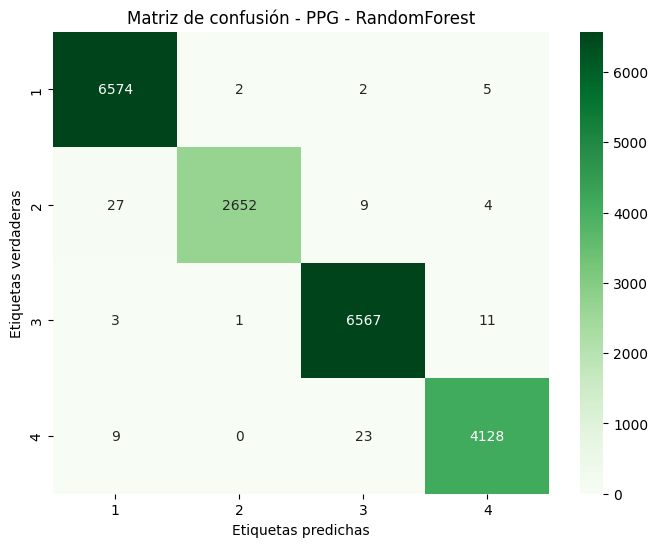

              precision    recall  f1-score   support

           1       0.99      1.00      1.00      6583
           2       1.00      0.99      0.99      2692
           3       0.99      1.00      1.00      6582
           4       1.00      0.99      0.99      4160

    accuracy                           1.00     20017
   macro avg       1.00      0.99      0.99     20017
weighted avg       1.00      1.00      1.00     20017

Training AdaBoost model for PPG...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
PPG - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.774192  PPG - AdaBoost
1  Precision  0.775871  PPG - AdaBoost
2     Recall  0.774192  PPG - AdaBoost
3   F1 Score  0.774591  PPG - AdaBoost
[PPG - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.5, 'n_estimators': 300}
[PPG - AdaBoost] Accuracy: 0.7742
PPG - AdaBoost - Confusion Matrix
[[5728  562  141  152]
 [ 520 1599  283  290]
 [ 153  213 

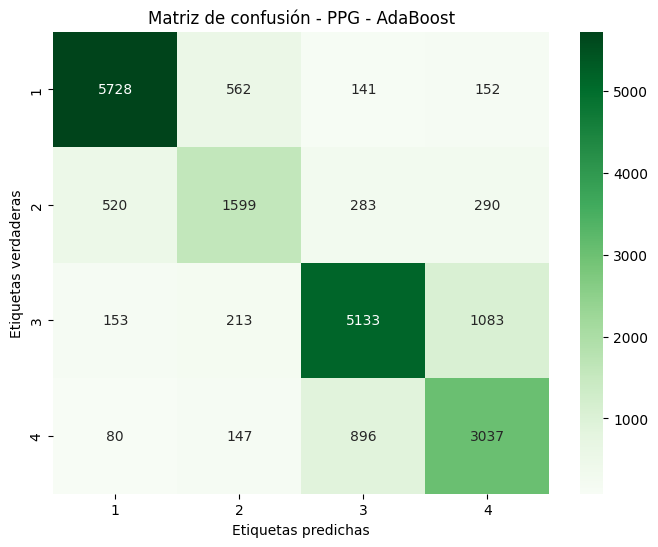

              precision    recall  f1-score   support

           1       0.88      0.87      0.88      6583
           2       0.63      0.59      0.61      2692
           3       0.80      0.78      0.79      6582
           4       0.67      0.73      0.70      4160

    accuracy                           0.77     20017
   macro avg       0.74      0.74      0.74     20017
weighted avg       0.78      0.77      0.77     20017

Training LDA model for PPG...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
PPG - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.561573  PPG - LDA
1  Precision  0.519806  PPG - LDA
2     Recall  0.561573  PPG - LDA
3   F1 Score  0.508671  PPG - LDA
[PPG - LDA] Best Params: {'solver': 'svd'}
[PPG - LDA] Accuracy: 0.5616
PPG - LDA - Confusion Matrix
[[5087   28  773  695]
 [1208   29  919  536]
 [ 670    4 5105  803]
 [ 767   16 2357 1020]]


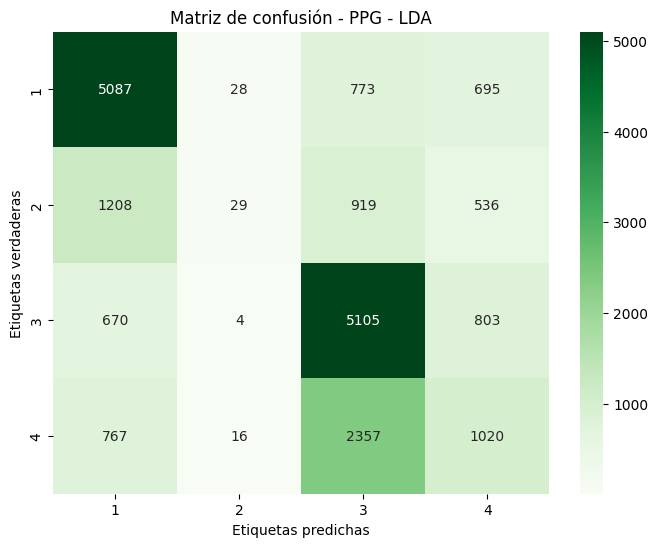

              precision    recall  f1-score   support

           1       0.66      0.77      0.71      6583
           2       0.38      0.01      0.02      2692
           3       0.56      0.78      0.65      6582
           4       0.33      0.25      0.28      4160

    accuracy                           0.56     20017
   macro avg       0.48      0.45      0.42     20017
weighted avg       0.52      0.56      0.51     20017

Training KNN model for PPG...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
PPG - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.882949  PPG - KNN
1  Precision  0.882701  PPG - KNN
2     Recall  0.882949  PPG - KNN
3   F1 Score  0.882814  PPG - KNN
[PPG - KNN] Best Params: {'n_neighbors': 3, 'weights': 'distance'}
[PPG - KNN] Accuracy: 0.8829
PPG - KNN - Confusion Matrix
[[6066  182  170  165]
 [ 207 2170  159  156]
 [ 137  176 5944  325]
 [ 198  121  347 3494]]


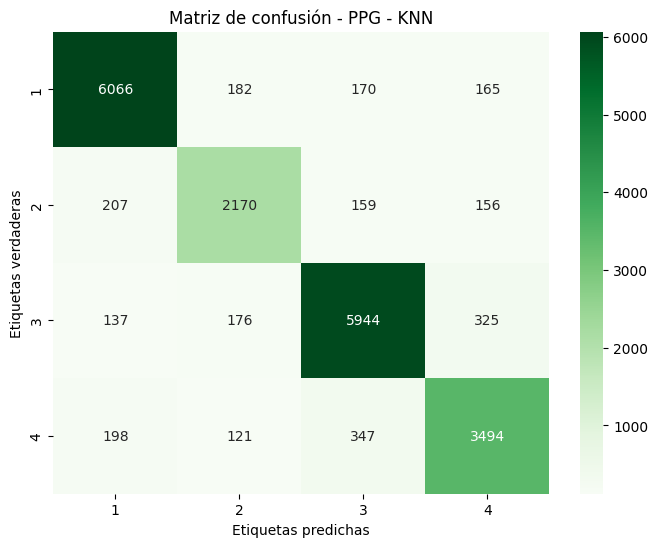

Training by signal:  50%|█████     | 2/4 [1:26:26<1:26:07, 2583.98s/it]

              precision    recall  f1-score   support

           1       0.92      0.92      0.92      6583
           2       0.82      0.81      0.81      2692
           3       0.90      0.90      0.90      6582
           4       0.84      0.84      0.84      4160

    accuracy                           0.88     20017
   macro avg       0.87      0.87      0.87     20017
weighted avg       0.88      0.88      0.88     20017

Training DecisionTree model for EDA...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
EDA - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.518559  EDA - DecisionTree
1  Precision  0.592203  EDA - DecisionTree
2     Recall  0.518559  EDA - DecisionTree
3   F1 Score  0.531905  EDA - DecisionTree
[EDA - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 15, 'max_leaf_nodes': 40, 'min_samples_split': 2}
[EDA - DecisionTree] Accuracy: 0.5186
EDA - DecisionTree - Confusion Matrix
[[3474 1106  747 1256]
 [ 2

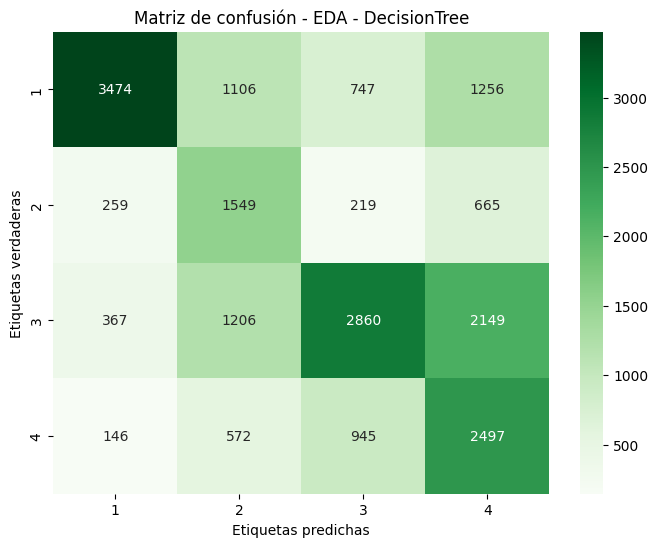

              precision    recall  f1-score   support

           1       0.82      0.53      0.64      6583
           2       0.35      0.58      0.43      2692
           3       0.60      0.43      0.50      6582
           4       0.38      0.60      0.47      4160

    accuracy                           0.52     20017
   macro avg       0.54      0.53      0.51     20017
weighted avg       0.59      0.52      0.53     20017

Training RandomForest model for EDA...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
EDA - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.992656  EDA - RandomForest
1  Precision  0.992669  EDA - RandomForest
2     Recall  0.992656  EDA - RandomForest
3   F1 Score  0.992653  EDA - RandomForest
[EDA - RandomForest] Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
[EDA - RandomForest] Accuracy: 0.9927
EDA - RandomForest - Confusion Matrix
[[6553    5   18    7]
 [  18 2656   12    6]
 

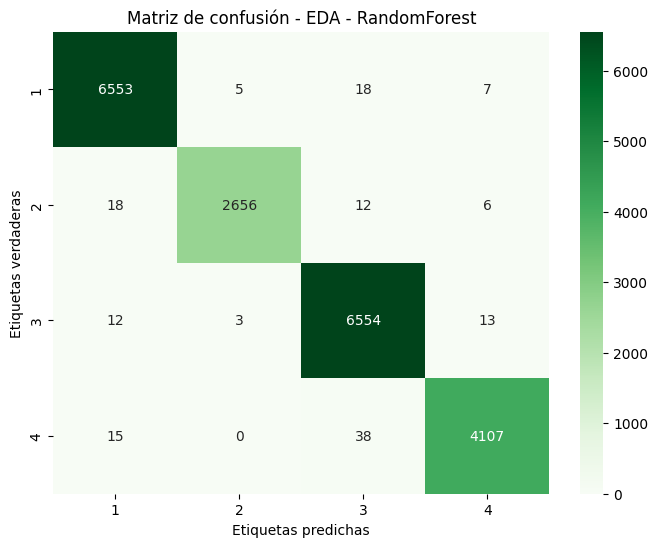

              precision    recall  f1-score   support

           1       0.99      1.00      0.99      6583
           2       1.00      0.99      0.99      2692
           3       0.99      1.00      0.99      6582
           4       0.99      0.99      0.99      4160

    accuracy                           0.99     20017
   macro avg       0.99      0.99      0.99     20017
weighted avg       0.99      0.99      0.99     20017

Training AdaBoost model for EDA...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
EDA - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.640605  EDA - AdaBoost
1  Precision  0.660503  EDA - AdaBoost
2     Recall  0.640605  EDA - AdaBoost
3   F1 Score  0.646235  EDA - AdaBoost
[EDA - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.5, 'n_estimators': 300}
[EDA - AdaBoost] Accuracy: 0.6406
EDA - AdaBoost - Confusion Matrix
[[4104 1329  759  391]
 [ 435 1564  348  345]
 [ 516  589 

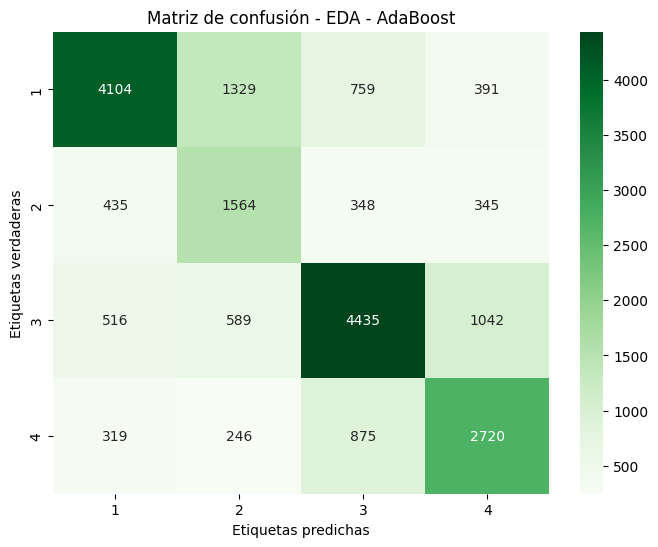

              precision    recall  f1-score   support

           1       0.76      0.62      0.69      6583
           2       0.42      0.58      0.49      2692
           3       0.69      0.67      0.68      6582
           4       0.60      0.65      0.63      4160

    accuracy                           0.64     20017
   macro avg       0.62      0.63      0.62     20017
weighted avg       0.66      0.64      0.65     20017

Training LDA model for EDA...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
EDA - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.417995  EDA - LDA
1  Precision  0.417615  EDA - LDA
2     Recall  0.417995  EDA - LDA
3   F1 Score  0.350615  EDA - LDA
[EDA - LDA] Best Params: {'solver': 'svd'}
[EDA - LDA] Accuracy: 0.4180
EDA - LDA - Confusion Matrix
[[4872    3 1455  253]
 [1466    7 1122   97]
 [3132    0 3182  268]
 [1850    3 2001  306]]


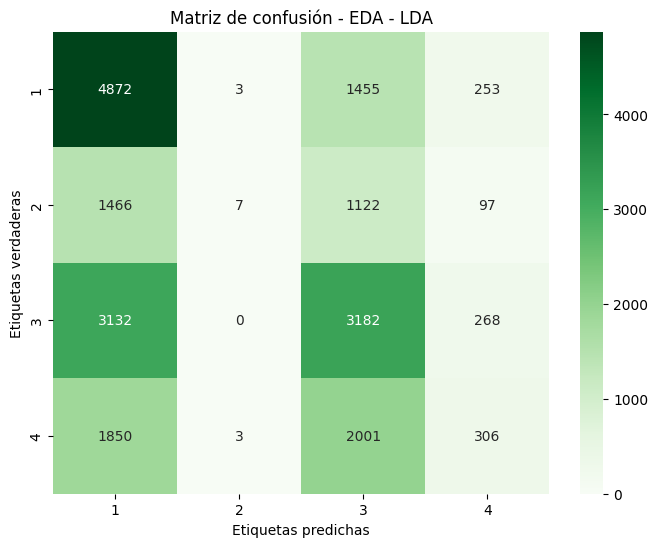

              precision    recall  f1-score   support

           1       0.43      0.74      0.54      6583
           2       0.54      0.00      0.01      2692
           3       0.41      0.48      0.44      6582
           4       0.33      0.07      0.12      4160

    accuracy                           0.42     20017
   macro avg       0.43      0.32      0.28     20017
weighted avg       0.42      0.42      0.35     20017

Training KNN model for EDA...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
EDA - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.923115  EDA - KNN
1  Precision  0.923083  EDA - KNN
2     Recall  0.923115  EDA - KNN
3   F1 Score  0.923096  EDA - KNN
[EDA - KNN] Best Params: {'n_neighbors': 3, 'weights': 'distance'}
[EDA - KNN] Accuracy: 0.9231
EDA - KNN - Confusion Matrix
[[6205  107  166  105]
 [ 105 2427  100   60]
 [ 189   94 6088  211]
 [ 107   68  227 3758]]


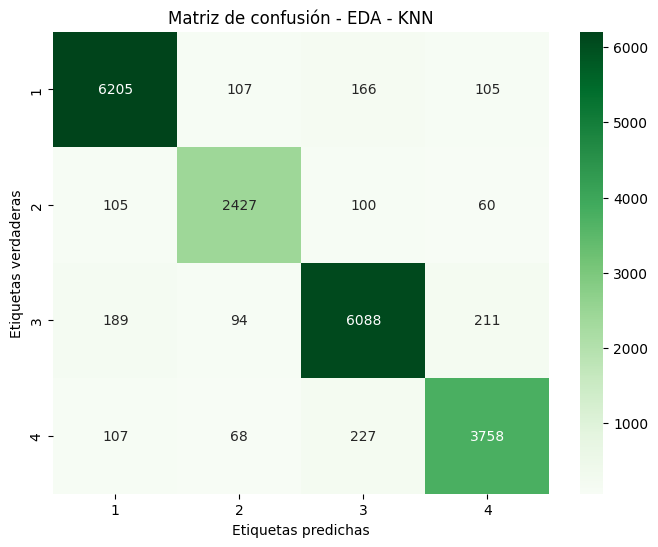

Training by signal:  75%|███████▌  | 3/4 [2:00:41<39:02, 2342.25s/it]  

              precision    recall  f1-score   support

           1       0.94      0.94      0.94      6583
           2       0.90      0.90      0.90      2692
           3       0.93      0.92      0.93      6582
           4       0.91      0.90      0.91      4160

    accuracy                           0.92     20017
   macro avg       0.92      0.92      0.92     20017
weighted avg       0.92      0.92      0.92     20017

Training DecisionTree model for RESP...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
RESP - DecisionTree Metrics
     Métrica     Valor                Etapa
0   Accuracy  0.454064  RESP - DecisionTree
1  Precision  0.475188  RESP - DecisionTree
2     Recall  0.454064  RESP - DecisionTree
3   F1 Score  0.453421  RESP - DecisionTree
[RESP - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 30, 'min_samples_split': 2}
[RESP - DecisionTree] Accuracy: 0.4541
RESP - DecisionTree - Confusion Matrix
[[2399 1299 1615 

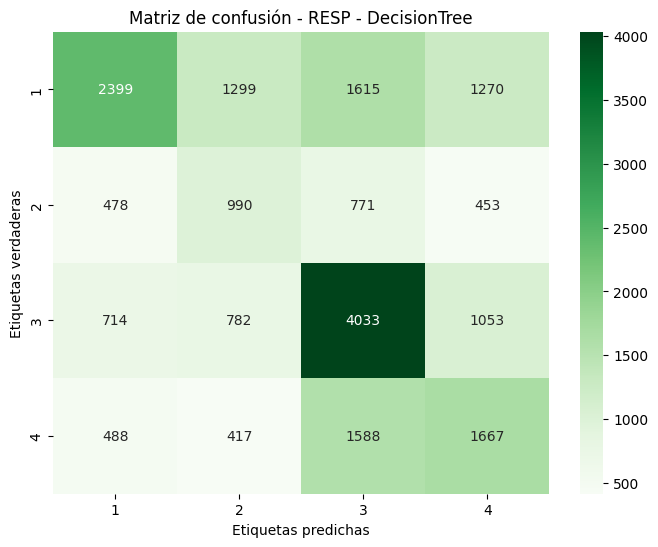

              precision    recall  f1-score   support

           1       0.59      0.36      0.45      6583
           2       0.28      0.37      0.32      2692
           3       0.50      0.61      0.55      6582
           4       0.38      0.40      0.39      4160

    accuracy                           0.45     20017
   macro avg       0.44      0.44      0.43     20017
weighted avg       0.48      0.45      0.45     20017

Training RandomForest model for RESP...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
RESP - RandomForest Metrics
     Métrica     Valor                Etapa
0   Accuracy  0.991807  RESP - RandomForest
1  Precision  0.991833  RESP - RandomForest
2     Recall  0.991807  RESP - RandomForest
3   F1 Score  0.991806  RESP - RandomForest
[RESP - RandomForest] Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
[RESP - RandomForest] Accuracy: 0.9918
RESP - RandomForest - Confusion Matrix
[[6547    2   28    6]
 [  13 2658   

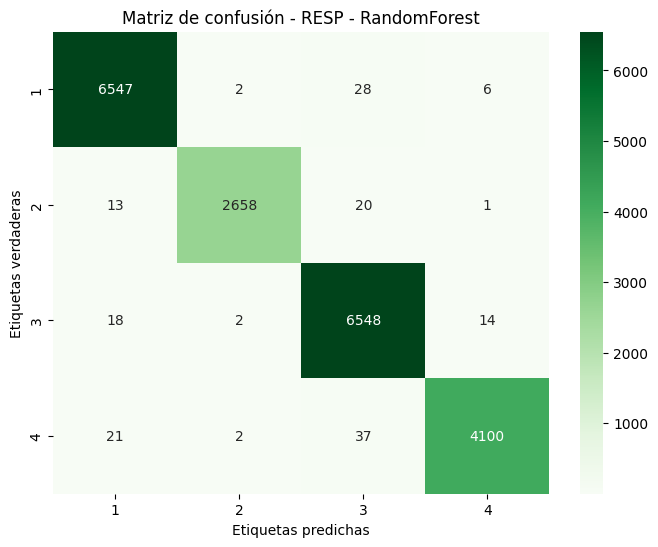

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      6583
           2       1.00      0.99      0.99      2692
           3       0.99      0.99      0.99      6582
           4       0.99      0.99      0.99      4160

    accuracy                           0.99     20017
   macro avg       0.99      0.99      0.99     20017
weighted avg       0.99      0.99      0.99     20017

Training AdaBoost model for RESP...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
RESP - AdaBoost Metrics
     Métrica     Valor            Etapa
0   Accuracy  0.676475  RESP - AdaBoost
1  Precision  0.680425  RESP - AdaBoost
2     Recall  0.676475  RESP - AdaBoost
3   F1 Score  0.672559  RESP - AdaBoost
[RESP - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.5, 'n_estimators': 300}
[RESP - AdaBoost] Accuracy: 0.6765
RESP - AdaBoost - Confusion Matrix
[[4961  192 1043  387]
 [ 641 1481  445  125]
 [

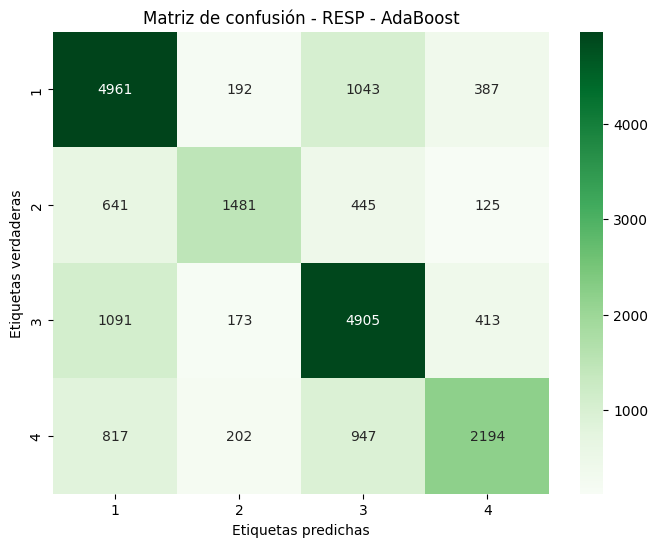

              precision    recall  f1-score   support

           1       0.66      0.75      0.70      6583
           2       0.72      0.55      0.62      2692
           3       0.67      0.75      0.70      6582
           4       0.70      0.53      0.60      4160

    accuracy                           0.68     20017
   macro avg       0.69      0.64      0.66     20017
weighted avg       0.68      0.68      0.67     20017

Training LDA model for RESP...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
RESP - LDA Metrics
     Métrica     Valor       Etapa
0   Accuracy  0.438477  RESP - LDA
1  Precision  0.496975  RESP - LDA
2     Recall  0.438477  RESP - LDA
3   F1 Score  0.363873  RESP - LDA
[RESP - LDA] Best Params: {'solver': 'svd'}
[RESP - LDA] Accuracy: 0.4385
RESP - LDA - Confusion Matrix
[[4372    0 2051  160]
 [1782    0  837   73]
 [2222    0 4222  138]
 [2495    0 1482  183]]


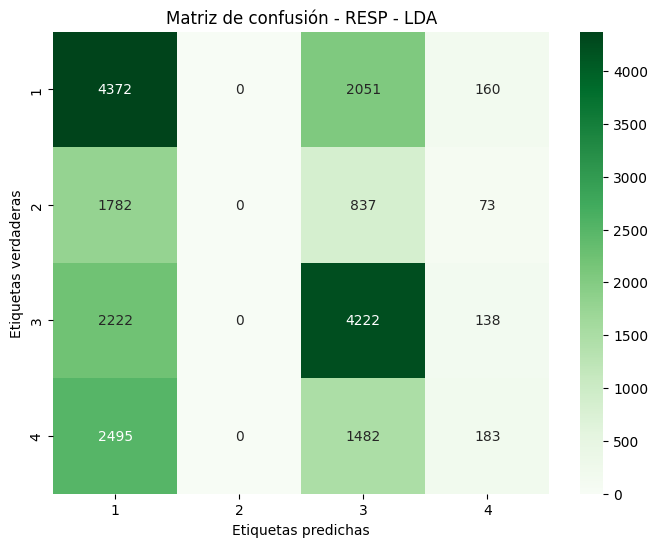

              precision    recall  f1-score   support

           1       0.40      0.66      0.50      6583
           2       0.00      0.00      0.00      2692
           3       0.49      0.64      0.56      6582
           4       0.33      0.04      0.08      4160

    accuracy                           0.44     20017
   macro avg       0.31      0.34      0.28     20017
weighted avg       0.36      0.44      0.36     20017

Training KNN model for RESP...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RESP - KNN Metrics
     Métrica     Valor       Etapa
0   Accuracy  0.976670  RESP - KNN
1  Precision  0.976686  RESP - KNN
2     Recall  0.976670  RESP - KNN
3   F1 Score  0.976669  RESP - KNN
[RESP - KNN] Best Params: {'n_neighbors': 3, 'weights': 'distance'}
[RESP - KNN] Accuracy: 0.9767
RESP - KNN - Confusion Matrix
[[6466   25   46   46]
 [  36 2613   29   14]
 [  78   27 6410   67]
 [  34   12   53 4061]]


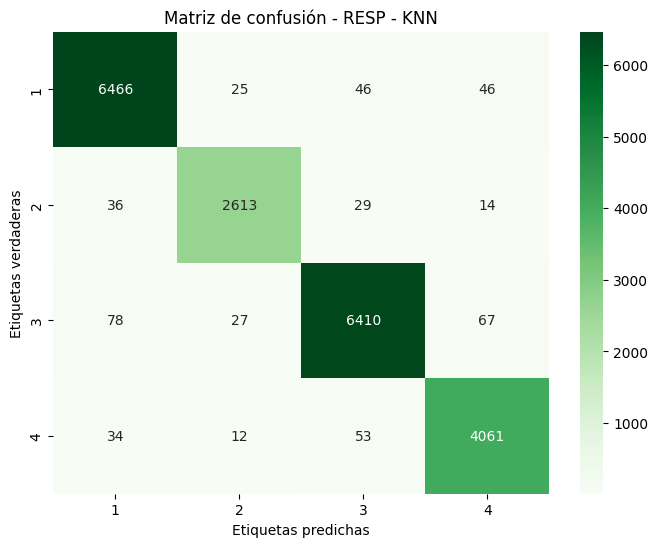

              precision    recall  f1-score   support

           1       0.98      0.98      0.98      6583
           2       0.98      0.97      0.97      2692
           3       0.98      0.97      0.98      6582
           4       0.97      0.98      0.97      4160

    accuracy                           0.98     20017
   macro avg       0.98      0.98      0.98     20017
weighted avg       0.98      0.98      0.98     20017



Training with ALL signals:   0%|          | 0/5 [00:00<?, ?it/s]

Training DecisionTree model for ALL signals using LOSO...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
ALL - DecisionTree Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.454064  ALL - DecisionTree
1  Precision  0.475188  ALL - DecisionTree
2     Recall  0.454064  ALL - DecisionTree
3   F1 Score  0.453421  ALL - DecisionTree
[ALL - DecisionTree] Best Params: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 30, 'min_samples_split': 2}
[ALL - DecisionTree] Accuracy: 0.4541
ALL - DecisionTree - Confusion Matrix
[[2399 1299 1615 1270]
 [ 478  990  771  453]
 [ 714  782 4033 1053]
 [ 488  417 1588 1667]]


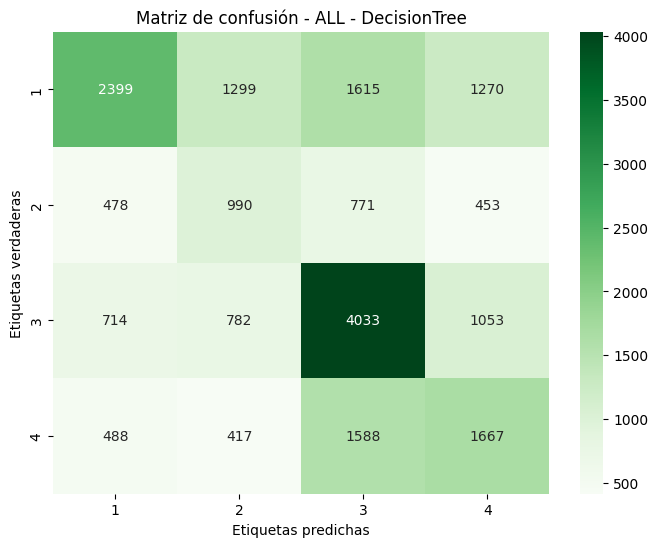

Training with ALL signals:  20%|██        | 1/5 [00:30<02:03, 30.80s/it]

              precision    recall  f1-score   support

           1       0.59      0.36      0.45      6583
           2       0.28      0.37      0.32      2692
           3       0.50      0.61      0.55      6582
           4       0.38      0.40      0.39      4160

    accuracy                           0.45     20017
   macro avg       0.44      0.44      0.43     20017
weighted avg       0.48      0.45      0.45     20017

Training RandomForest model for ALL signals using LOSO...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
ALL - RandomForest Metrics
     Métrica     Valor               Etapa
0   Accuracy  0.991807  ALL - RandomForest
1  Precision  0.991833  ALL - RandomForest
2     Recall  0.991807  ALL - RandomForest
3   F1 Score  0.991806  ALL - RandomForest
[ALL - RandomForest] Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
[ALL - RandomForest] Accuracy: 0.9918
ALL - RandomForest - Confusion Matrix
[[6547    2   28    6]
 [  1

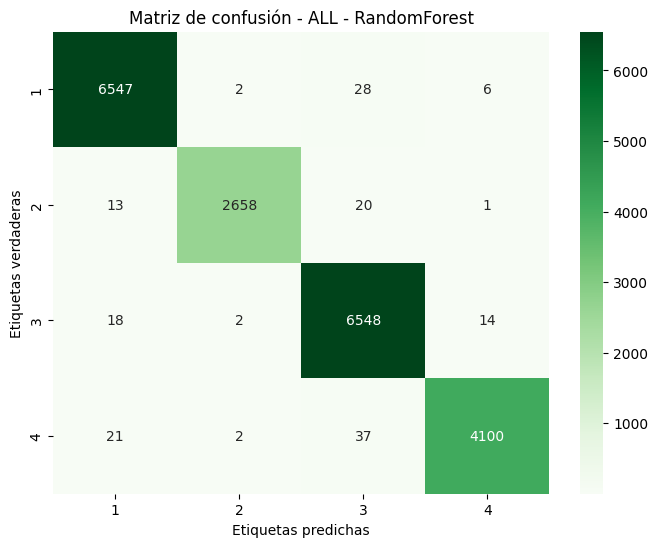

Training with ALL signals:  40%|████      | 2/5 [15:54<27:48, 556.00s/it]

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      6583
           2       1.00      0.99      0.99      2692
           3       0.99      0.99      0.99      6582
           4       0.99      0.99      0.99      4160

    accuracy                           0.99     20017
   macro avg       0.99      0.99      0.99     20017
weighted avg       0.99      0.99      0.99     20017

Training AdaBoost model for ALL signals using LOSO...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
ALL - AdaBoost Metrics
     Métrica     Valor           Etapa
0   Accuracy  0.676475  ALL - AdaBoost
1  Precision  0.680425  ALL - AdaBoost
2     Recall  0.676475  ALL - AdaBoost
3   F1 Score  0.672559  ALL - AdaBoost
[ALL - AdaBoost] Best Params: {'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.5, 'n_estimators': 300}
[ALL - AdaBoost] Accuracy: 0.6765
ALL - AdaBoost - Confusion Matrix
[[4961  192 1043  387]
 [ 641 1481  445

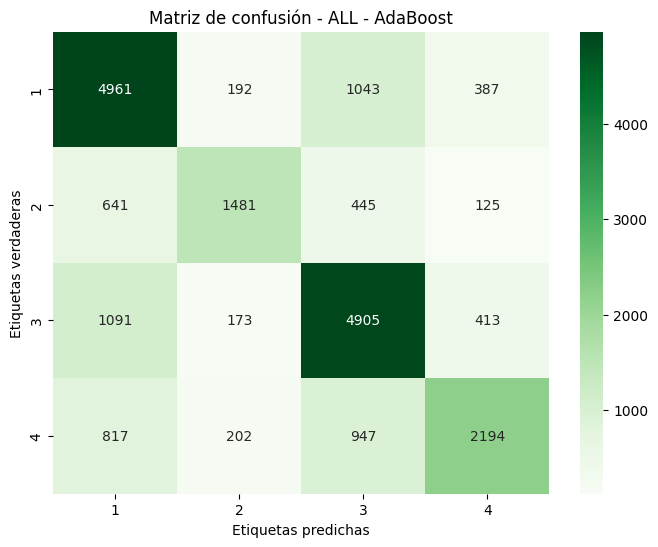

Training with ALL signals:  60%|██████    | 3/5 [28:25<21:30, 645.01s/it]

              precision    recall  f1-score   support

           1       0.66      0.75      0.70      6583
           2       0.72      0.55      0.62      2692
           3       0.67      0.75      0.70      6582
           4       0.70      0.53      0.60      4160

    accuracy                           0.68     20017
   macro avg       0.69      0.64      0.66     20017
weighted avg       0.68      0.68      0.67     20017

Training LDA model for ALL signals using LOSO...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
ALL - LDA Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.438477  ALL - LDA
1  Precision  0.496975  ALL - LDA
2     Recall  0.438477  ALL - LDA
3   F1 Score  0.363873  ALL - LDA
[ALL - LDA] Best Params: {'solver': 'svd'}
[ALL - LDA] Accuracy: 0.4385
ALL - LDA - Confusion Matrix
[[4372    0 2051  160]
 [1782    0  837   73]
 [2222    0 4222  138]
 [2495    0 1482  183]]


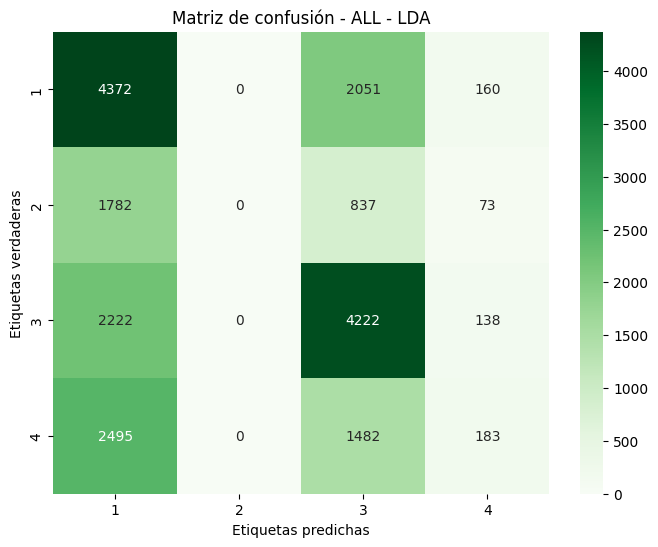

c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gustavo\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training with ALL signals

              precision    recall  f1-score   support

           1       0.40      0.66      0.50      6583
           2       0.00      0.00      0.00      2692
           3       0.49      0.64      0.56      6582
           4       0.33      0.04      0.08      4160

    accuracy                           0.44     20017
   macro avg       0.31      0.34      0.28     20017
weighted avg       0.36      0.44      0.36     20017

Training KNN model for ALL signals using LOSO...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
ALL - KNN Metrics
     Métrica     Valor      Etapa
0   Accuracy  0.976670  ALL - KNN
1  Precision  0.976686  ALL - KNN
2     Recall  0.976670  ALL - KNN
3   F1 Score  0.976669  ALL - KNN
[ALL - KNN] Best Params: {'n_neighbors': 3, 'weights': 'distance'}
[ALL - KNN] Accuracy: 0.9767
ALL - KNN - Confusion Matrix
[[6466   25   46   46]
 [  36 2613   29   14]
 [  78   27 6410   67]
 [  34   12   53 4061]]


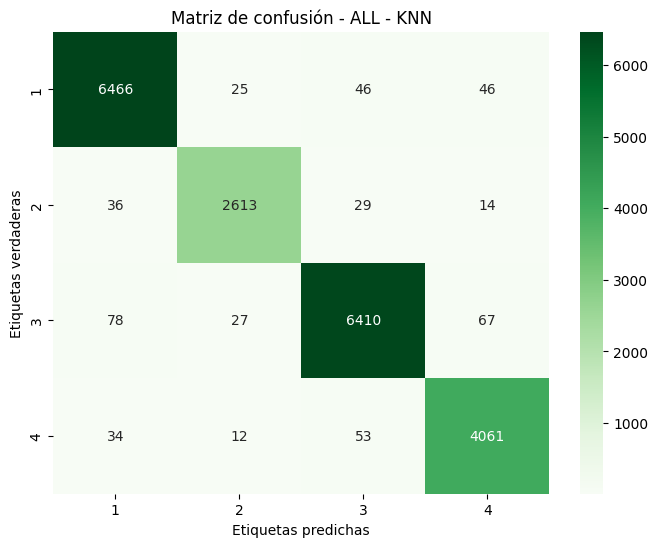

Training with ALL signals: 100%|██████████| 5/5 [28:28<00:00, 341.70s/it]

              precision    recall  f1-score   support

           1       0.98      0.98      0.98      6583
           2       0.98      0.97      0.97      2692
           3       0.98      0.97      0.98      6582
           4       0.97      0.98      0.97      4160

    accuracy                           0.98     20017
   macro avg       0.98      0.98      0.98     20017
weighted avg       0.98      0.98      0.98     20017


Final Comparison:
ECG - DecisionTree:      Métrica     Valor               Etapa
0   Accuracy  0.426637  ECG - DecisionTree
1  Precision  0.524099  ECG - DecisionTree
2     Recall  0.426637  ECG - DecisionTree
3   F1 Score  0.356113  ECG - DecisionTree
ECG - RandomForest:      Métrica     Valor               Etapa
0   Accuracy  0.942499  ECG - RandomForest
1  Precision  0.943431  ECG - RandomForest
2     Recall  0.942499  ECG - RandomForest
3   F1 Score  0.942231  ECG - RandomForest
ECG - AdaBoost:      Métrica     Valor           Etapa
0   Accuracy  0.58615

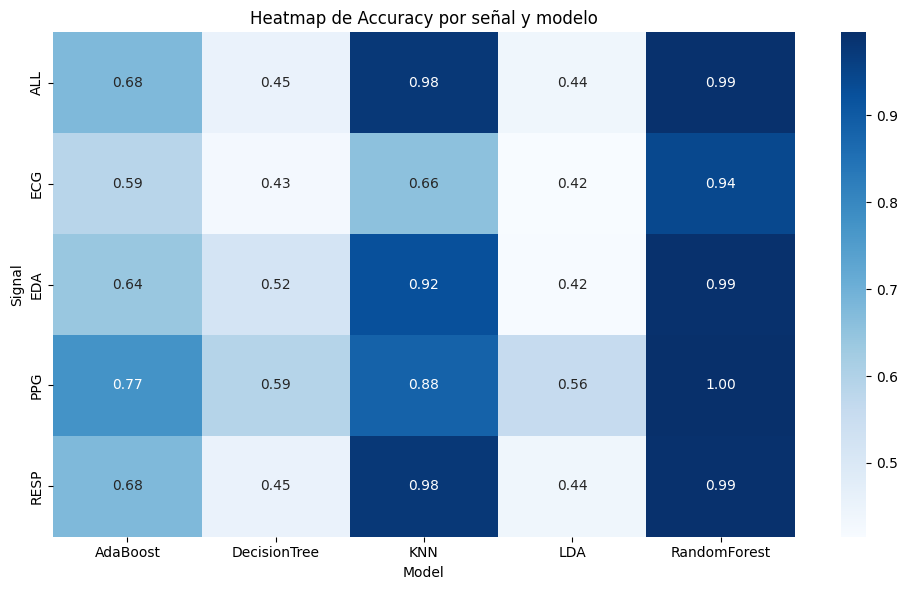

In [ ]:
"""# Entrenamiento por cada tipo de señal
for signal, features in tqdm(SIGNAL_CATEGORIES.items(), desc="Training by signal"):
    if all(f in df.columns for f in features):  # Verificar que todas las columnas existen
        X = df[features]
        y = df['label']
        subjects = df['subject']  # Se agrega el identificador de sujetos para LOSO
        
        for model_name, (model, param_grid) in models.items():
            print(f'Training {model_name} model for {signal}...')
            metrics = train_and_evaluate(X, y, model, param_grid, model_name, signal)
            results[(signal, model_name)] = metrics

# Entrenamiento con todas las señales combinadas
X_all = df.drop(columns=['label', 'subject'])  # También se excluye 'subject'
y_all = df['label']
subjects_all = df['subject']

for model_name, (model, param_grid) in tqdm(models.items(), desc="Training with ALL signals"):
    print(f'Training {model_name} model for ALL signals using LOSO...')
    acc = train_and_evaluate(X, y, model, param_grid, model_name, "ALL")
    results[("ALL", model_name)] = acc

# Mostrar resultados finales
print("\nFinal Comparison:")
for (signal, model_name), acc in results.items():
    print(f'{signal} - {model_name}: {acc}')

rows = []

for (signal, model), df_metrics in results.items():
    # Convertimos el DataFrame a formato entendible
    metric_values = df_metrics.set_index('Métrica')['Valor']
    
    row = {
        'Signal': signal,
        'Model': model,
        'Accuracy': metric_values.get('Accuracy', None),
        'F1': metric_values.get('F1 Score', None),
        'Precision': metric_values.get('Precision', None),
        'Recall': metric_values.get('Recall', None)
    }
    rows.append(row)

metrics_df = pd.DataFrame(rows)

pivot_df = metrics_df.pivot(index='Signal', columns='Model', values='Accuracy')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, cmap="Blues", fmt=".2f")
plt.title('Heatmap de Accuracy por señal y modelo')
plt.tight_layout()
plt.show()"""

In [ ]:
print(terminado)

In [ ]:
import pandas as pd

data = [
    ["ECG", "DecisionTree", "Accuracy", 0.426637],
    ["ECG", "DecisionTree", "Precision", 0.524099],
    ["ECG", "DecisionTree", "Recall", 0.426637],
    ["ECG", "DecisionTree", "F1 Score", 0.356113],
    
    ["ECG", "RandomForest", "Accuracy", 0.942499],
    ["ECG", "RandomForest", "Precision", 0.943431],
    ["ECG", "RandomForest", "Recall", 0.942499],
    ["ECG", "RandomForest", "F1 Score", 0.942231],
    
    ["ECG", "AdaBoost", "Accuracy", 0.586152],
    ["ECG", "AdaBoost", "Precision", 0.581555],
    ["ECG", "AdaBoost", "Recall", 0.586152],
    ["ECG", "AdaBoost", "F1 Score", 0.580388],
    
    ["ECG", "LDA", "Accuracy", 0.415197],
    ["ECG", "LDA", "Precision", 0.417248],
    ["ECG", "LDA", "Recall", 0.415197],
    ["ECG", "LDA", "F1 Score", 0.358256],
    
    ["ECG", "KNN", "Accuracy", 0.657541],
    ["ECG", "KNN", "Precision", 0.655851],
    ["ECG", "KNN", "Recall", 0.657541],
    ["ECG", "KNN", "F1 Score", 0.655284],
    
    ["PPG", "DecisionTree", "Accuracy", 0.589749],
    ["PPG", "DecisionTree", "Precision", 0.657386],
    ["PPG", "DecisionTree", "Recall", 0.589749],
    ["PPG", "DecisionTree", "F1 Score", 0.611145],
    
    ["PPG", "RandomForest", "Accuracy", 0.995204],
    ["PPG", "RandomForest", "Precision", 0.995213],
    ["PPG", "RandomForest", "Recall", 0.995204],
    ["PPG", "RandomForest", "F1 Score", 0.995199],
    
    ["PPG", "AdaBoost", "Accuracy", 0.774192],
    ["PPG", "AdaBoost", "Precision", 0.775871],
    ["PPG", "AdaBoost", "Recall", 0.774192],
    ["PPG", "AdaBoost", "F1 Score", 0.774591],
    
    ["PPG", "LDA", "Accuracy", 0.561573],
    ["PPG", "LDA", "Precision", 0.519806],
    ["PPG", "LDA", "Recall", 0.561573],
    ["PPG", "LDA", "F1 Score", 0.508671],
    
    ["PPG", "KNN", "Accuracy", 0.882949],
    ["PPG", "KNN", "Precision", 0.882701],
    ["PPG", "KNN", "Recall", 0.882949],
    ["PPG", "KNN", "F1 Score", 0.882814],
    
    ["EDA", "DecisionTree", "Accuracy", 0.518559],
    ["EDA", "DecisionTree", "Precision", 0.592203],
    ["EDA", "DecisionTree", "Recall", 0.518559],
    ["EDA", "DecisionTree", "F1 Score", 0.531905],
    
    ["EDA", "RandomForest", "Accuracy", 0.992656],
    ["EDA", "RandomForest", "Precision", 0.992669],
    ["EDA", "RandomForest", "Recall", 0.992656],
    ["EDA", "RandomForest", "F1 Score", 0.992653],
    
    ["EDA", "AdaBoost", "Accuracy", 0.640605],
    ["EDA", "AdaBoost", "Precision", 0.660503],
    ["EDA", "AdaBoost", "Recall", 0.640605],
    ["EDA", "AdaBoost", "F1 Score", 0.646235],
    
    ["EDA", "LDA", "Accuracy", 0.417995],
    ["EDA", "LDA", "Precision", 0.417615],
    ["EDA", "LDA", "Recall", 0.417995],
    ["EDA", "LDA", "F1 Score", 0.350615],
    
    ["EDA", "KNN", "Accuracy", 0.923115],
    ["EDA", "KNN", "Precision", 0.923083],
    ["EDA", "KNN", "Recall", 0.923115],
    ["EDA", "KNN", "F1 Score", 0.923096],
    
    ["RESP", "DecisionTree", "Accuracy", 0.454064],
    ["RESP", "DecisionTree", "Precision", 0.475188],
    ["RESP", "DecisionTree", "Recall", 0.454064],
    ["RESP", "DecisionTree", "F1 Score", 0.453421],
    
    ["RESP", "RandomForest", "Accuracy", 0.991807],
    ["RESP", "RandomForest", "Precision", 0.991833],
    ["RESP", "RandomForest", "Recall", 0.991807],
    ["RESP", "RandomForest", "F1 Score", 0.991806],
    
    ["RESP", "AdaBoost", "Accuracy", 0.676475],
    ["RESP", "AdaBoost", "Precision", 0.680425],
    ["RESP", "AdaBoost", "Recall", 0.676475],
    ["RESP", "AdaBoost", "F1 Score", 0.672559],
    
    ["RESP", "LDA", "Accuracy", 0.438477],
    ["RESP", "LDA", "Precision", 0.496975],
    ["RESP", "LDA", "Recall", 0.438477],
    ["RESP", "LDA", "F1 Score", 0.363873],
    
    ["RESP", "KNN", "Accuracy", 0.976670],
    ["RESP", "KNN", "Precision", 0.976686],
    ["RESP", "KNN", "Recall", 0.976670],
    ["RESP", "KNN", "F1 Score", 0.976669],
    
    ["ALL", "DecisionTree", "Accuracy", 0.454064],
    ["ALL", "DecisionTree", "Precision", 0.475188],
    ["ALL", "DecisionTree", "Recall", 0.454064],
    ["ALL", "DecisionTree", "F1 Score", 0.453421],
    
    ["ALL", "RandomForest", "Accuracy", 0.991807],
    ["ALL", "RandomForest", "Precision", 0.991833],
    ["ALL", "RandomForest", "Recall", 0.991807],
    ["ALL", "RandomForest", "F1 Score", 0.991806],
    
    ["ALL", "AdaBoost", "Accuracy", 0.676475],
    ["ALL", "AdaBoost", "Precision", 0.680425],
    ["ALL", "AdaBoost", "Recall", 0.676475],
    ["ALL", "AdaBoost", "F1 Score", 0.672559],
    
    ["ALL", "LDA", "Accuracy", 0.438477],
    ["ALL", "LDA", "Precision", 0.496975],
    ["ALL", "LDA", "Recall", 0.438477],
    ["ALL", "LDA", "F1 Score", 0.363873],
    
    ["ALL", "KNN", "Accuracy", 0.976670],
    ["ALL", "KNN", "Precision", 0.976686],
    ["ALL", "KNN", "Recall", 0.976670],
    ["ALL", "KNN", "F1 Score", 0.976669],
]

df = pd.DataFrame(data, columns=["Señal", "Modelo", "Métrica", "Valor"])

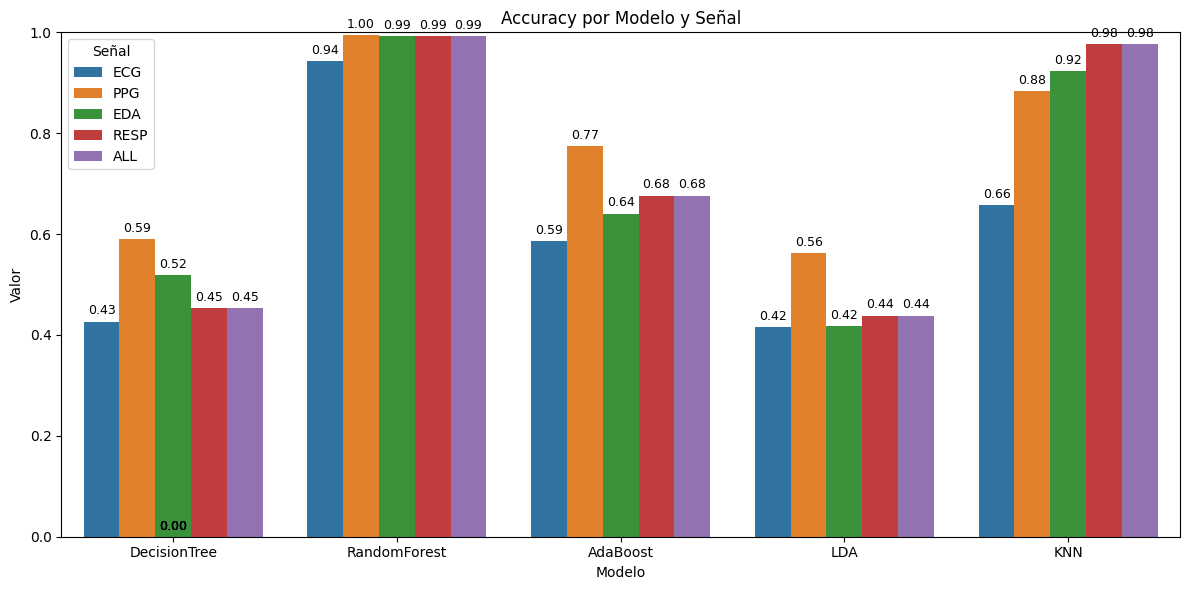

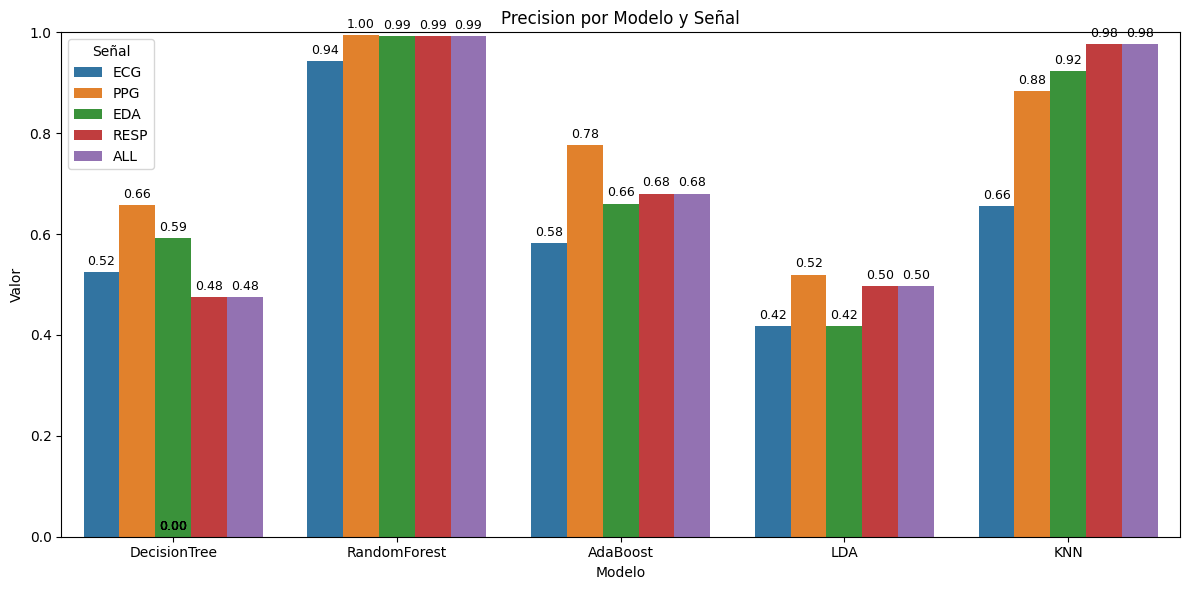

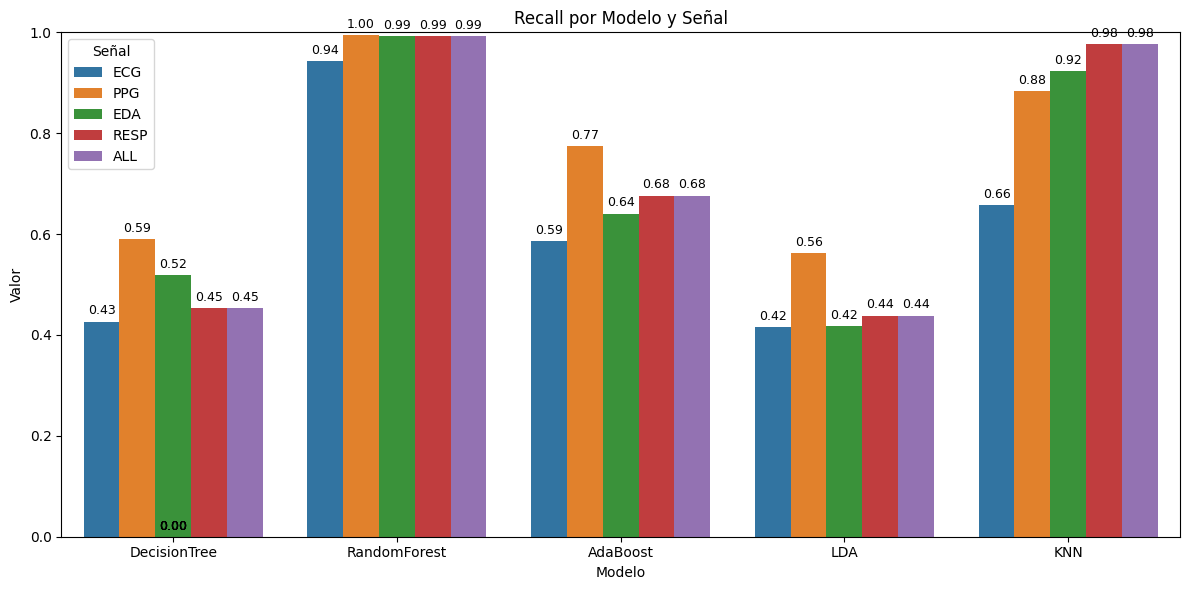

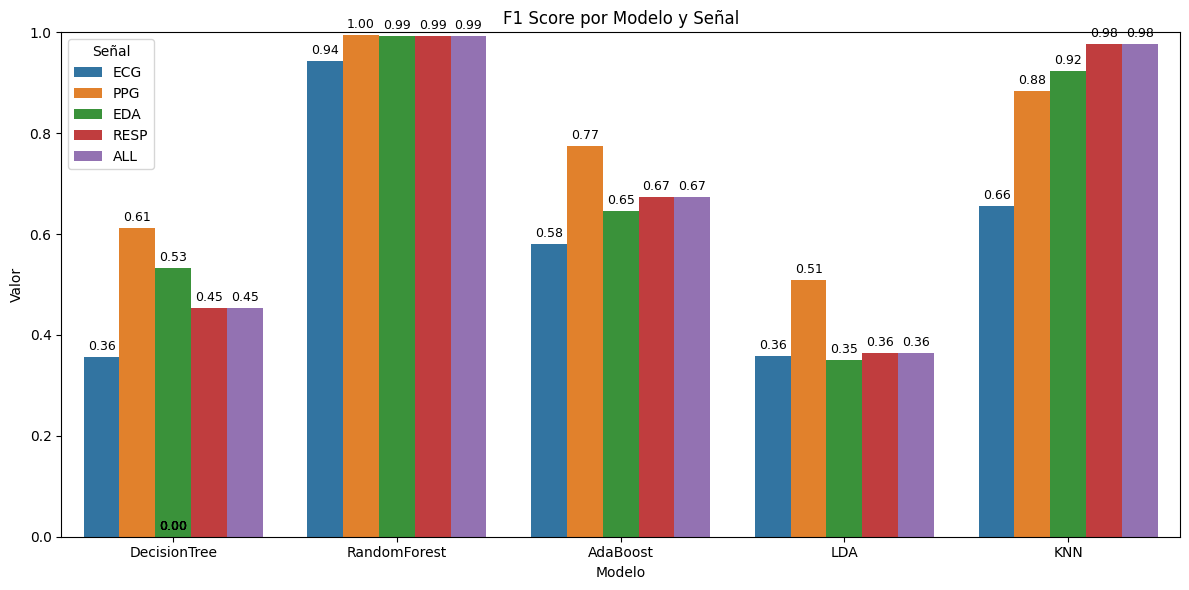

In [ ]:
metricas = df["Métrica"].unique()

# Una figura por métrica
for metrica in metricas:
    plt.figure(figsize=(12, 6))
    data_metrica = df[df["Métrica"] == metrica]
    ax = sns.barplot(data=data_metrica, x="Modelo", y="Valor", hue="Señal")
    
    plt.title(f"{metrica} por Modelo y Señal")
    plt.ylim(0, 1)
    plt.legend(title="Señal")
    plt.tight_layout()

    # Añadir los valores encima de las barras
    for p in ax.patches:
        height = p.get_height()
        if not pd.isna(height):
            ax.annotate(f'{height:.2f}', 
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom',
                        fontsize=9, color='black', xytext=(0, 3),
                        textcoords='offset points')

    plt.show()

*RANDOM FOREST*

In [ ]:
param_gridrRD = {
    'n_estimators': [100, 200, 300, 500],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
}

randomfor_model = RandomForestClassifier(random_state=random)

print("Sin balanceo")
train_and_evaluate(randomfor_model, param_gridrRD, X_train, y_train, X_test, y_test)

Sin balanceo


NameError: name 'X_train' is not defined

*ADA BOOST*

In [ ]:
param_gridADA = {
    'n_estimators': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 58],
    'estimator__max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30]
}

base_estimator = DecisionTreeClassifier(random_state=random)
adaboost_model = AdaBoostClassifier(estimator=base_estimator, random_state=random)

train_and_evaluate(adaboost_model, param_gridADA, X_train, y_train, X_test, y_test)

*KNN*

In [ ]:
param_gridKNN = {
    'n_neighbors': [2, 3, 4, 5, 8, 10, 12, 15, 18, 20],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree']
}

knn_model = KNeighborsClassifier()

train_and_evaluate(knn_model, param_gridKNN, X_train, y_train, X_test, y_test)

*DECISION TREE*

In [ ]:
param_gridDT = {
    'criterion': ['gini', 'entropy'],  # Función para medir la calidad de una división
    'max_depth': [None, 3, 5, 10, 20],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4, 8],  # Muestras mínimas en una hoja
    'max_features': ['sqrt', 'log2', None]  # Número de características a considerar en cada división
}

decision_tree_model = DecisionTreeClassifier(random_state=random)

train_and_evaluate(decision_tree_model, param_gridDT, X_train, y_train, X_test, y_test)

*LDA*

In [ ]:
param_gridLDA = {
    'solver': ['lsqr', 'eigen'],  # Excluye 'svd'
    'shrinkage': ['auto', 0.1, 0.5, 1.0]  # Compatible con 'lsqr' y 'eigen'
}

lda_model = LinearDiscriminantAnalysis()

train_and_evaluate(lda_model, param_gridLDA, X_train, y_train, X_test, y_test)